# Assignment 3 - Reinforcement Learning with Deep Q-Networks

#### Kobee Raveendran
#### CAP 5610

### Imports (Gym environment and Deep Q-Network dependencies)

In [1]:
import gym
from gym import wrappers
import io
import base64
from IPython.display import HTML
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
import matplotlib.pyplot as plt
%matplotlib notebook

# rendering frames in jupyter
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

plt.style.use('seaborn-whitegrid')

Using TensorFlow backend.


### Agent and Environment (Explanation)

#### Agent
The agent in the CartPole environment is simply the cart itself; it is responsible for doing the "learning" in this problem. The agent interacts with the environment and learns optimal actions that correspond to higher rewards through experience over time. It gets a sense for which actions are optimal by first performing the action, then receiving a reward from the observation of the next state given by the environment (which repeats in a cyclic fashion).

#### Agent Action Space
In this environment, there is a defined action space that represents the set of actions an agent can perform at each time step. In the CartPole environment, the cart (agent) can only perform one of two actions: move left or right. These two actions constitute the action space, and can be confirmed by viewing the elements or size of the action space (as in `env.action_space.n`).

#### Observation Space
Since this is a relatively simple environment, the observation space, which is the simplest representation for the current state of the environment at each time step, is fairly small. It consists of only 4 elements (confirmed by viewing the shape of `env.observation_space`), which are the **cart position**, **cart velocity**, **pole angle**, and **velocity of the pole at the tip** (confirmed by the cartpole environment source code).

#### Rewards
In the CartPole environment, rewards are fairly straightforward. For every time step that the pole is aloft and in a "surviving" (non-terminal) state, the agent receives a reward of +1. A state is deemed terminal if the pole's angle surpasses a set threshold (+/- 12 degrees) or if the cart has passed a certain distance away from the center (2.4 units), thus reaching the edge of the display (according to the CartPole source code).

In [2]:
def cartpole(num_episodes):
    
    # set the default parameters (of which only one will vary per function call)
    params = {
        'learning_rate': 0.001, 
        'gamma': 0.95, 
        'epsilon': 1.0, 
        'epsilon_min': 0.01, 
        'epsilon_decay': 0.995
    }
    
    env = gym.make('CartPole-v0')
    #env = wrappers.Monitor(env, './cartpole-results', force = True)
    obs_space = env.observation_space.shape[0]
    action_space = env.action_space.n    
        
    dqn = DQN(
        obs_space, 
        action_space, 
        learning_rate = 0.001, 
        gamma = 0.95, 
        epsilon = 1.0, 
        epsilon_min = 0.01, 
        epsilon_decay = 0.995
    )
    
    # raise the cap for max. number of time steps per episode
    # (cartpole v0 uses a default of 200, which would cap the reward
    # of the agent at 200 even though it could achieve higher scores)
    env._max_episode_steps = 2000
        
    scores = []
    running_avg = []
    min_score = env._max_episode_steps
    max_score = 0
    
    best_run_frames = []
    best_run_episode = -1
        
    for episode in range(num_episodes):
        state = env.reset()
        state = np.reshape(state, [1, obs_space])

        time_step = 0
        done = False
        frames = []
        
        while not done:
            frames.append(env.render(mode = 'rgb_array'))

            action = dqn.act(state)

            observation, reward, done, info = env.step(action)
            observation = np.reshape(observation, [1, obs_space])
                
            dqn.remember(state, action, reward, observation, done)
                
            state = observation
                
            time_step += 1

            if done:
                
                scores.append(time_step)
                avg = np.mean(scores)
                running_avg.append(avg)
                
                if time_step > max_score:
                    best_run_frames = frames
                    best_run_episode = episode
                    max_score = time_step
                    
                    print('new max score: ', max_score)
                    print('new best episode: ', episode)
                    
                if time_step < min_score:
                    min_score = time_step
                
                if (episode + 1) % 10 == 0:
                    print('Episode: {} of {}; score: {}'.format(episode + 1, num_episodes, time_step), end = '\t')
                
                    print('-- New average (including previous 10 episodes): ', avg)
                
                break

            dqn.experience_replay(32)

    mean_survival_time = np.mean(scores)
    fit_line = np.polyfit(x = range(num_episodes), y = scores, deg = 1)
    fit = np.poly1d(fit_line)
    
    # note that in this case, I use reward and score interchangeably since the CartPole environment awards a reward of +1 for 
    # each time-step the pole is aloft; for other environments, thus making the reward equal the score
    # this likely won't be the case in other environments with different reward metrics
    
    # plot the scores per episode and running average of scores
    plt.figure()
    plt.title('Agent Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(scores, label = 'scores')
    plt.plot(range(num_episodes), fit(range(num_episodes)), label = 'trend')
    
    print('Mean survival time: ', mean_survival_time)
    print('Maximum score over all episodes: ', max_score)
    print('Minimum score over all episodes: ', min_score)
    
    avg_fit_line = np.polyfit(x = range(num_episodes), y = running_avg, deg = 1)
    avg_fit = np.poly1d(avg_fit_line)
    
    plt.figure()
    plt.title('Accumulated Average Score')
    plt.xlabel('Episode')
    plt.ylabel('Running Average')
    plt.plot(running_avg, label = 'accumulated average')
    plt.plot(range(num_episodes), avg_fit(range(num_episodes)), label = 'trend')
    
    env.close()
    
    return best_run_frames, best_run_episode

### Deep Q-Network Structure and Hyperparameters

#### Network Architecture
For the neural network, I chose to make it a simple and shallow fully-connected network (FCN), in line with many existing implementations of DQN that I've based mine on. I did, however, change the width of the network due to a very noticeable performance boost (in terms of agent performance in early episodes and less fluctuation in later phases of training). I could not increase the width very much though, because I found that at a certain point, the agent starts fluctuating wildly or plateau's at a relatively low score and stays there.

#### Hyperparameter Selection
Deep Q-Networks have several key hyperparameters, most of which are used to update the Q-values during experience replay. They are: gamma, epsilon, minimum epsilon, epsilon decay, and learning rate (for the neural network). 

##### Gamma
Gamma represents the discount or reward decay rate, which is used to determine the value of future rewards for the agent. A low value of gamma would make the agent value future rewards less and instead prioritize current rewards, causing it to be short-sighted. Higher values of gamma less than 1 allow the agent to opt for longer-term rewards instead, while values higher than 1 may lead to the agent failing to converge at all. For this reason, I chose to keep gamma at a value close to 1 but not exceeding it. Increasing gamma from a lower value that gradually approaches 1 (asymptotically) is also said to accelerate training, but I preferred the higher early exploration and floundering as it seemed to yield somewhat better consistency and ability of the agent to achieve higher scores when trained on more episodes. For example, in my testing, agents that learned quickly (often achieving scores of 100+ within 10 episodes) often hit a plateau score soon after, and although they still performed well enough after then, they could never surpass this soft 'cap' on their potential. Meanwhile, agents that struggled early on but slowly achieved better scores after more episodes tended to surpass their limits eventually, allowing me to achieve scores exceeding even 1000 or 2000 in longer experiments (this trend was true on other hyperparameters, as I'll explain later).

##### Epsilon
Epsilon represents the exploration rate of the agent. In other words, it describes (as a probability) the agent's tendency to make a random 'explorative' move instead of using prior knowledge (the memory) and predictions (from the neural network) to determine its next move. I wanted to make my agent explore heavily in the initial stages in order to build up a more robust 'skill' set and better prepare it for a variety of situations (states) that it may encounter, so I left the exploration rate at 100% initially, to be decayed by another hyperparameter. I did experiment with other values of epsilon (such as 0.6 or values closer to 0), and this produced an agent that was 'prodigy-like' in early training performance but peaked early and failed to overcome a plateau in score later on.

##### Epsilon decay
Epsilon decay is just what it looks like; a variable that controls the rate of decay of the exploration rate. The way it is implemented here, a low (closer to 0) value of epsilon decay will rapidly decrease the agent's probability of resorting to random chance moves. This may have a short-term advantage (score-wise) in that the agent can achieve good scores early on by relying on predictions, but in the long run it will suffer due to poor adaptability. For this reason, I've left epsilon decay at 0.995 (thus, epsilon becomes 99.5% of its previous value, decreasing it ever so slightly).

##### Minimum epsilon
As discussed earlier, epsilon decay will gradually decrease the exploration rate per time step per episode. As episodes pass, this decay can accumulate quickly and the exploration rate will dwindle very fast. If the exploration rate is extremely small, (i.e. hundreds or thousands of orders of magnitude smaller than 1), our agent will have no potential for growth as it will very rarely, if ever, make random explorative actions. For this reason, epsilon is thresholded by a lower bound of `epsilon_min` so that there is always a possibility to explore *potentially* new actions and prevent the agent from plateauing.

##### Learning rate
Learning rate is a parameter I didn't experiment too much with, as I used previous intuition with neural networks to choose it. I stuck with `0.001` solely due to its performance in trial and error to tend to yield better results compared to smaller (`0.0001`) and larger (`0.01`, `0.1`) values. However, I conducted these experiments in isolation of the Q-learning hyperparameters, so perhaps there is a configuration where the other learning rates can out-perform my current configuration.

new max score:  31
new best episode:  0
new max score:  59
new best episode:  4
new max score:  120
new best episode:  9
Episode: 10 of 100; score: 120	-- New average (including previous 10 episodes):  41.8
new max score:  270
new best episode:  10
new max score:  331
new best episode:  13
Episode: 20 of 100; score: 170	-- New average (including previous 10 episodes):  124.15
new max score:  407
new best episode:  29
Episode: 30 of 100; score: 407	-- New average (including previous 10 episodes):  144.2
Episode: 40 of 100; score: 383	-- New average (including previous 10 episodes):  144.6
Episode: 50 of 100; score: 195	-- New average (including previous 10 episodes):  149.36
new max score:  1797
new best episode:  56
Episode: 60 of 100; score: 116	-- New average (including previous 10 episodes):  179.96666666666667
Episode: 70 of 100; score: 144	-- New average (including previous 10 episodes):  186.24285714285713
Episode: 80 of 100; score: 221	-- New average (including previous 10 episo

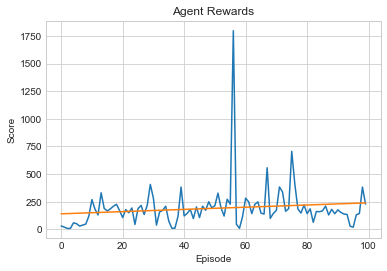

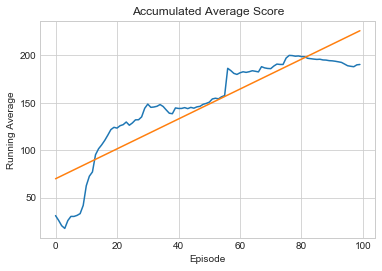

In [3]:
class DQN:
    
    def __init__(self, 
                 obs_space, 
                 action_space, 
                 learning_rate = 0.001, 
                 gamma = 0.95, 
                 epsilon = 1.0, 
                 epsilon_min = 0.01,
                 epsilon_decay = 0.995
                ):
        self.action_space = action_space
        
        self.memory = deque(maxlen = 2000)
        self.learning_rate = learning_rate
        self.gamma = gamma                       # 'discount' rate
        self.epsilon = epsilon                   # exploration rate
        self.epsilon_min = epsilon_min           # min exploration rate
        self.epsilon_decay = epsilon_decay       # exploration rate decay
        
        self.model = Sequential()
        
        self.model.add(Dense(36, input_dim = obs_space, activation = 'relu'))
        self.model.add(Dense(36, activation = 'relu'))
        self.model.add(Dense(self.action_space, activation = 'linear'))
        
        self.model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        
        q_vals = self.model.predict(state)
        
        return np.argmax(q_vals[0])
        
    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        batch = random.sample(self.memory, batch_size)
        
        for state, action, reward, state_next, done in batch:
            q_update = reward
            
            if not done:
                q_update = reward + self.gamma * np.amax(self.model.predict(state_next)[0])
                
            q_values = self.model.predict(state)
            
            q_values[0][action] = q_update
            
            self.model.fit(state, q_values, verbose = 0)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            
best_run_frames, best_run_episode = cartpole(100)

Best-performing episode: Episode  56



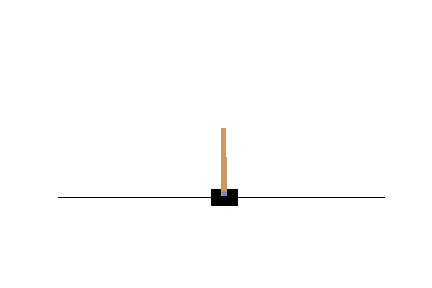
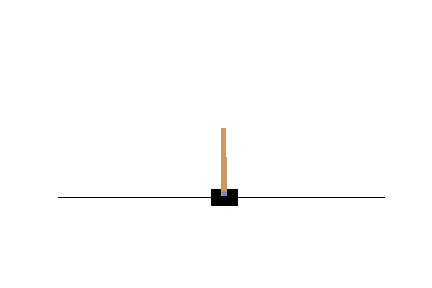
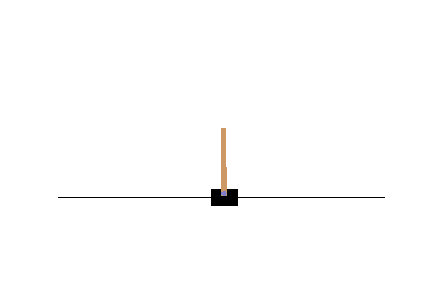
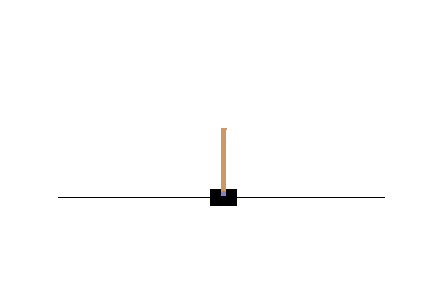
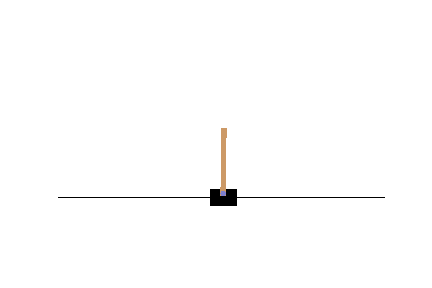
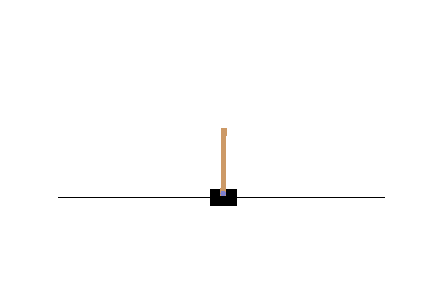
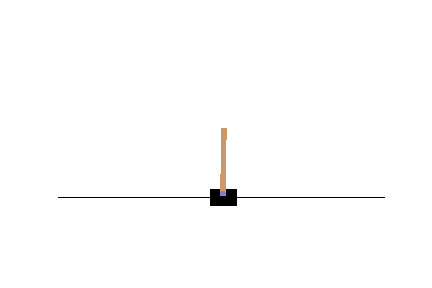
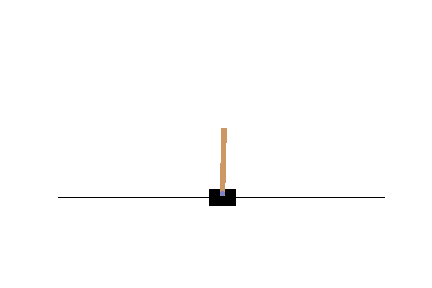
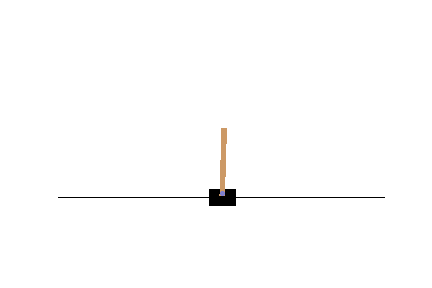
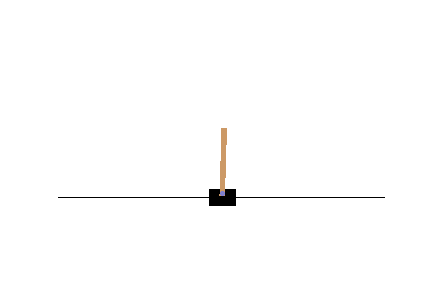
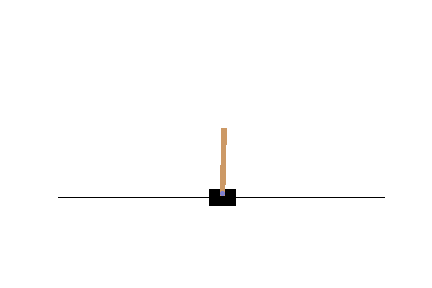
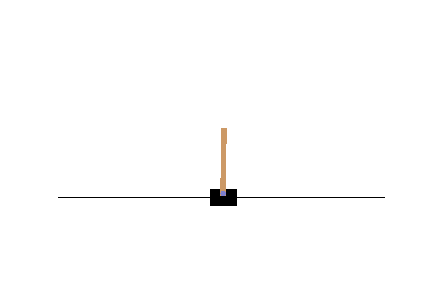
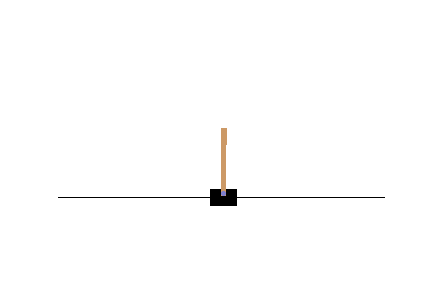
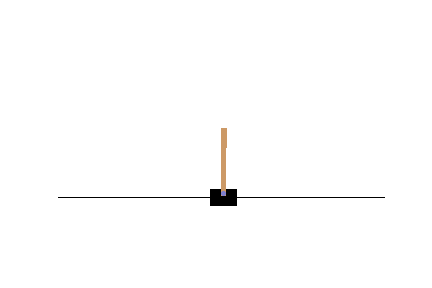
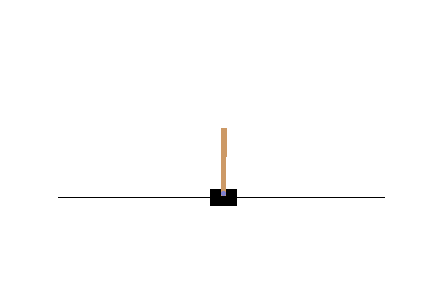
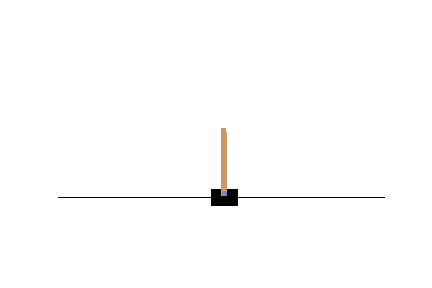
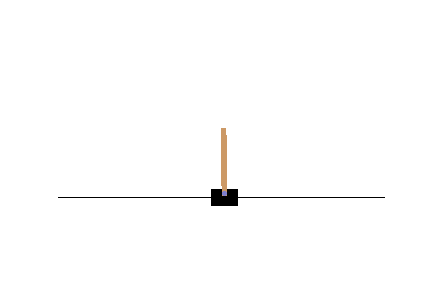
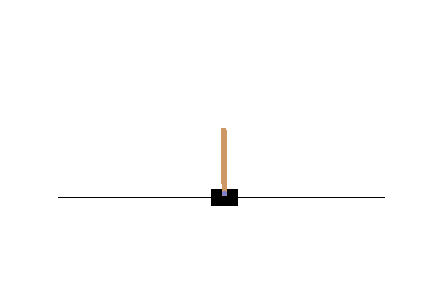
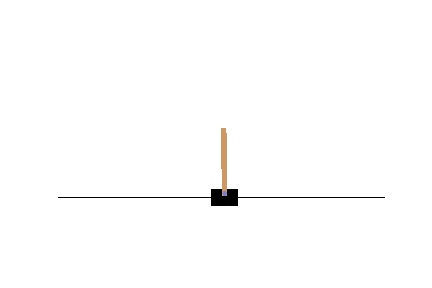
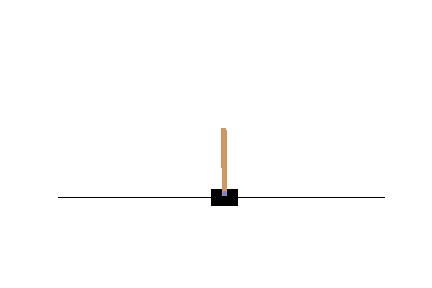
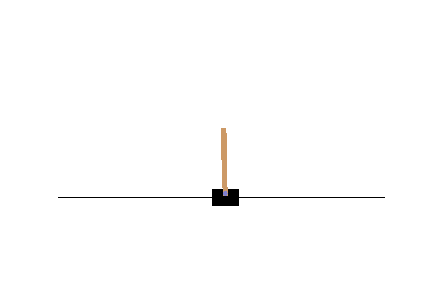
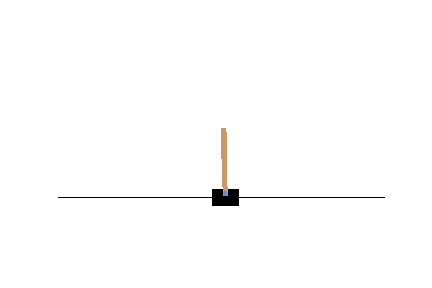
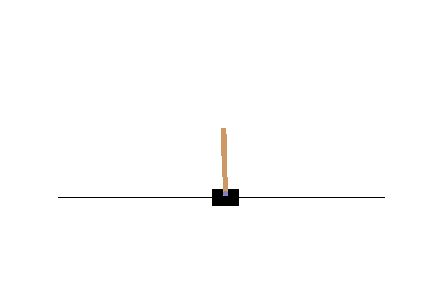
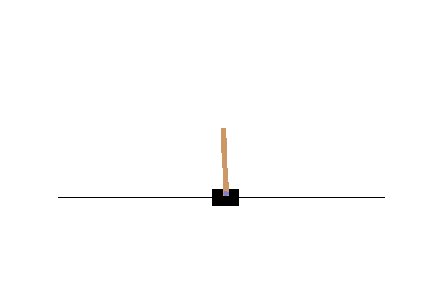
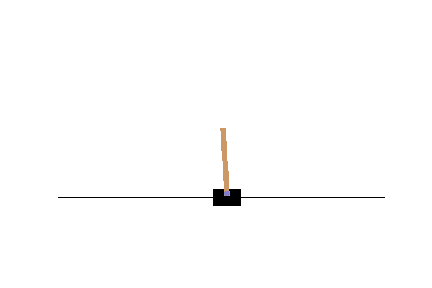
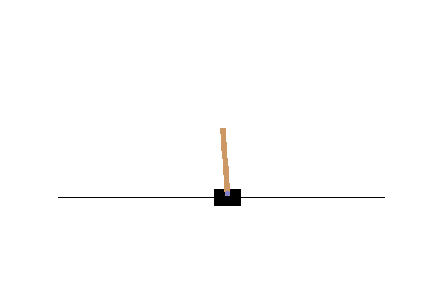
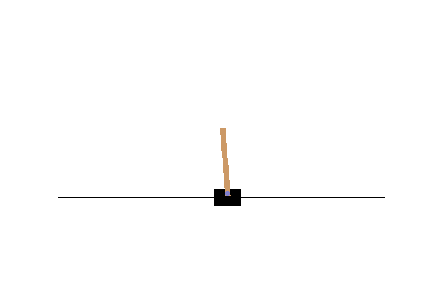
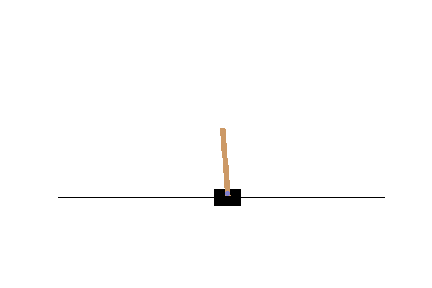
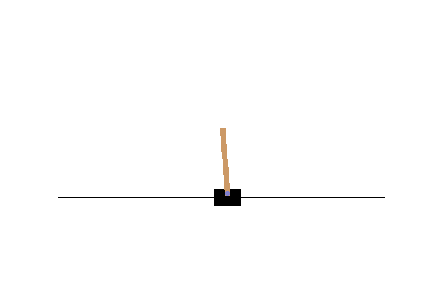
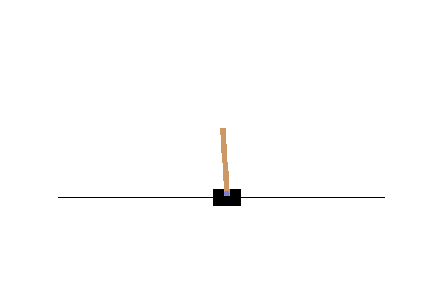
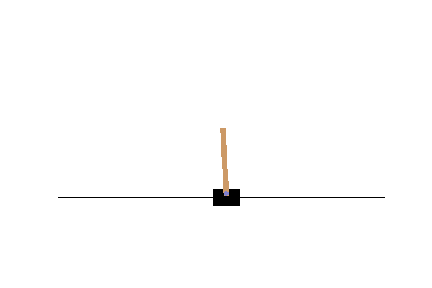
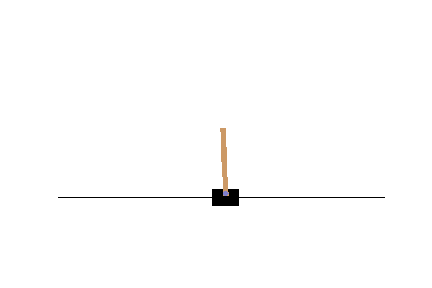
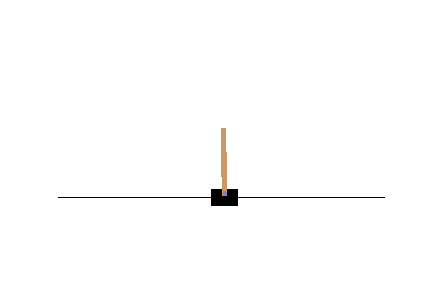
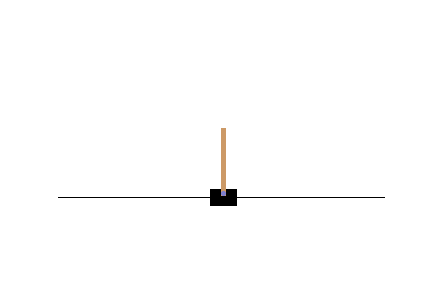
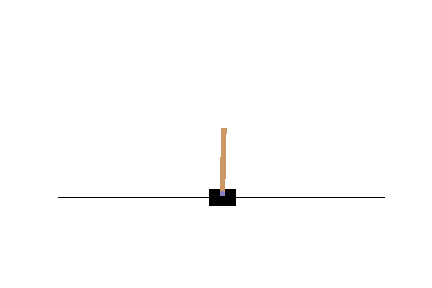
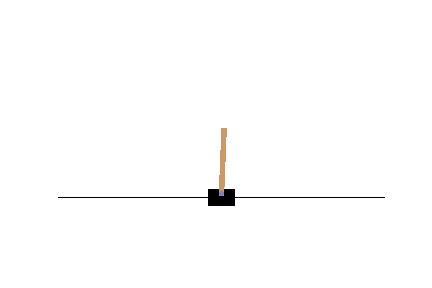
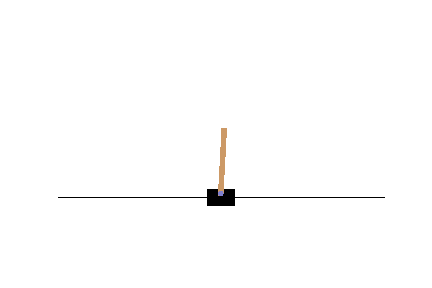
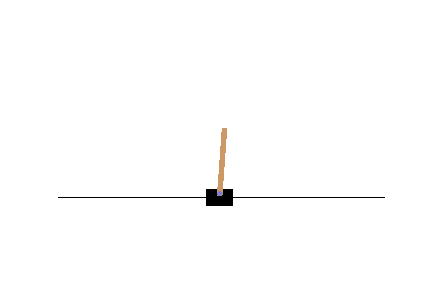
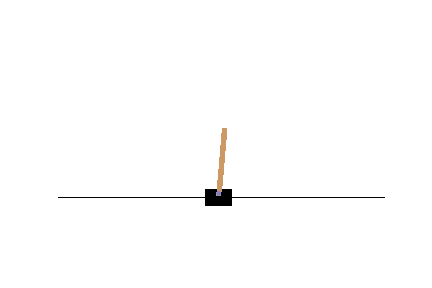
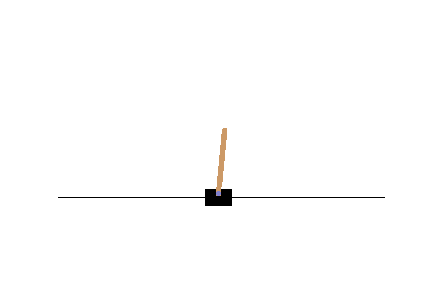
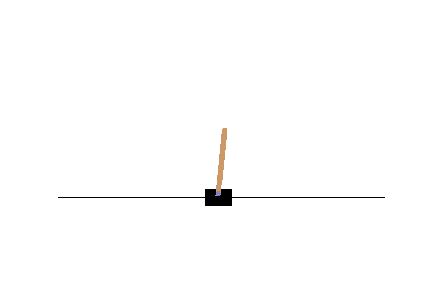
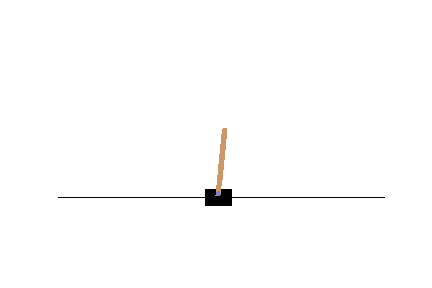
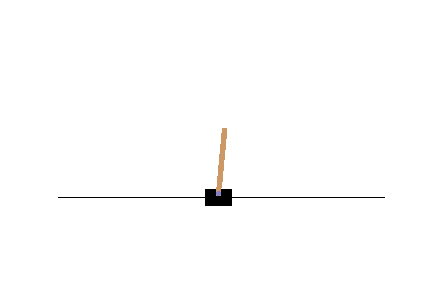
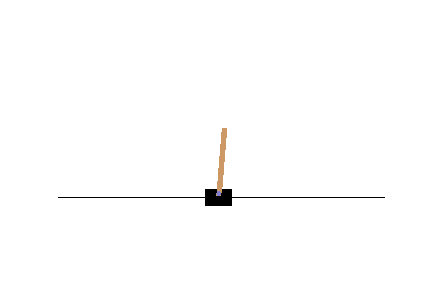
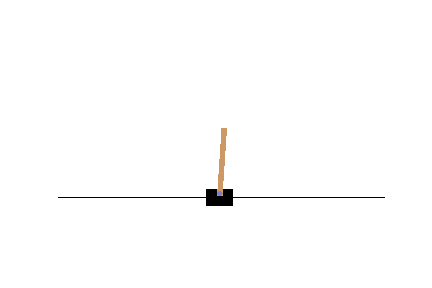
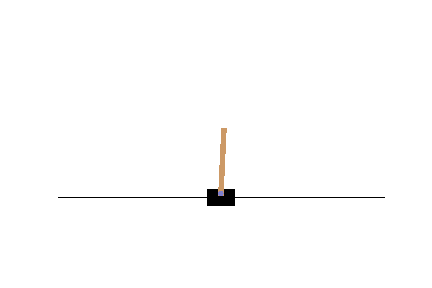
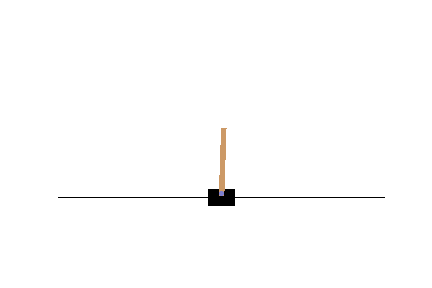
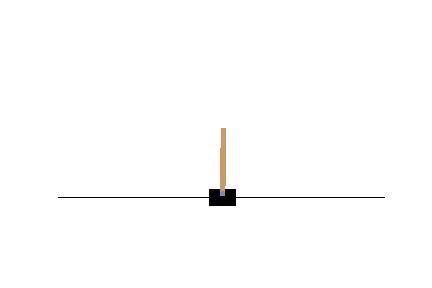
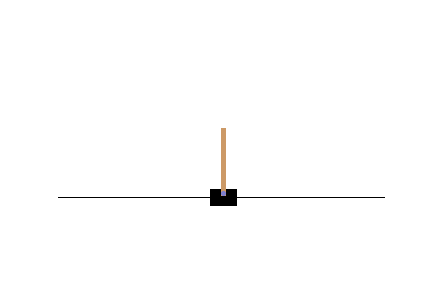
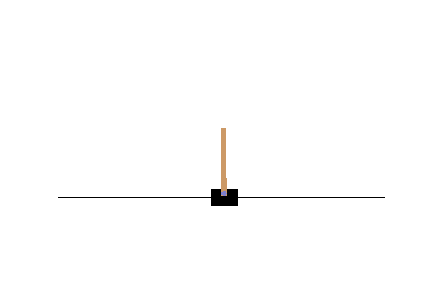
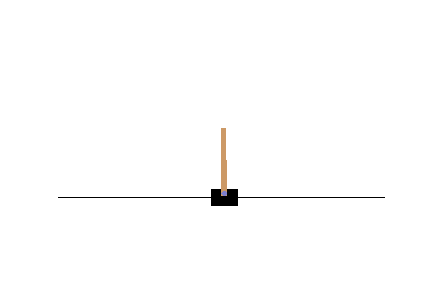
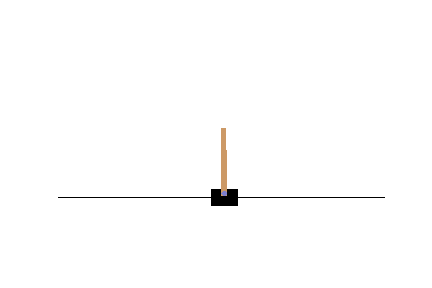
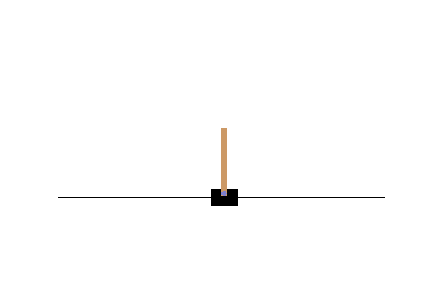
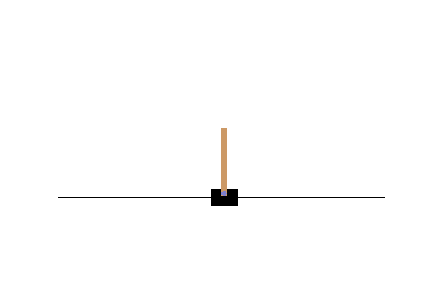
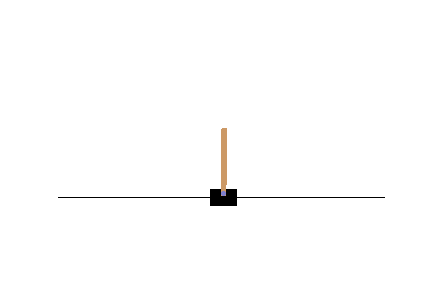
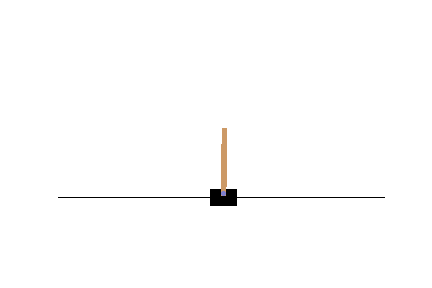
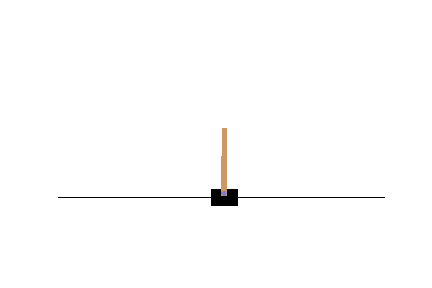
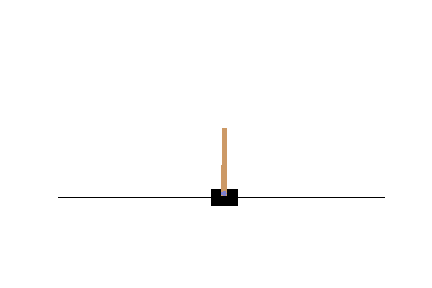
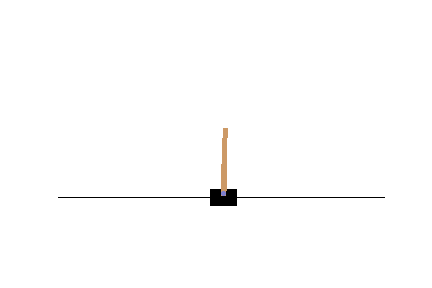
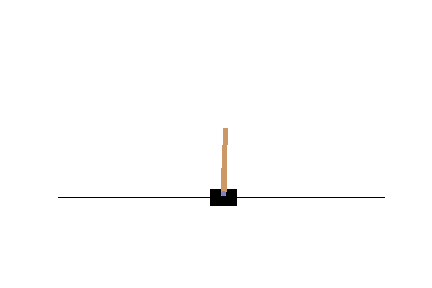
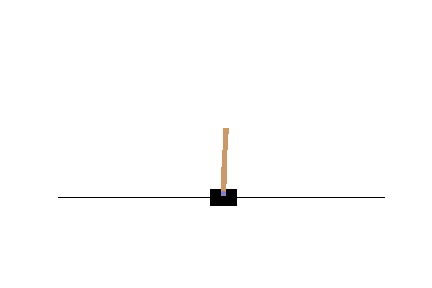
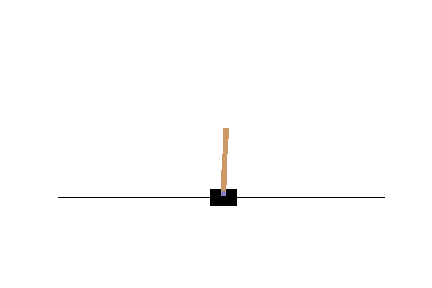
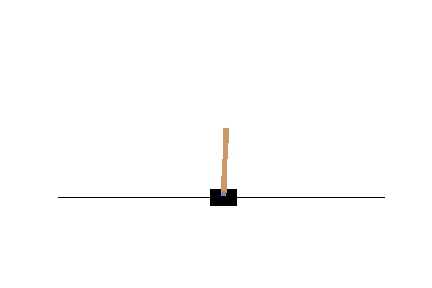
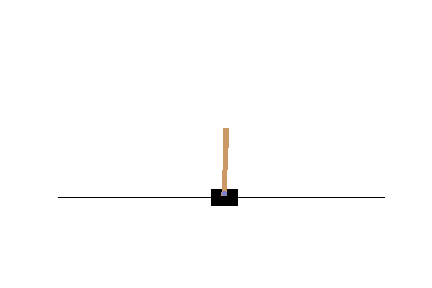
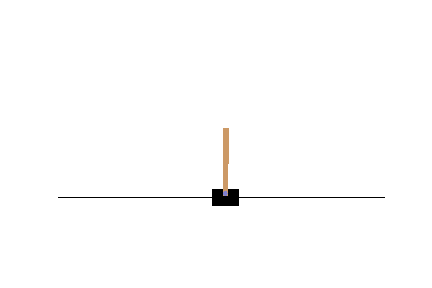
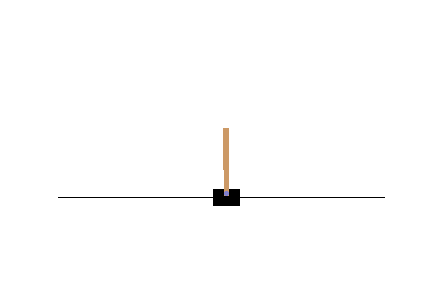
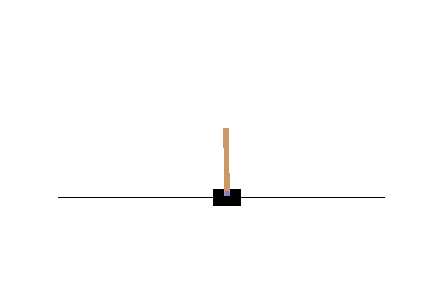
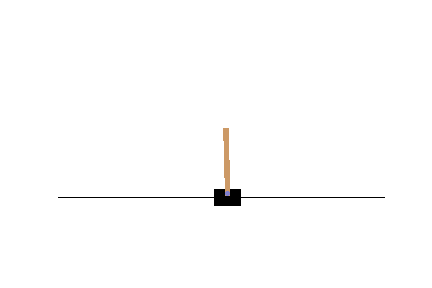
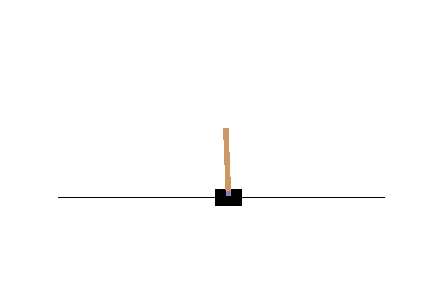
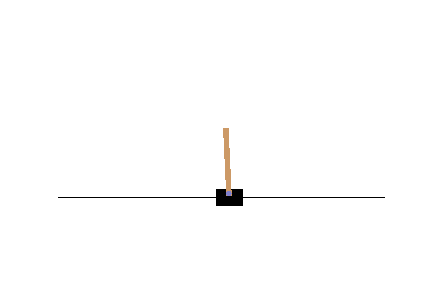
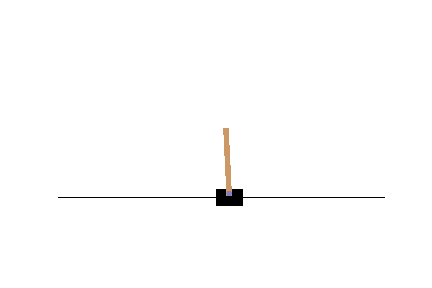
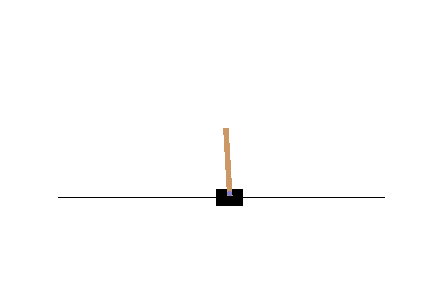
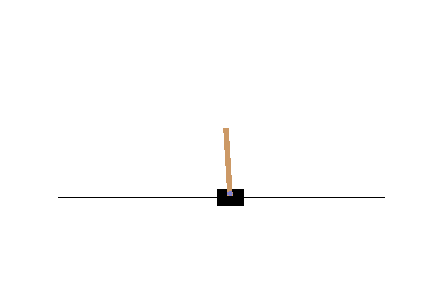
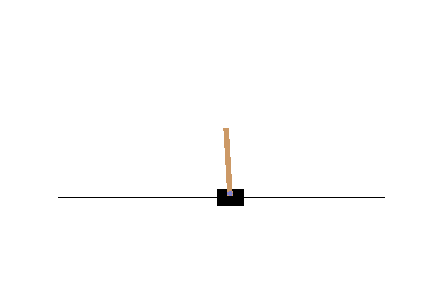
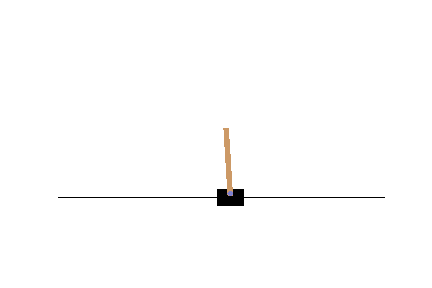
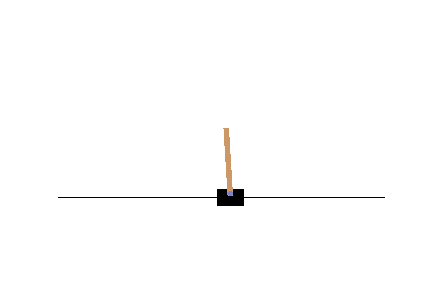
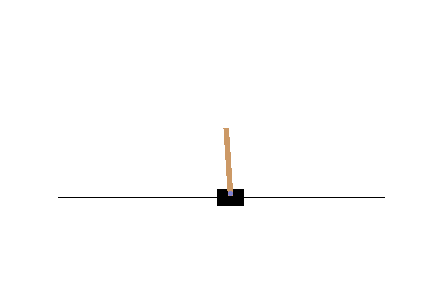
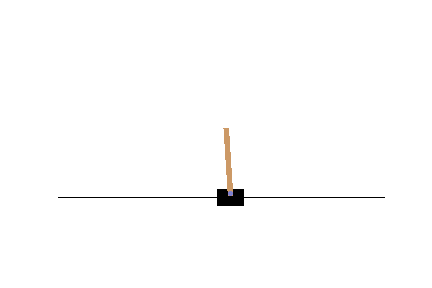
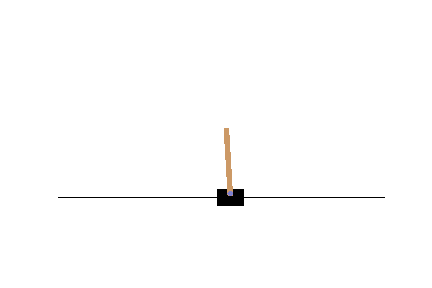
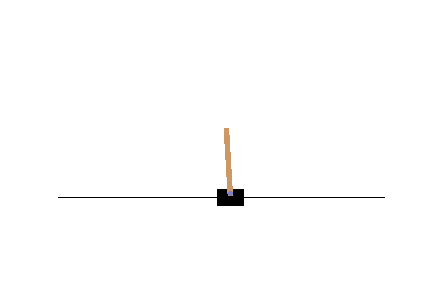
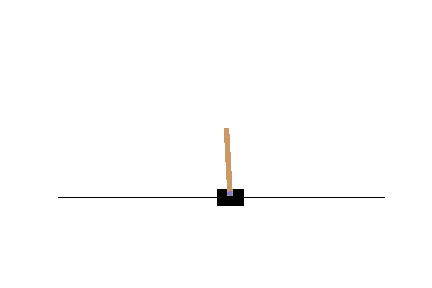
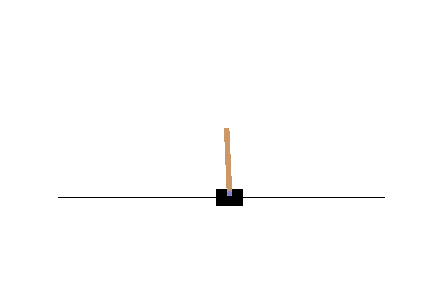
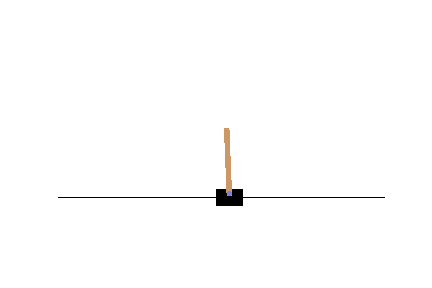
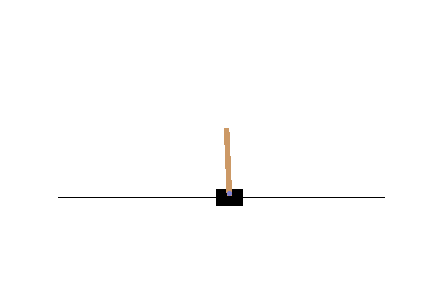
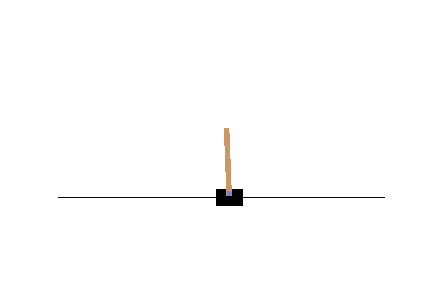
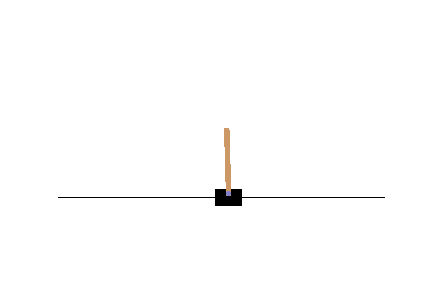
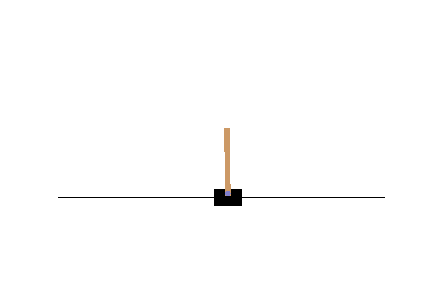
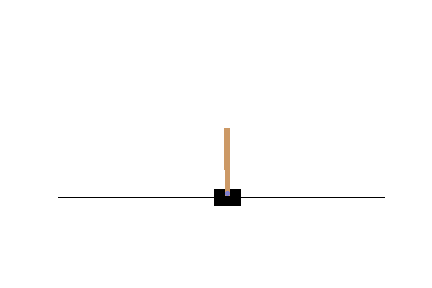
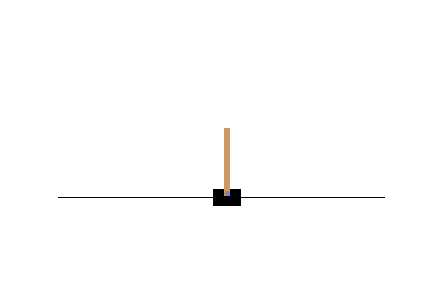
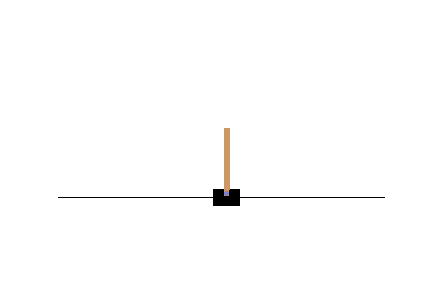
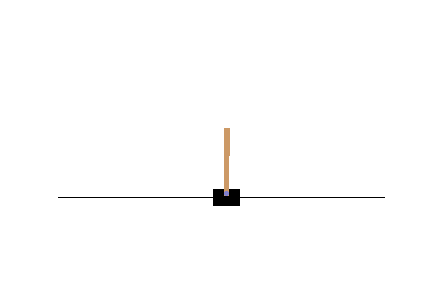
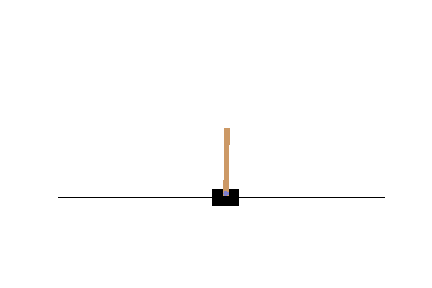
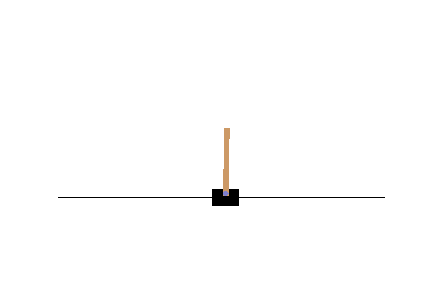
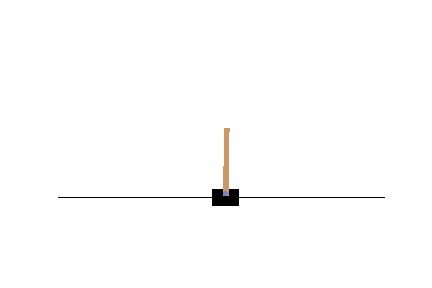
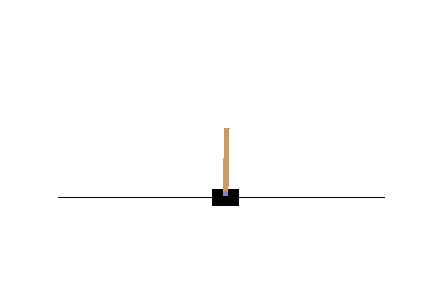
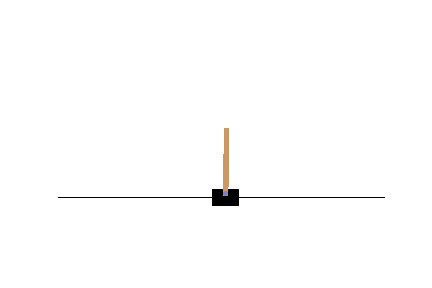
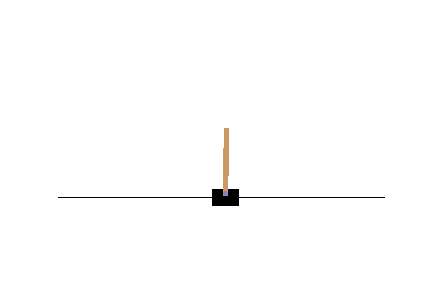
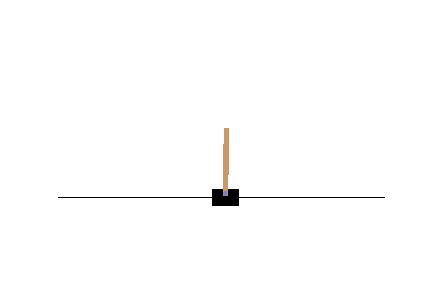
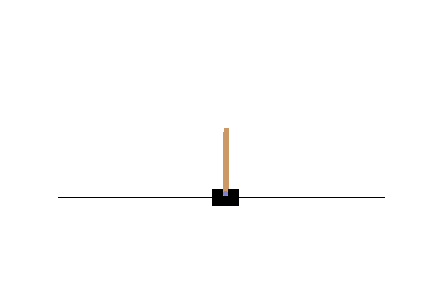
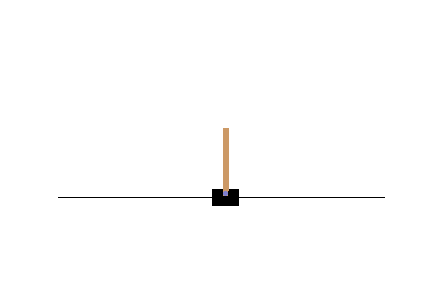
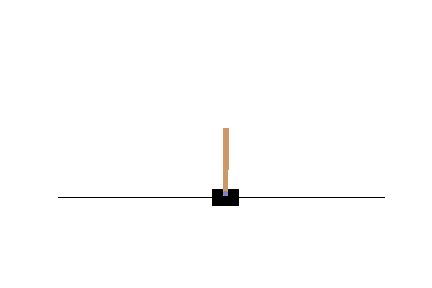
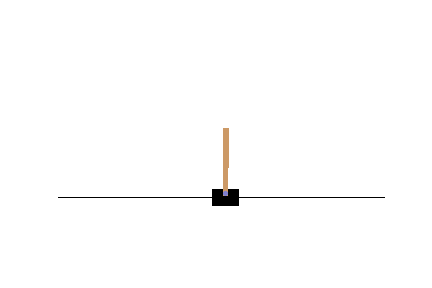
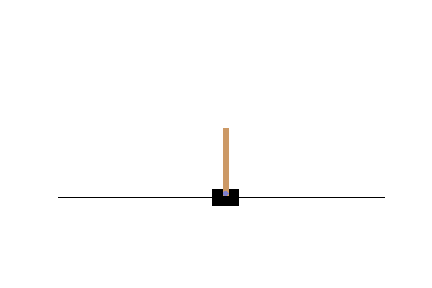
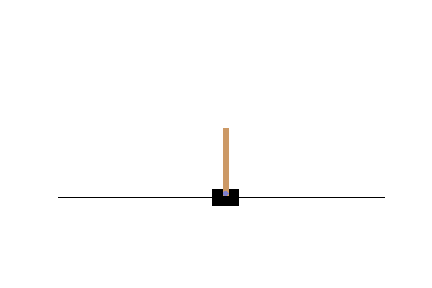
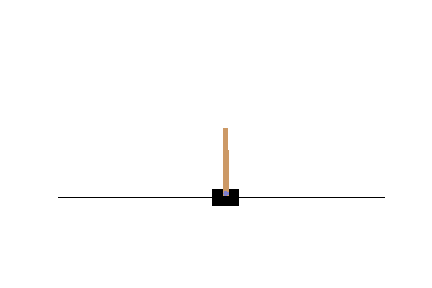
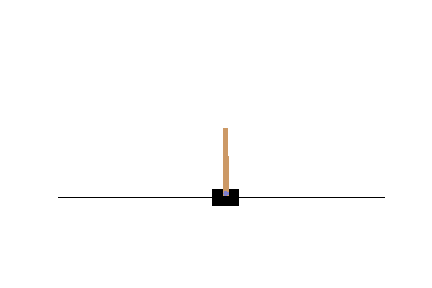
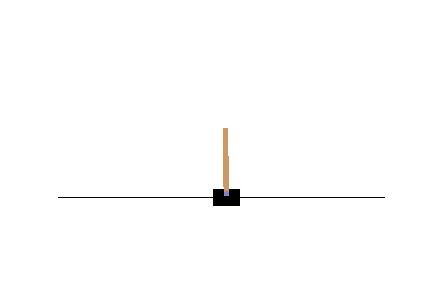
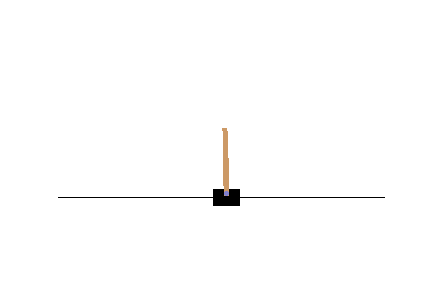
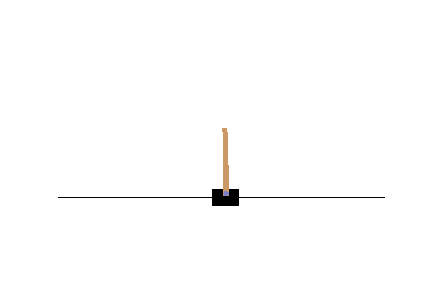
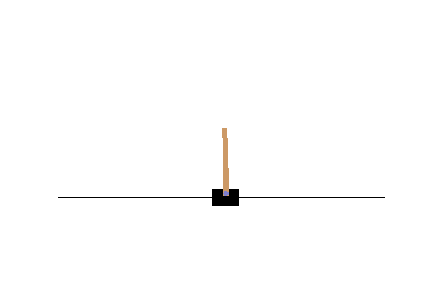
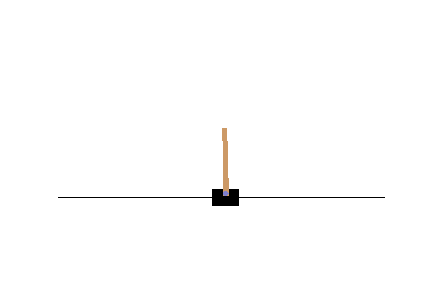
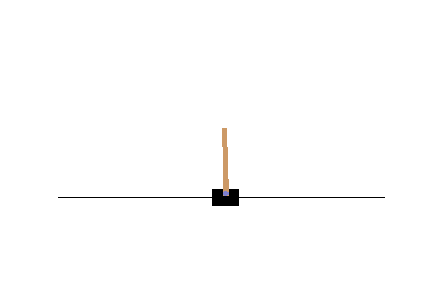
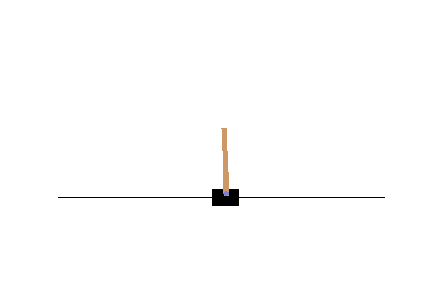
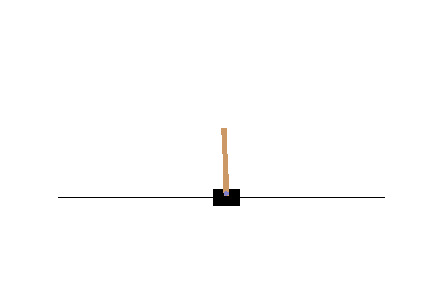
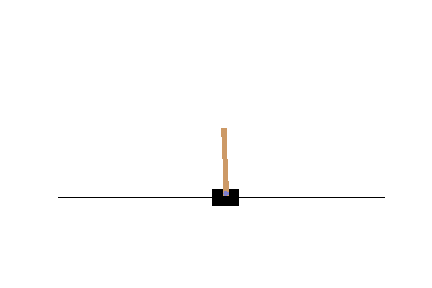
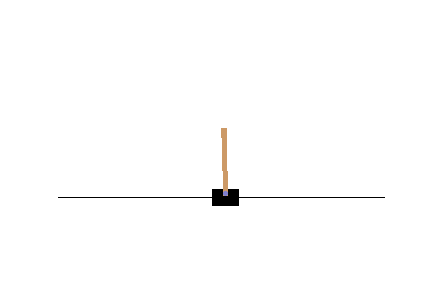
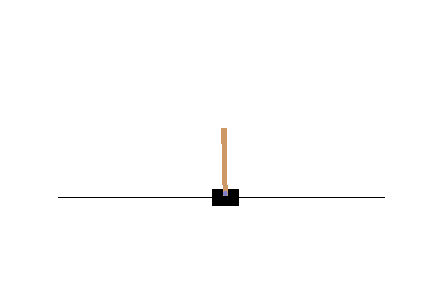
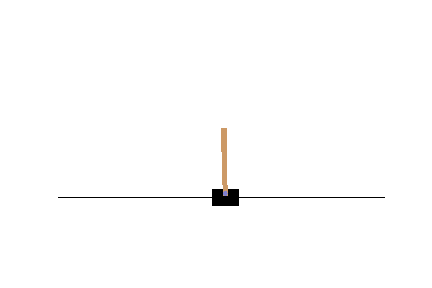
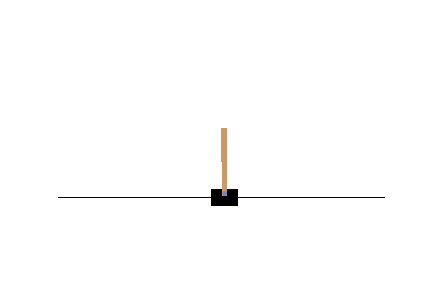
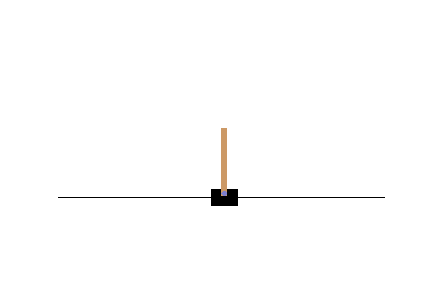
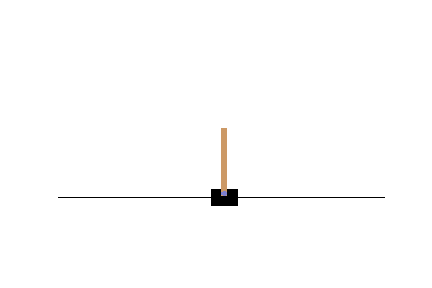
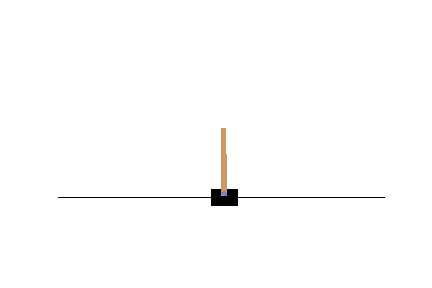
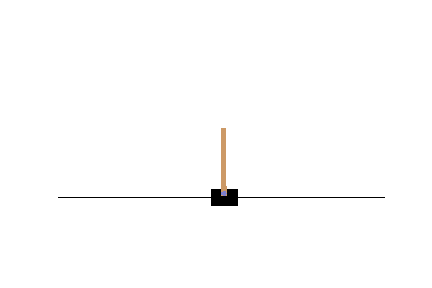
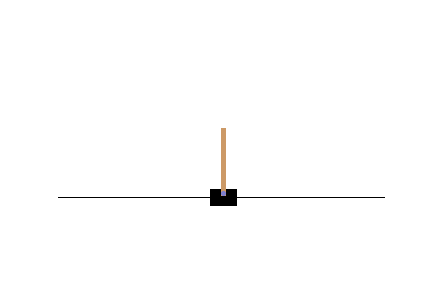
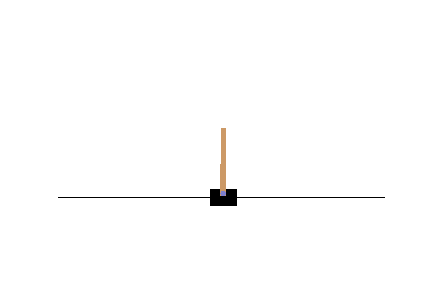
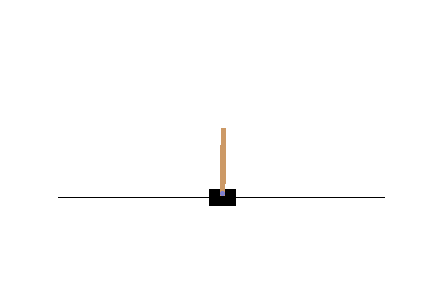
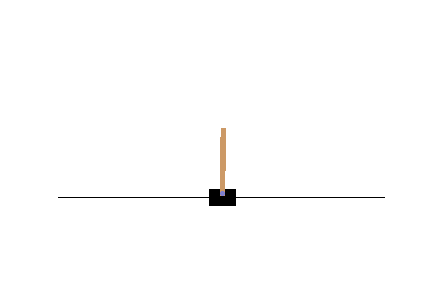
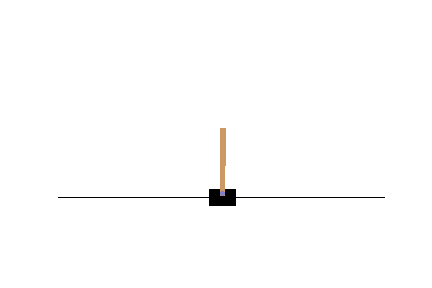
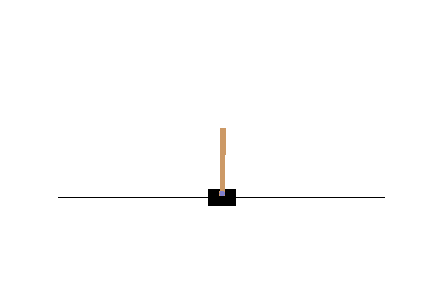
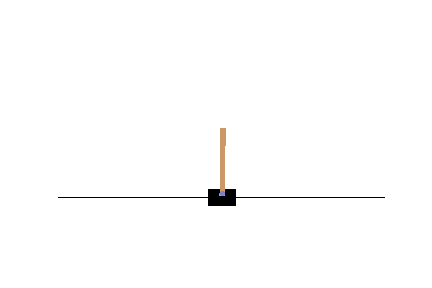
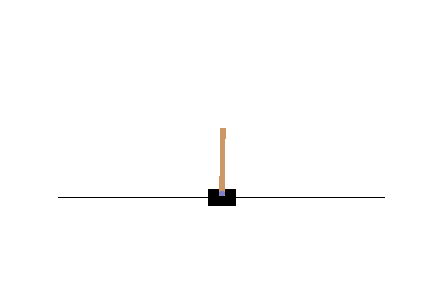
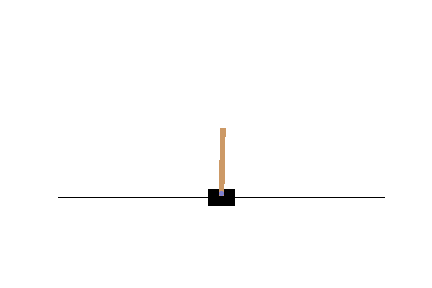
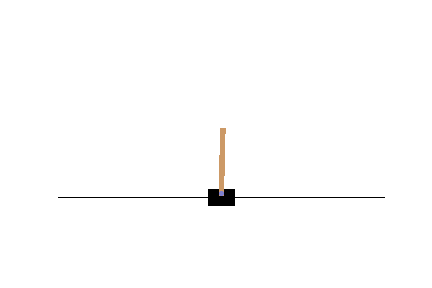
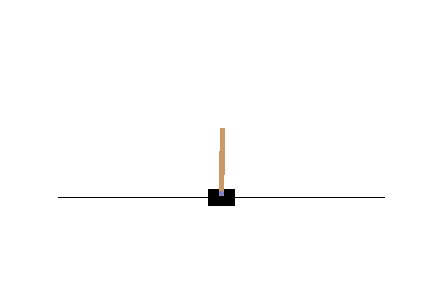
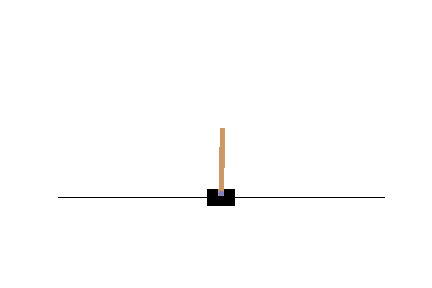
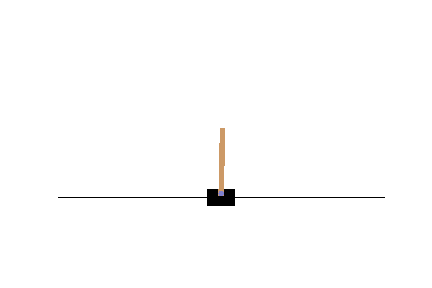
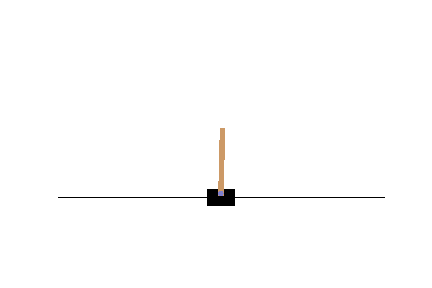
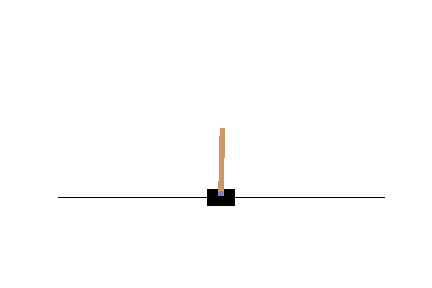
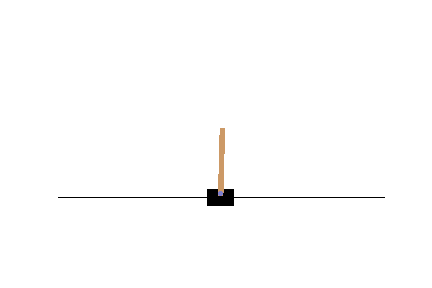
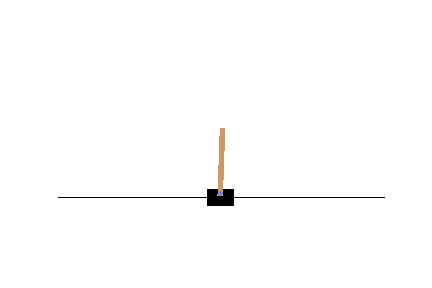
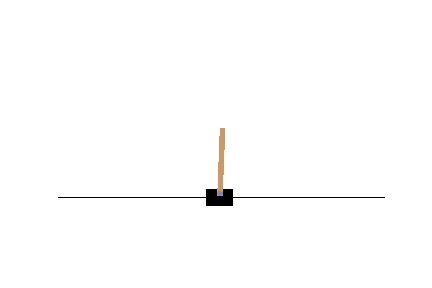
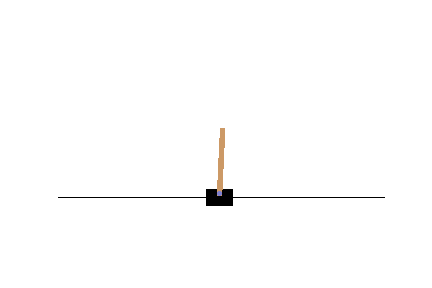
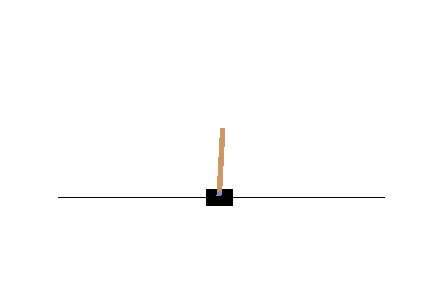
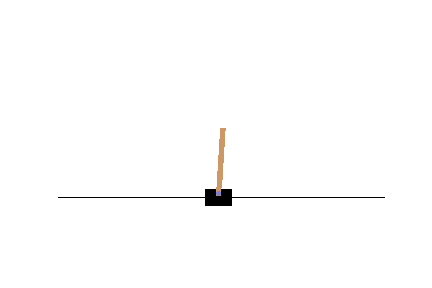
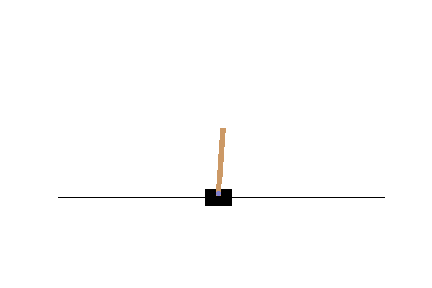
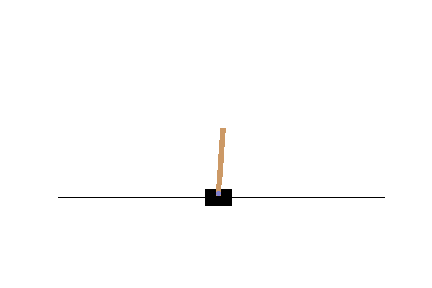
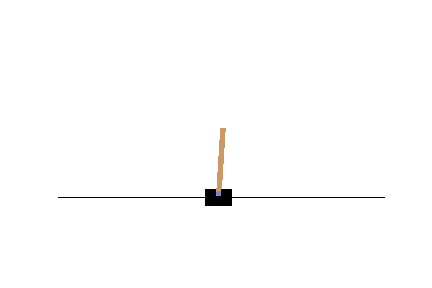
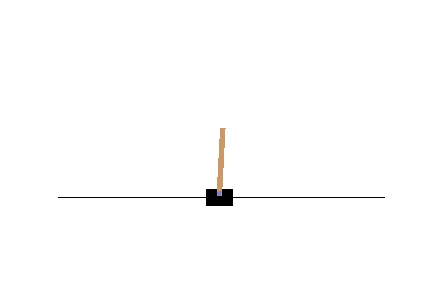
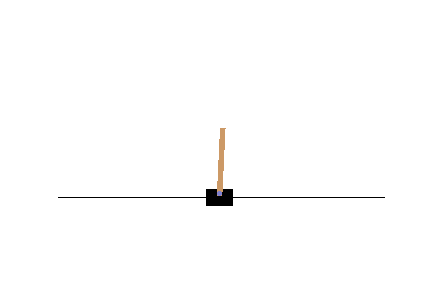
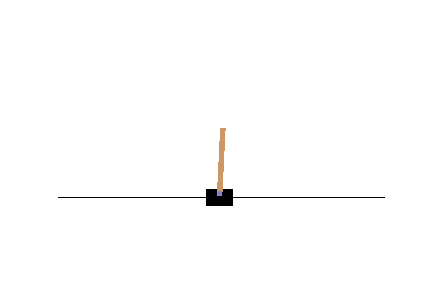
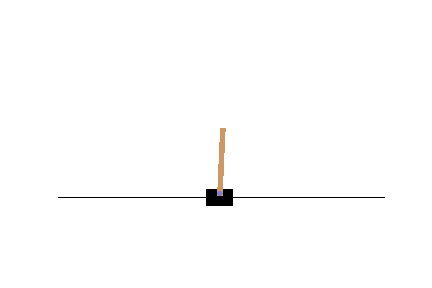
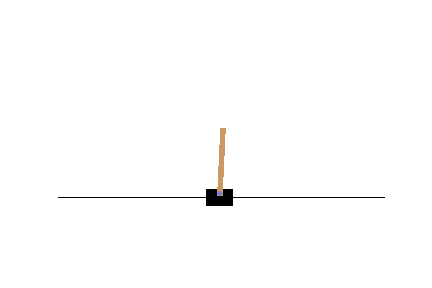
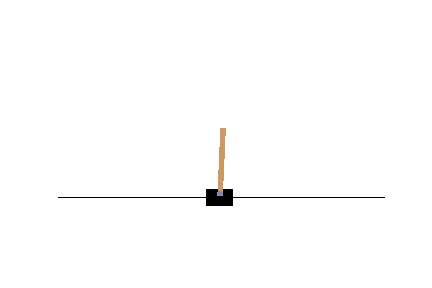
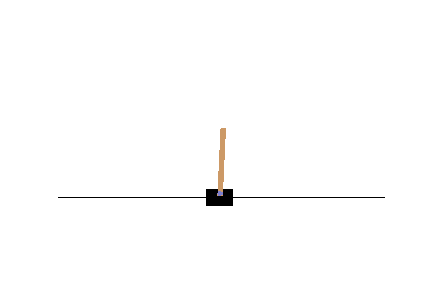
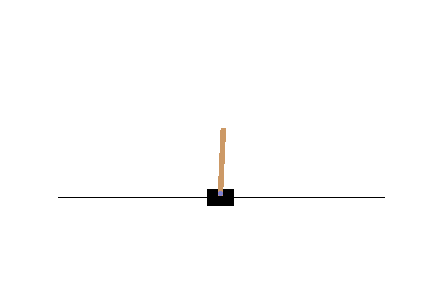
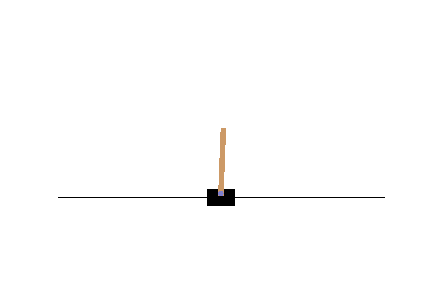
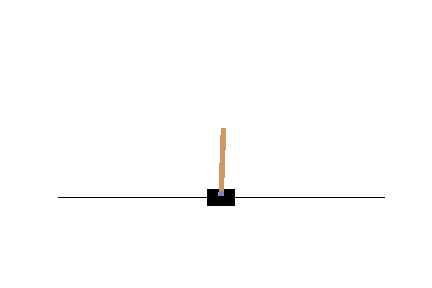
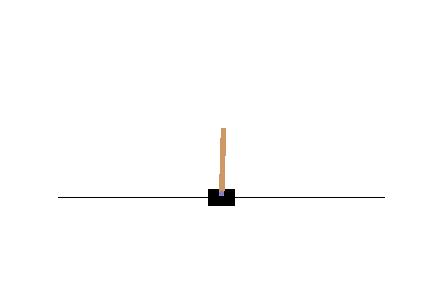
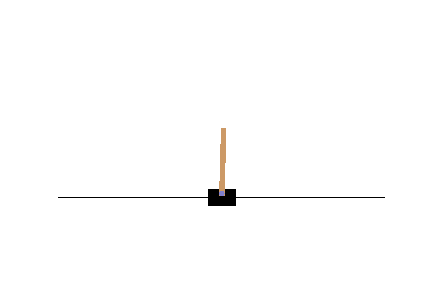
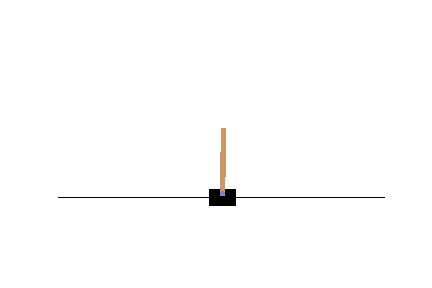
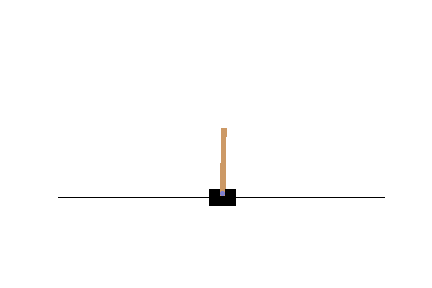
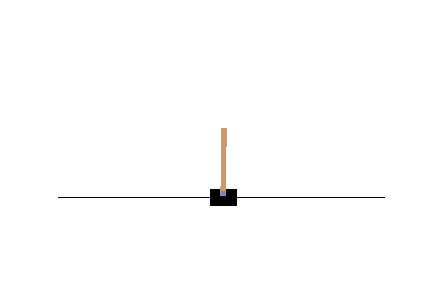
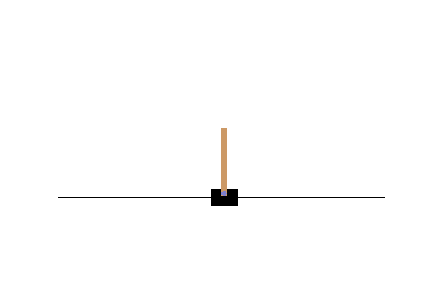
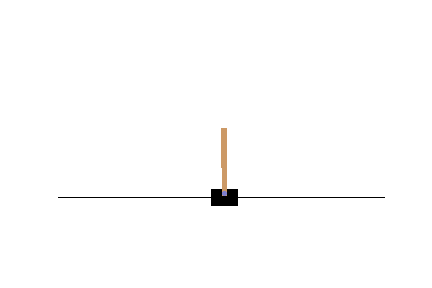
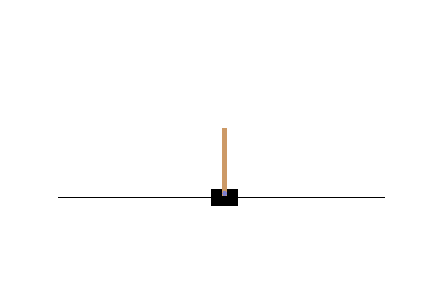
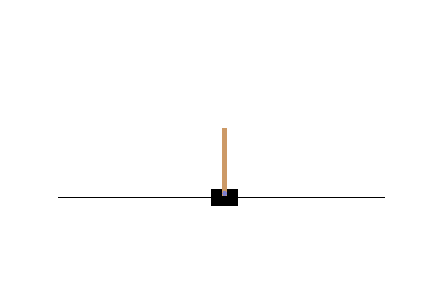
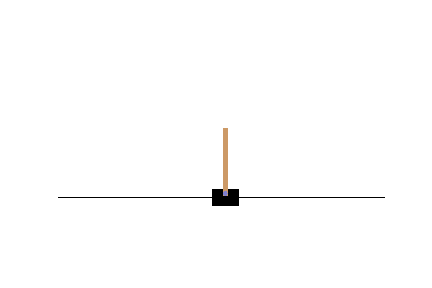
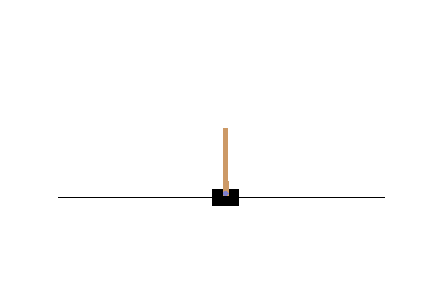
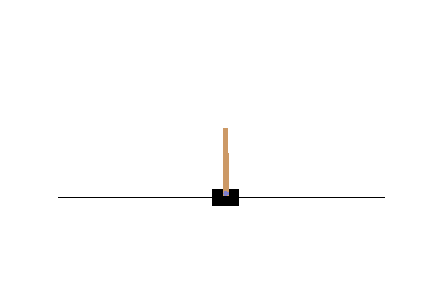
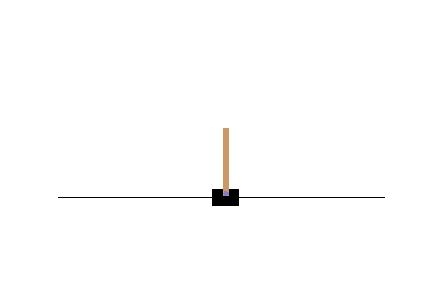
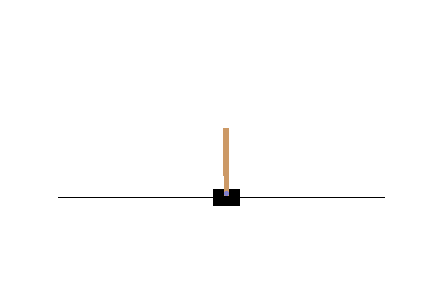
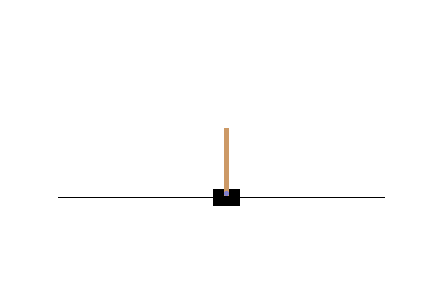
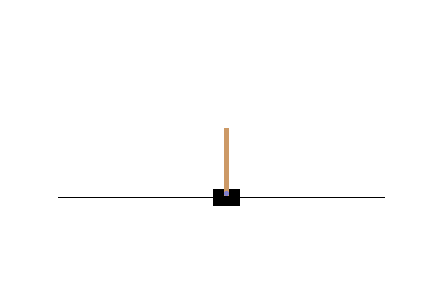
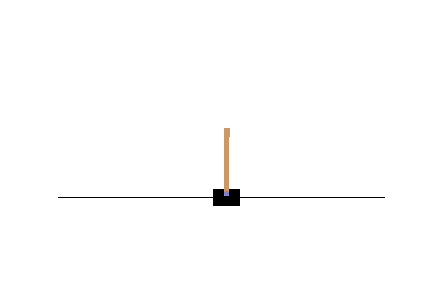
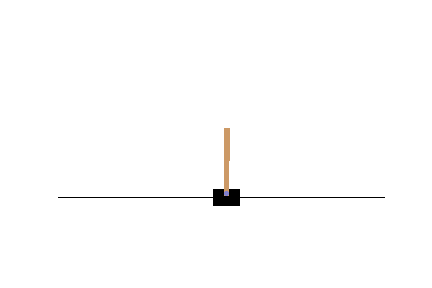
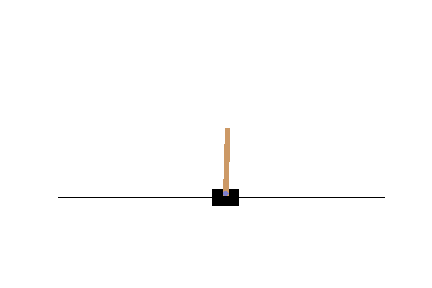
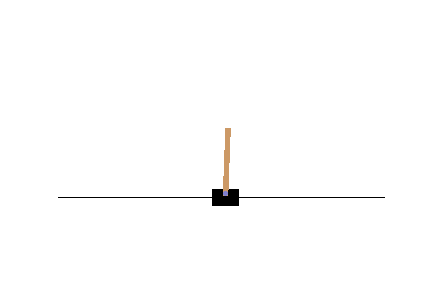
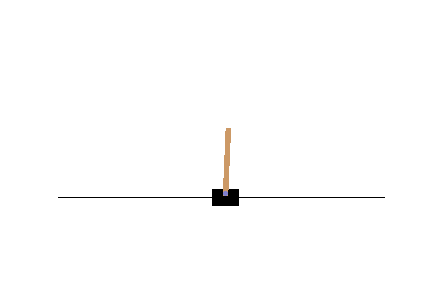
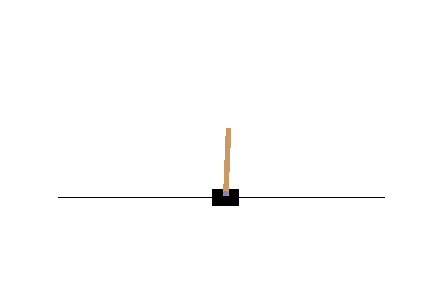
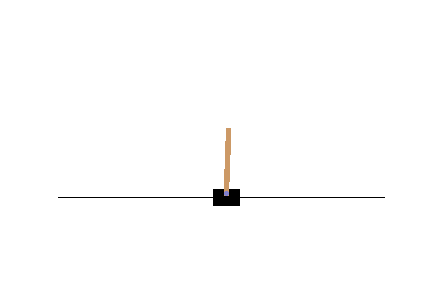
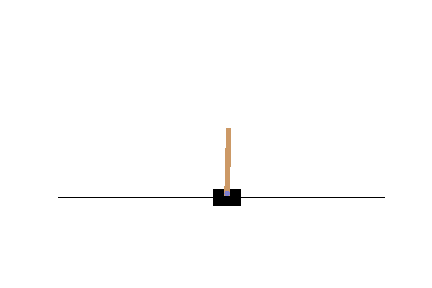
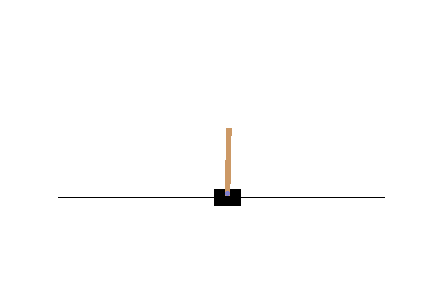
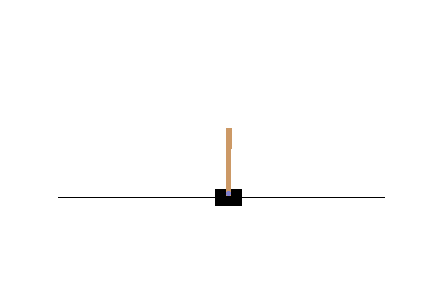
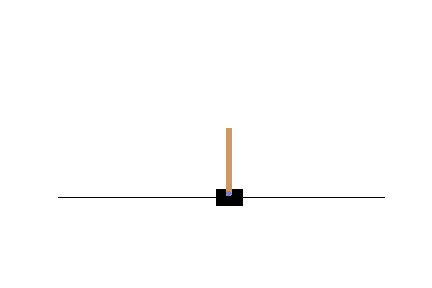
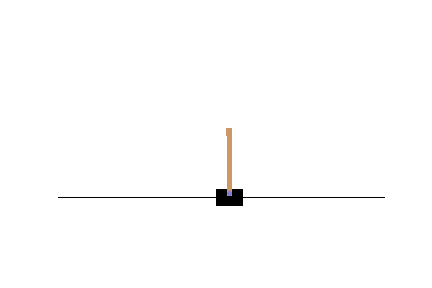
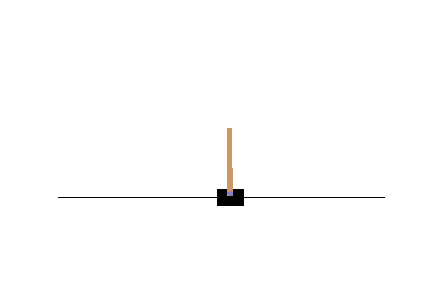
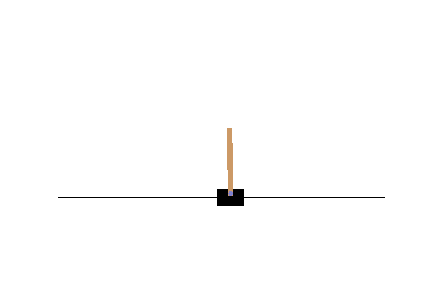
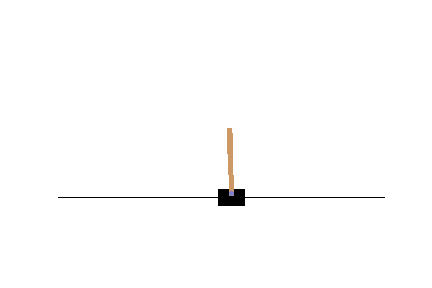
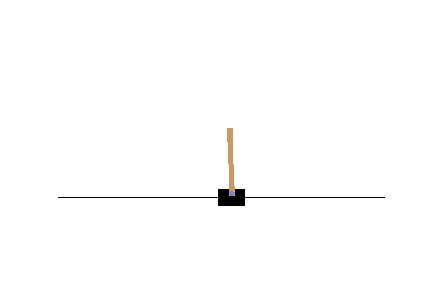
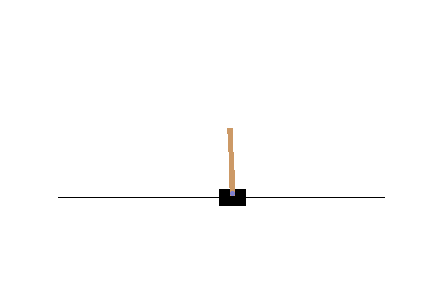
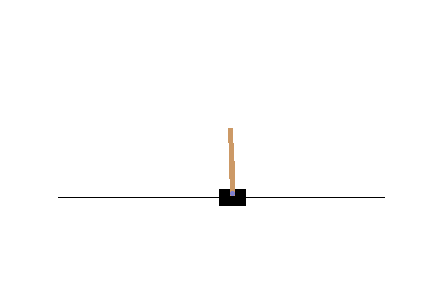
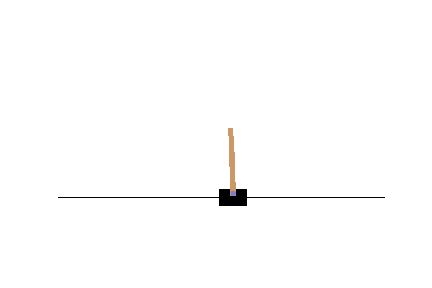
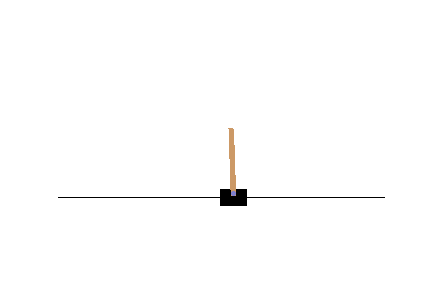
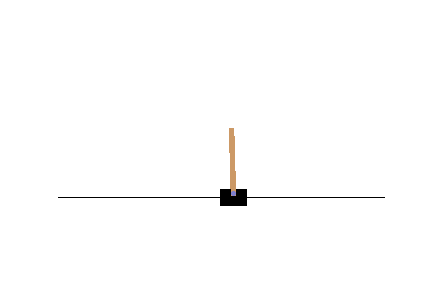
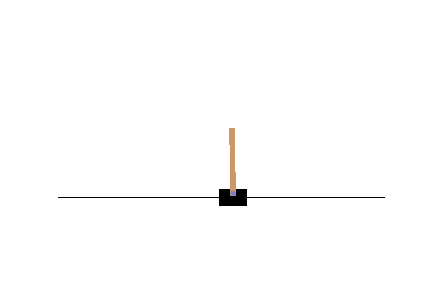
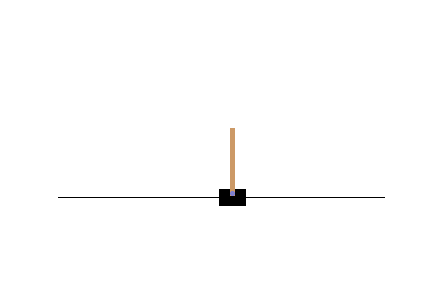
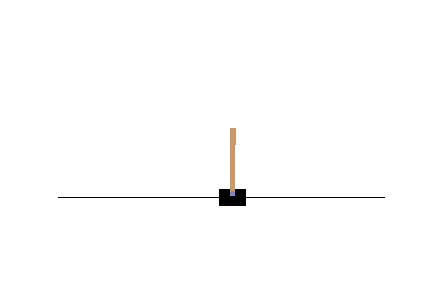
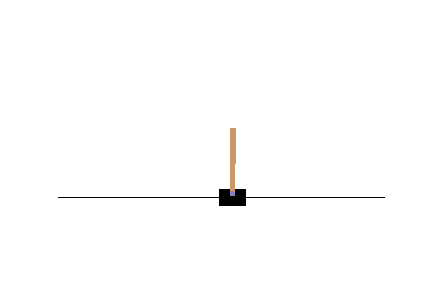
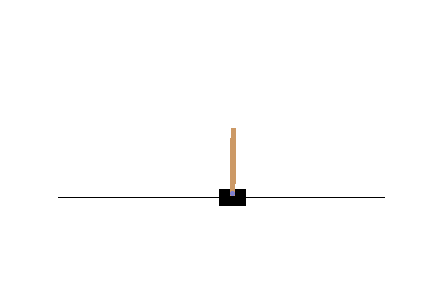
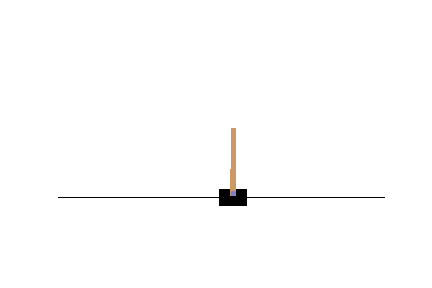
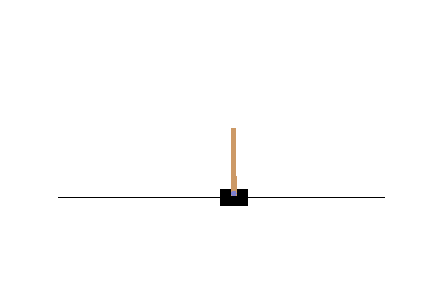
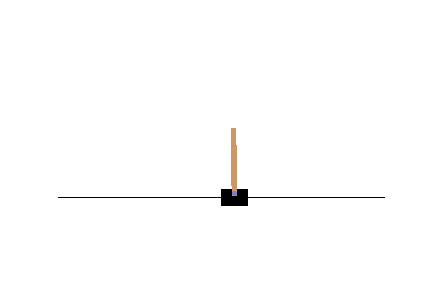
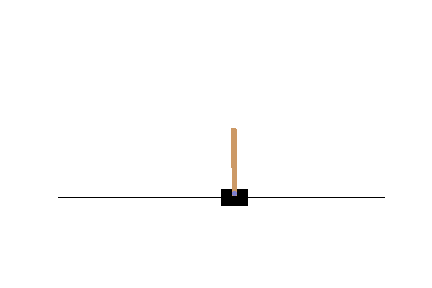
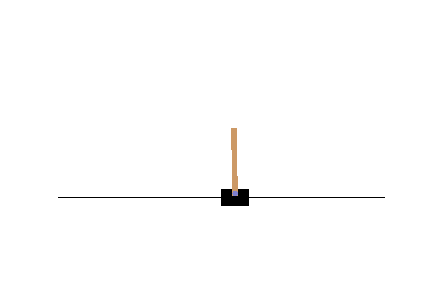
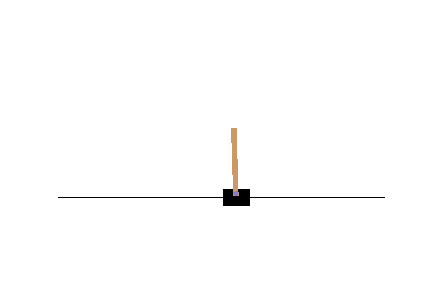
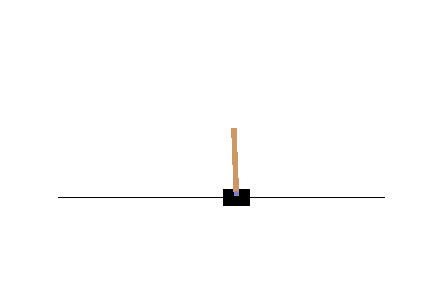
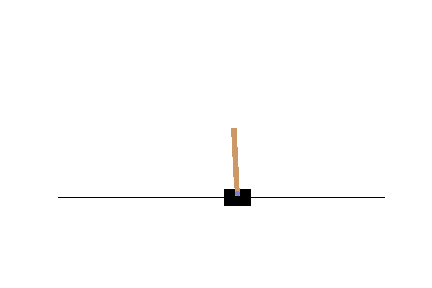
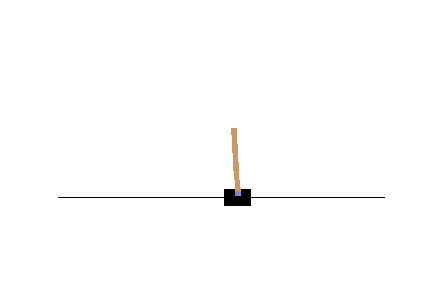
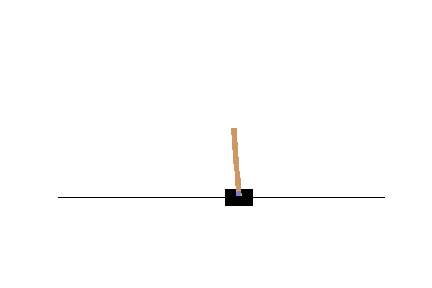
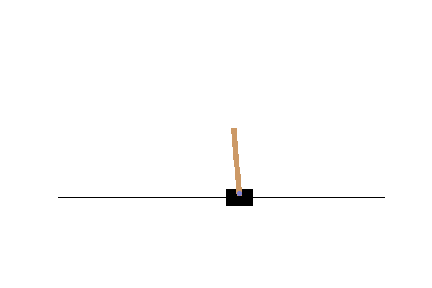
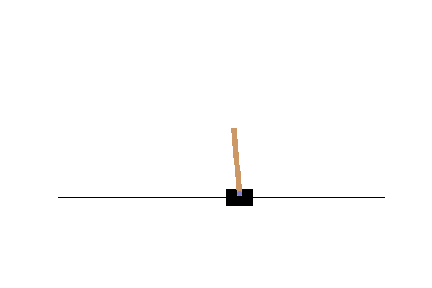
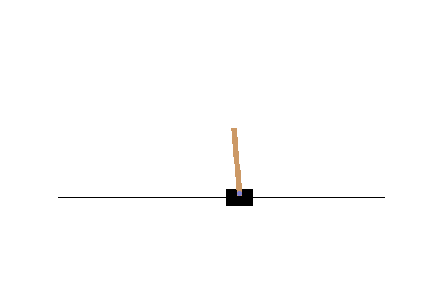
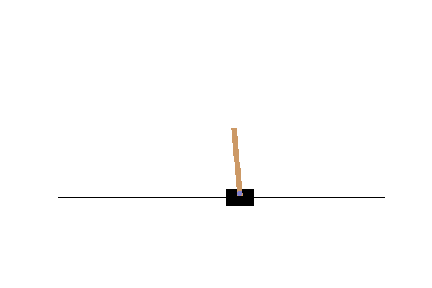
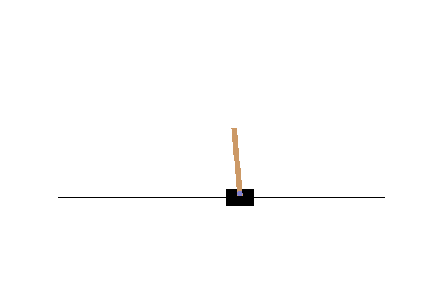
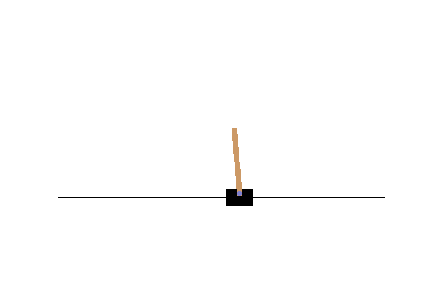
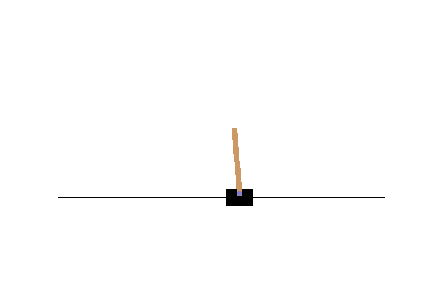
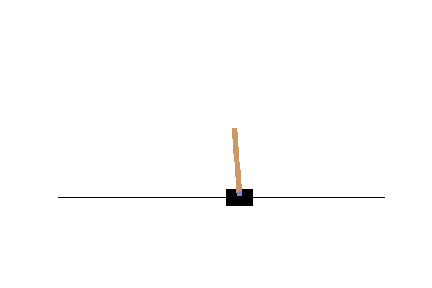
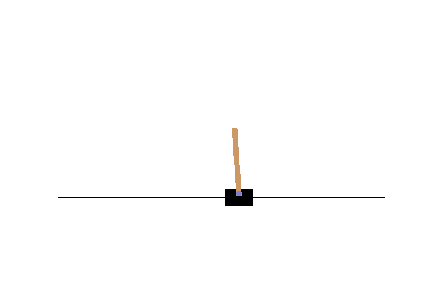
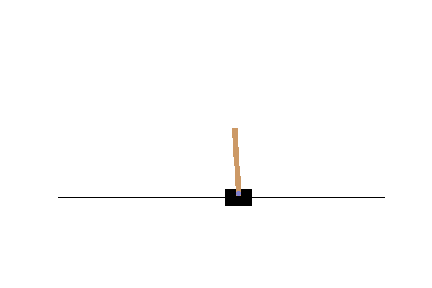
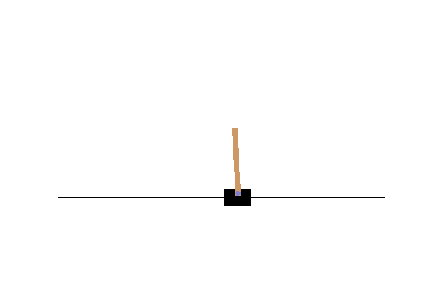
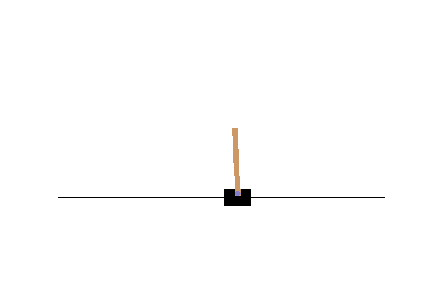
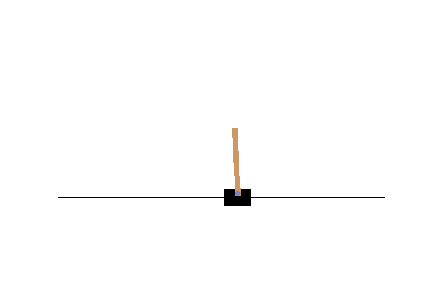
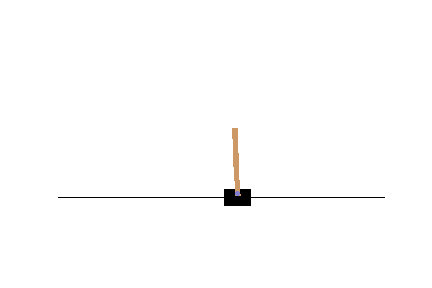
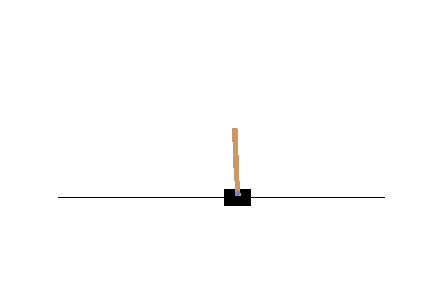
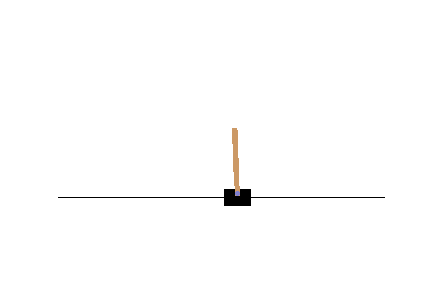
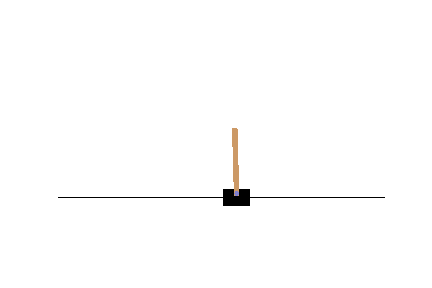
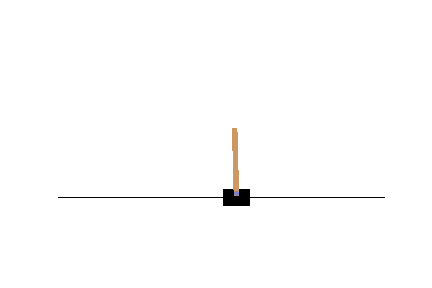
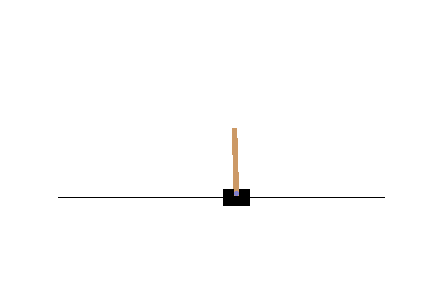
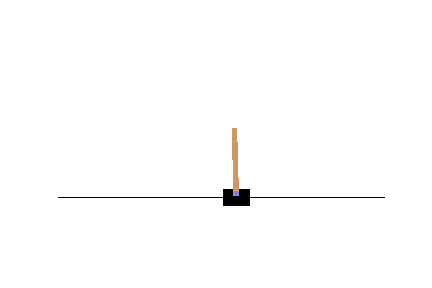
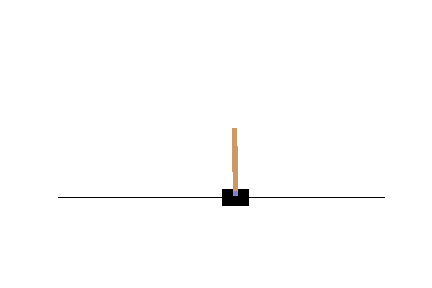
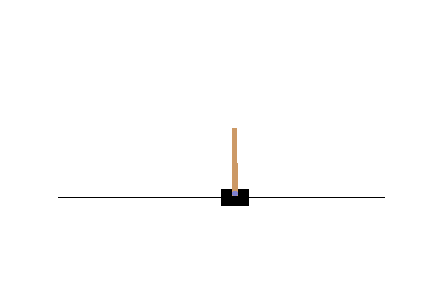
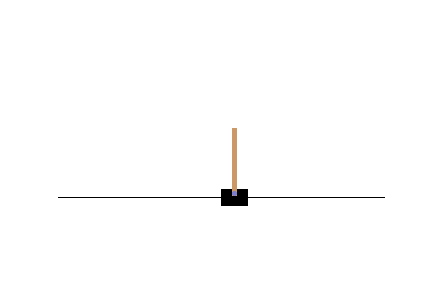
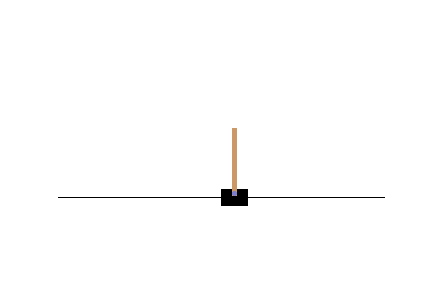
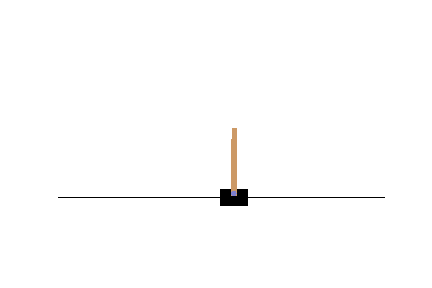
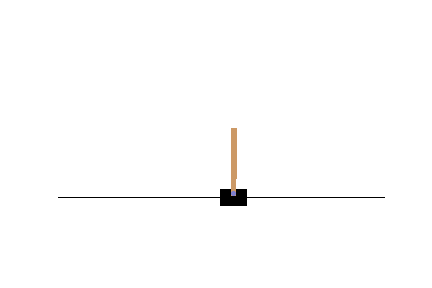
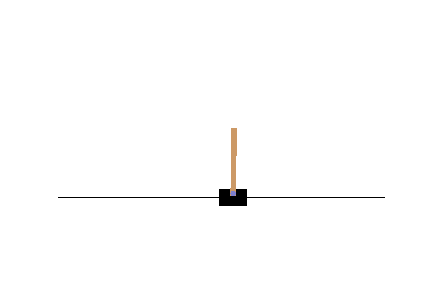
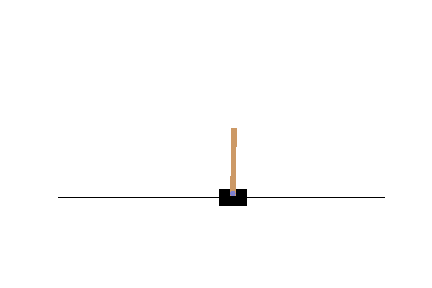
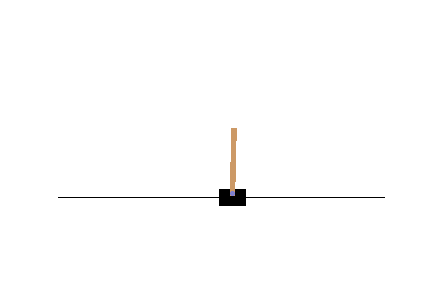
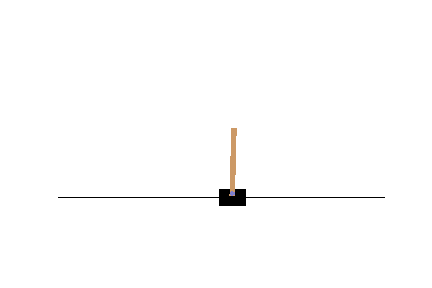
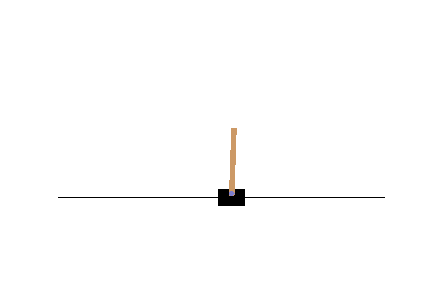
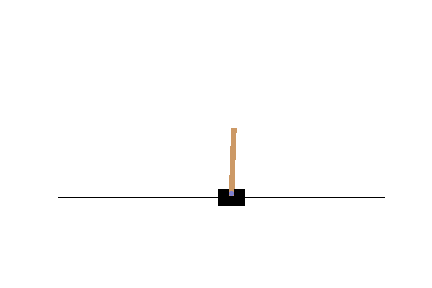
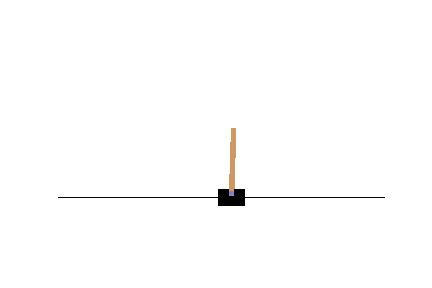
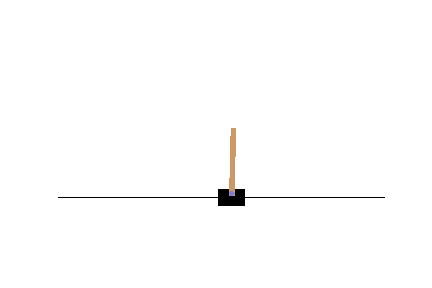
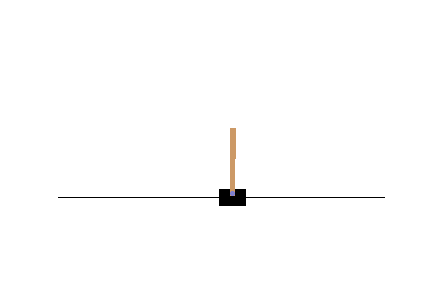
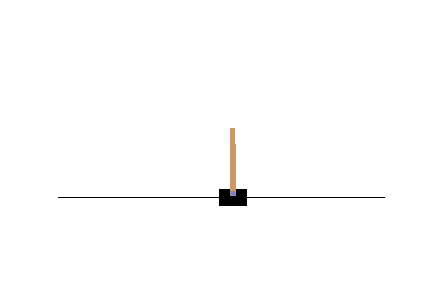
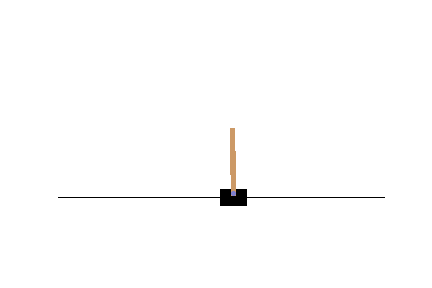
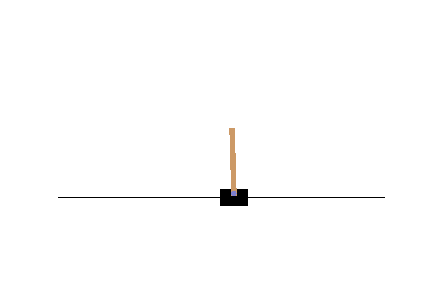
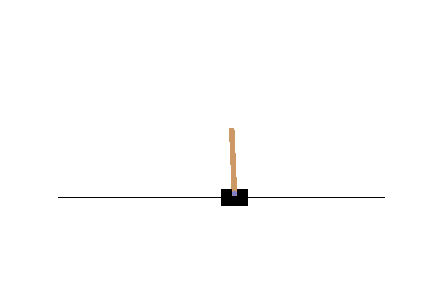
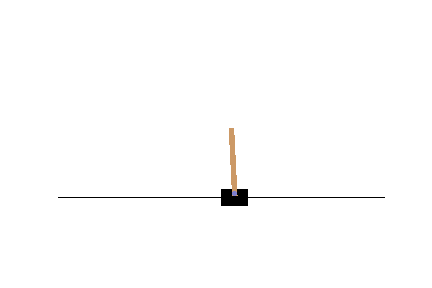
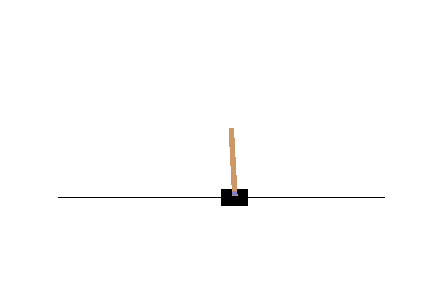
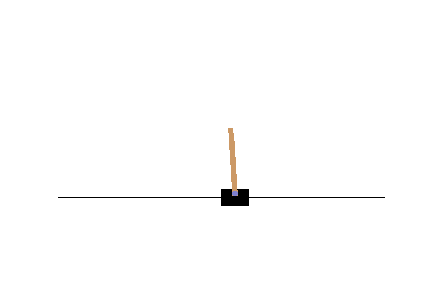
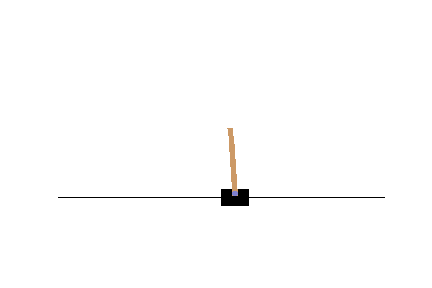
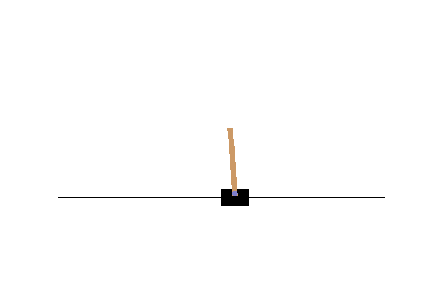
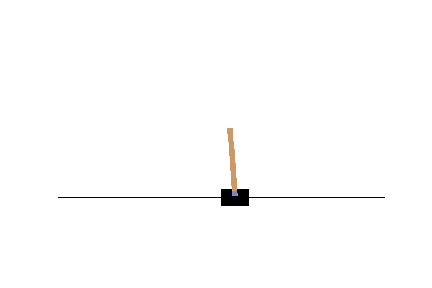
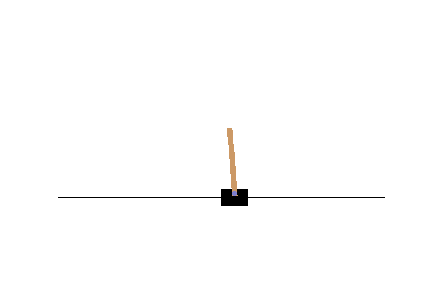
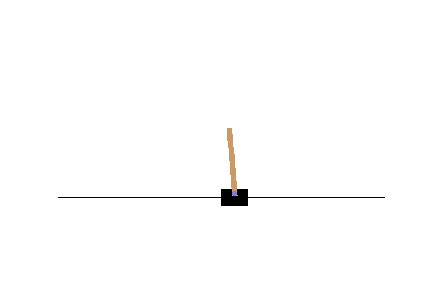
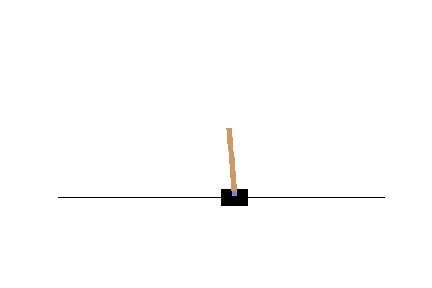
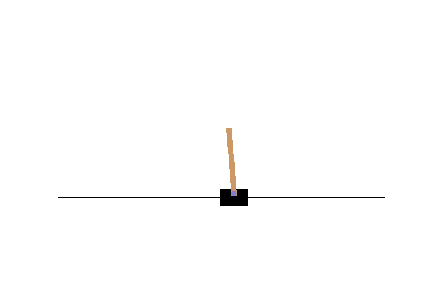
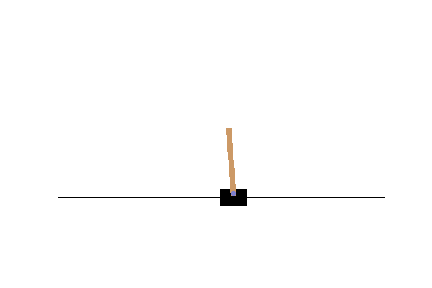
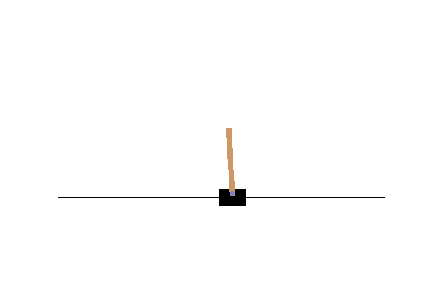
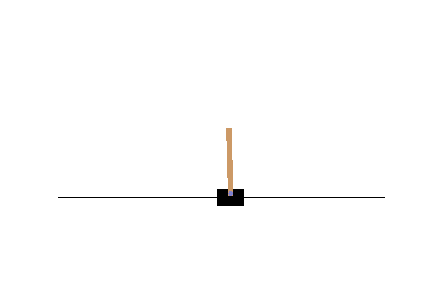
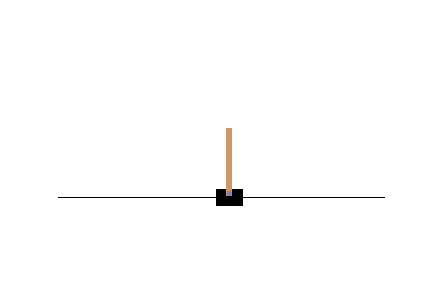
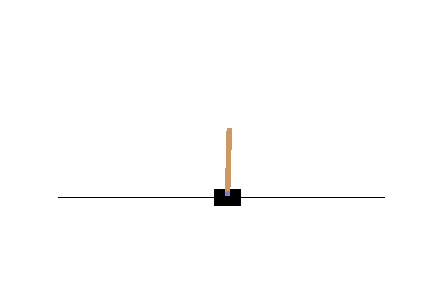
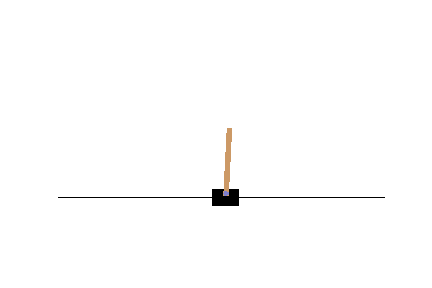
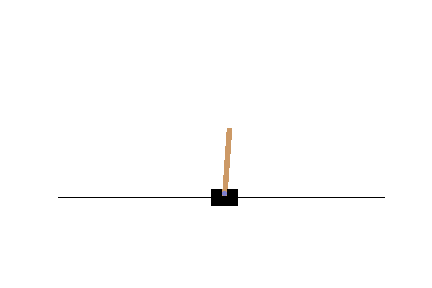
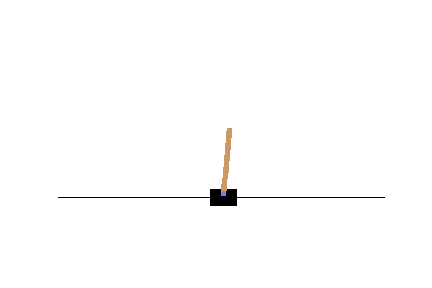
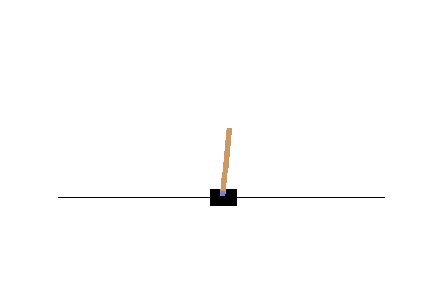
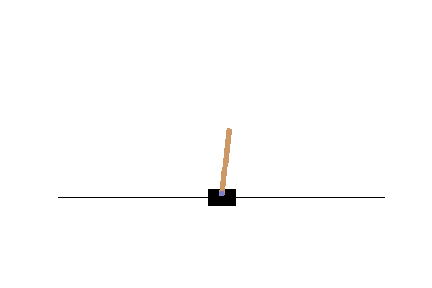
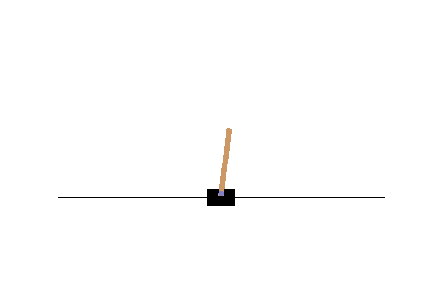
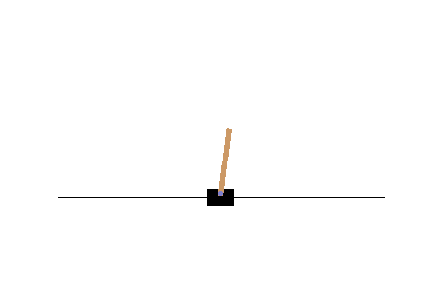
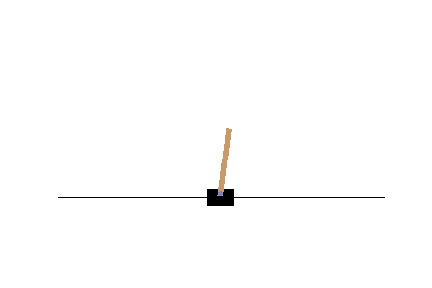
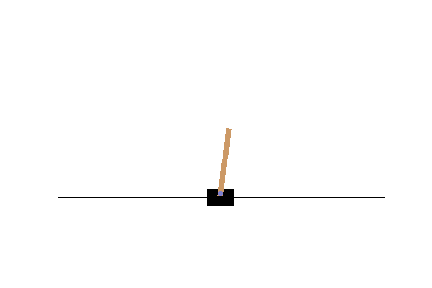
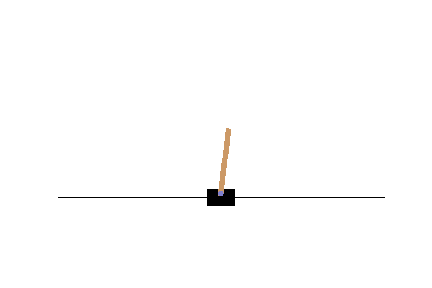
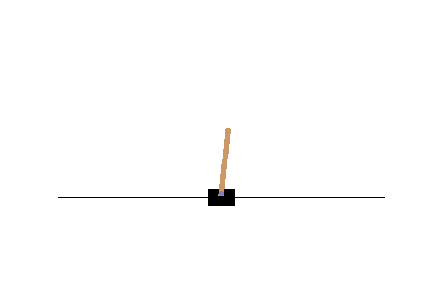
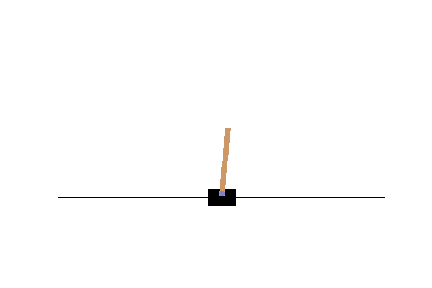
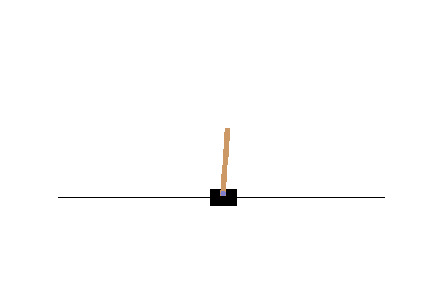
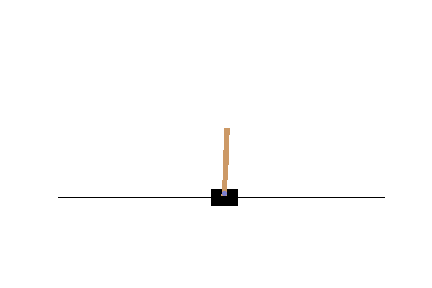
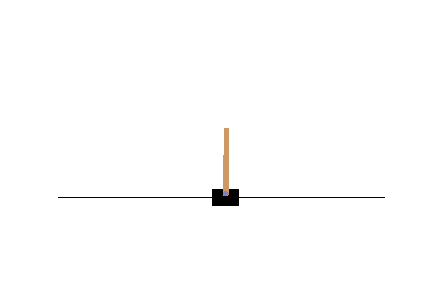
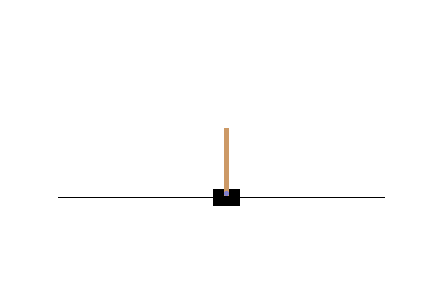
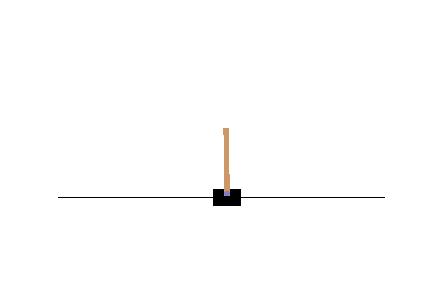
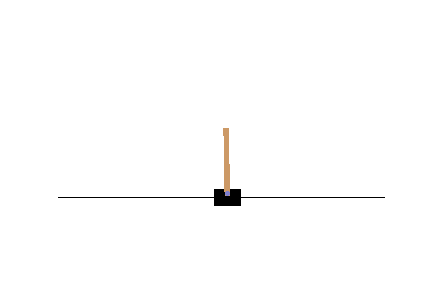
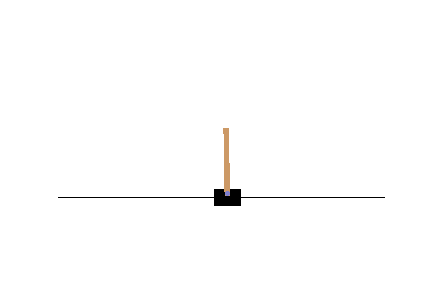
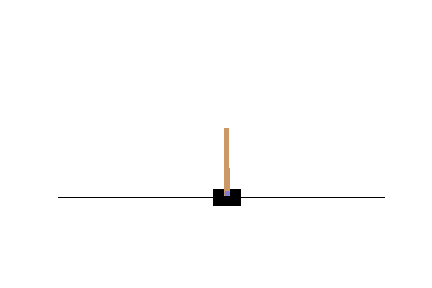
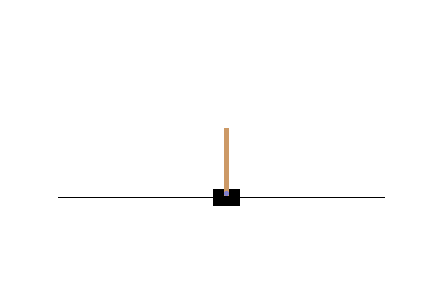
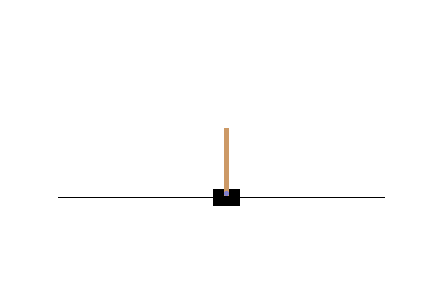
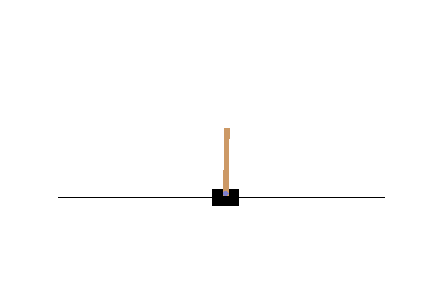
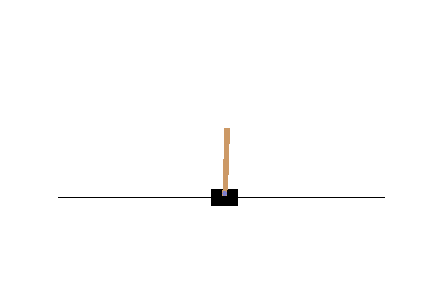
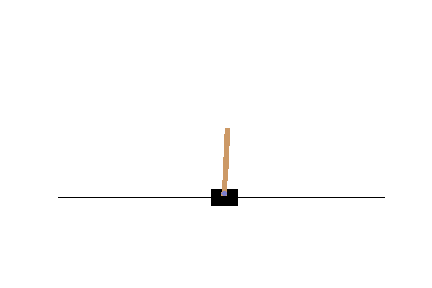
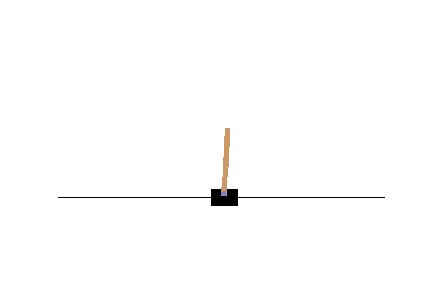
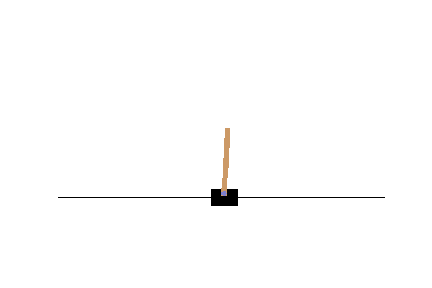
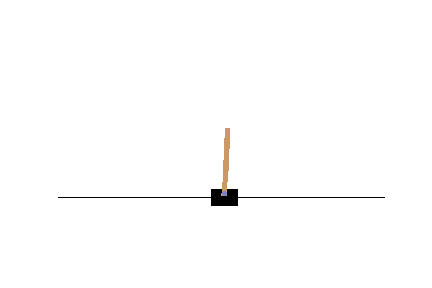
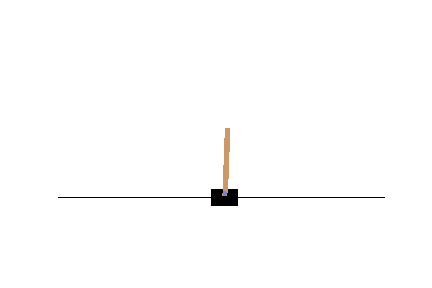
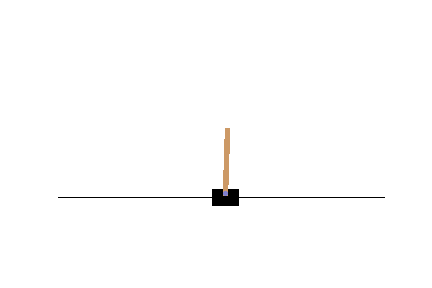
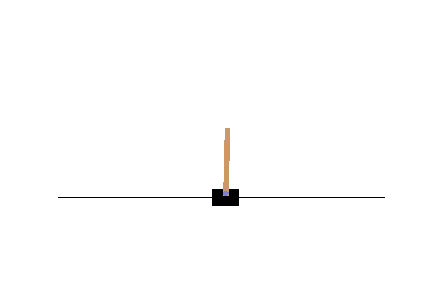
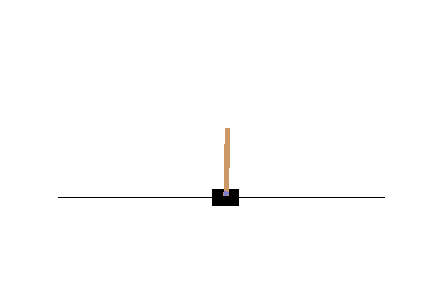
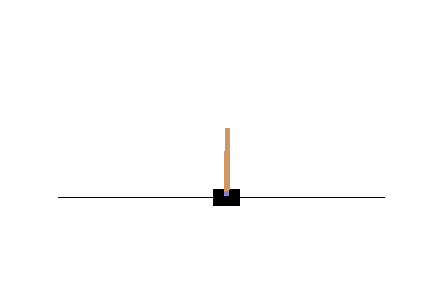
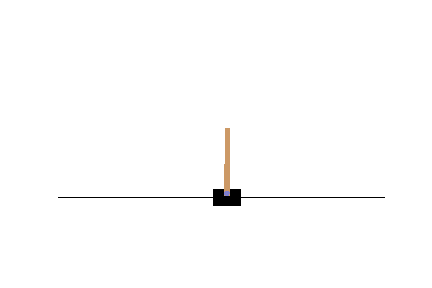
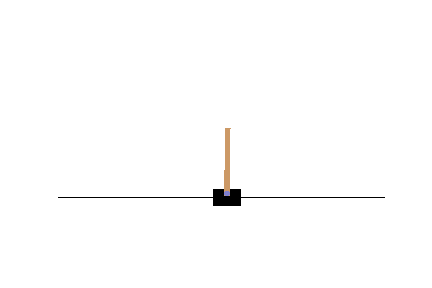
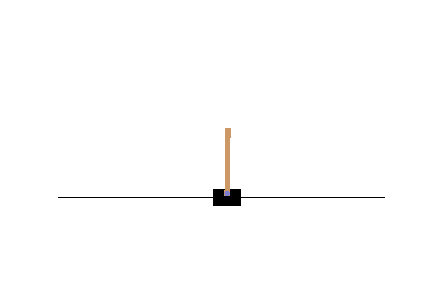
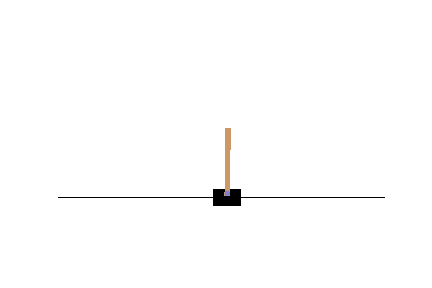
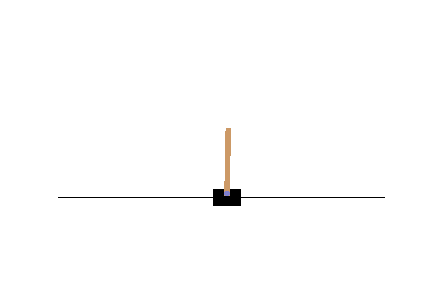
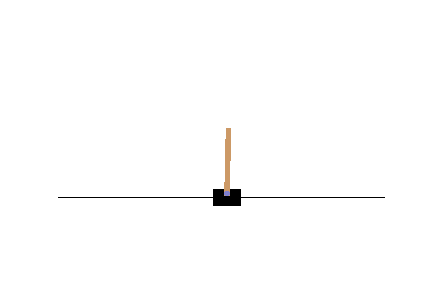
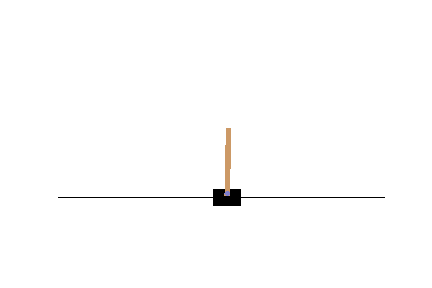
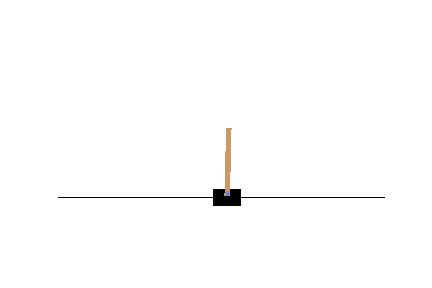
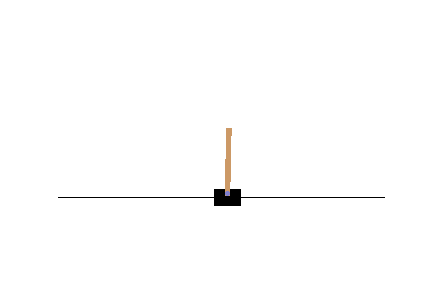
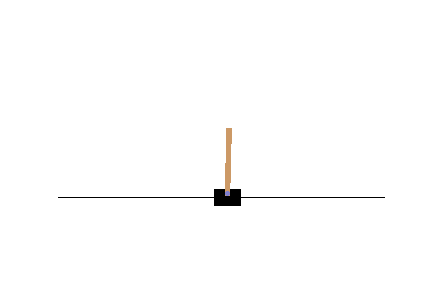
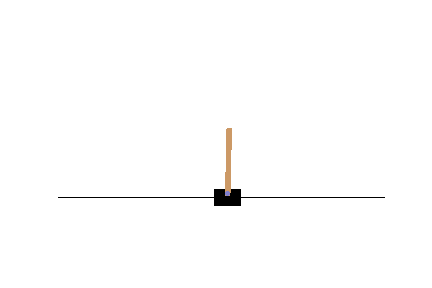
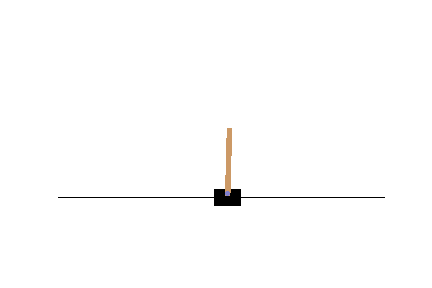
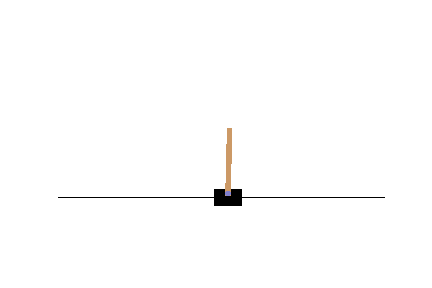
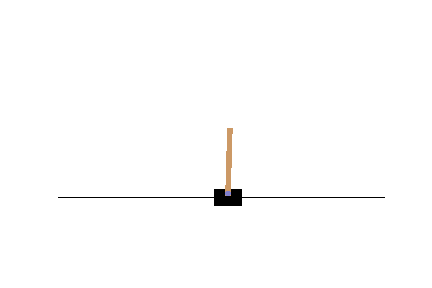
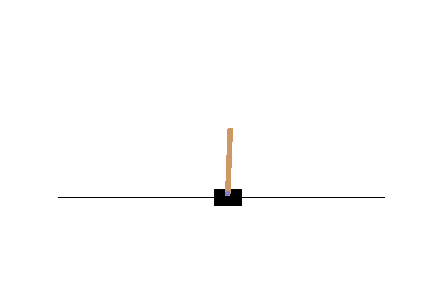
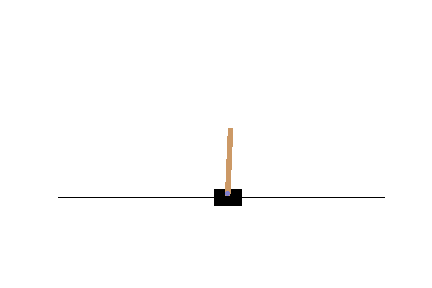
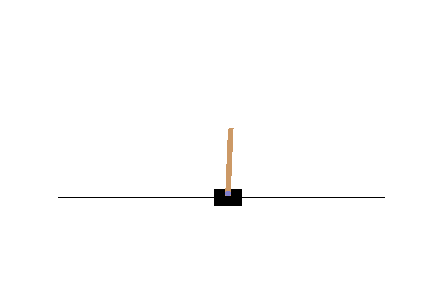
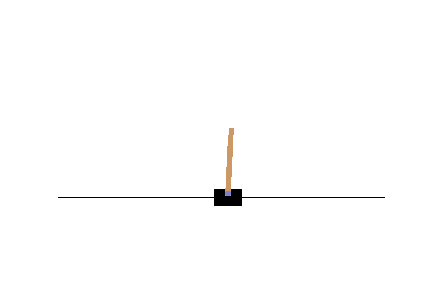
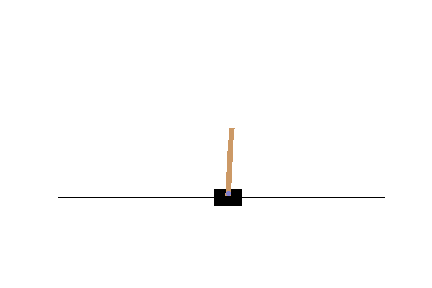
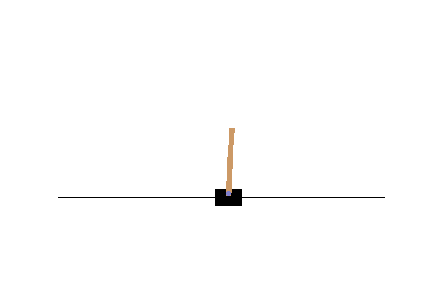
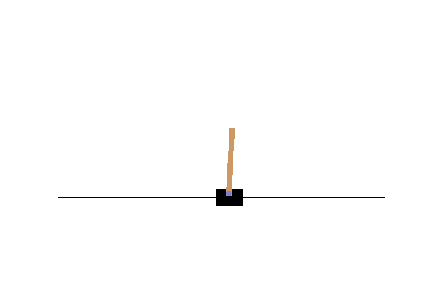
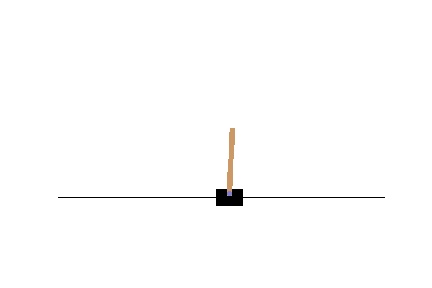
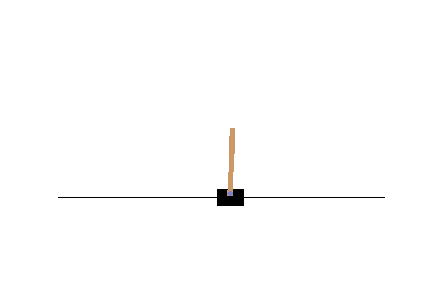
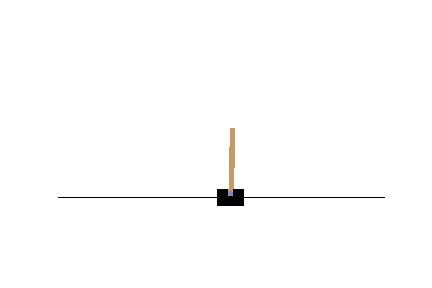
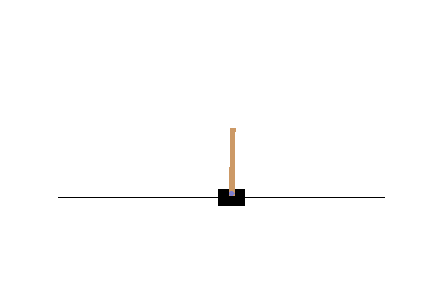
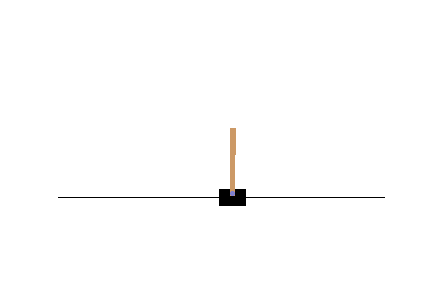
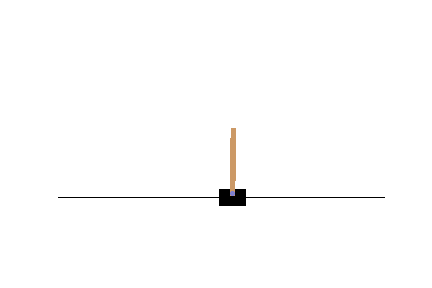
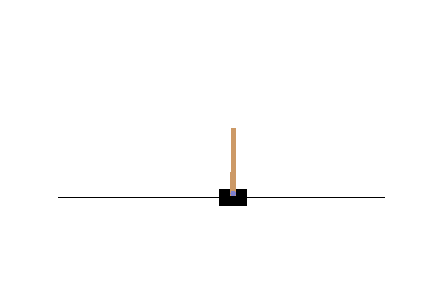
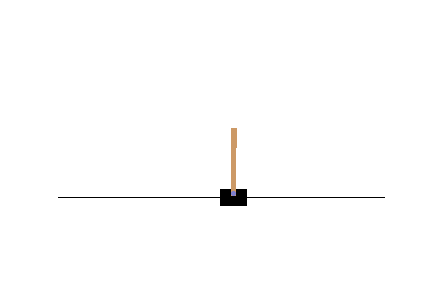
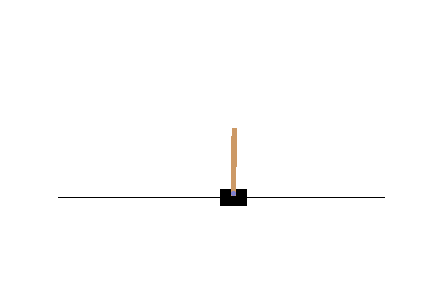
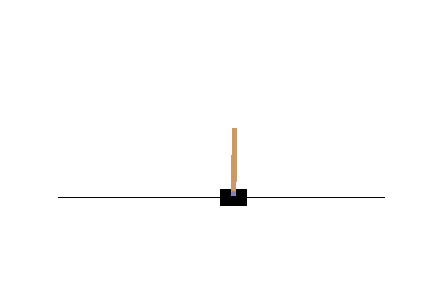
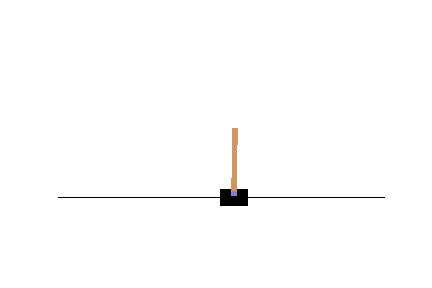
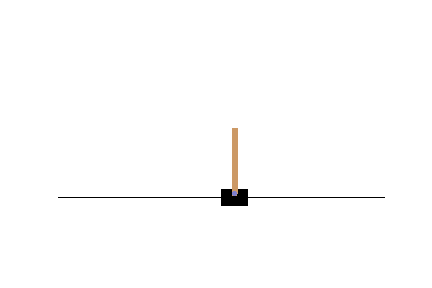
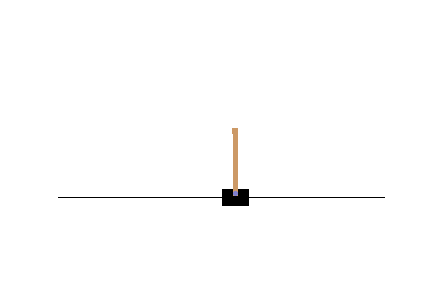
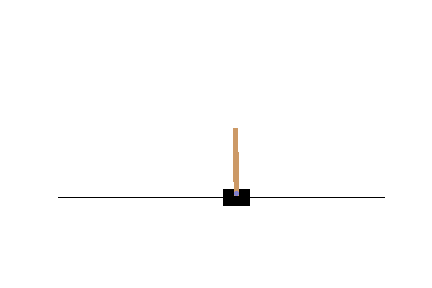
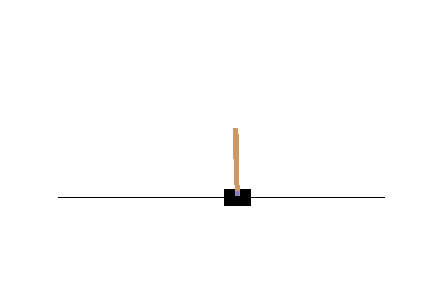
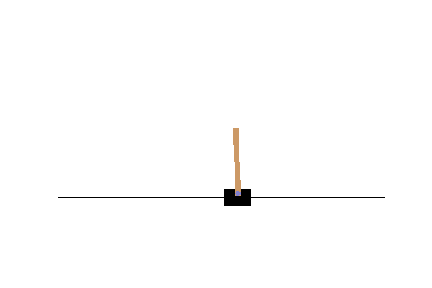
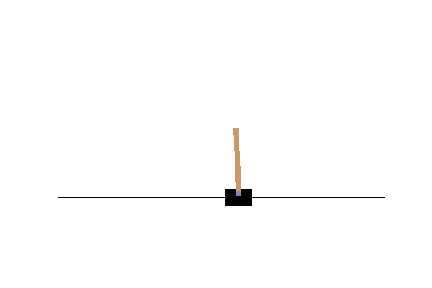
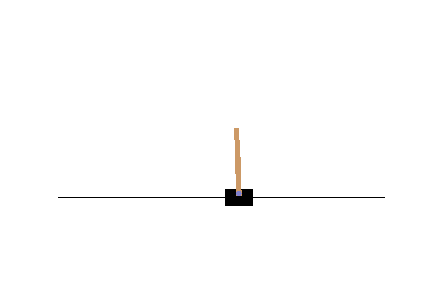
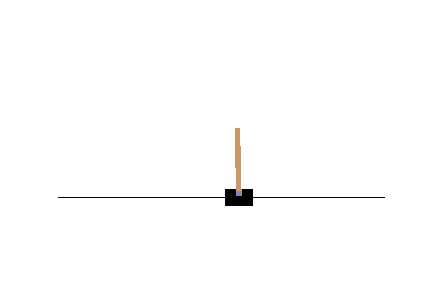
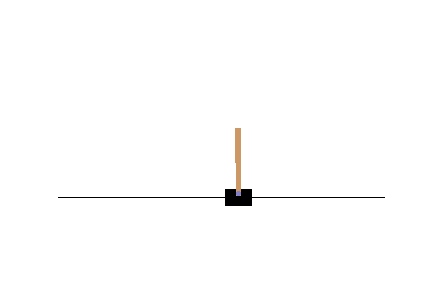
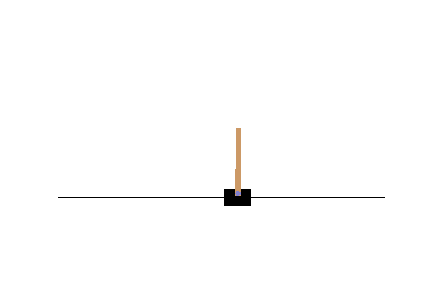
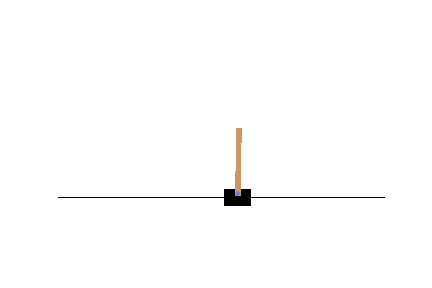
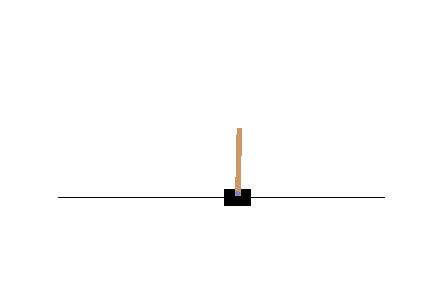
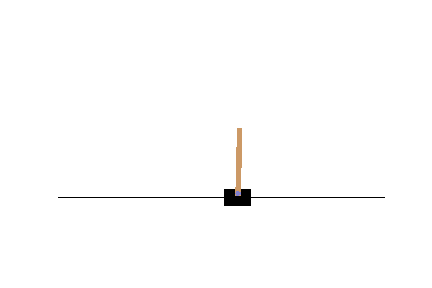
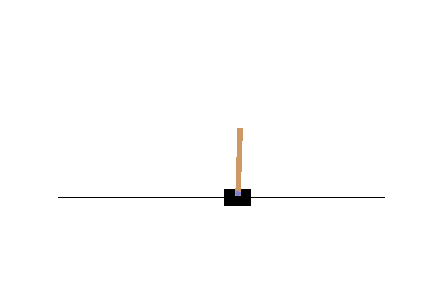
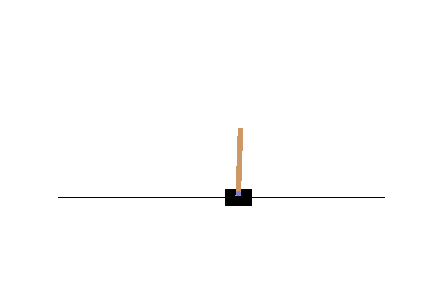
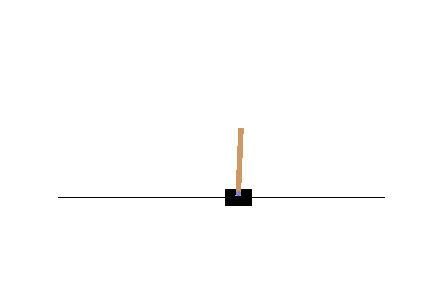
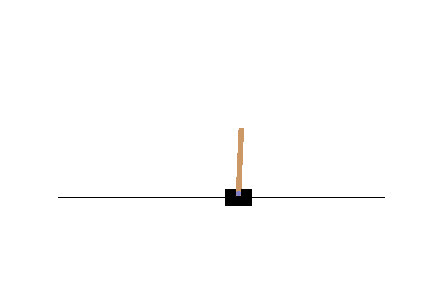
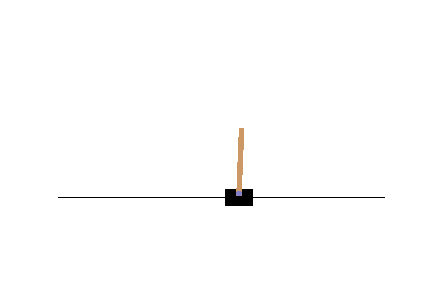
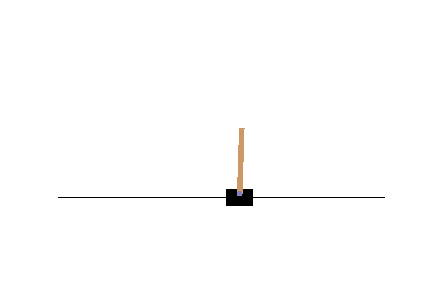
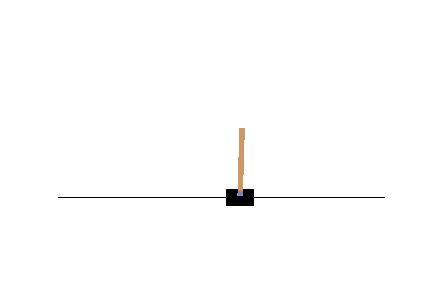
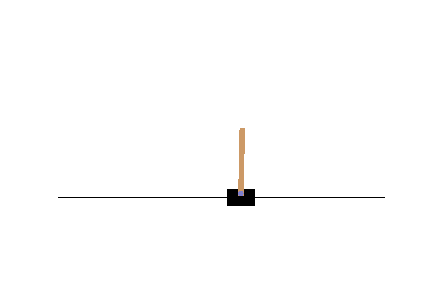
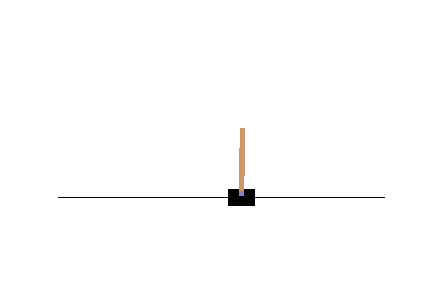
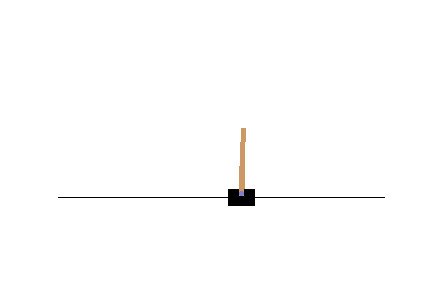
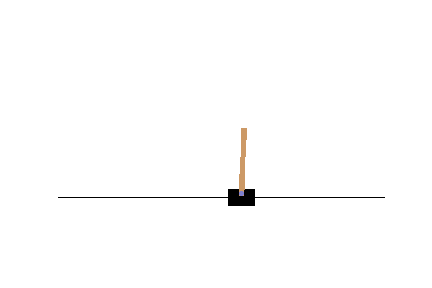
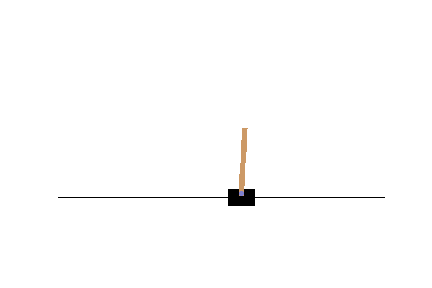
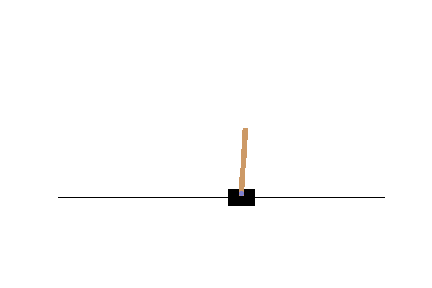
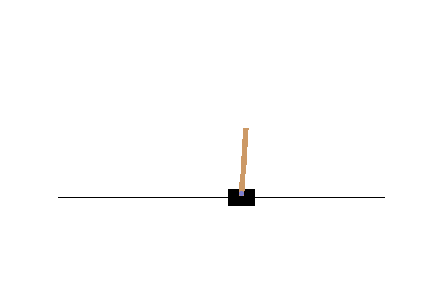
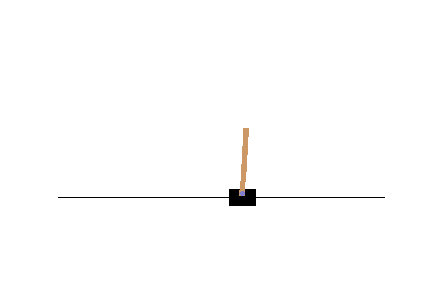
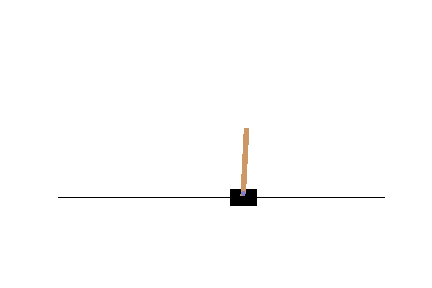
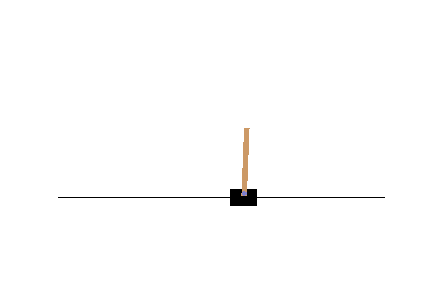
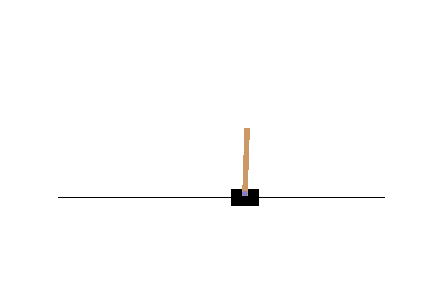
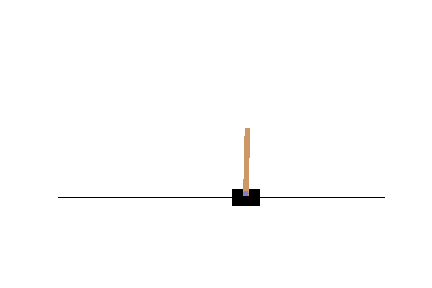
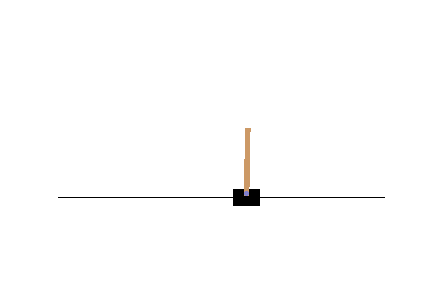
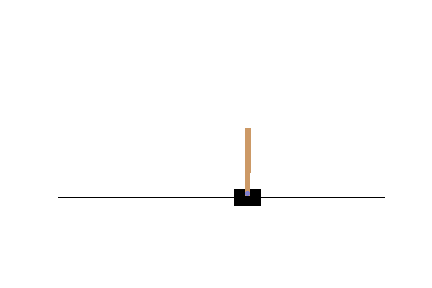
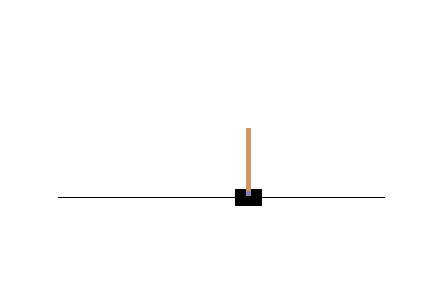
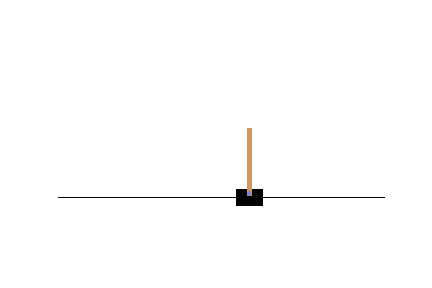
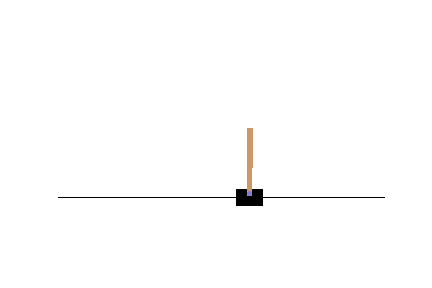
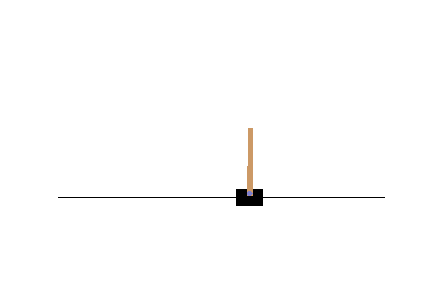
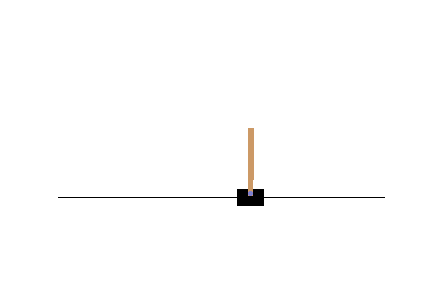
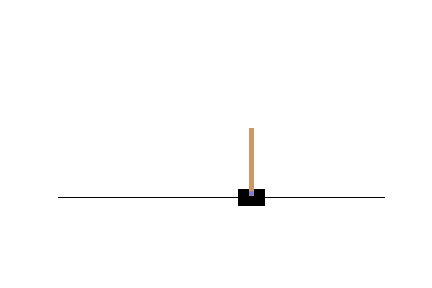
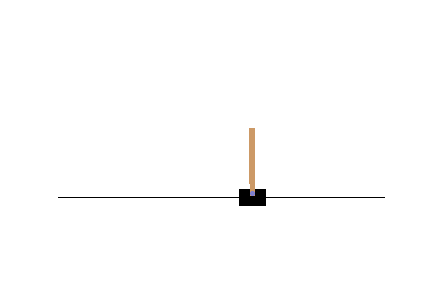
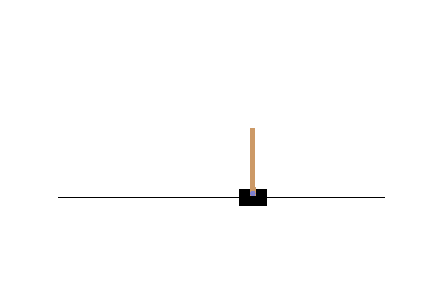
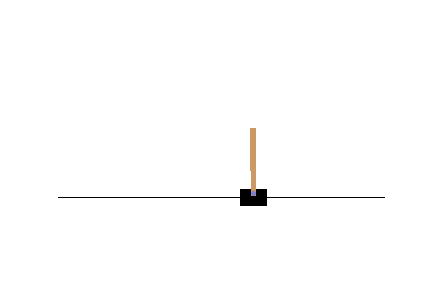
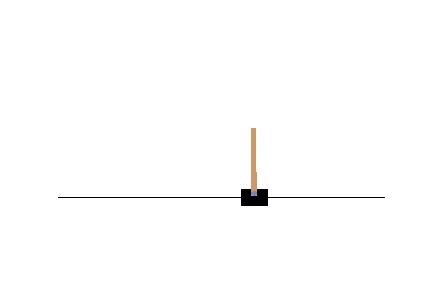
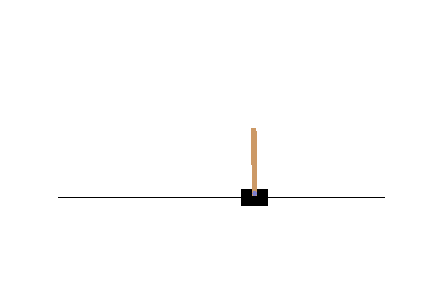
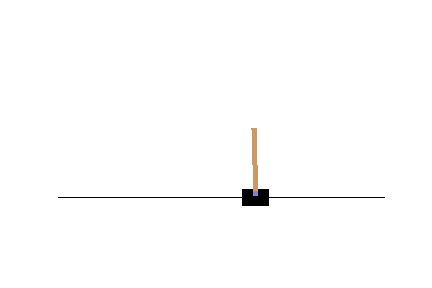
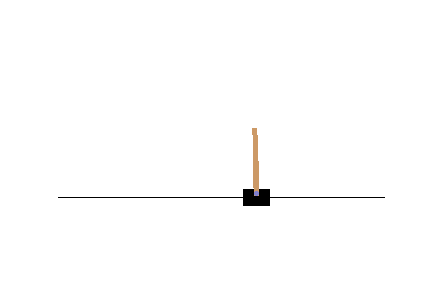
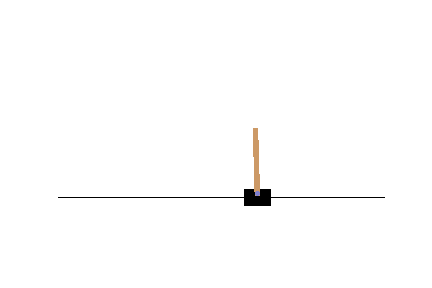
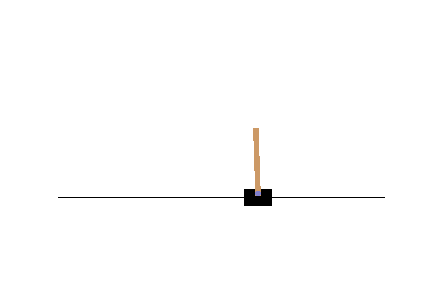
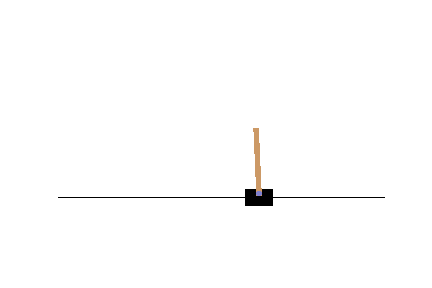
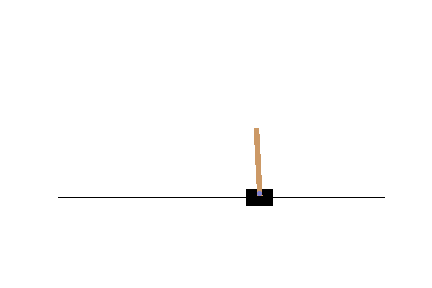
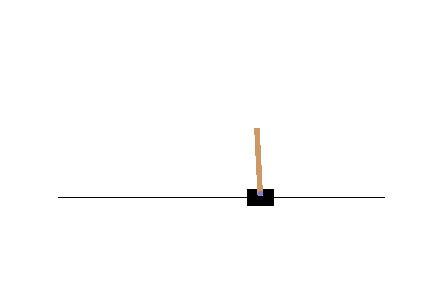
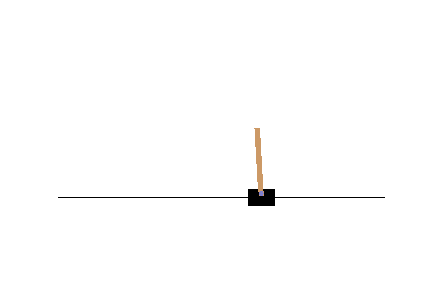
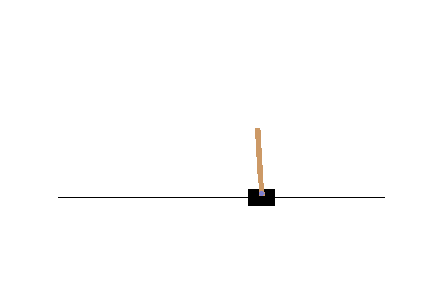
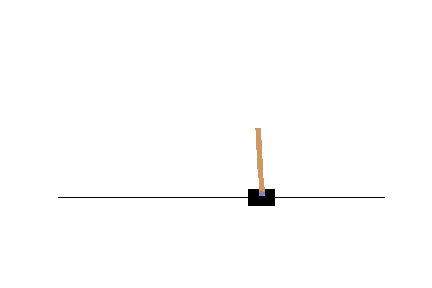
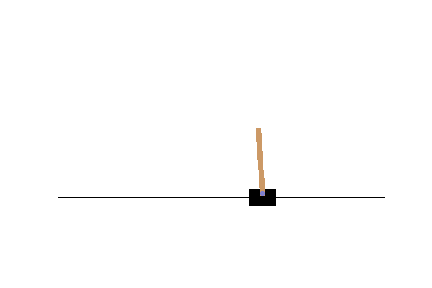
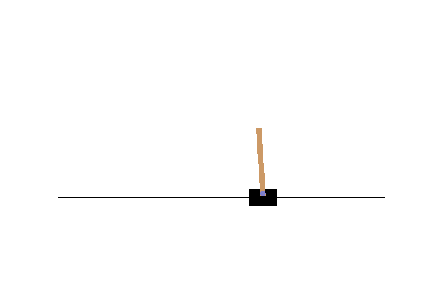
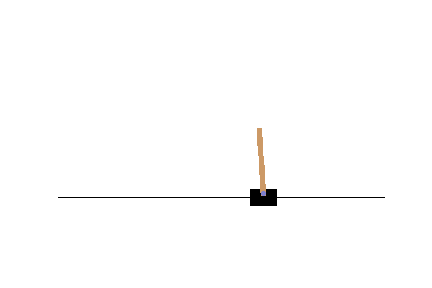
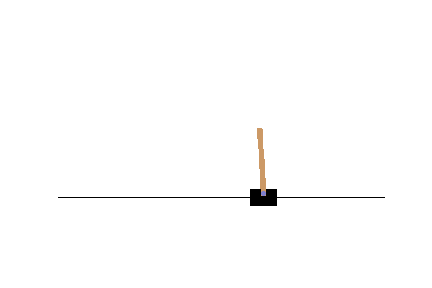
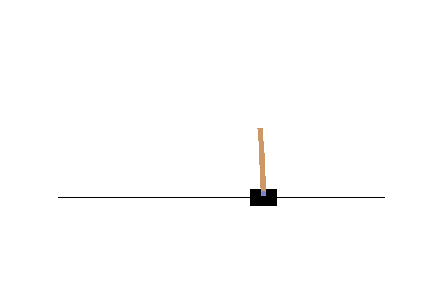
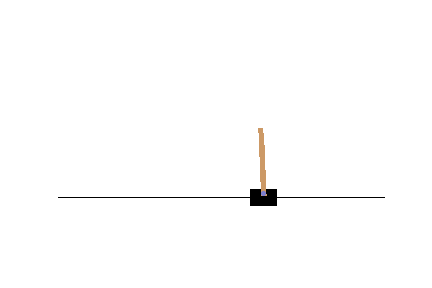
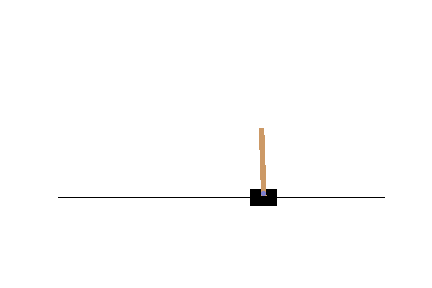
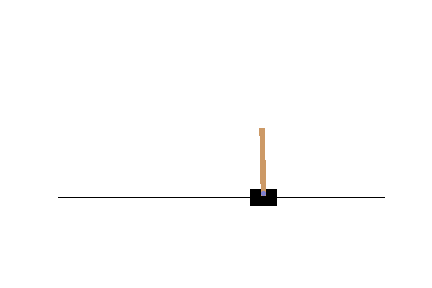
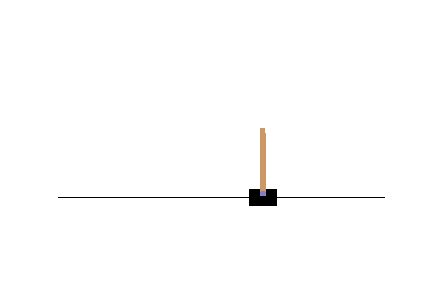
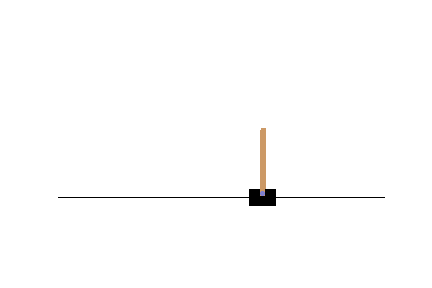
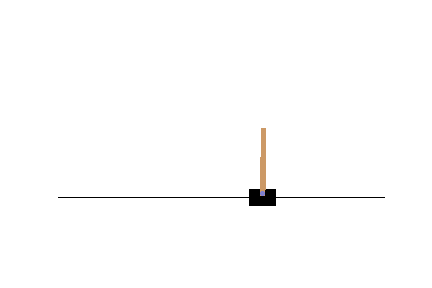
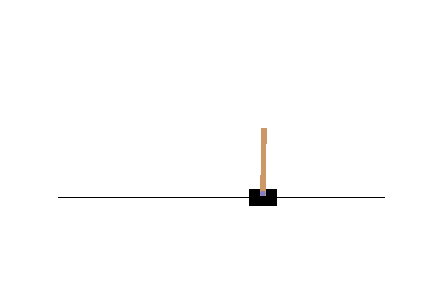
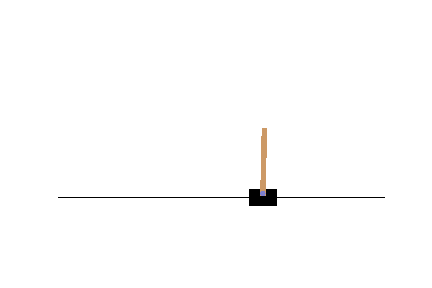
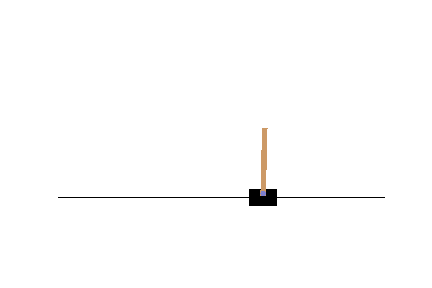
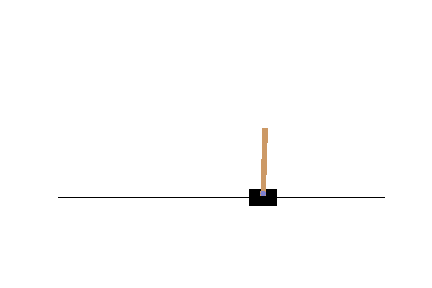
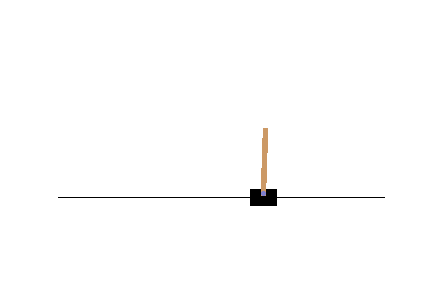
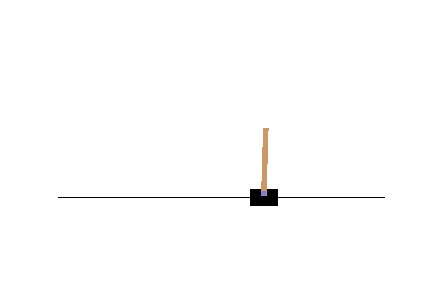
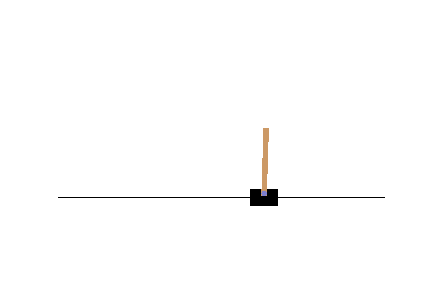
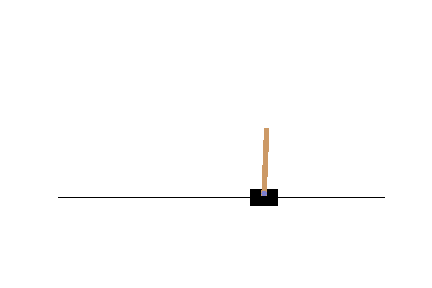
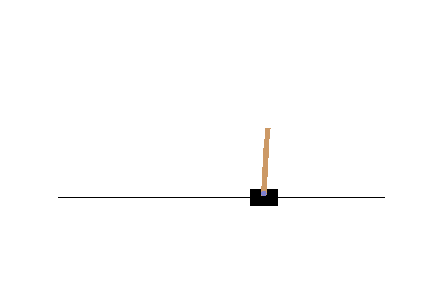
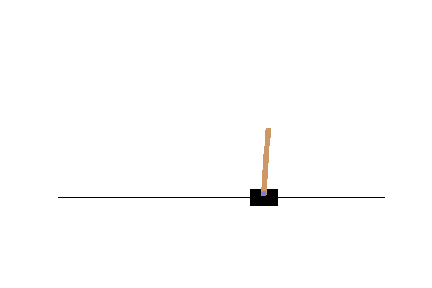
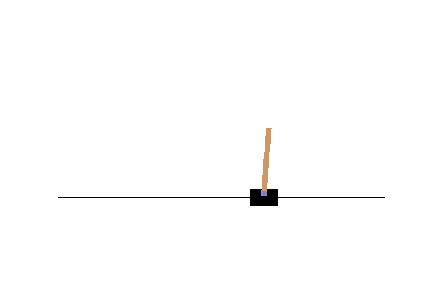
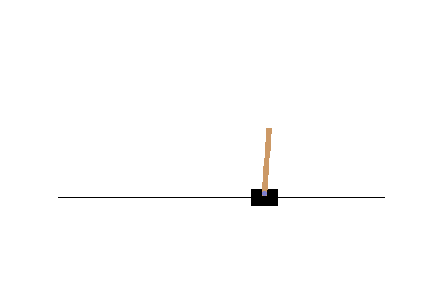
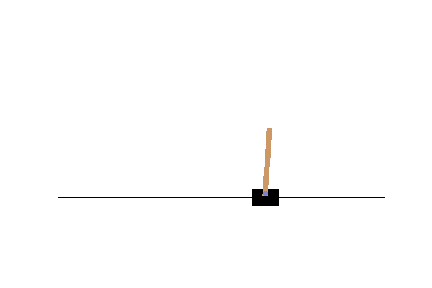
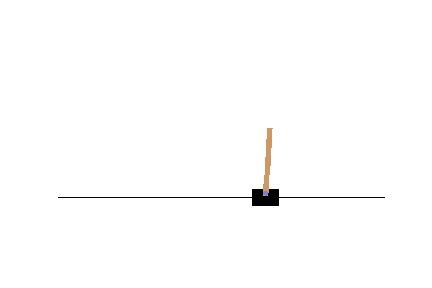
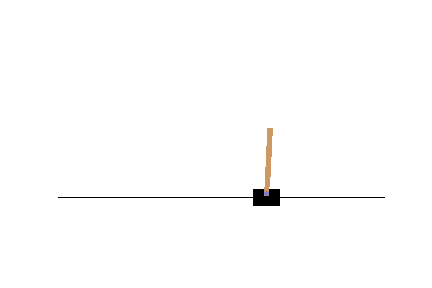
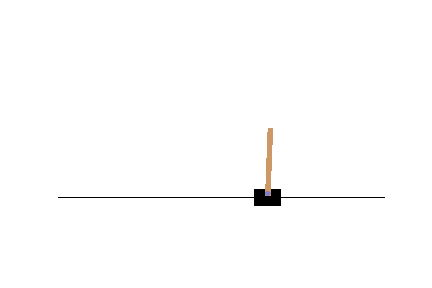
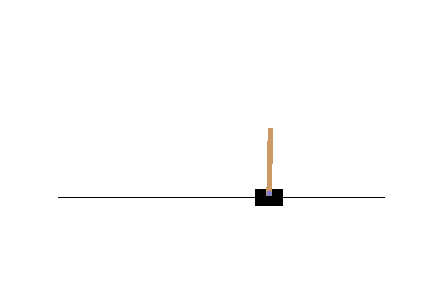
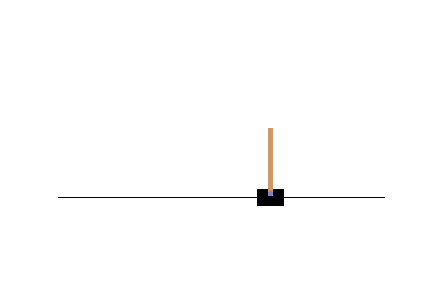
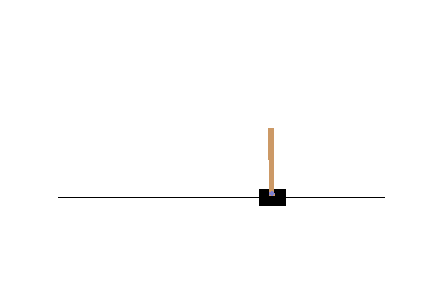
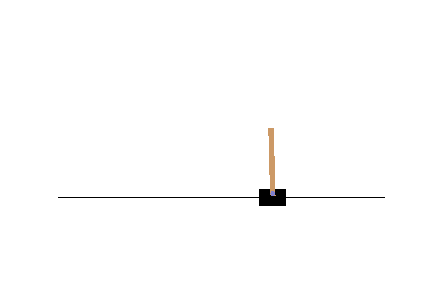
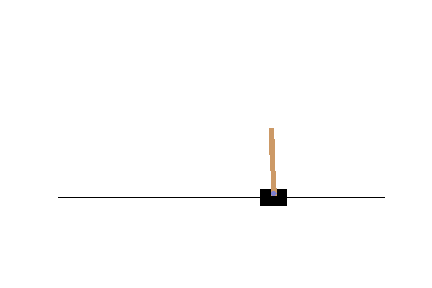
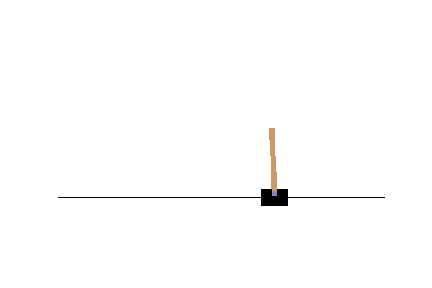
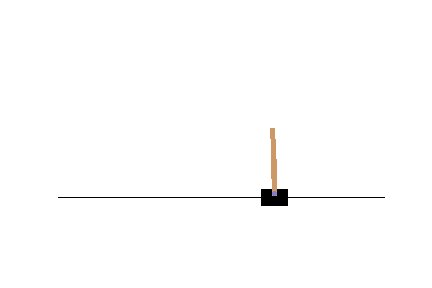
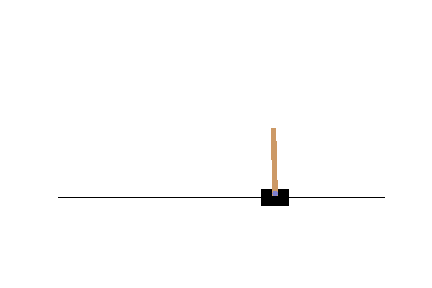
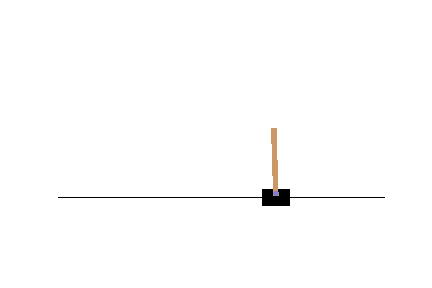
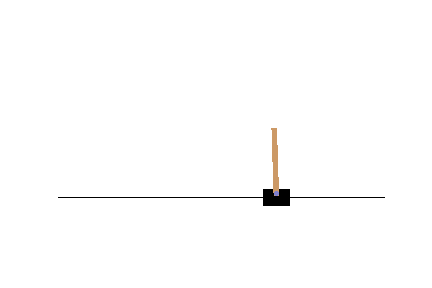
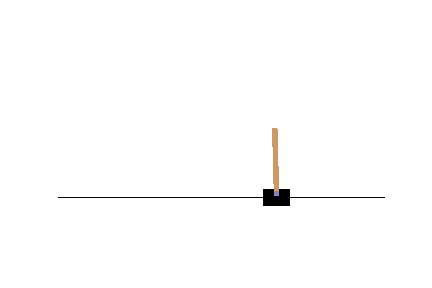
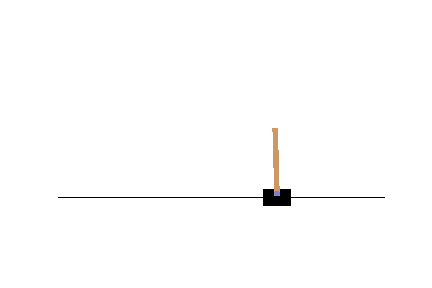
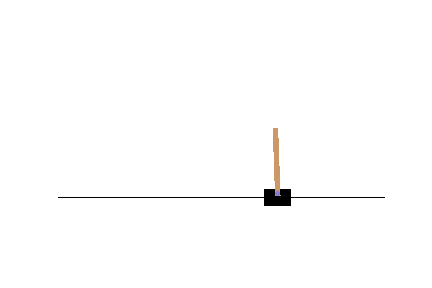
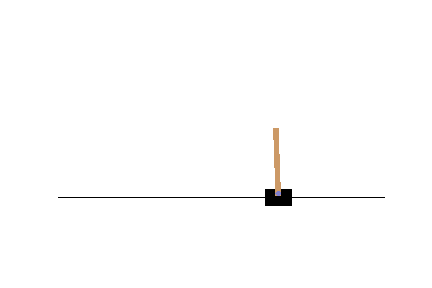
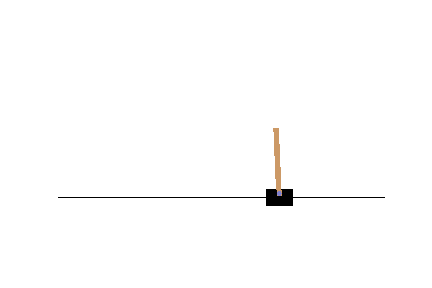
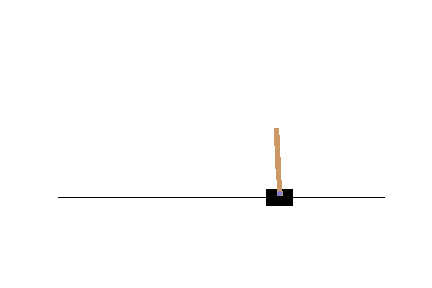
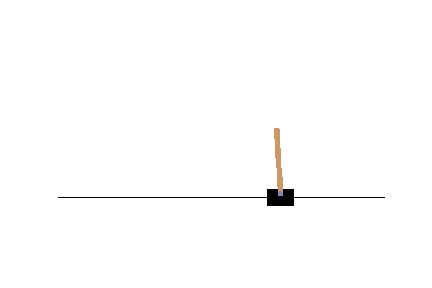
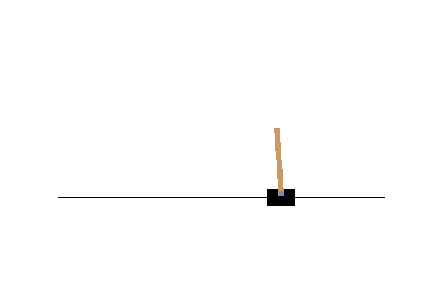
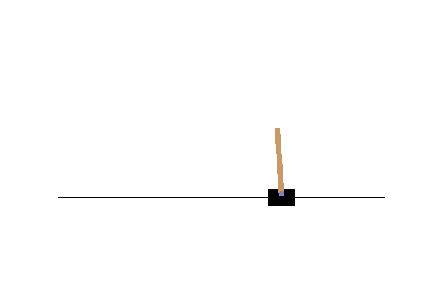
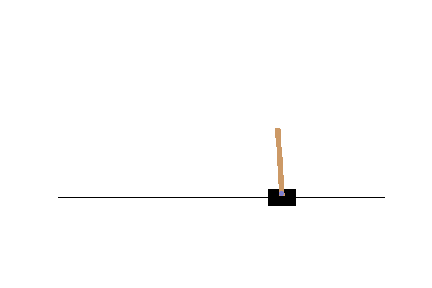
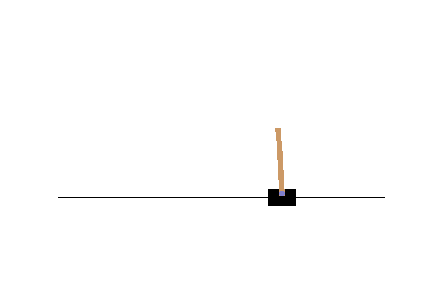
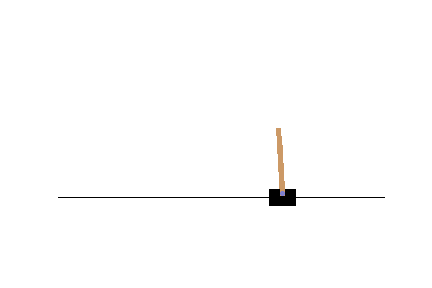
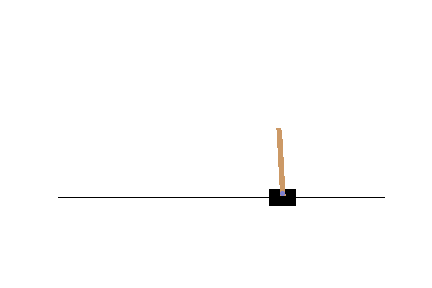
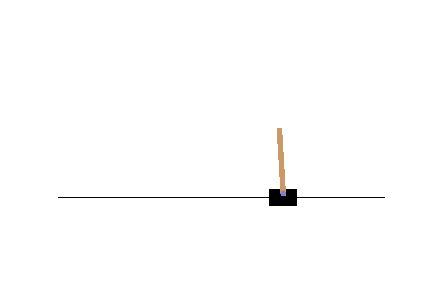
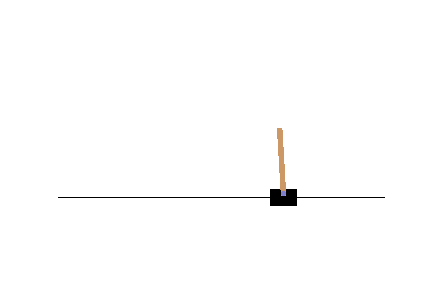
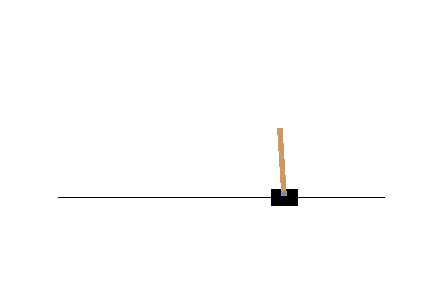
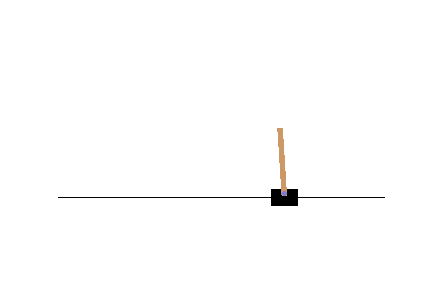
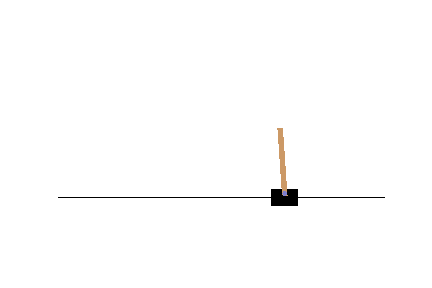
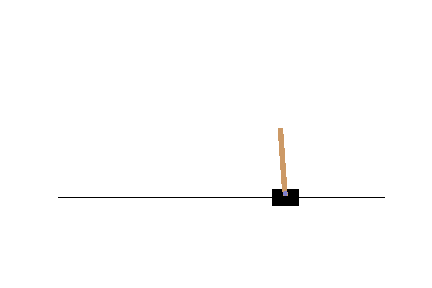
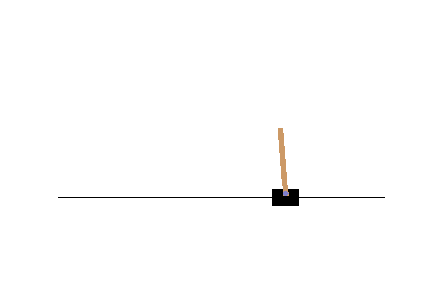
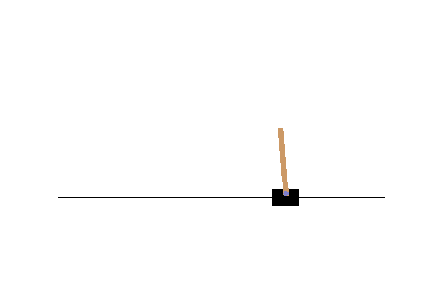
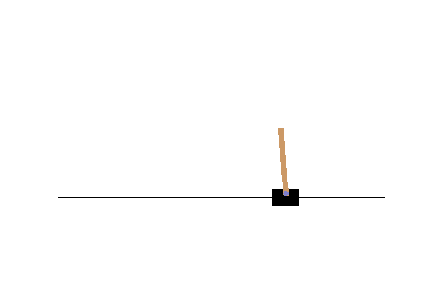
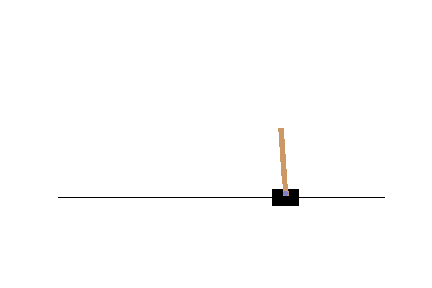
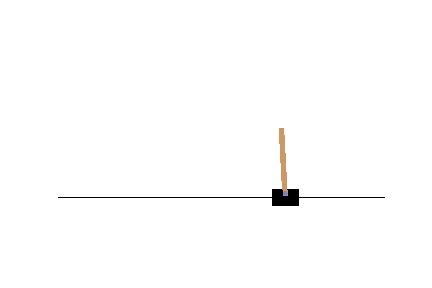
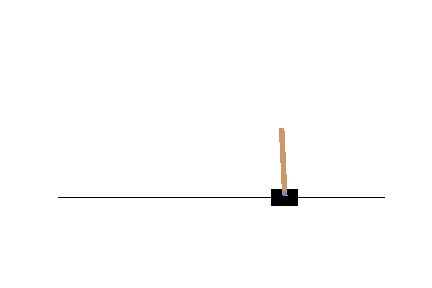
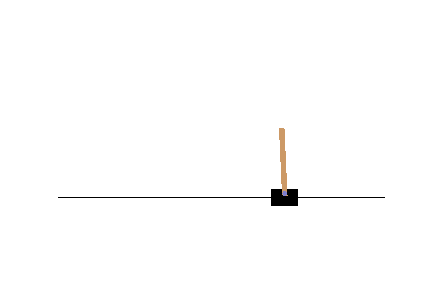
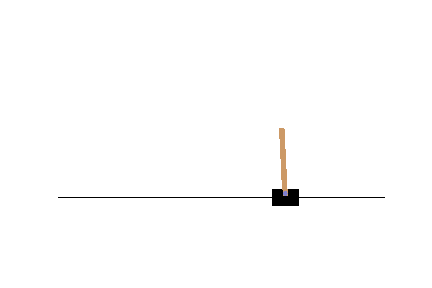
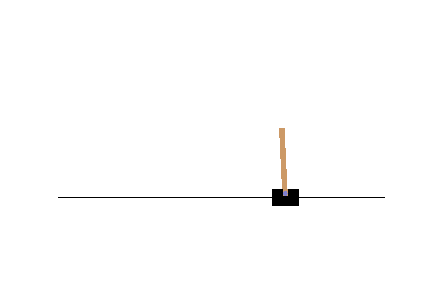
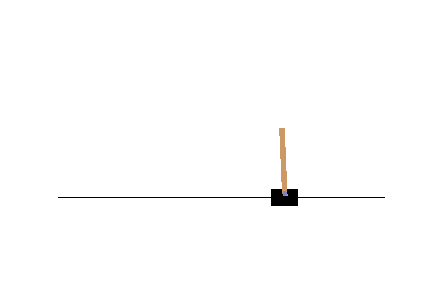
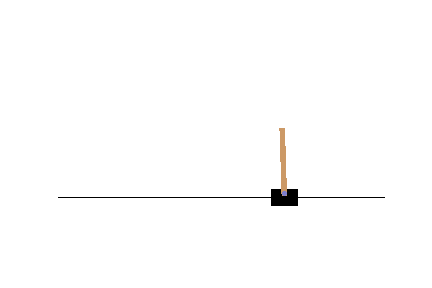
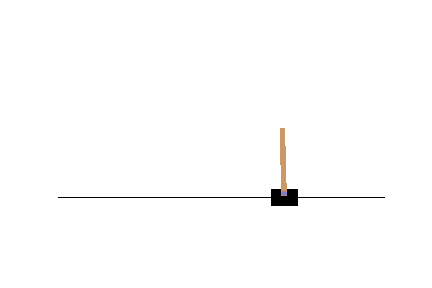
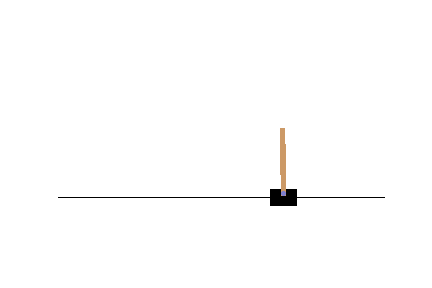
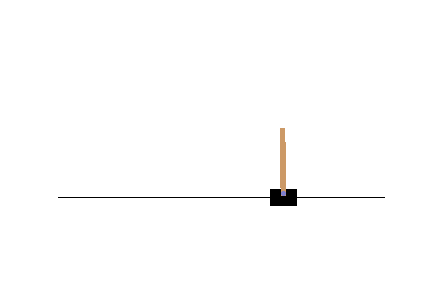
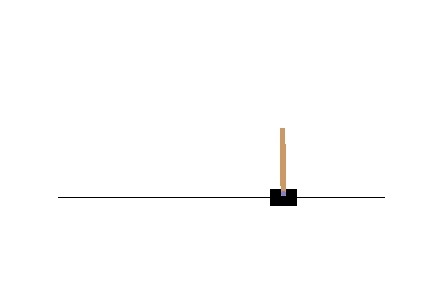
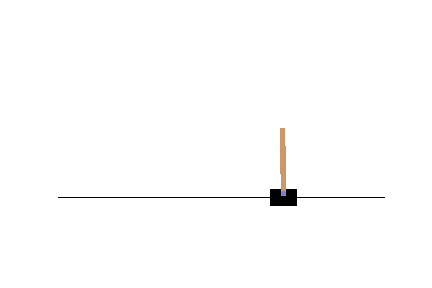
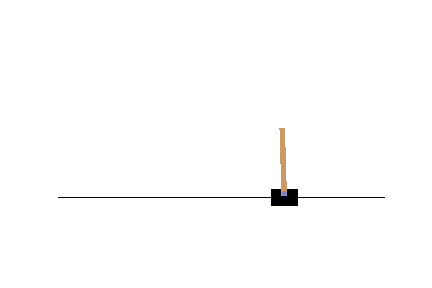
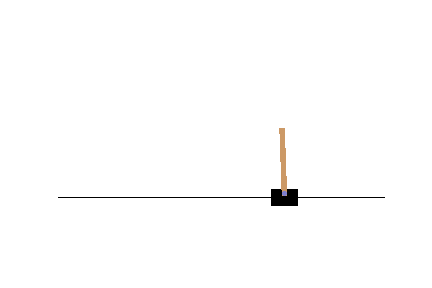
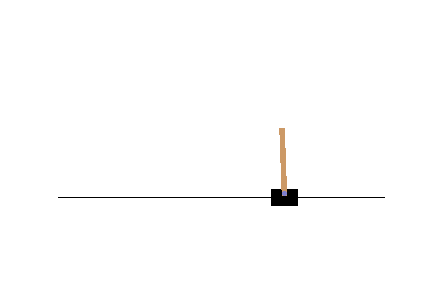
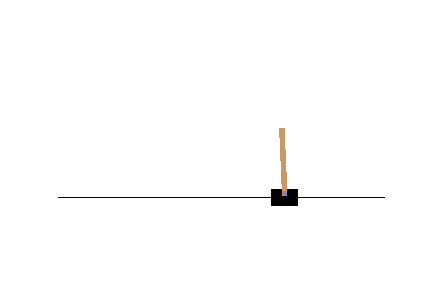
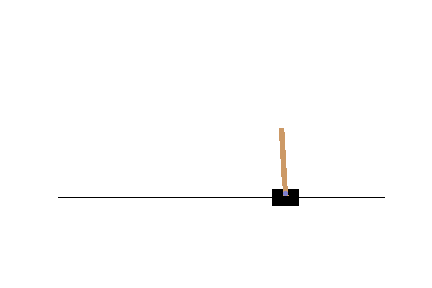
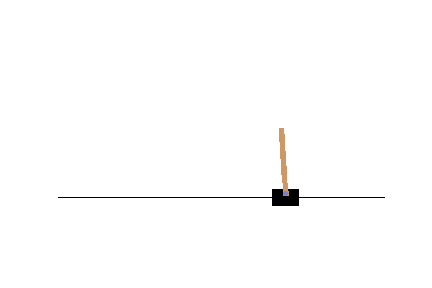
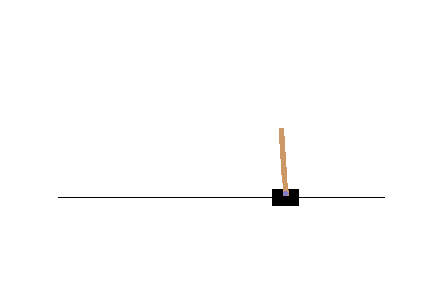
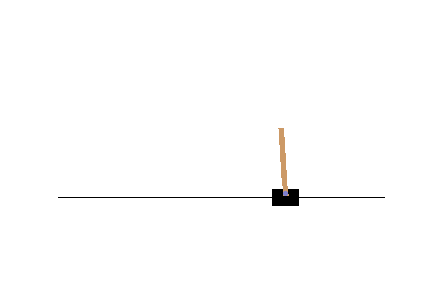
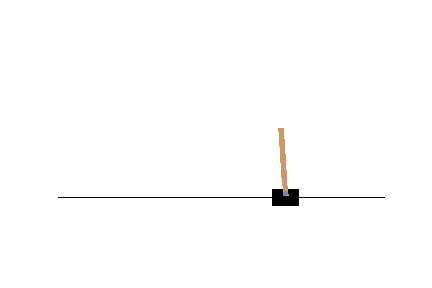
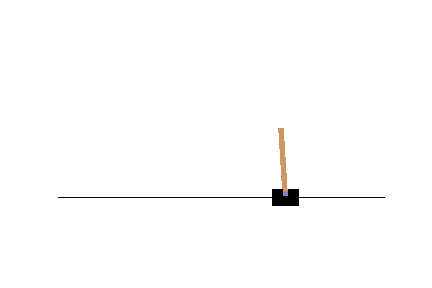
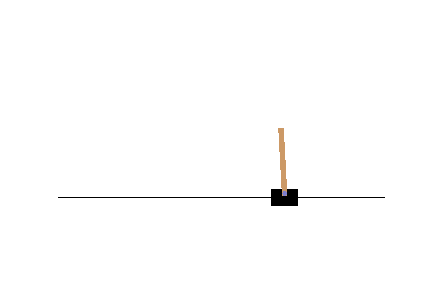
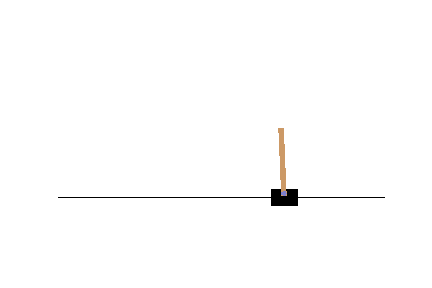
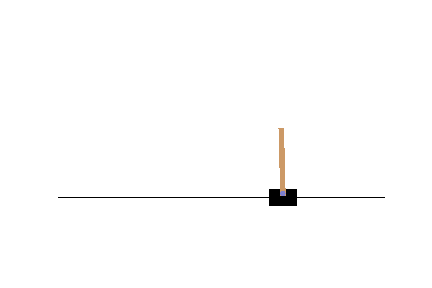
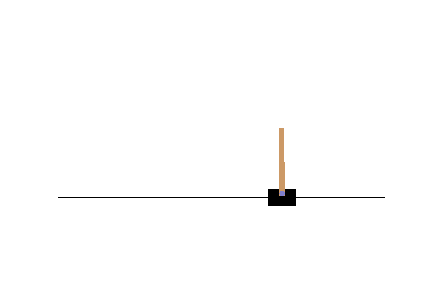
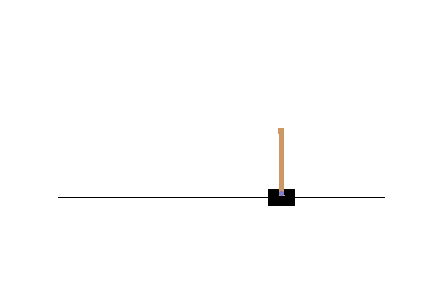
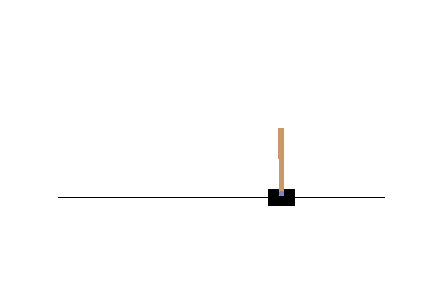
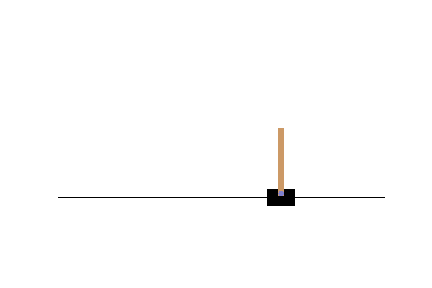
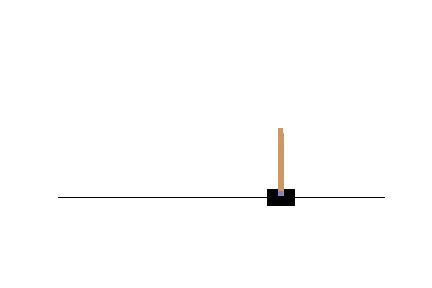
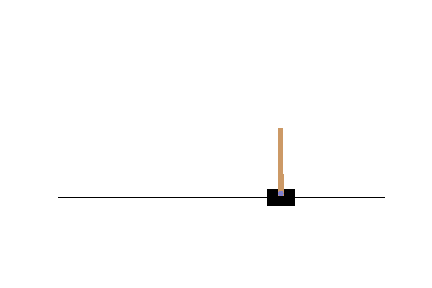
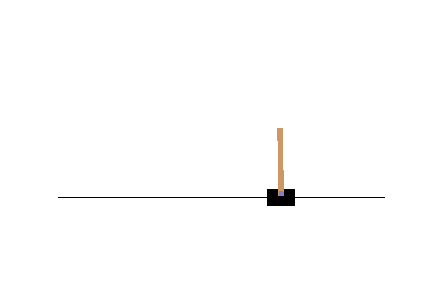
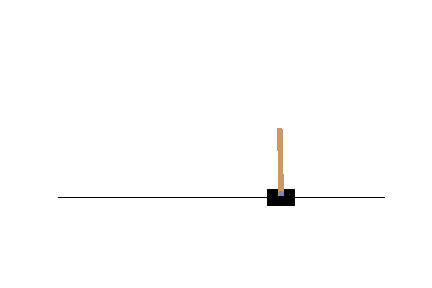
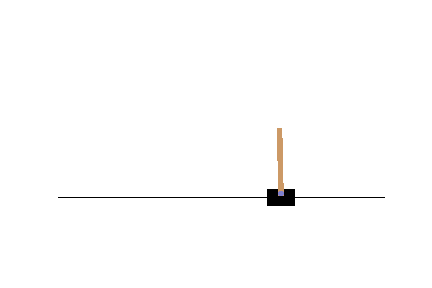
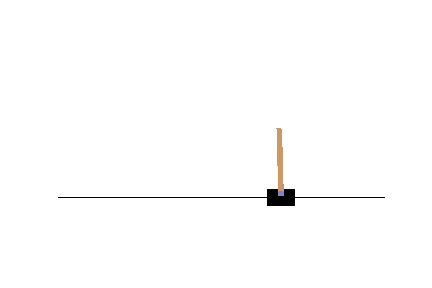
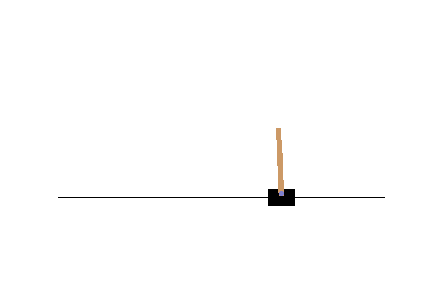
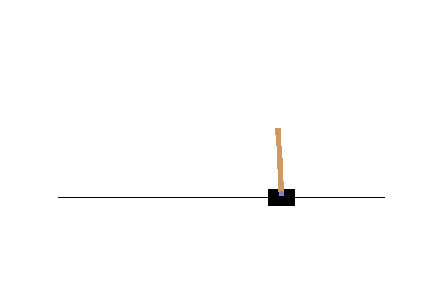
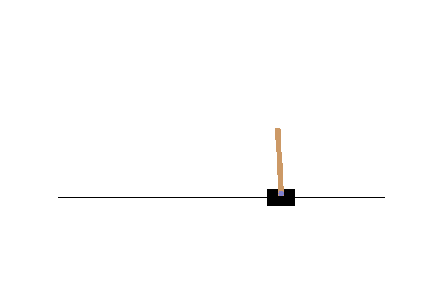
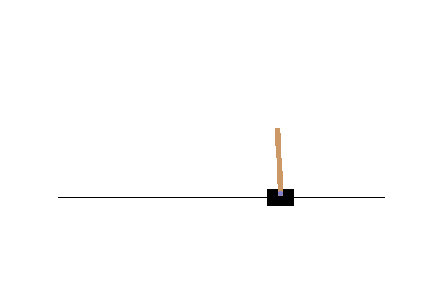
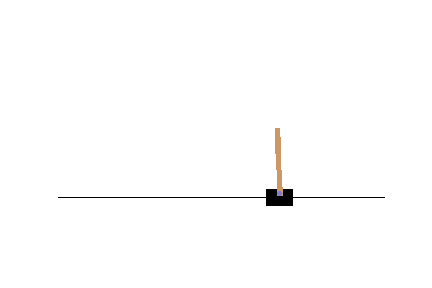
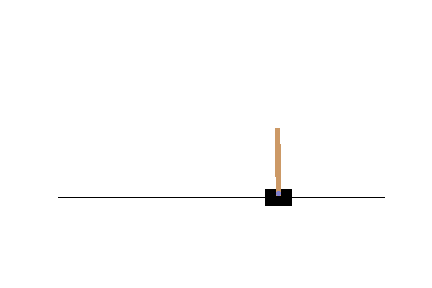
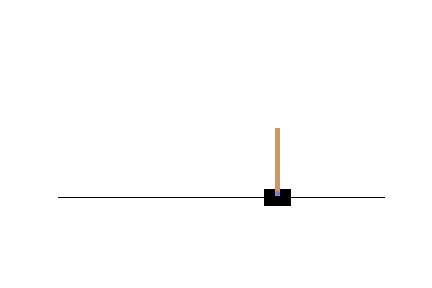
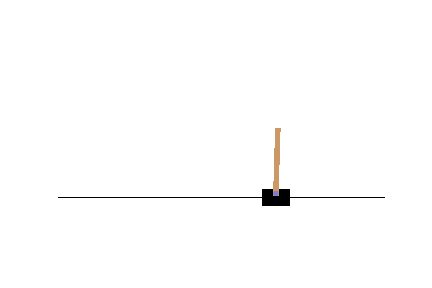
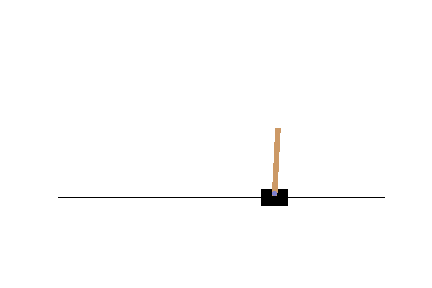
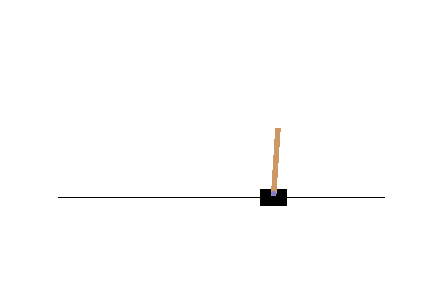
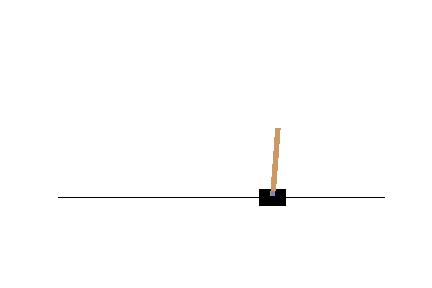
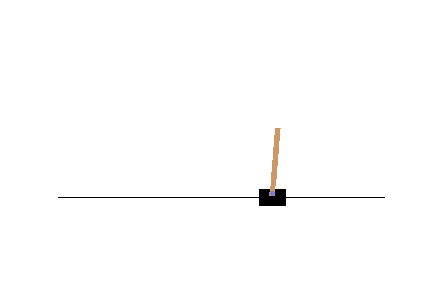
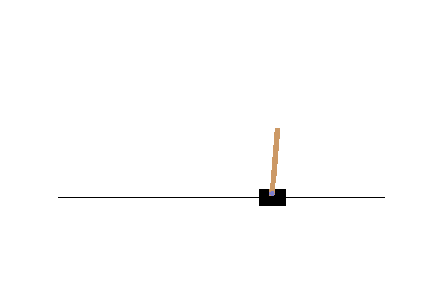
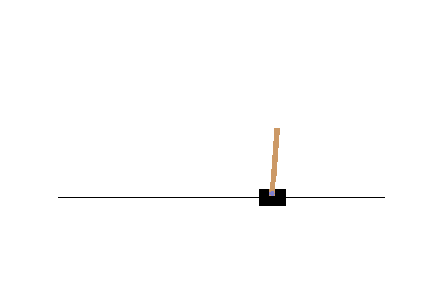
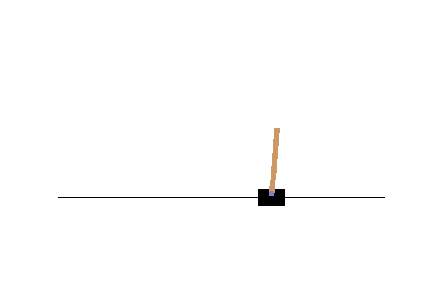
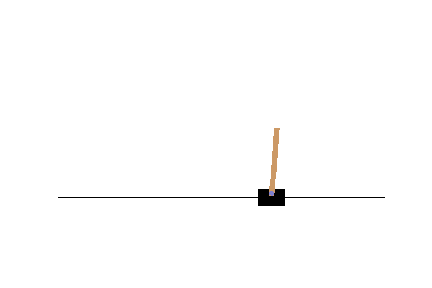
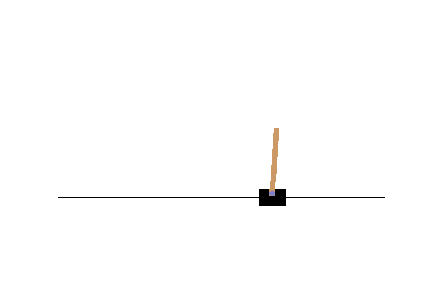
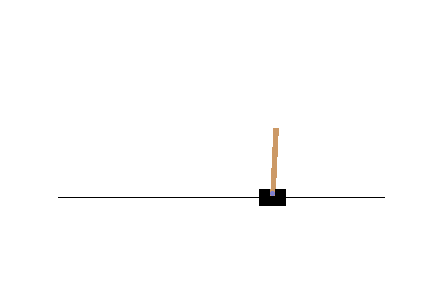
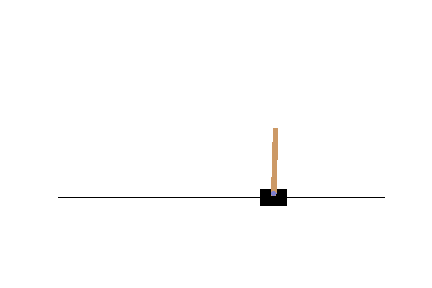
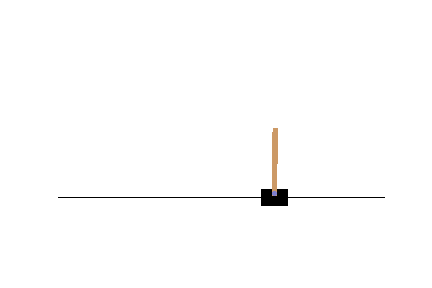
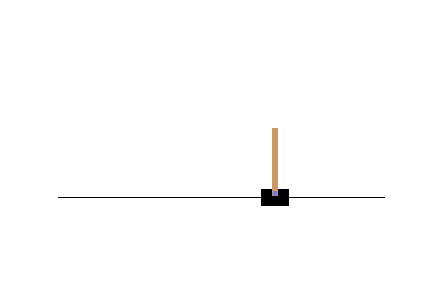
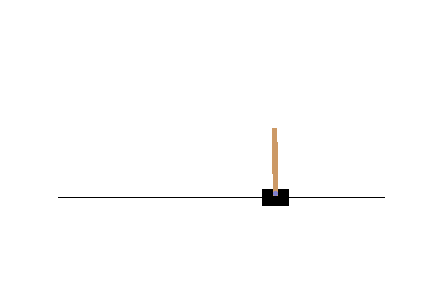
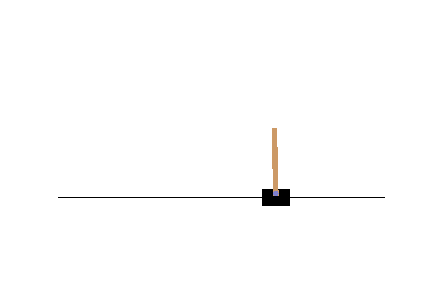
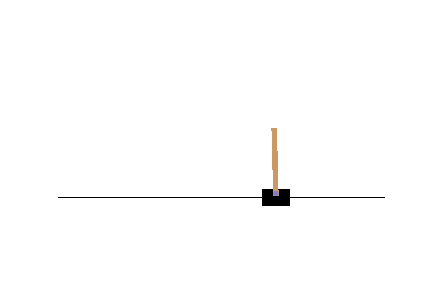
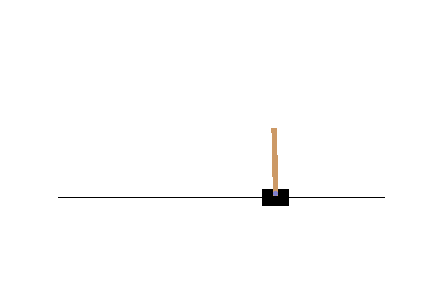
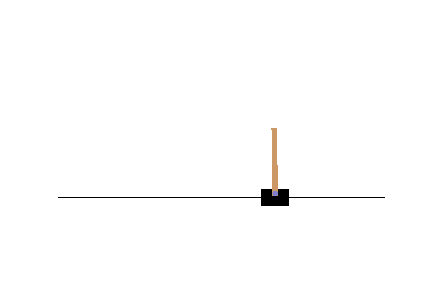
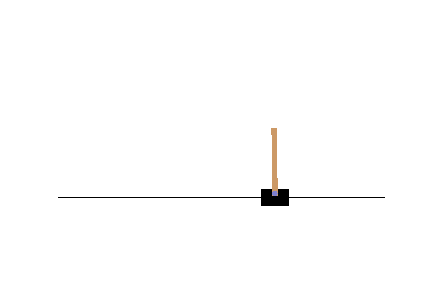
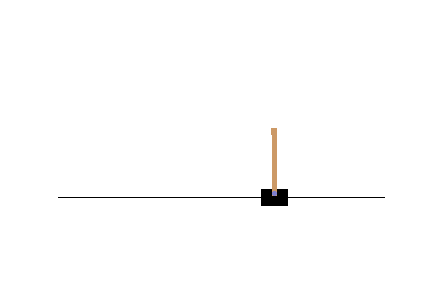
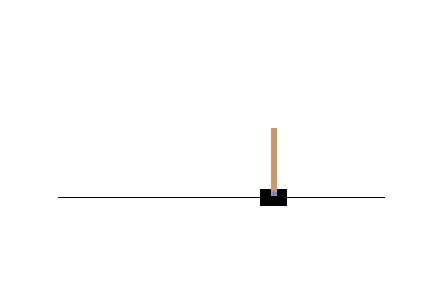
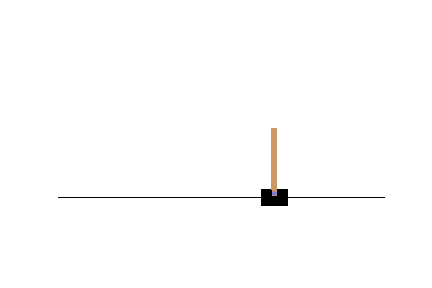
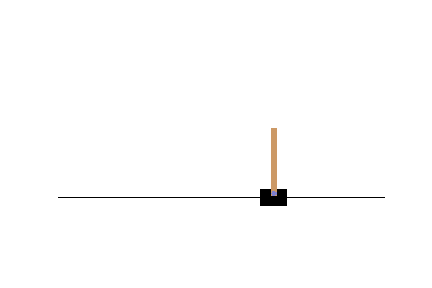
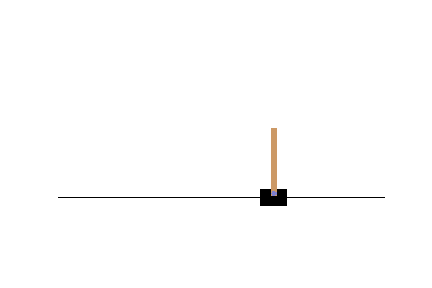
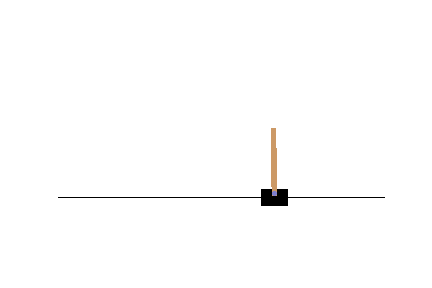
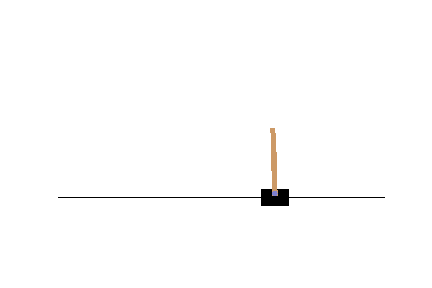
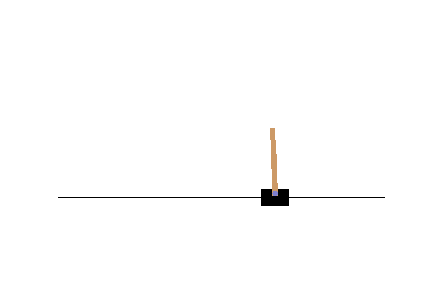
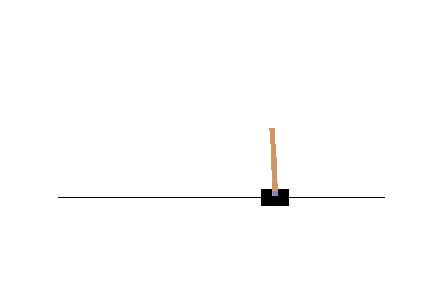
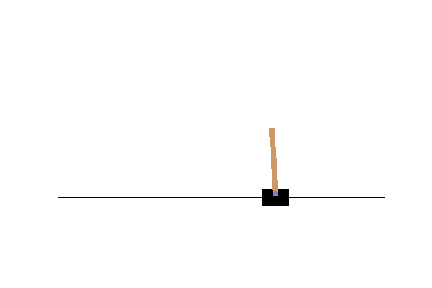
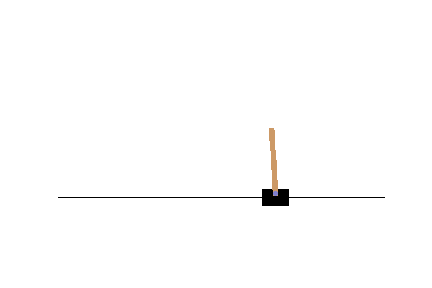
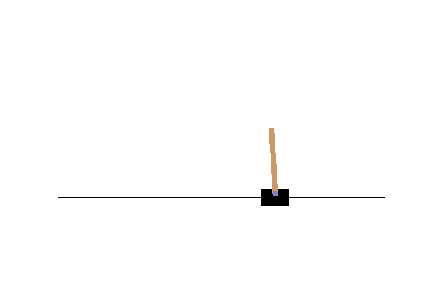
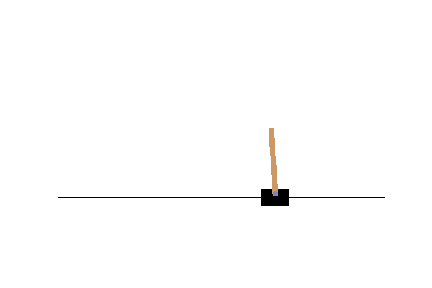
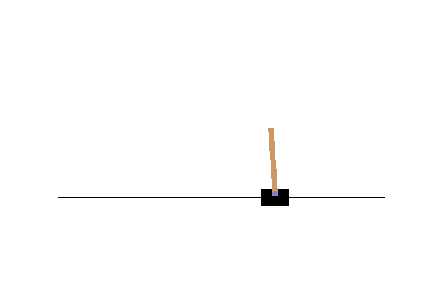
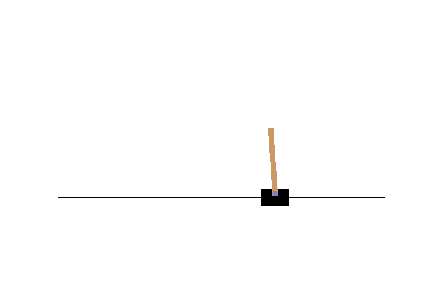
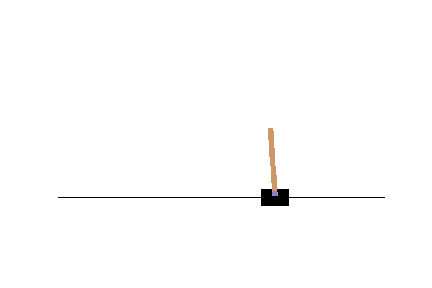
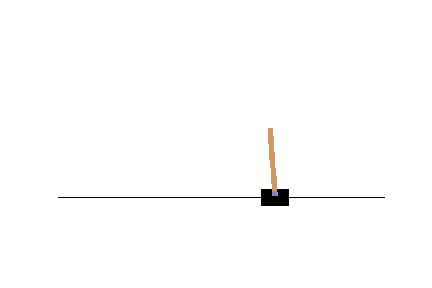
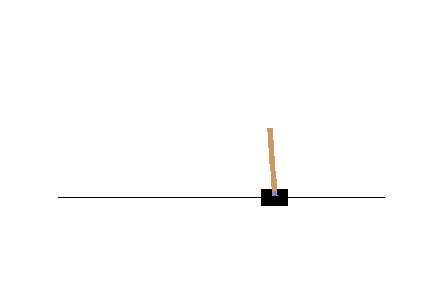
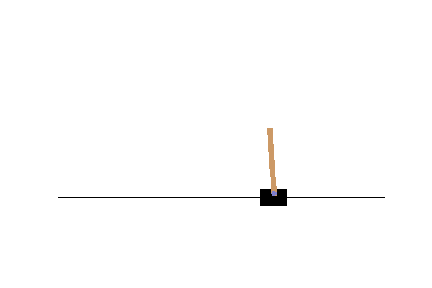
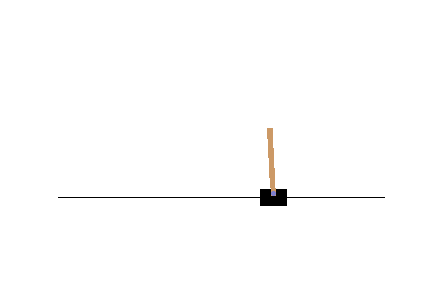
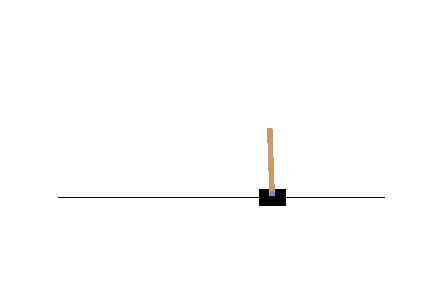
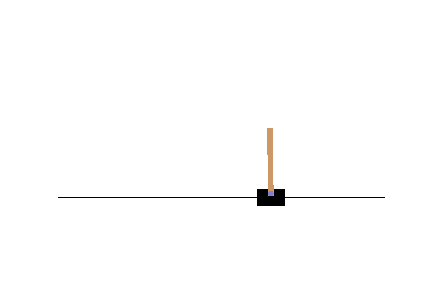
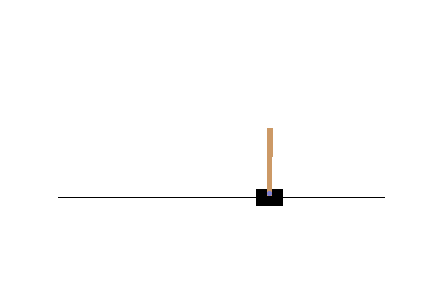
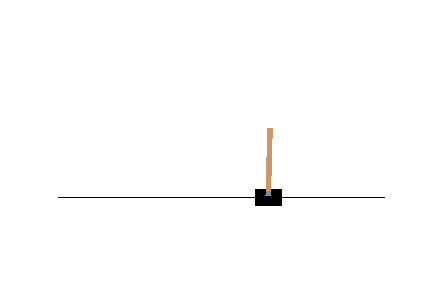
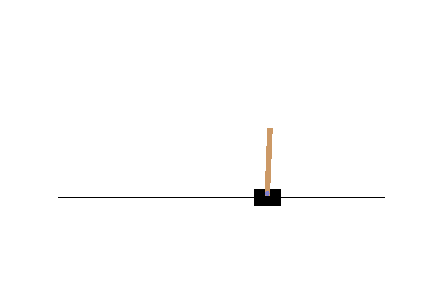
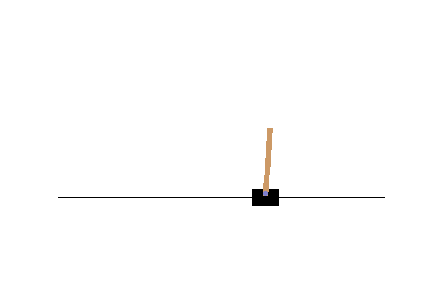
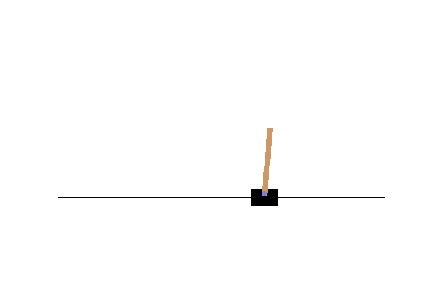
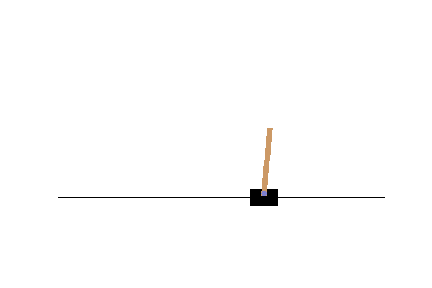
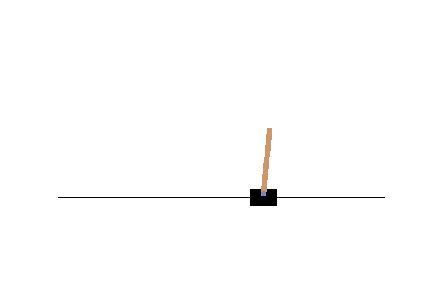
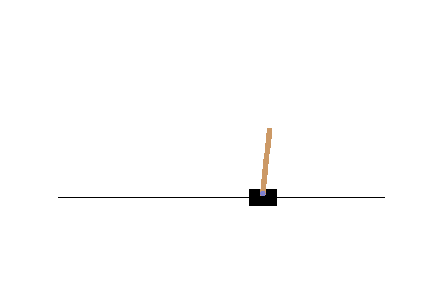
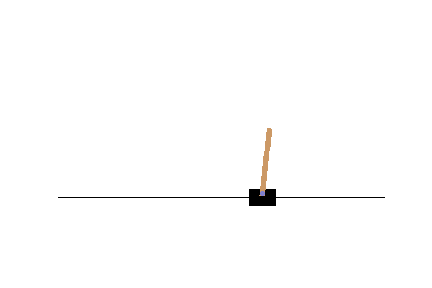
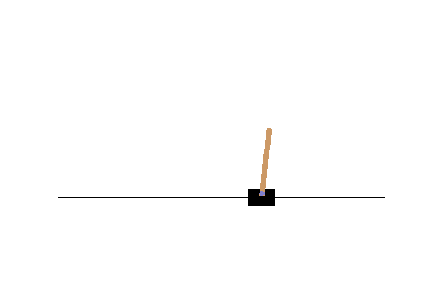
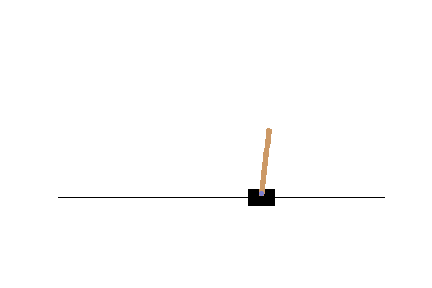
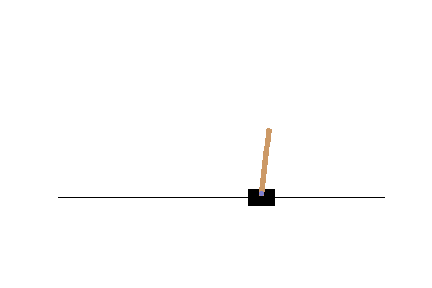
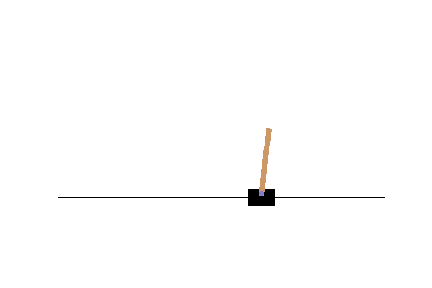
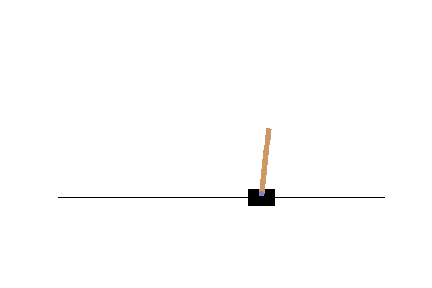
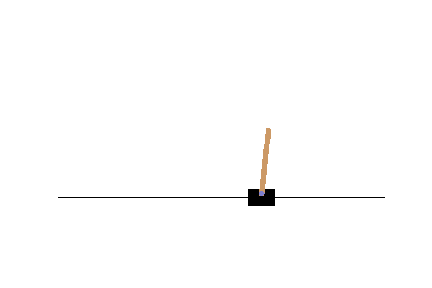
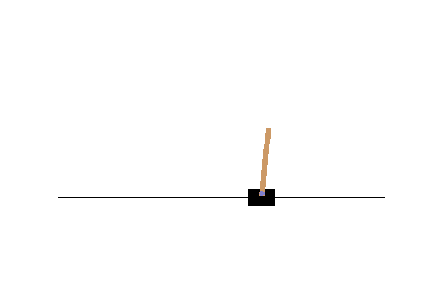
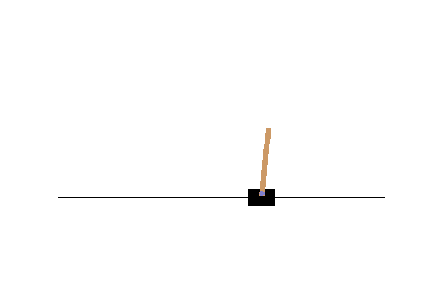
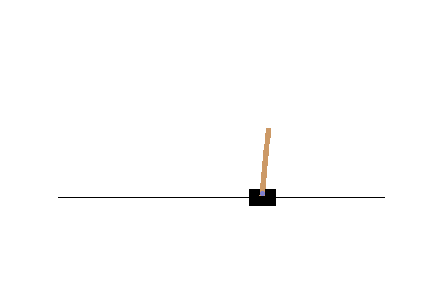
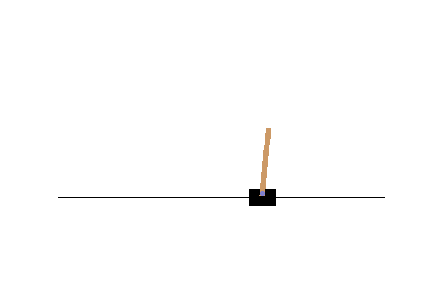
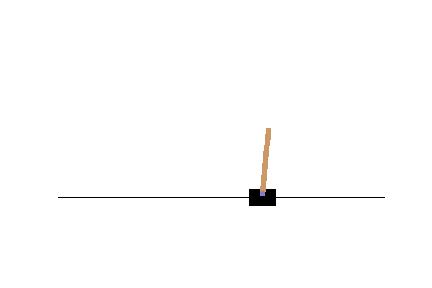
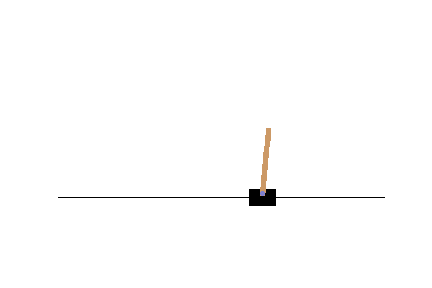
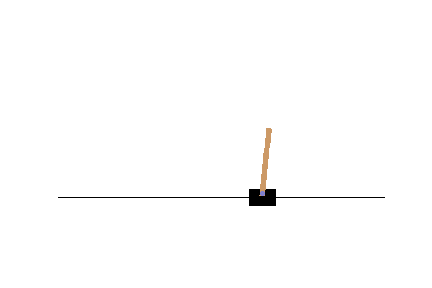
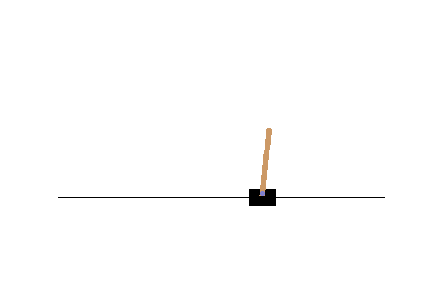
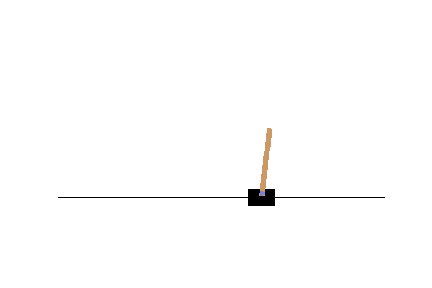
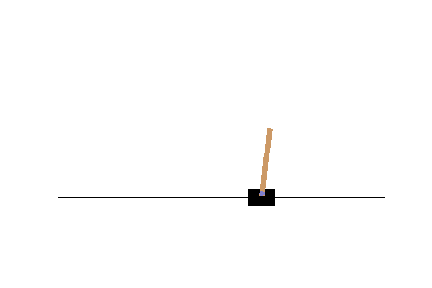
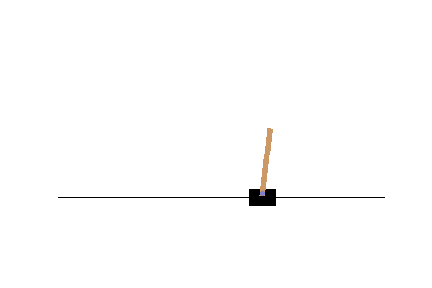
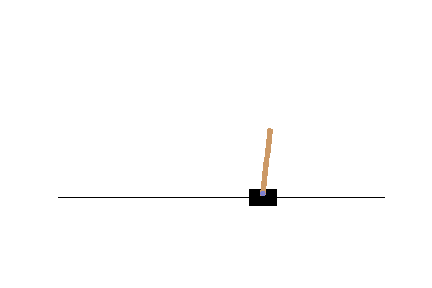
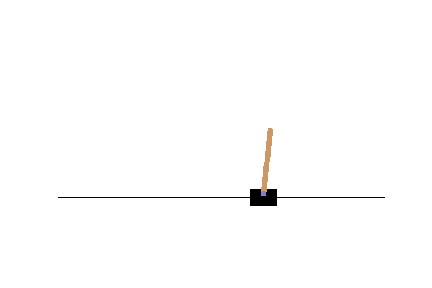
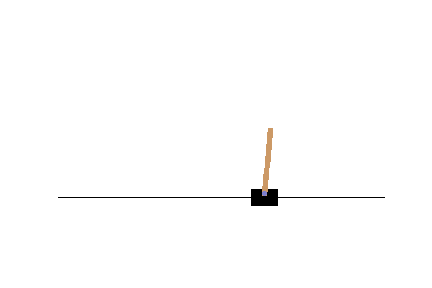
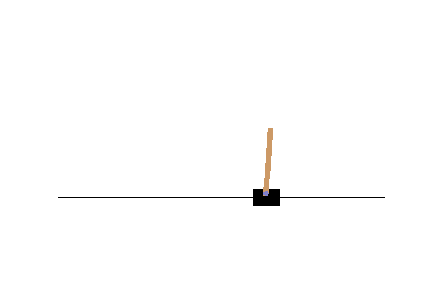
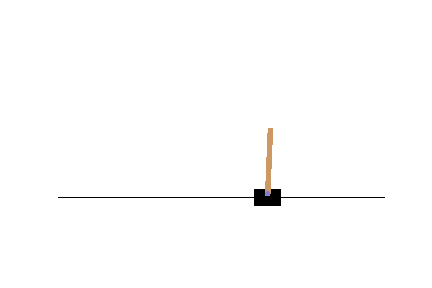
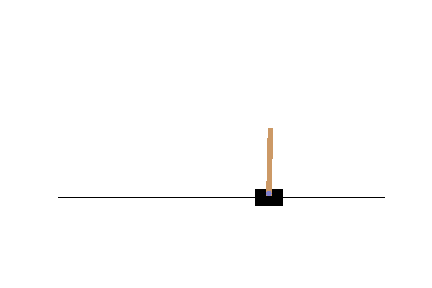
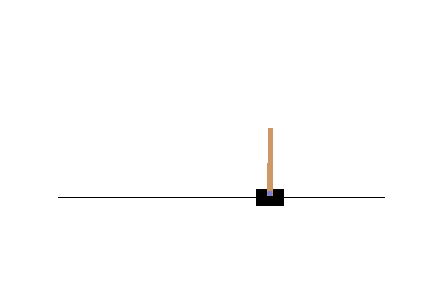
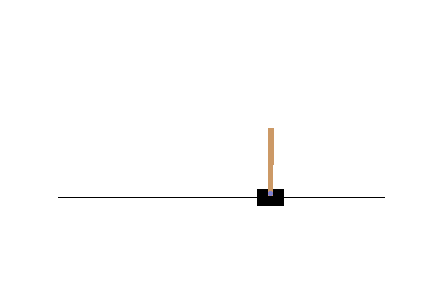
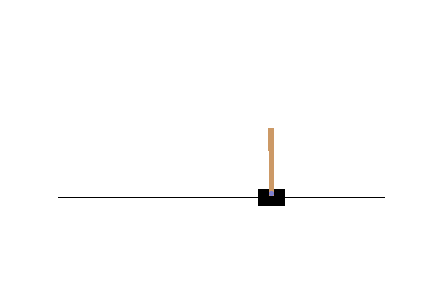
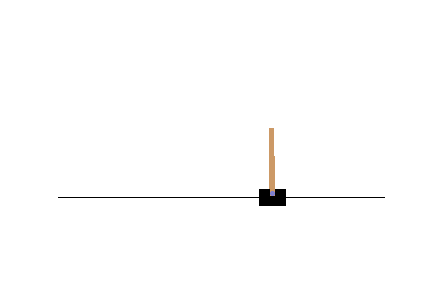
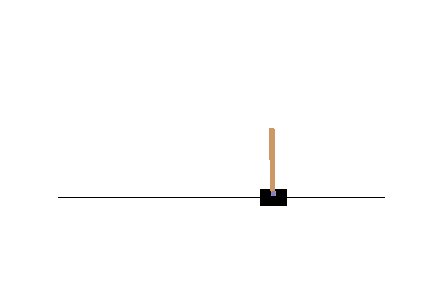
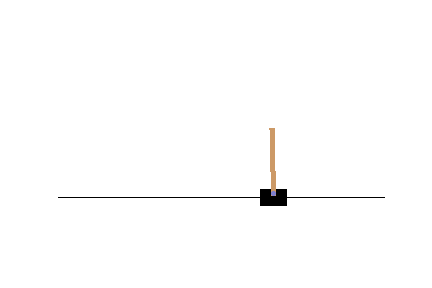
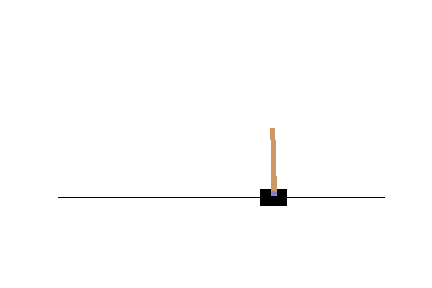
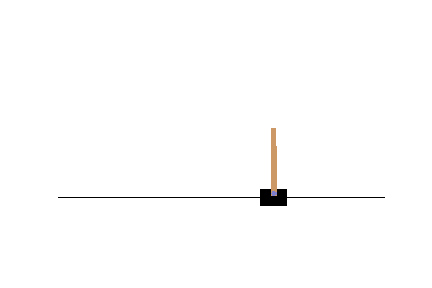
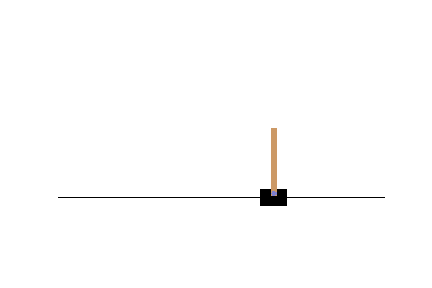
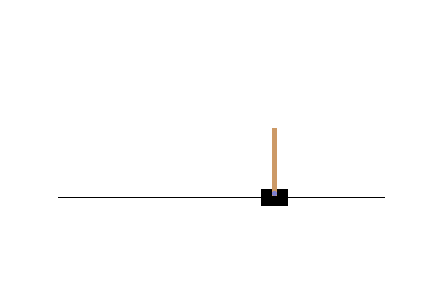
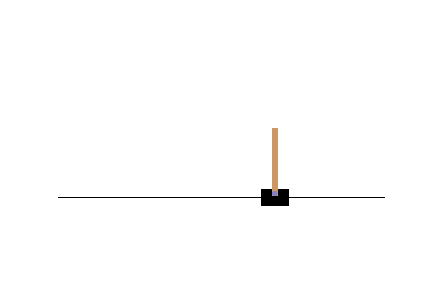
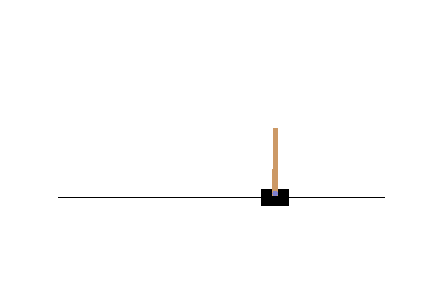
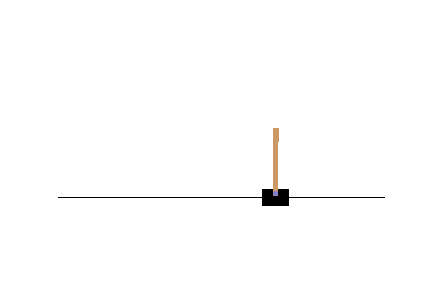
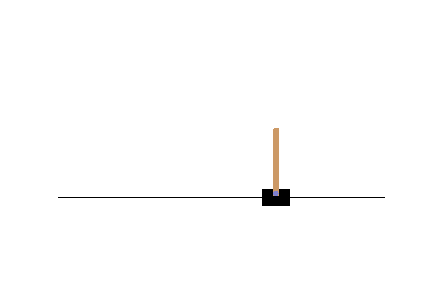
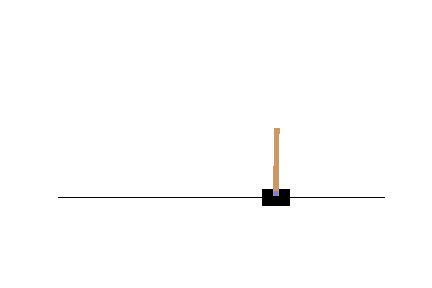
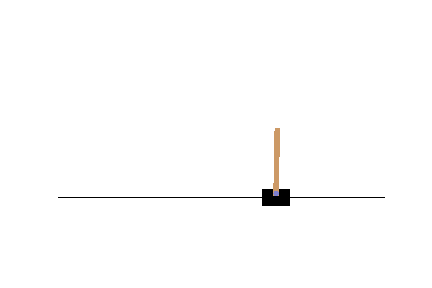
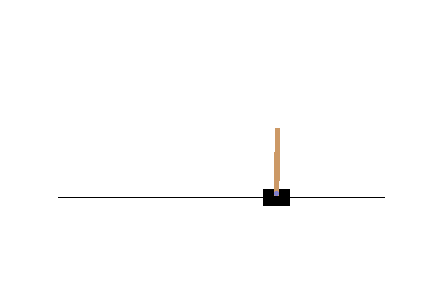
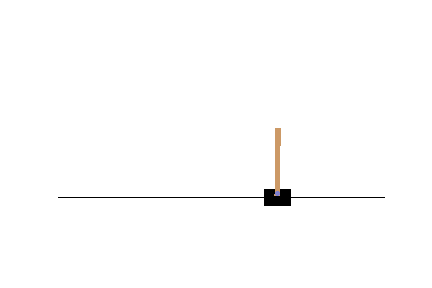
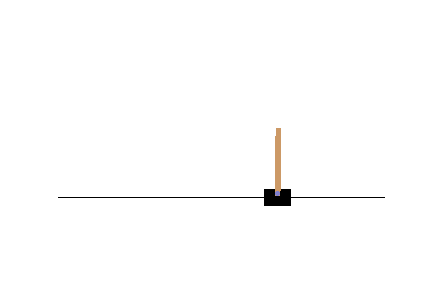
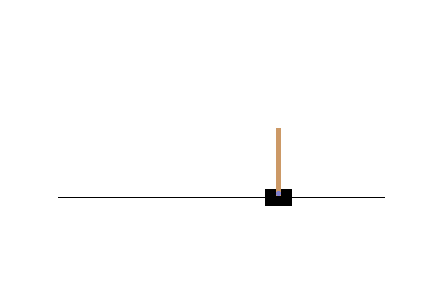
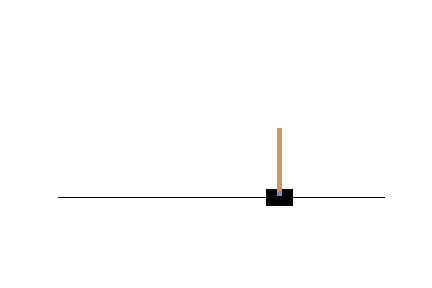
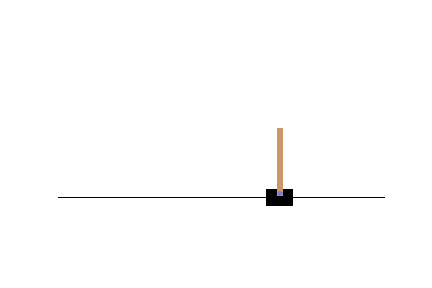
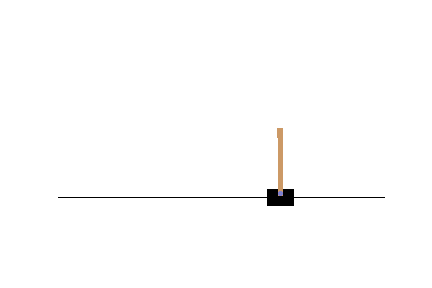
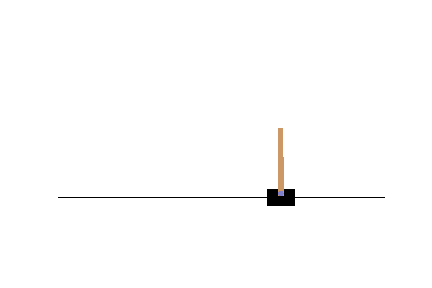
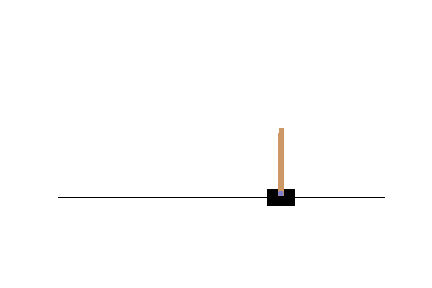
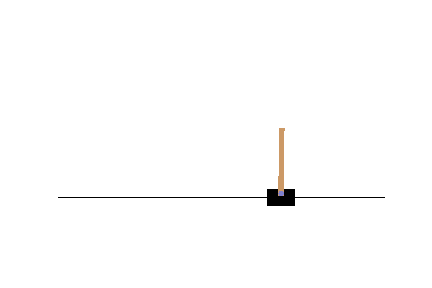
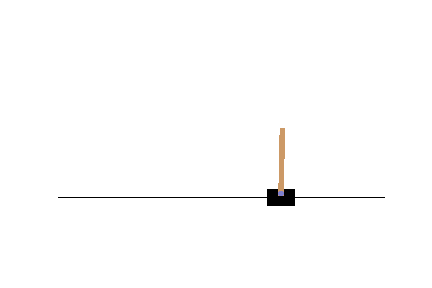
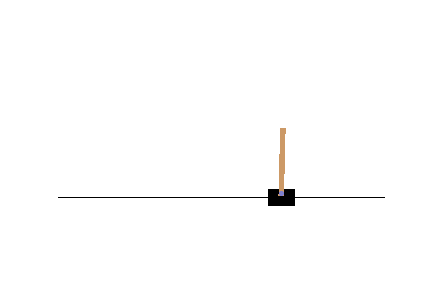
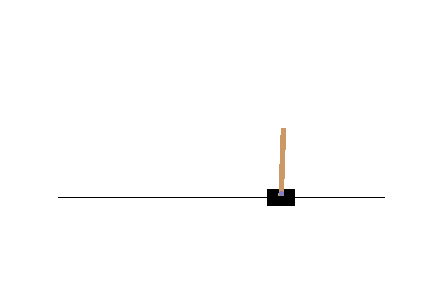
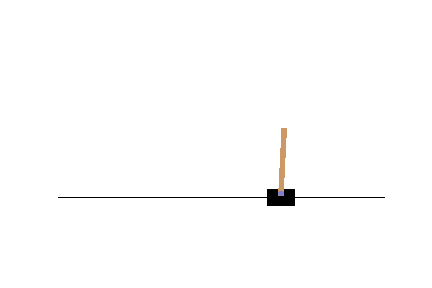
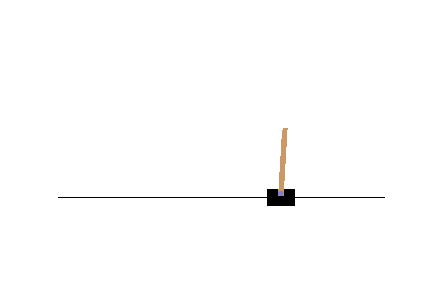
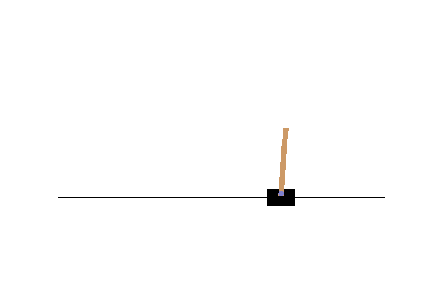
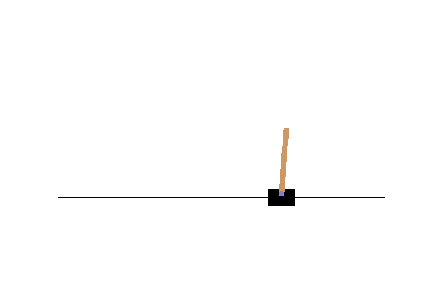
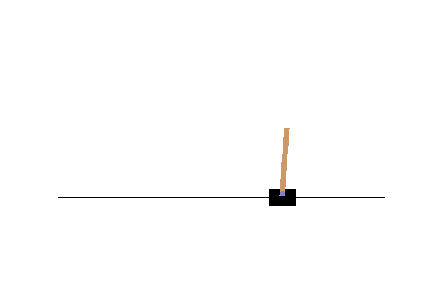
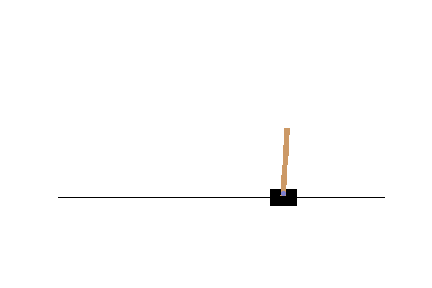
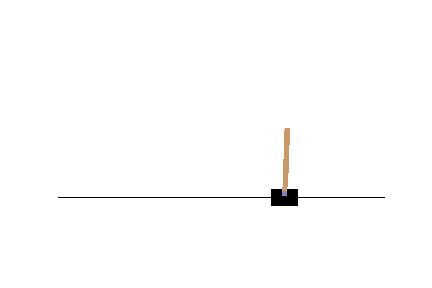
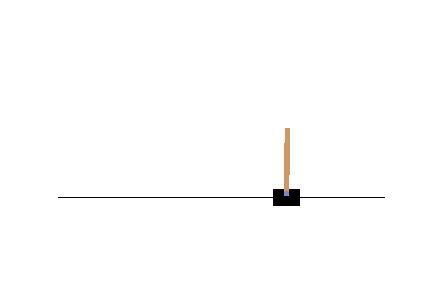
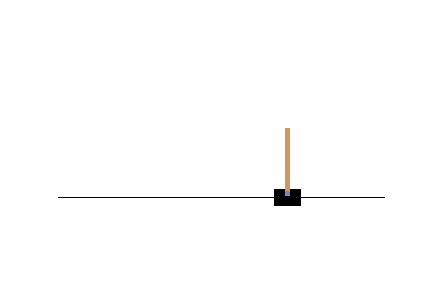
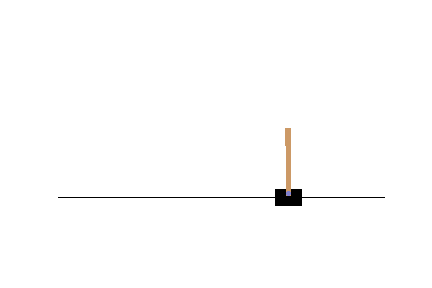
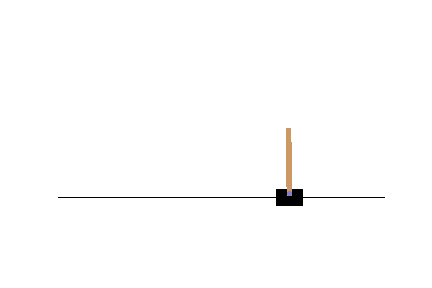
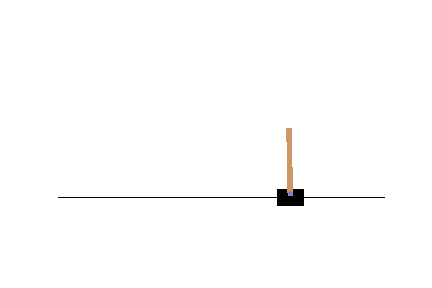
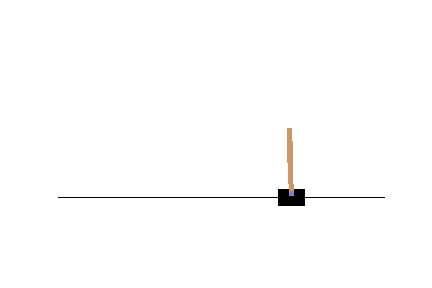
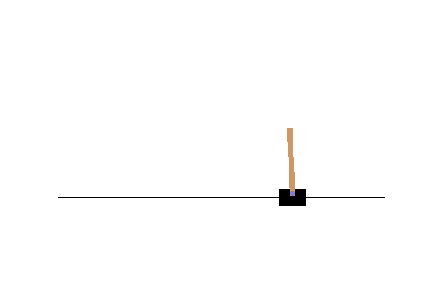
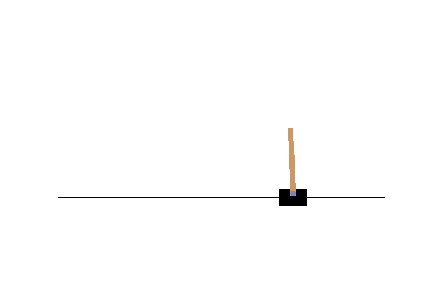
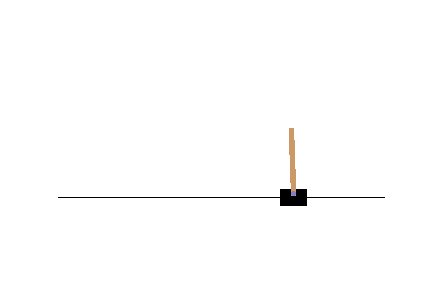
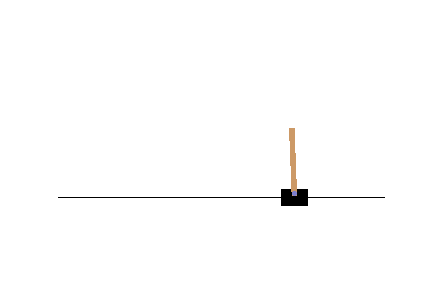
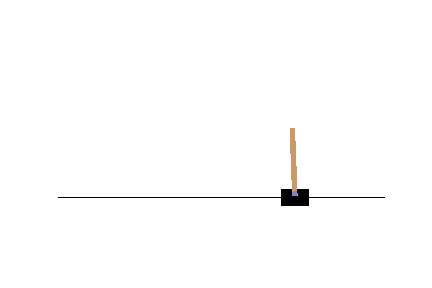
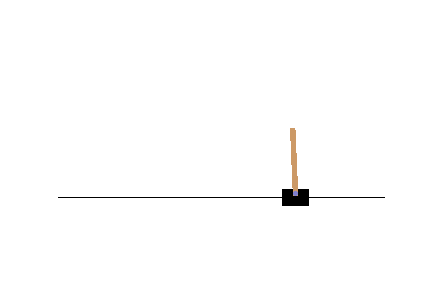
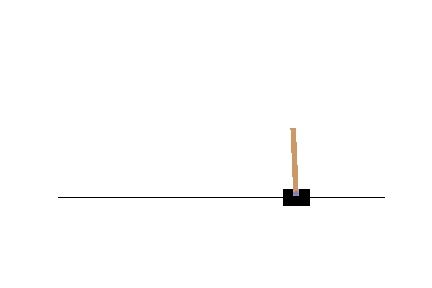
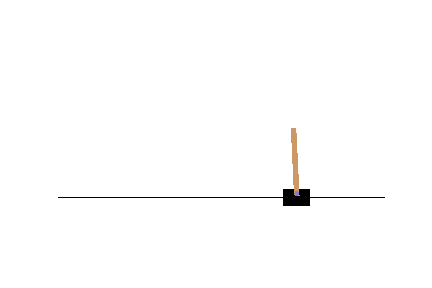
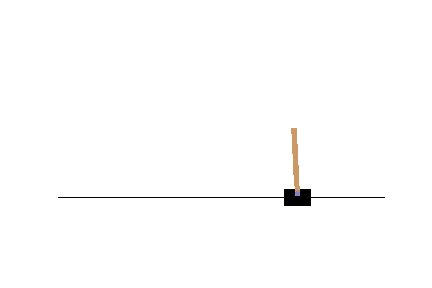
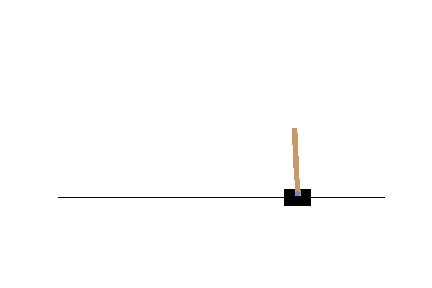
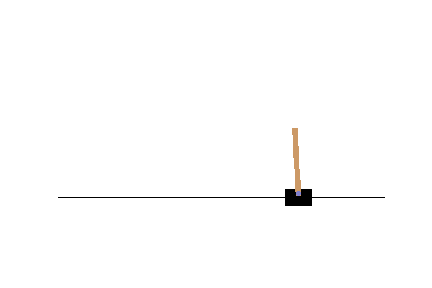
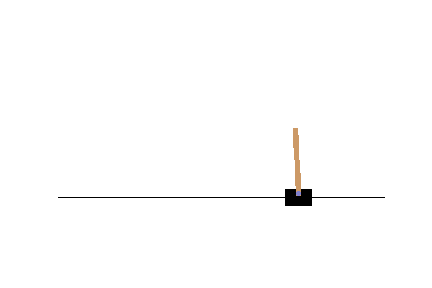
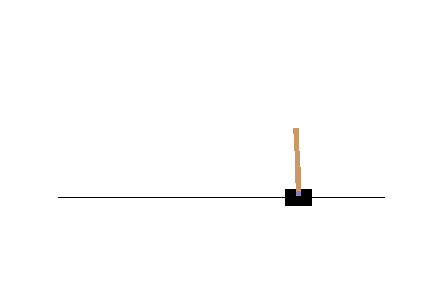
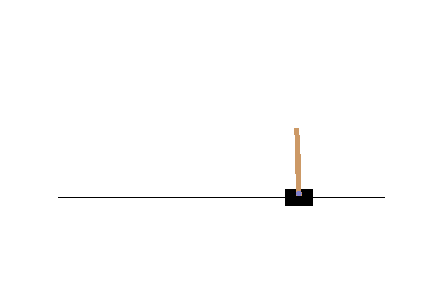
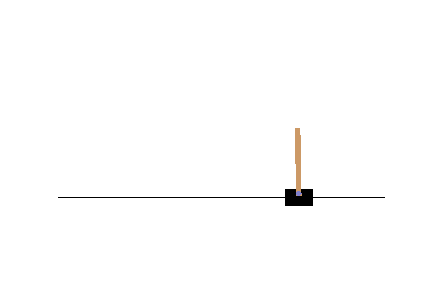
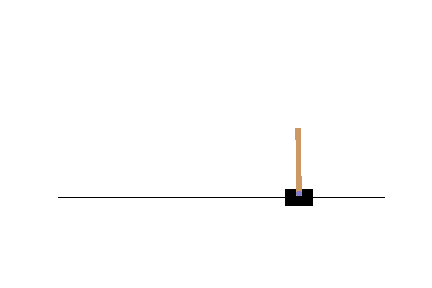
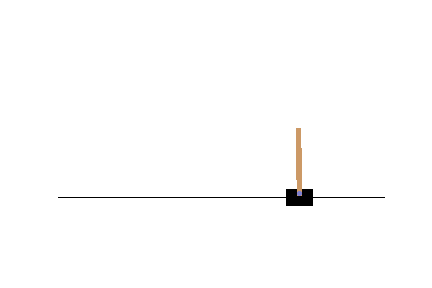
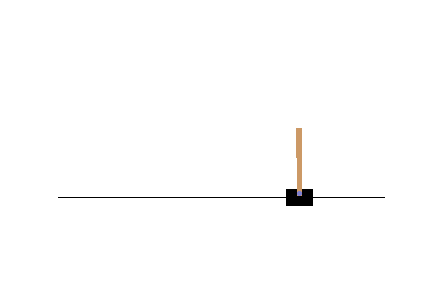
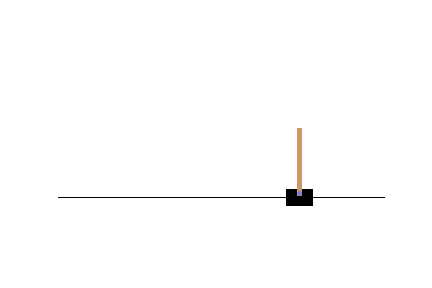
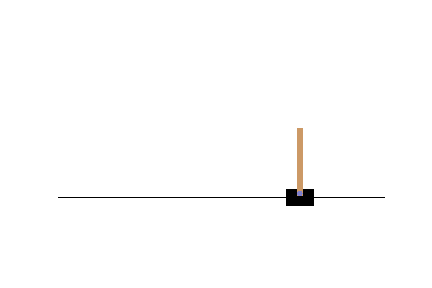
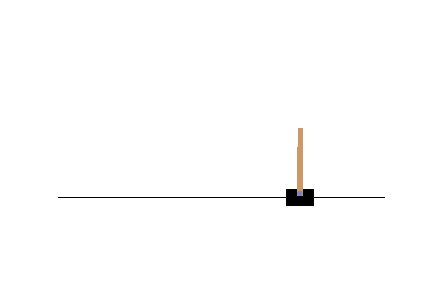
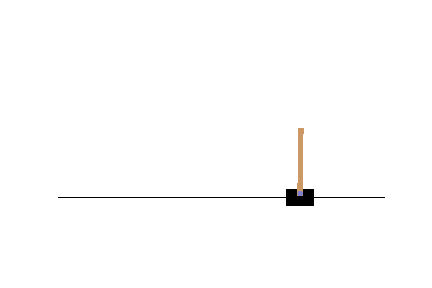
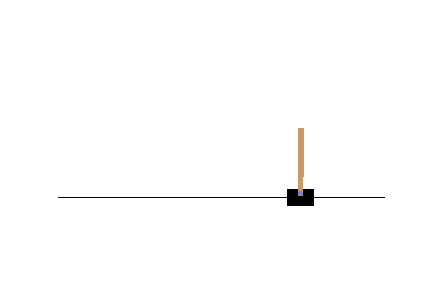
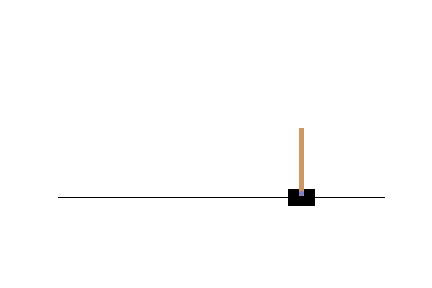
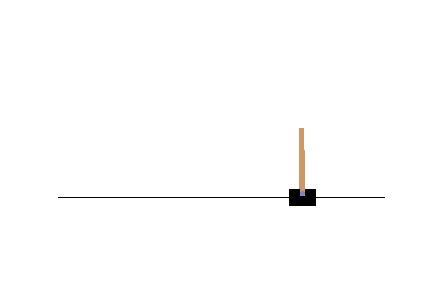
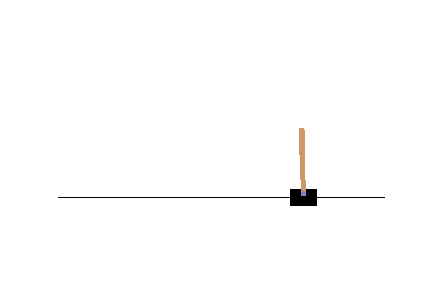
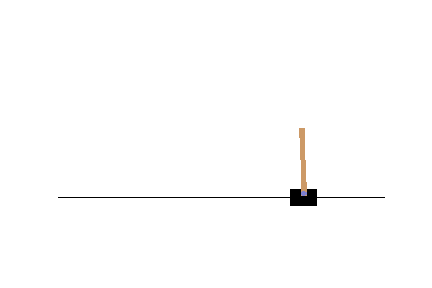
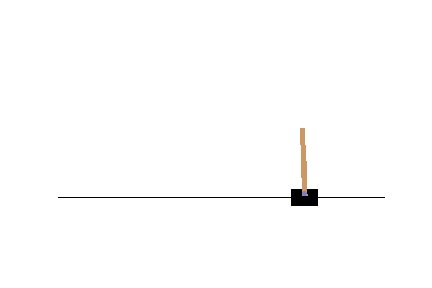
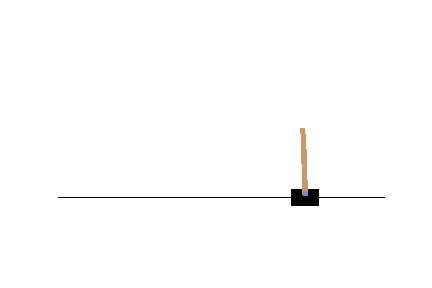
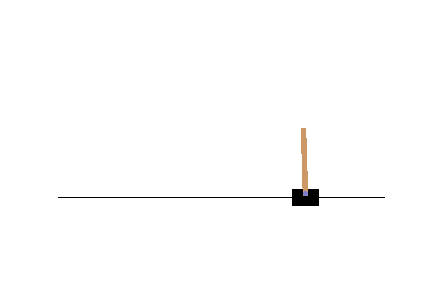
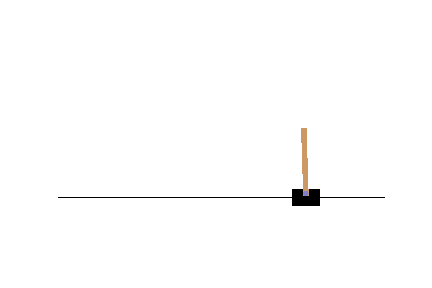
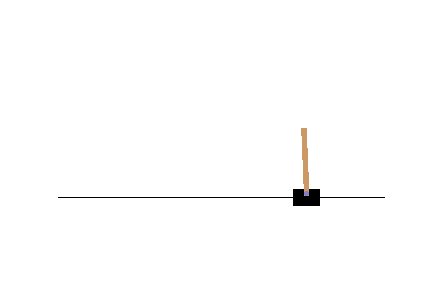
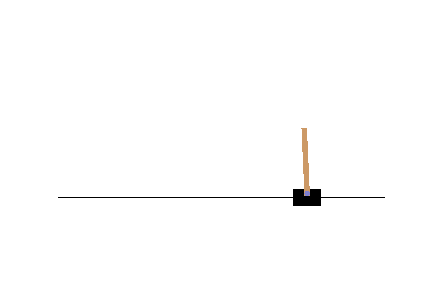
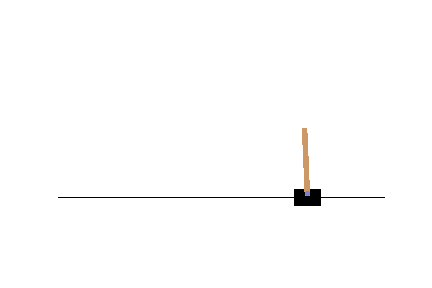
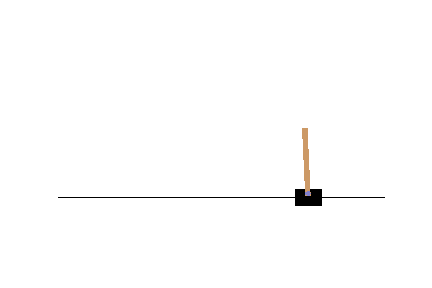
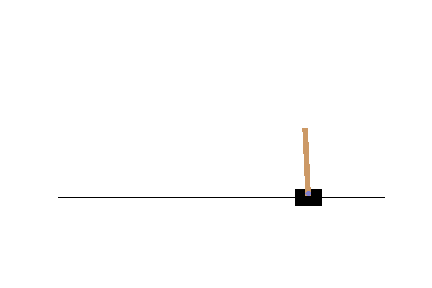
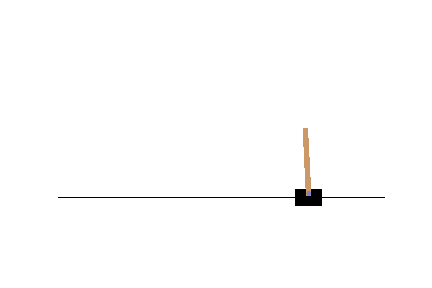
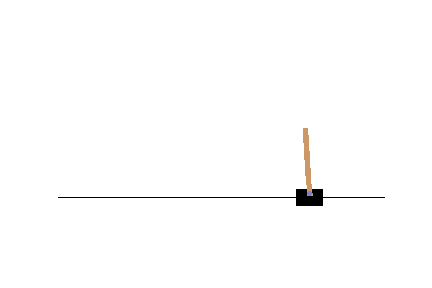
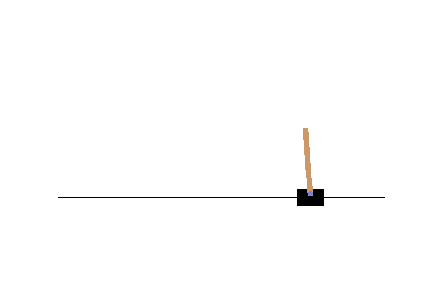
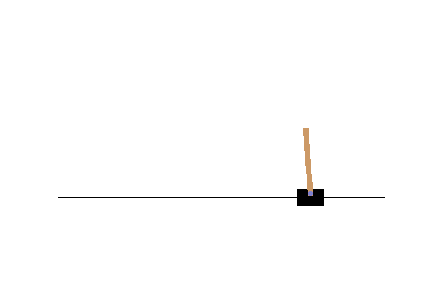
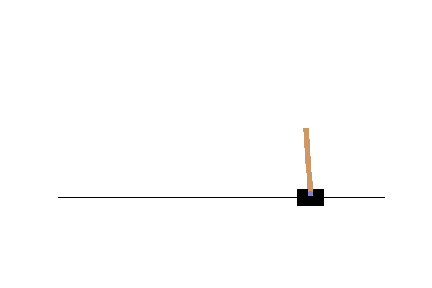
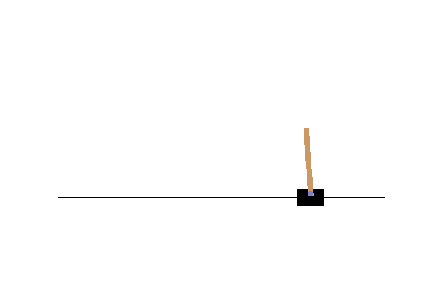
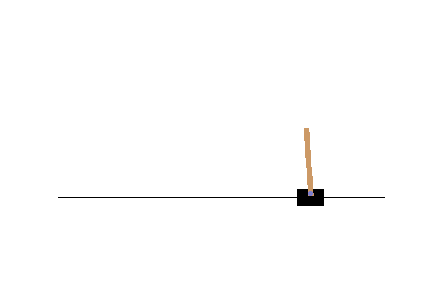
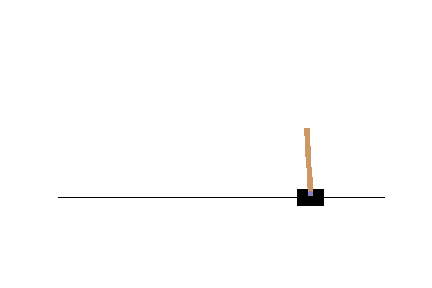
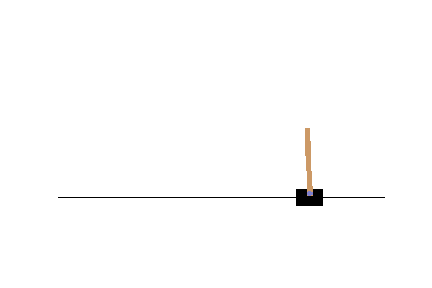
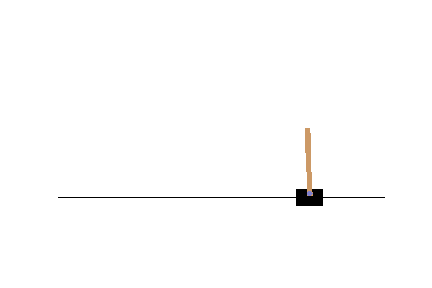
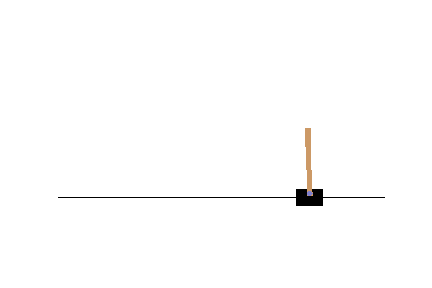
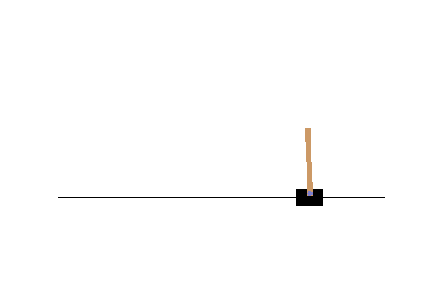
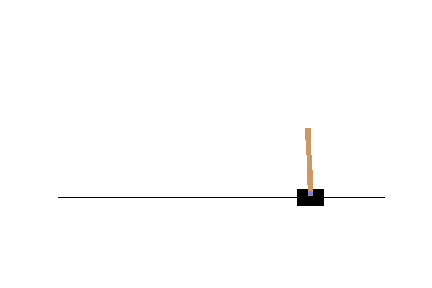
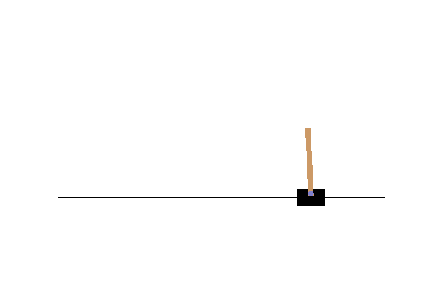
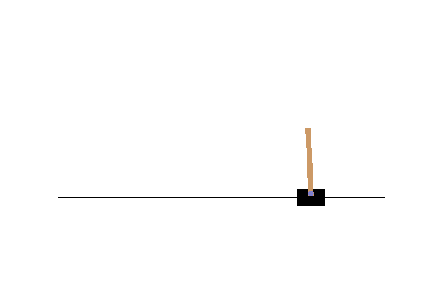
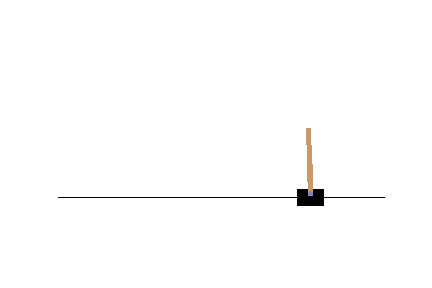
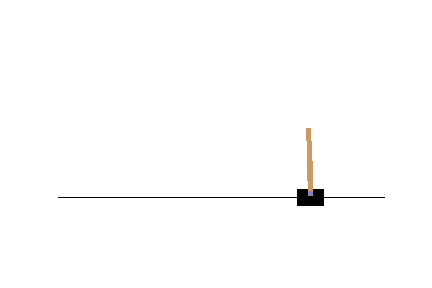
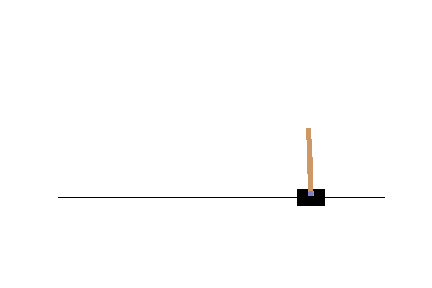
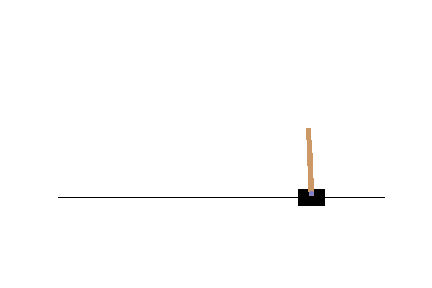
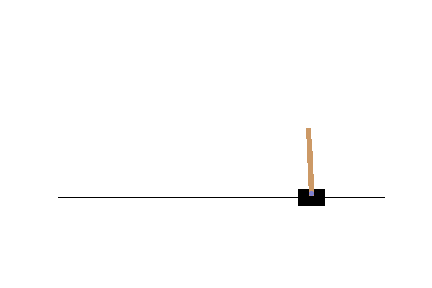
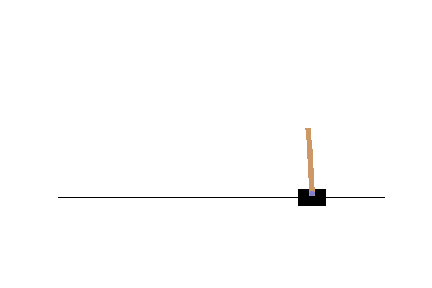
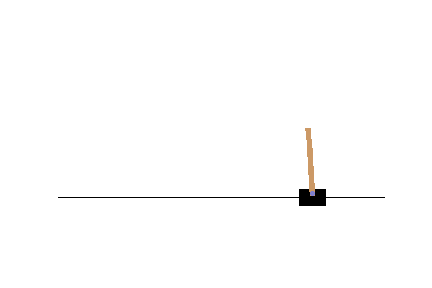
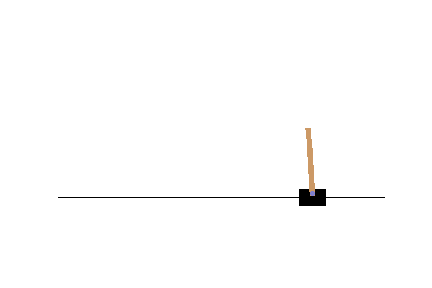
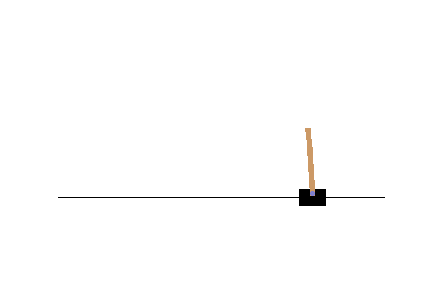
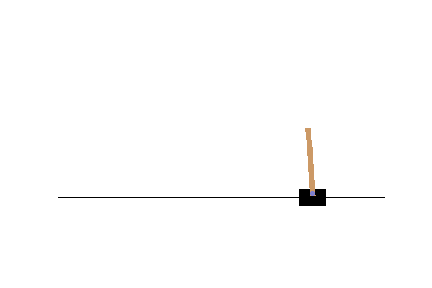
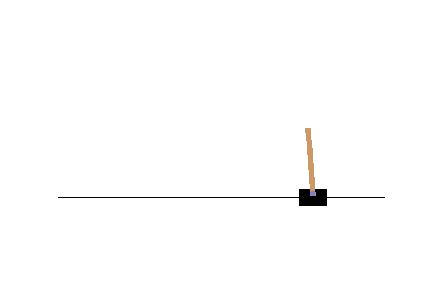
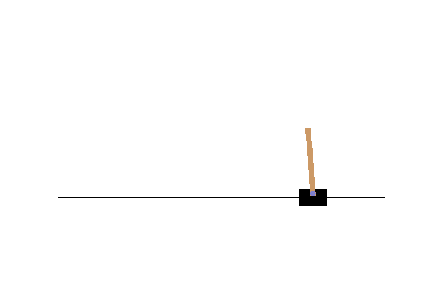
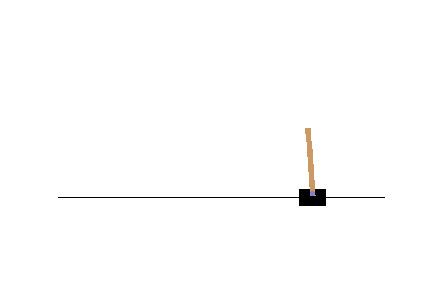
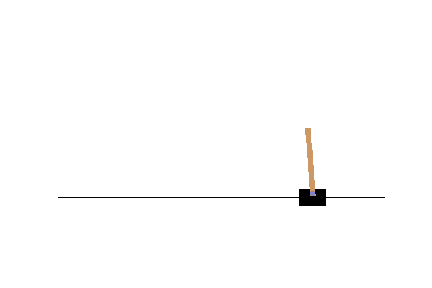
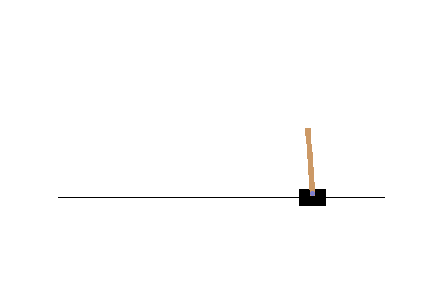
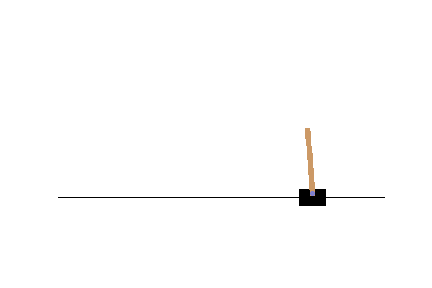
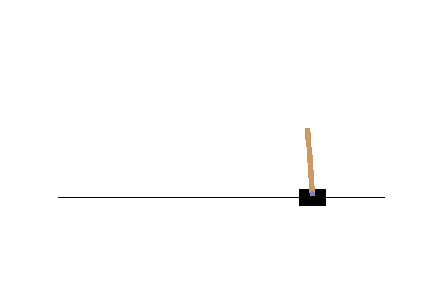
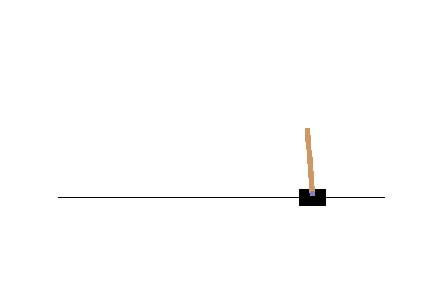
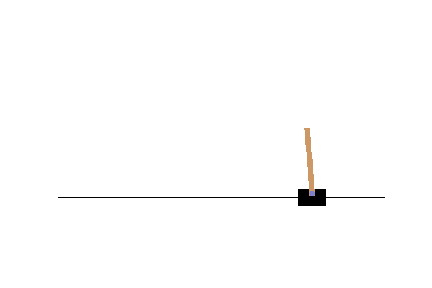
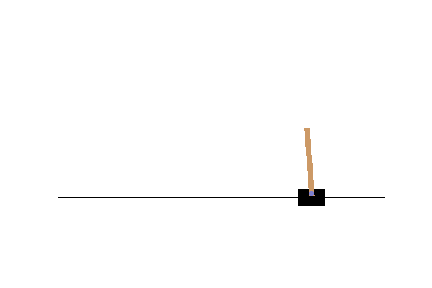
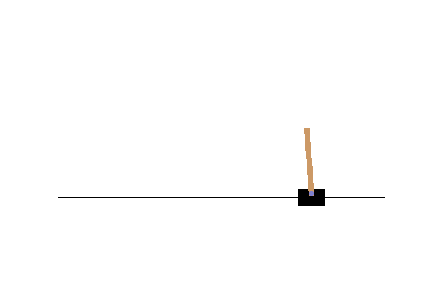
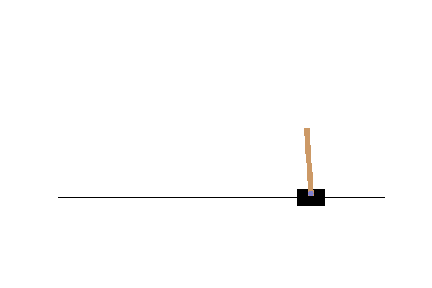
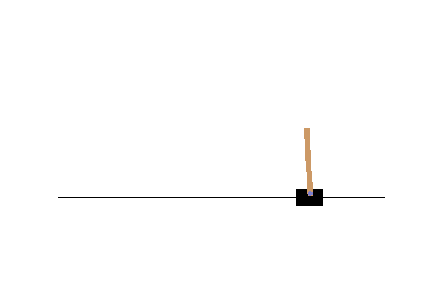
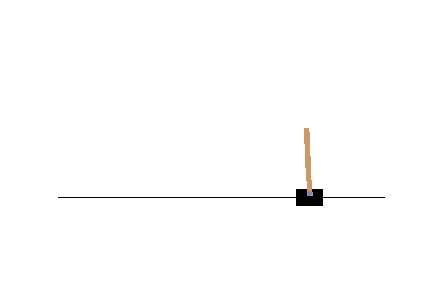
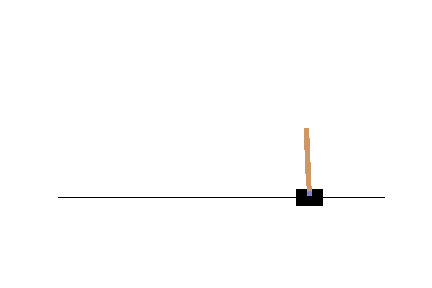
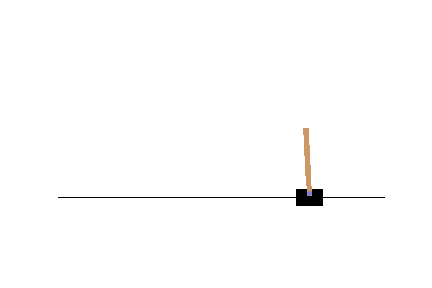
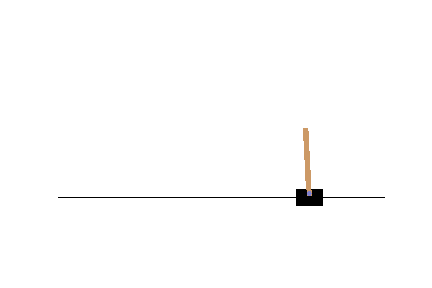
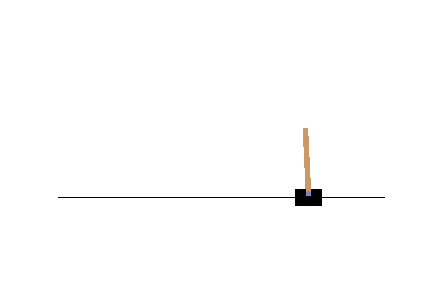
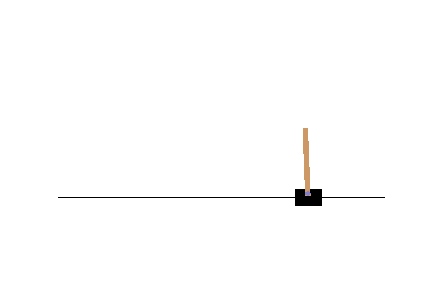
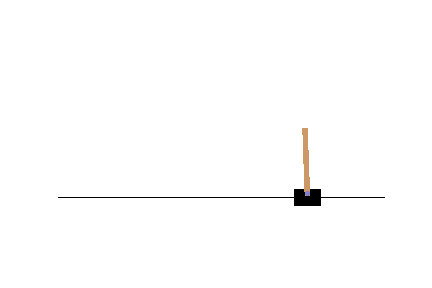
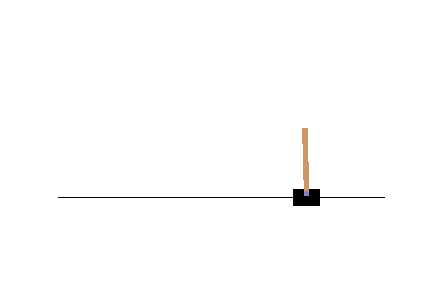
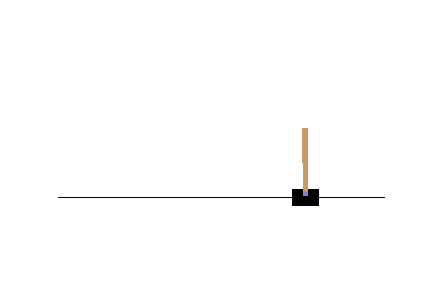
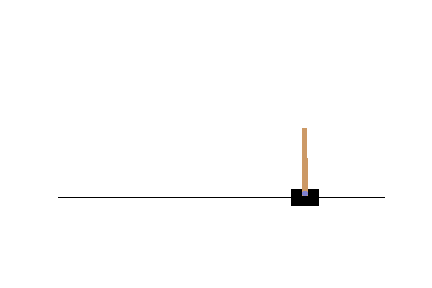
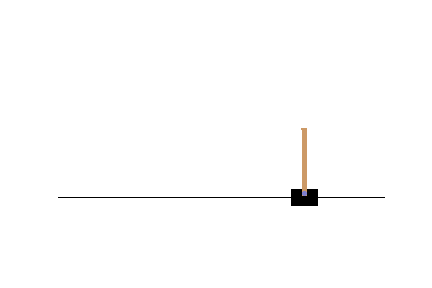
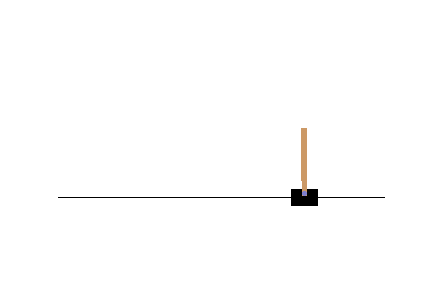
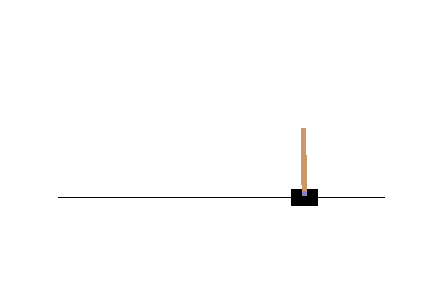
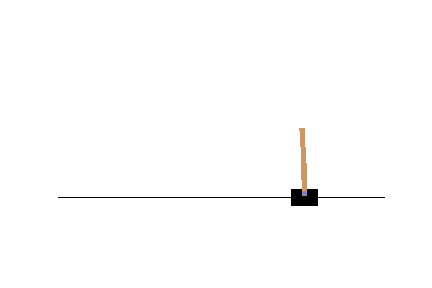
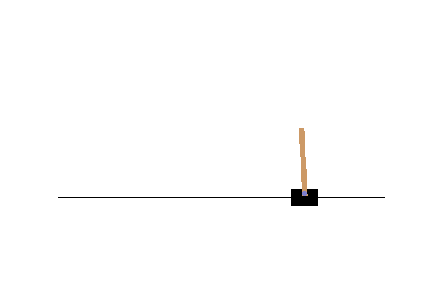
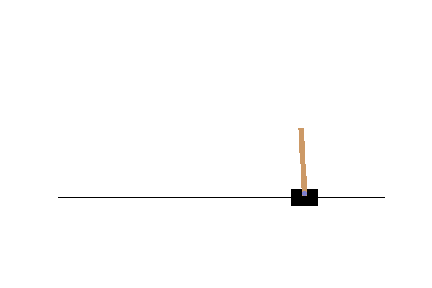
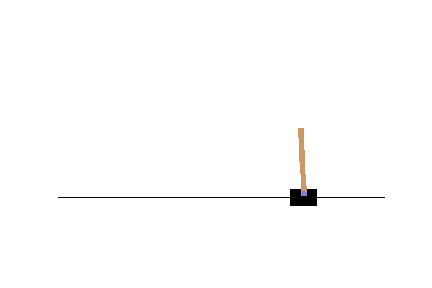
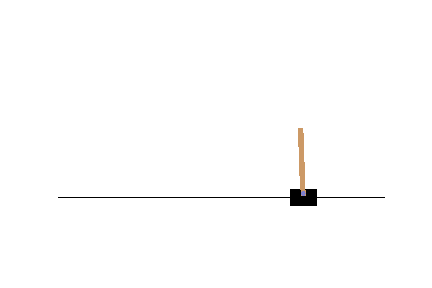
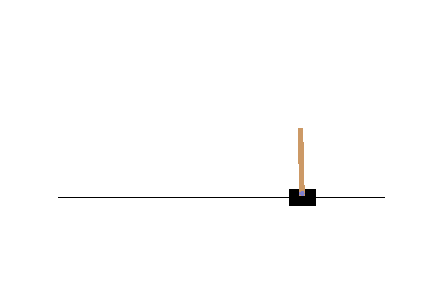
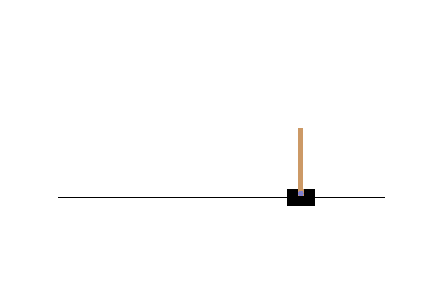
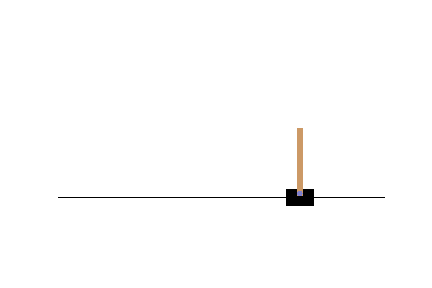
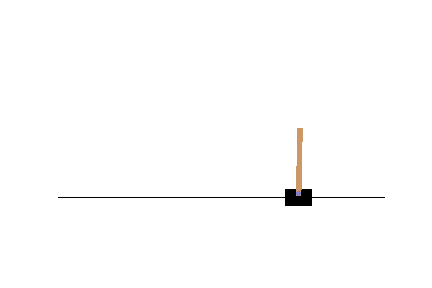
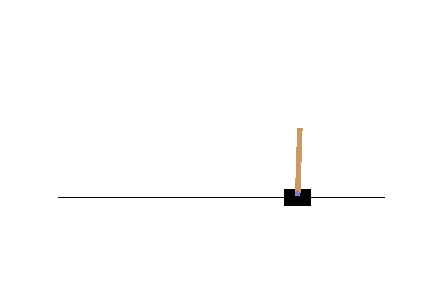
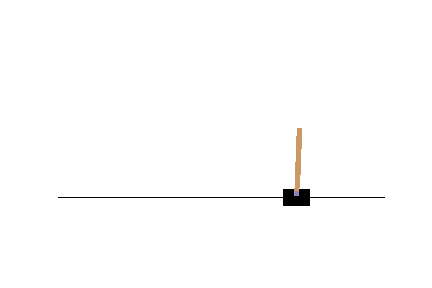
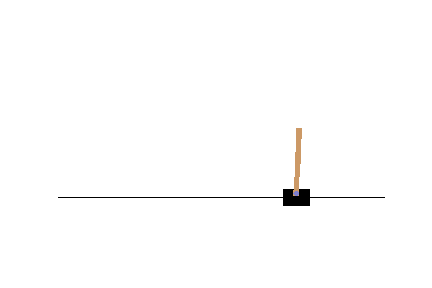
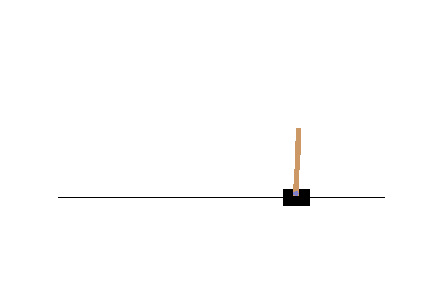
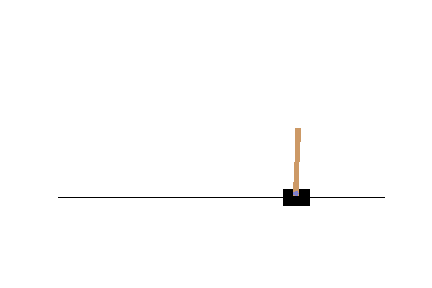
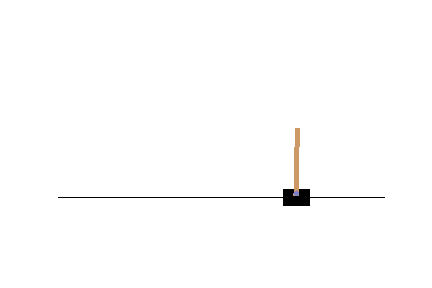
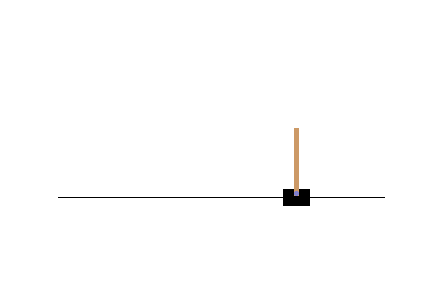
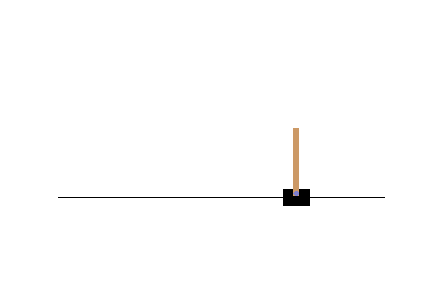
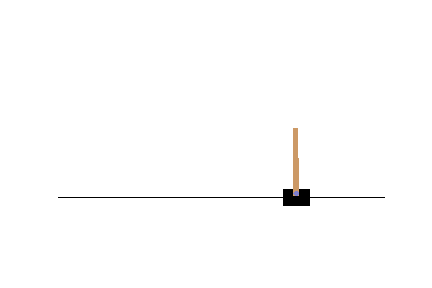
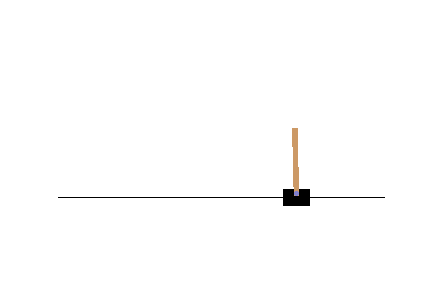
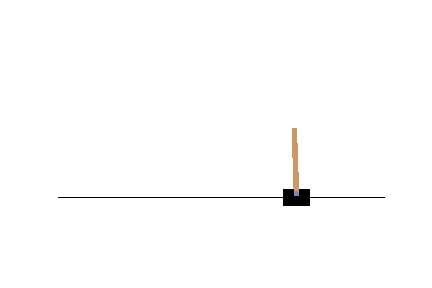
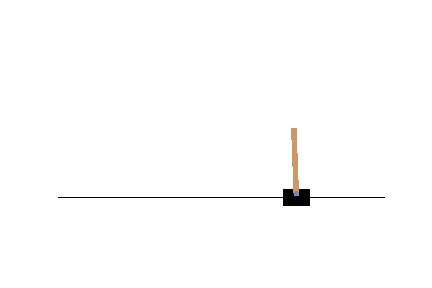
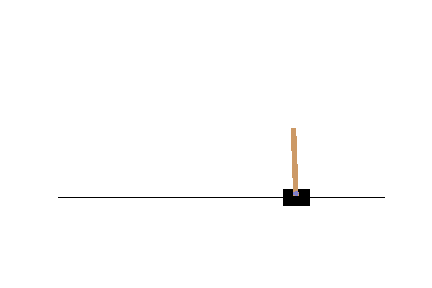
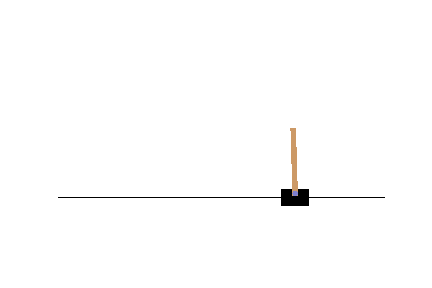
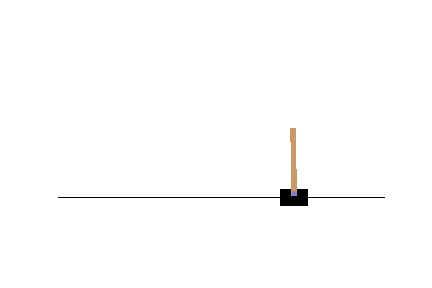
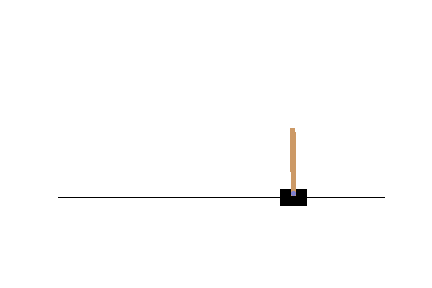
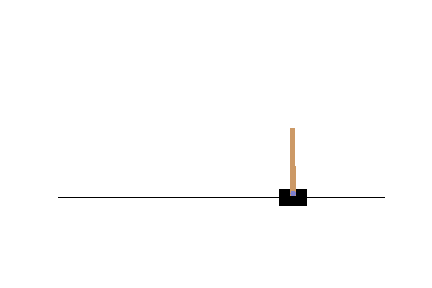
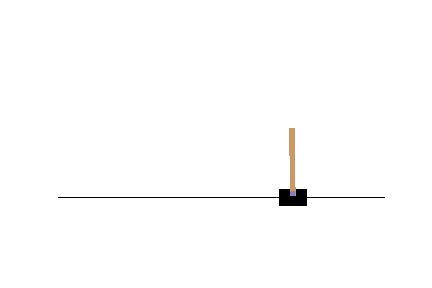
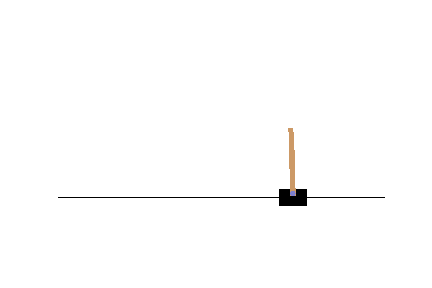
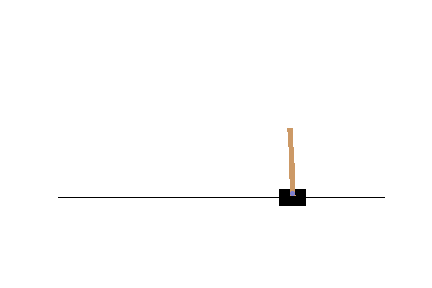
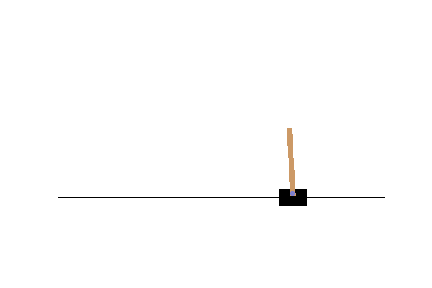
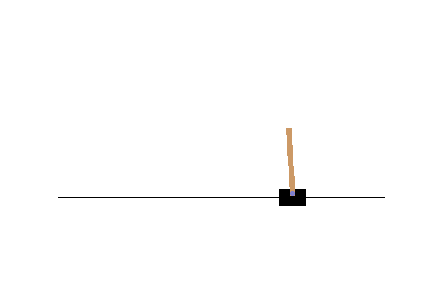
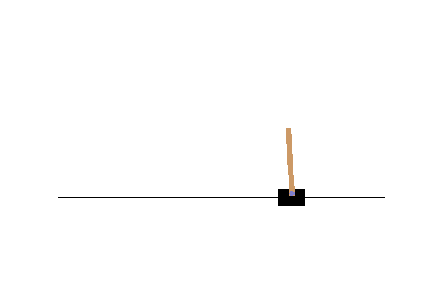
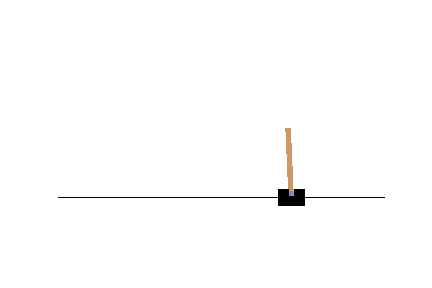
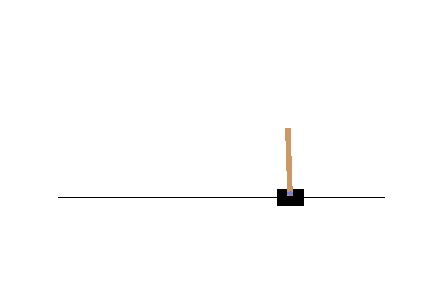
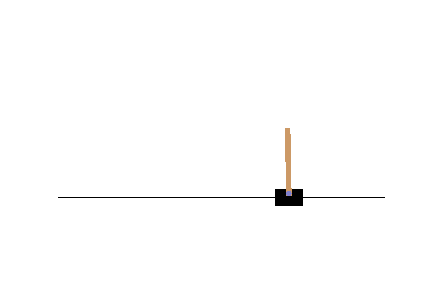
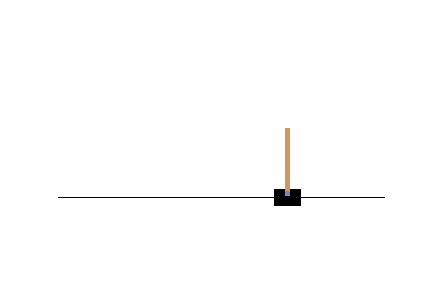
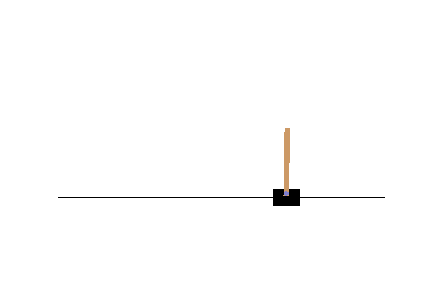
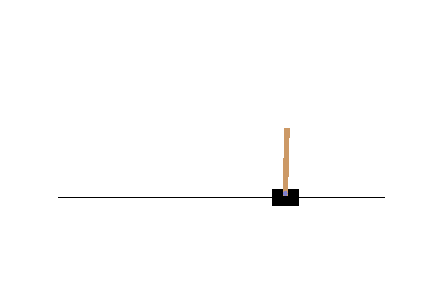
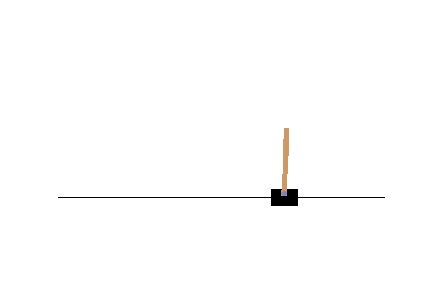
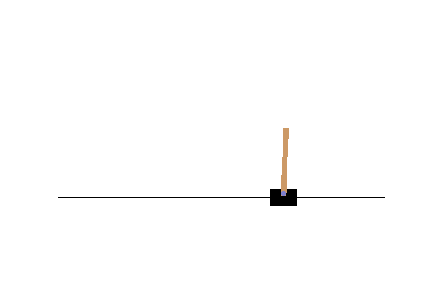
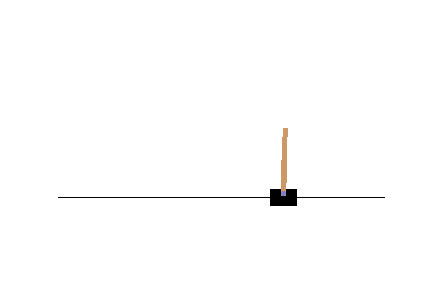
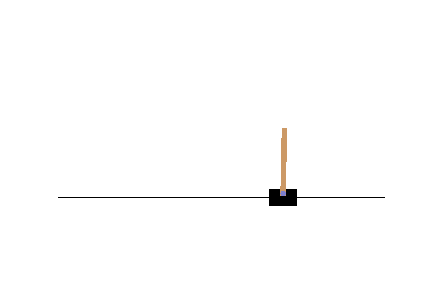
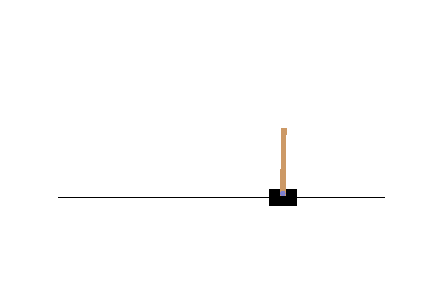
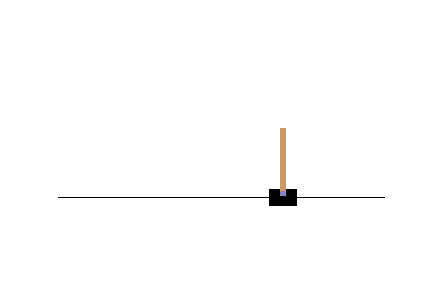
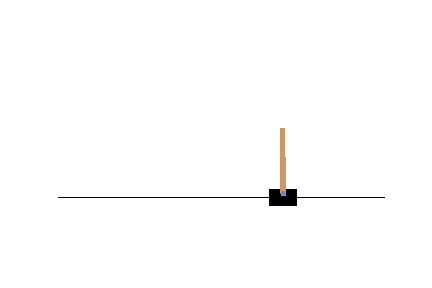
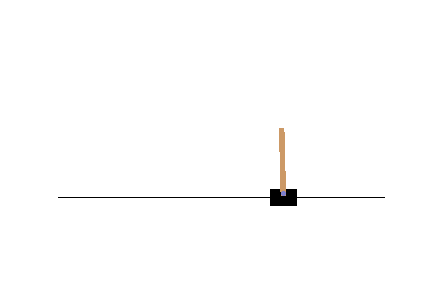
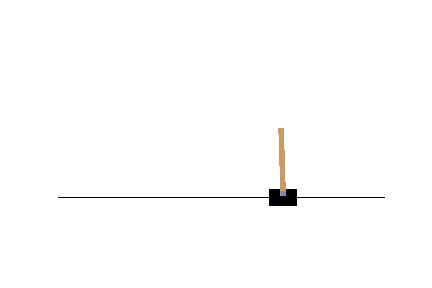
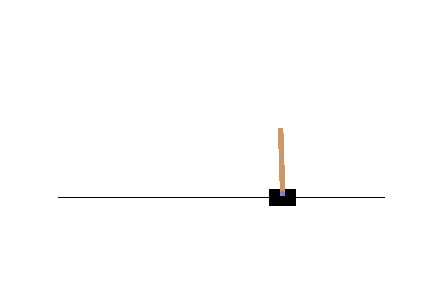
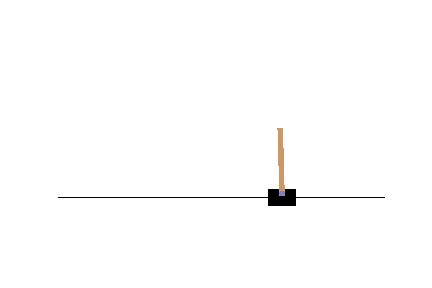
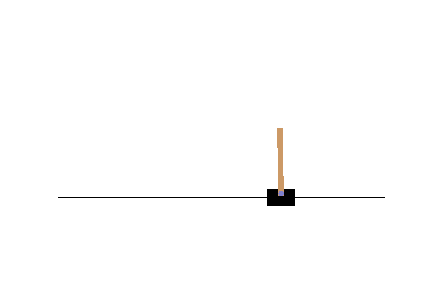
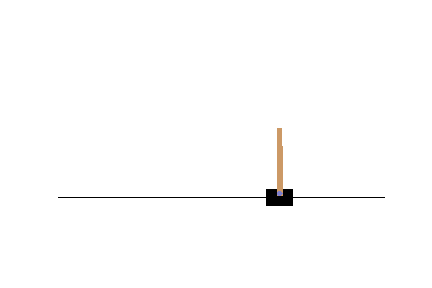
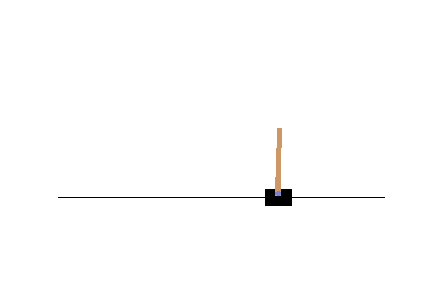
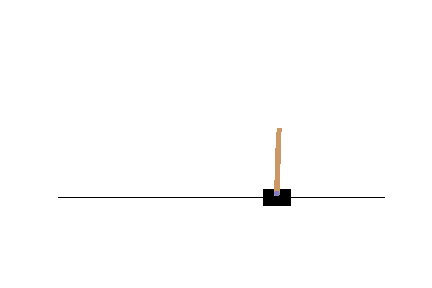
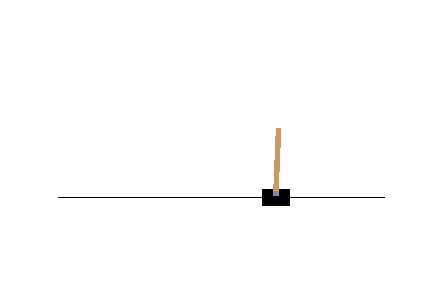
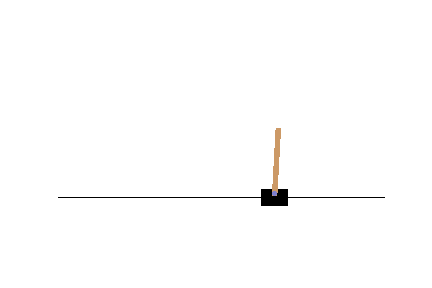
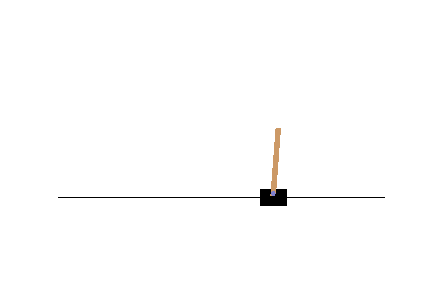
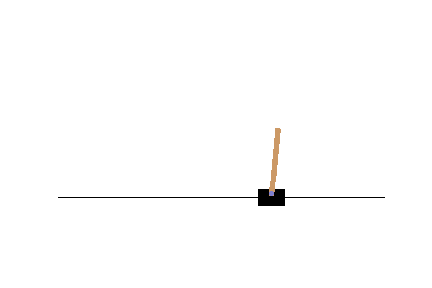
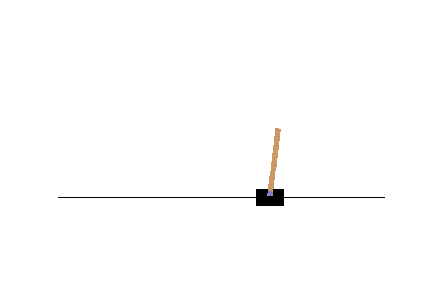
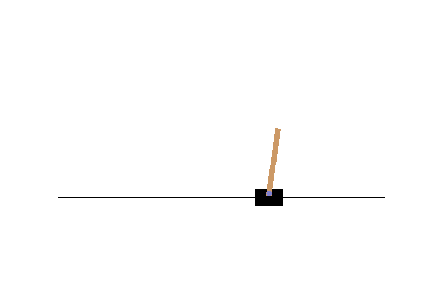
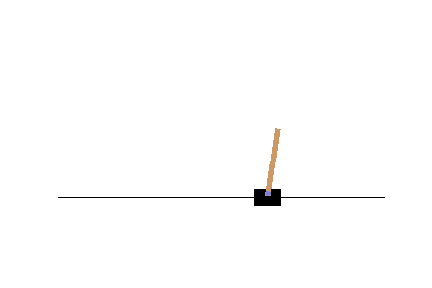
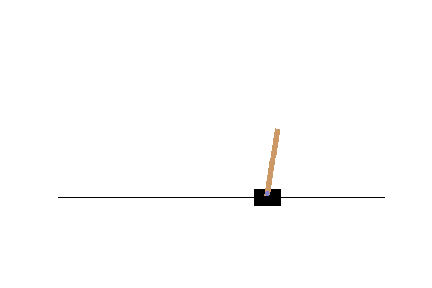
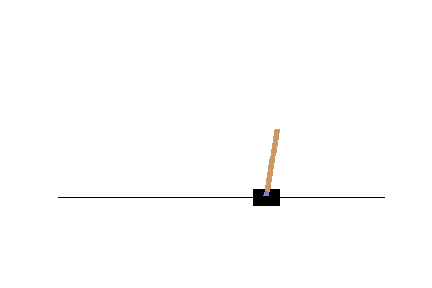
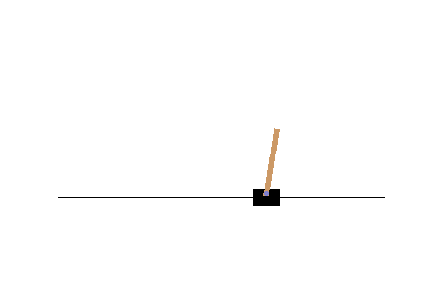
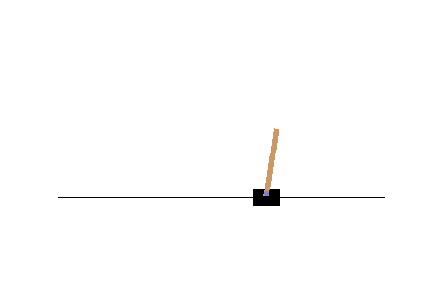
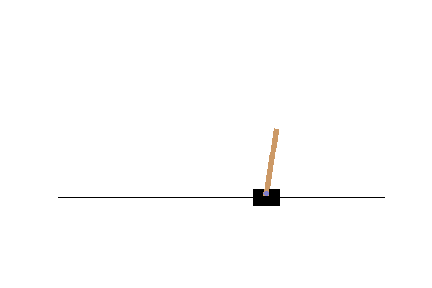
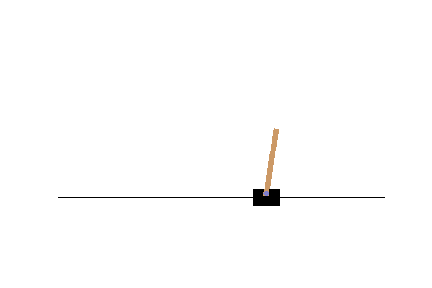
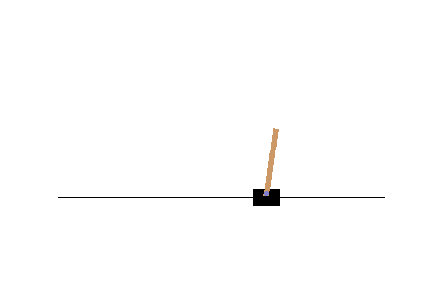
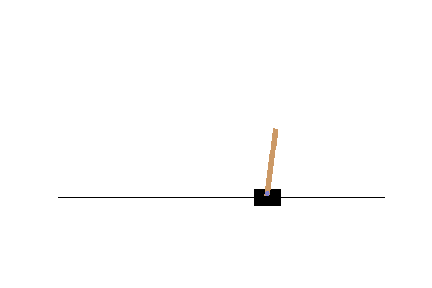
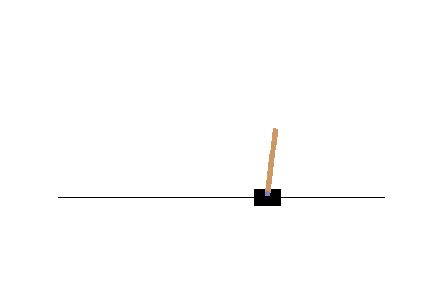
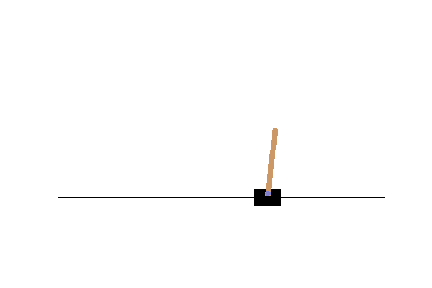
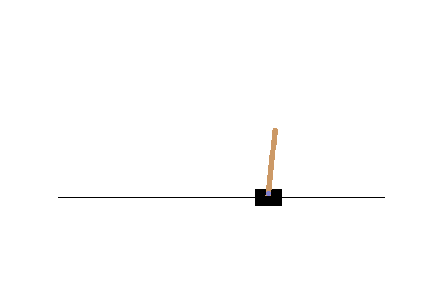
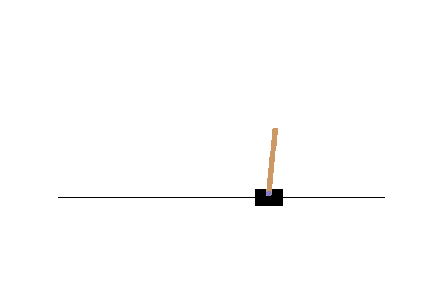
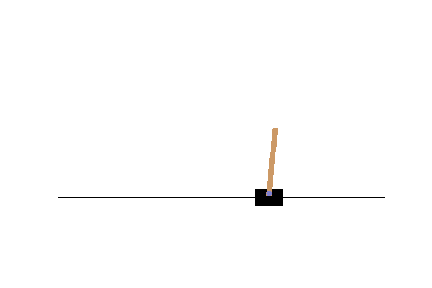
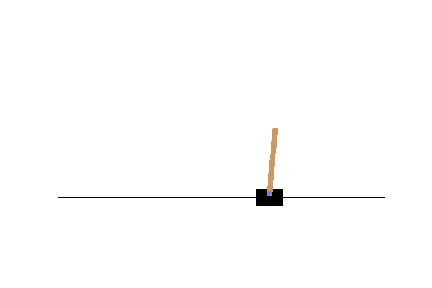
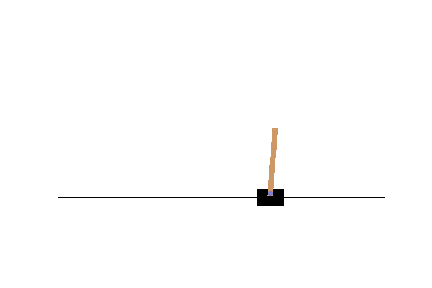
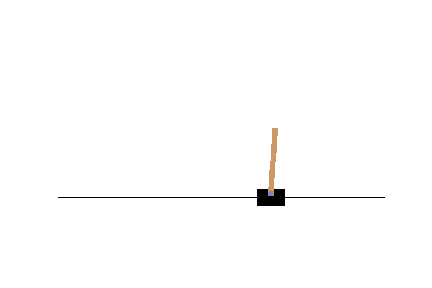
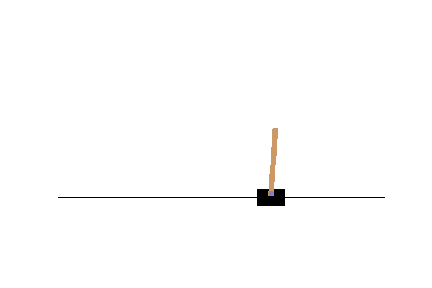
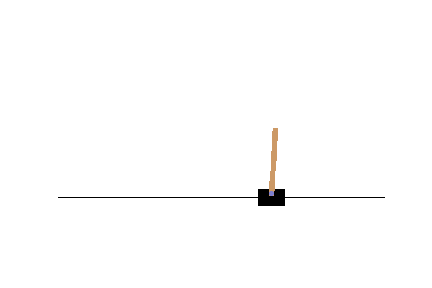
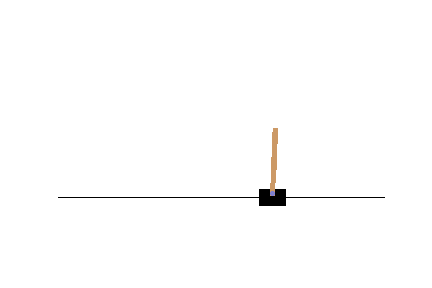
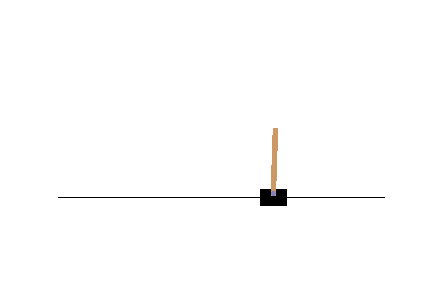
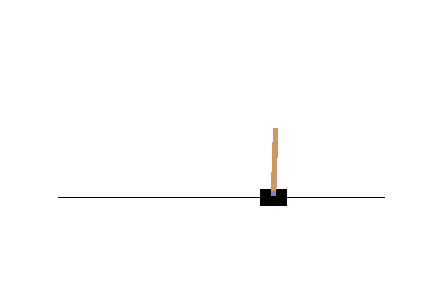
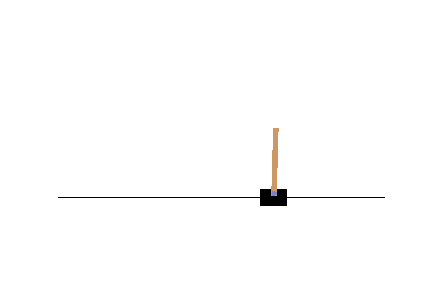
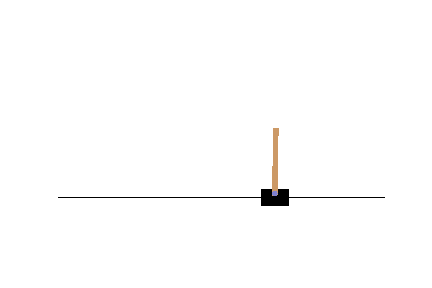
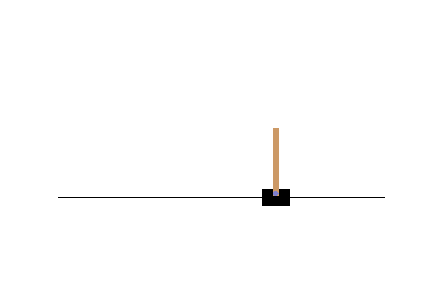
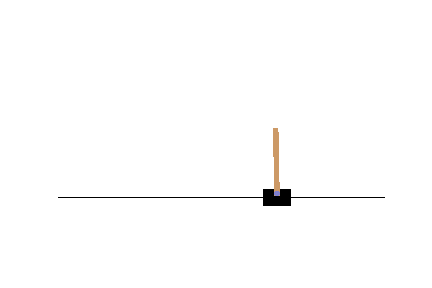
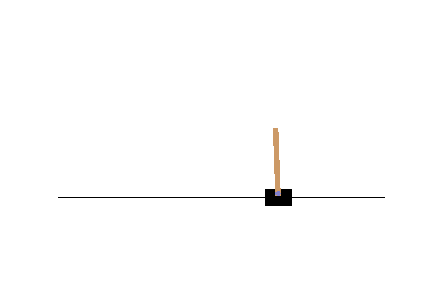
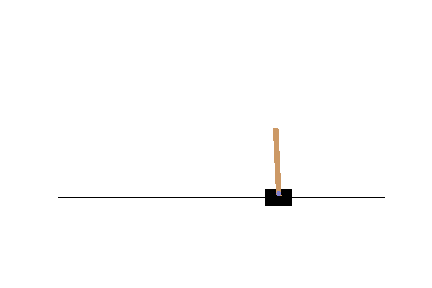
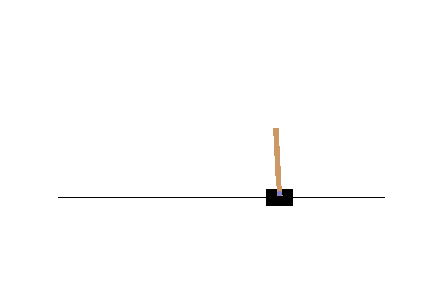
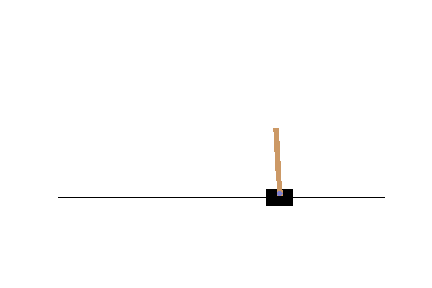
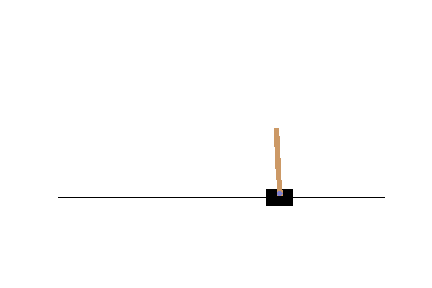
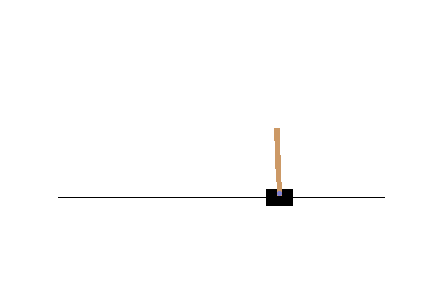
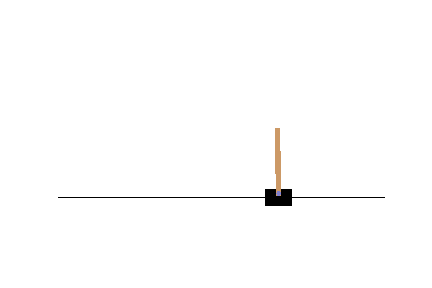
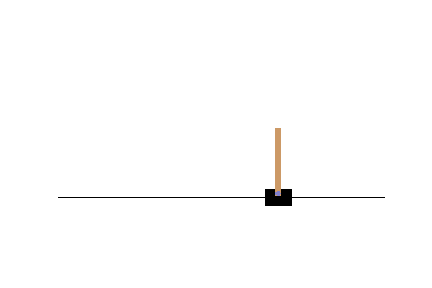
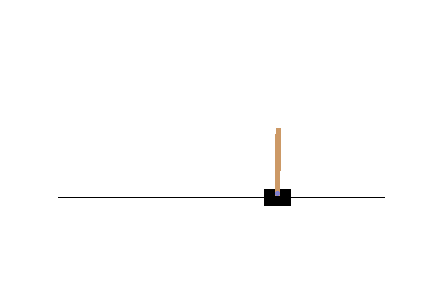
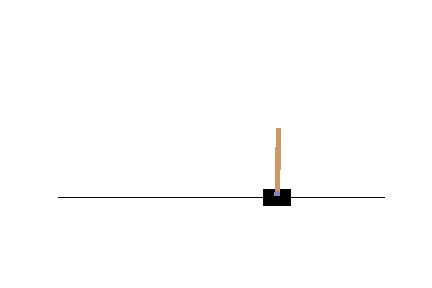
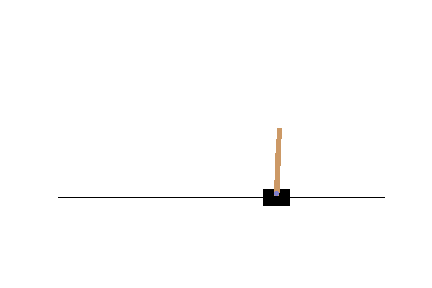
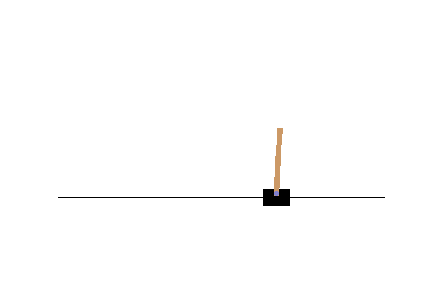
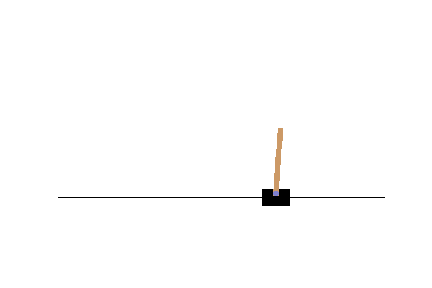
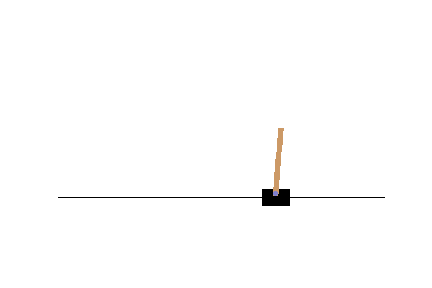
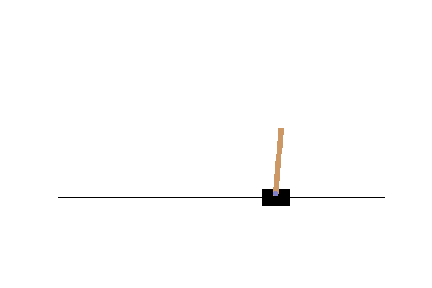
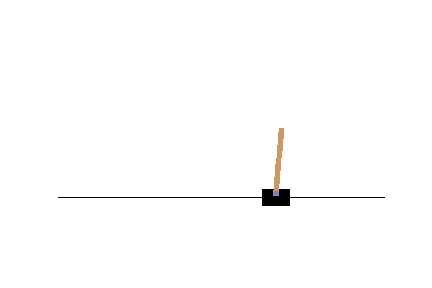
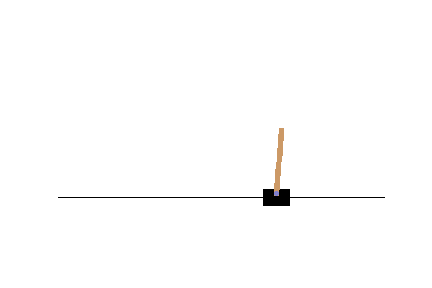
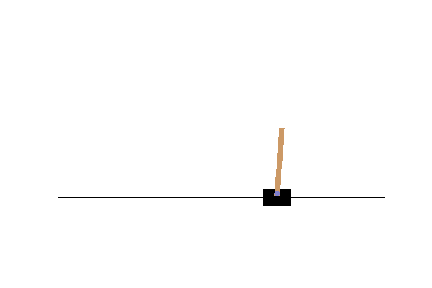
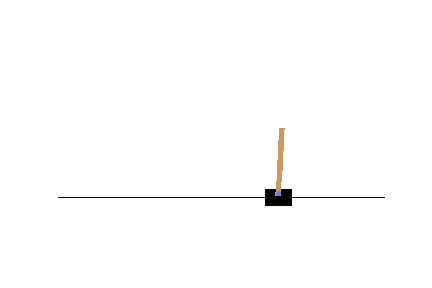
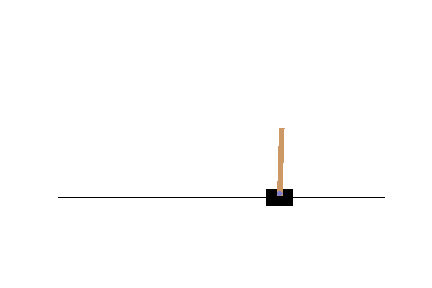
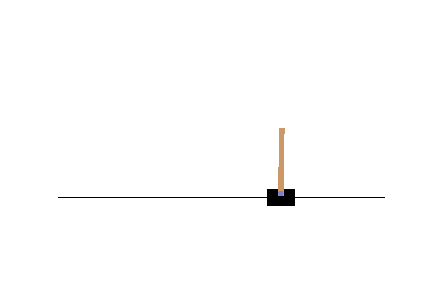
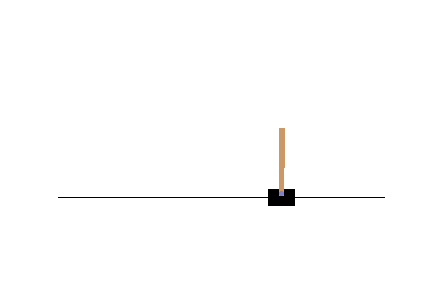
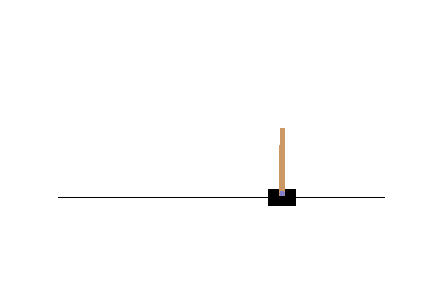
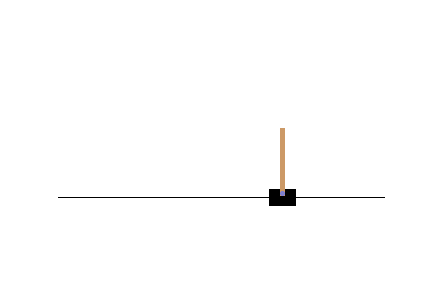
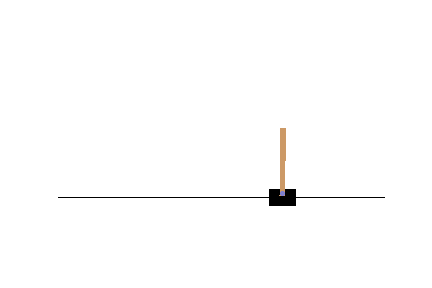
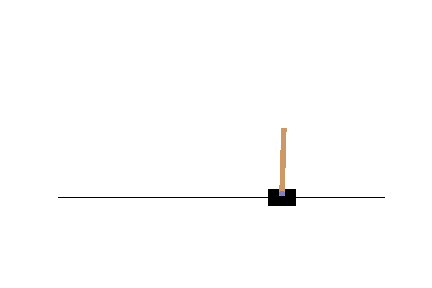
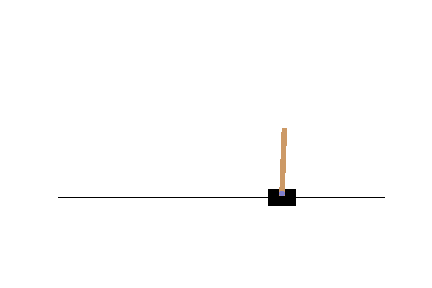
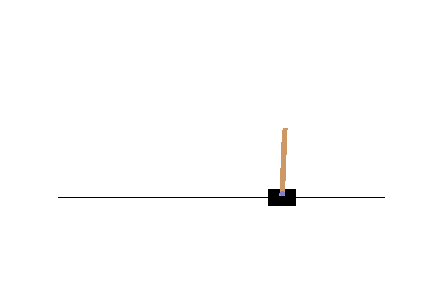
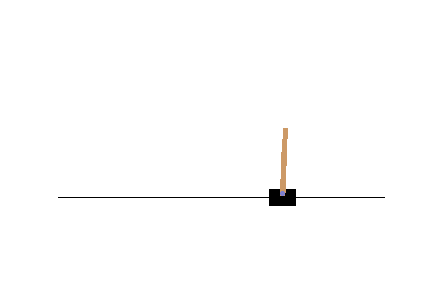
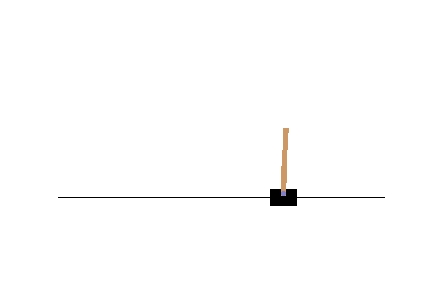
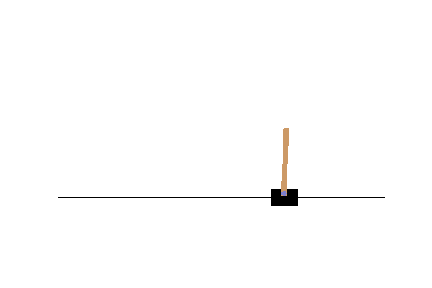
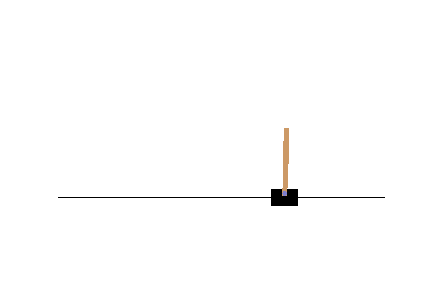
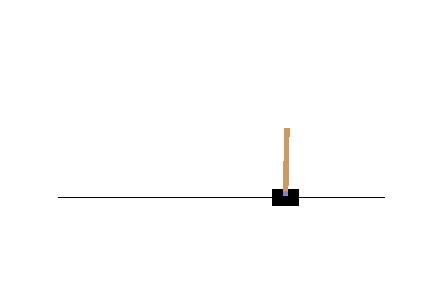
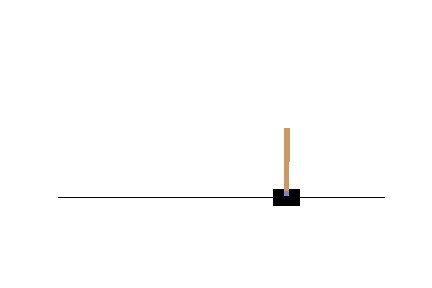
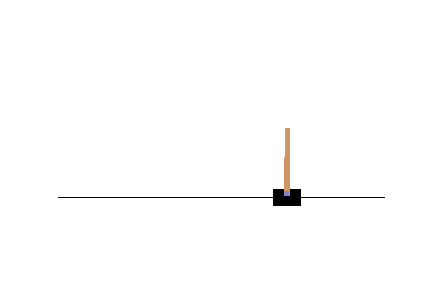
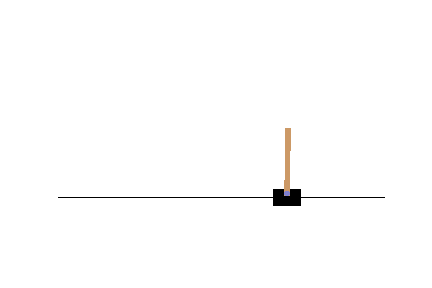
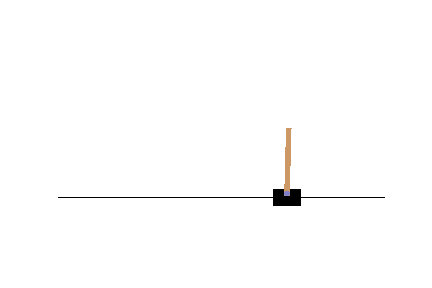
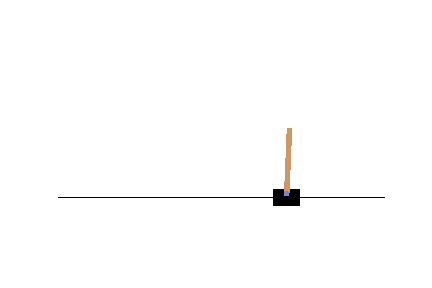
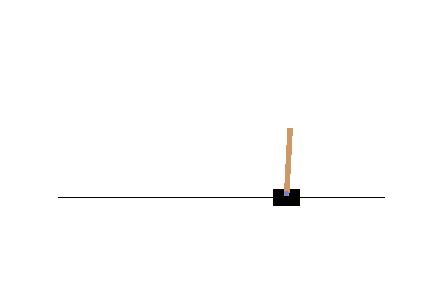
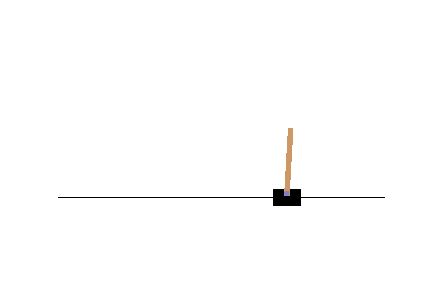
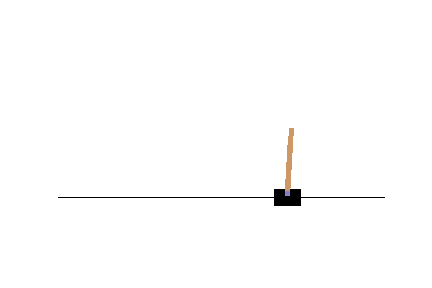
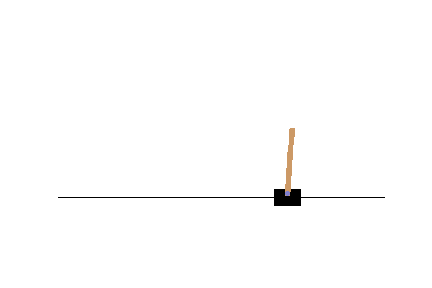
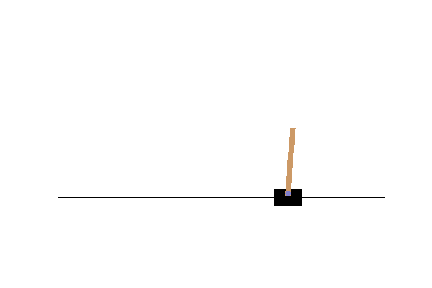
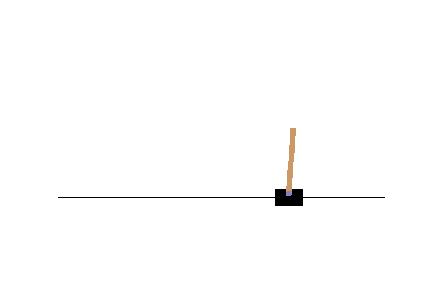
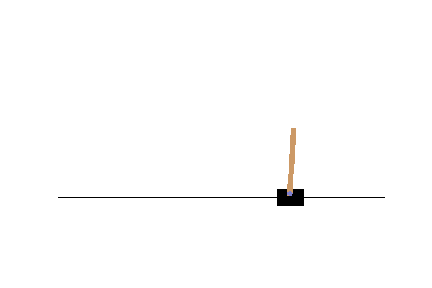
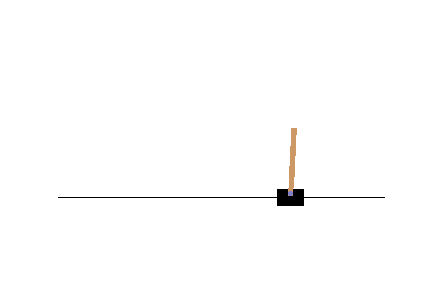
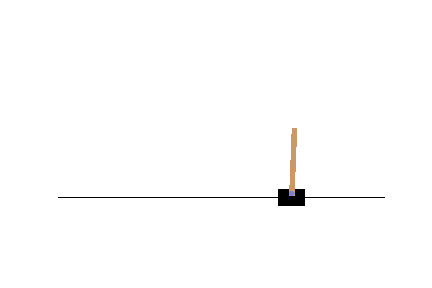
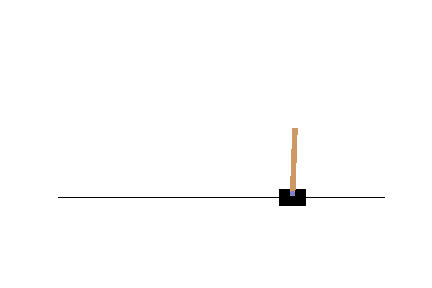
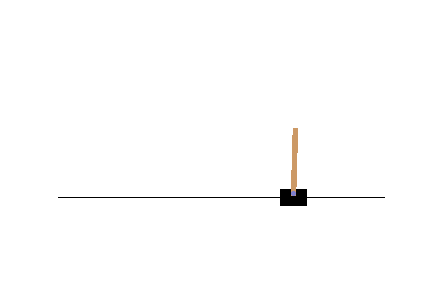
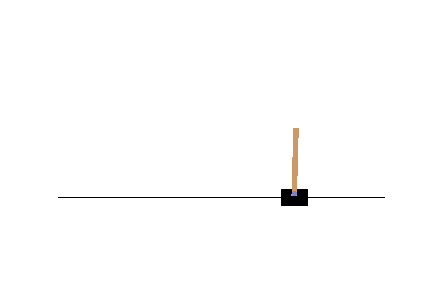
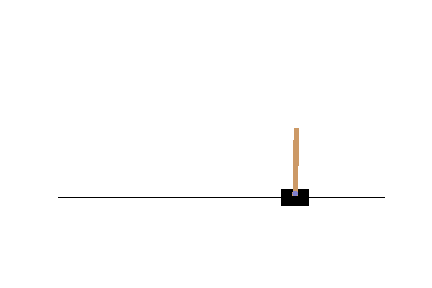
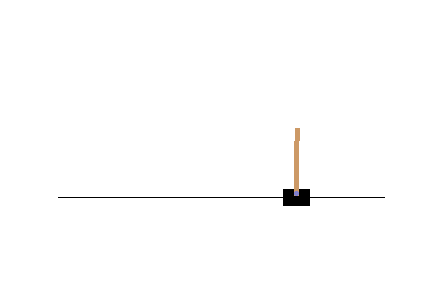
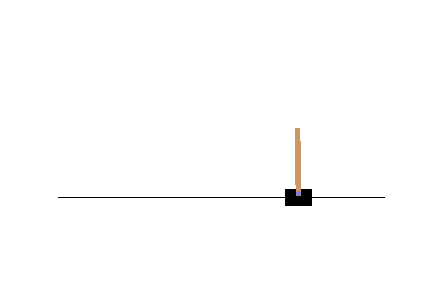
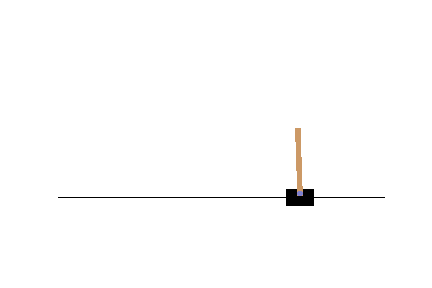
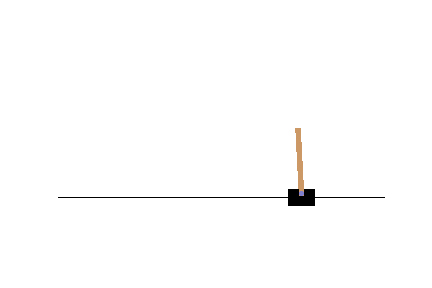
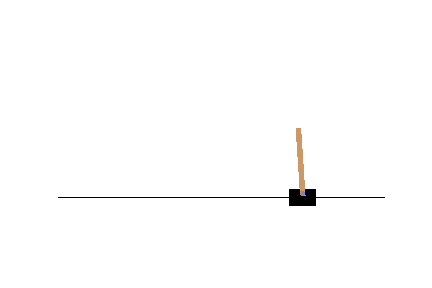
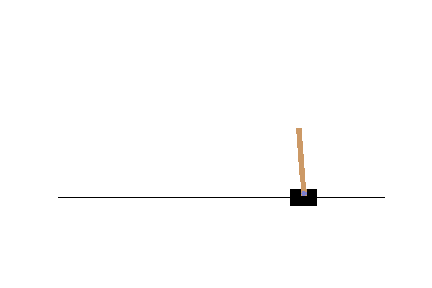
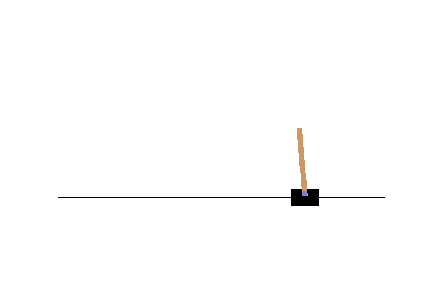
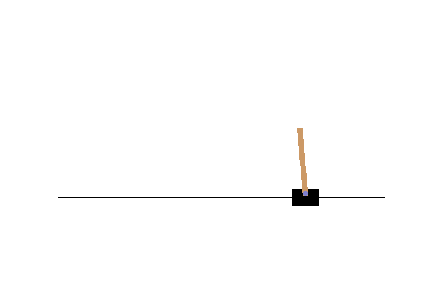
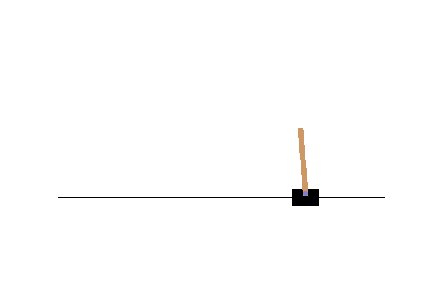
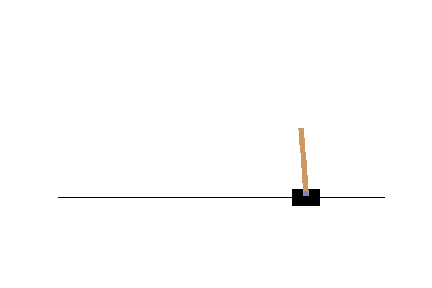
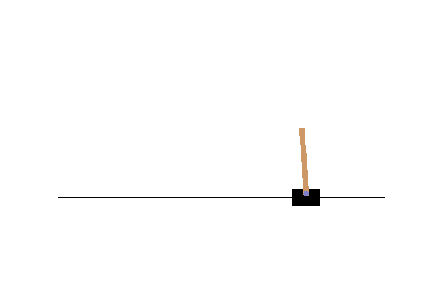
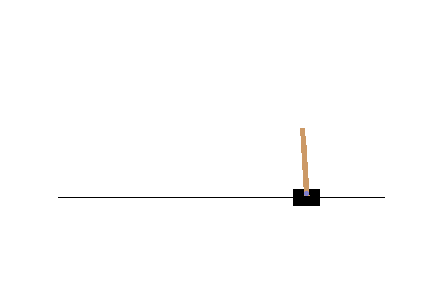
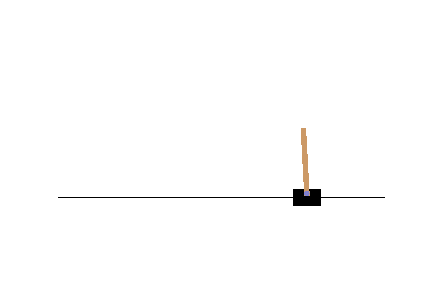
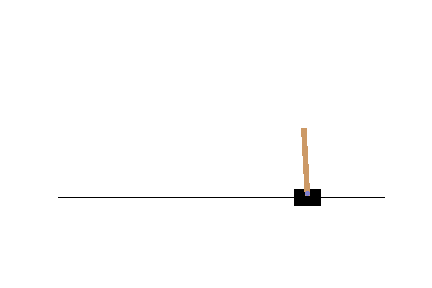
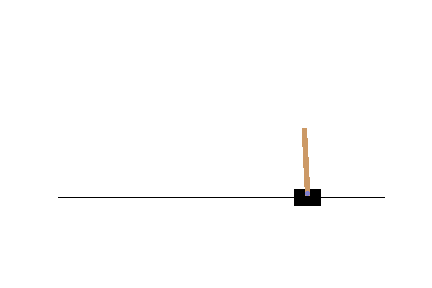
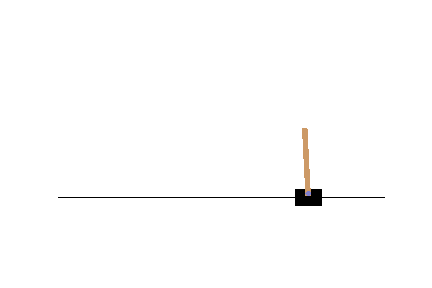
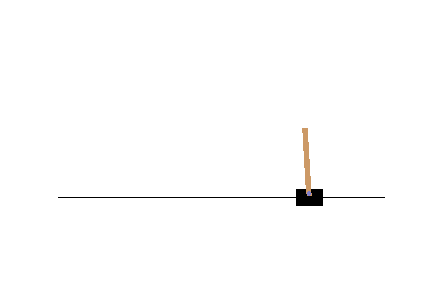
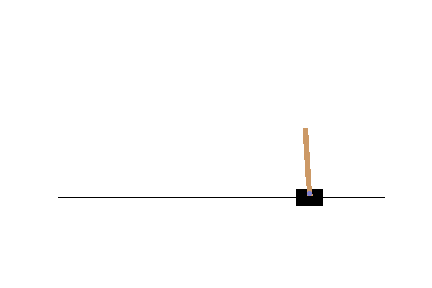
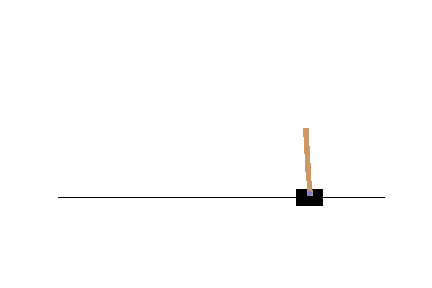
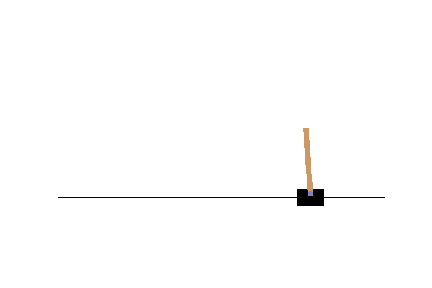
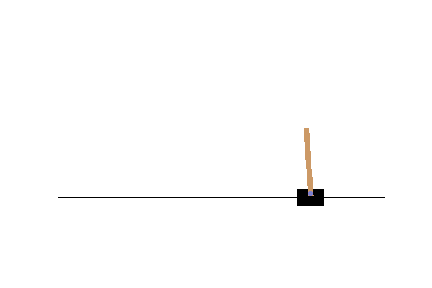
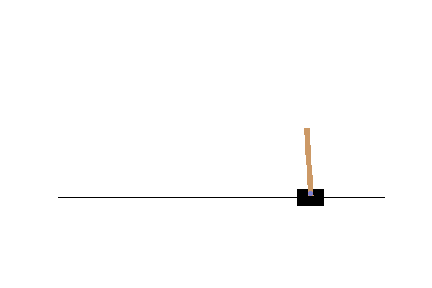
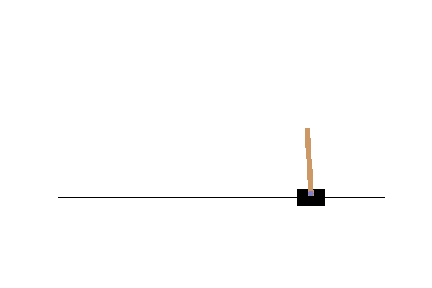
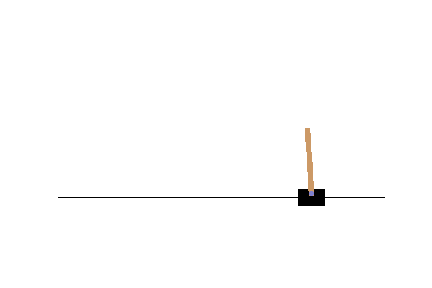
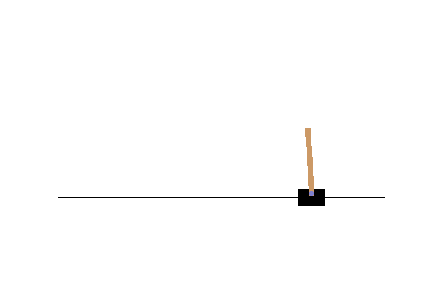
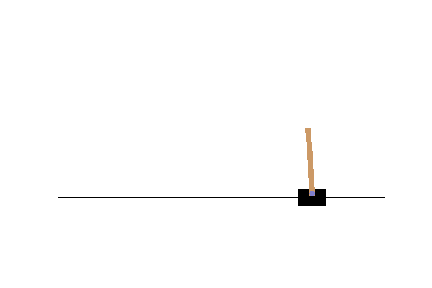
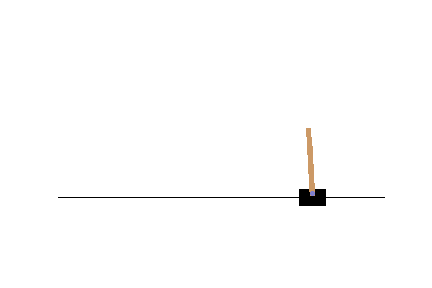
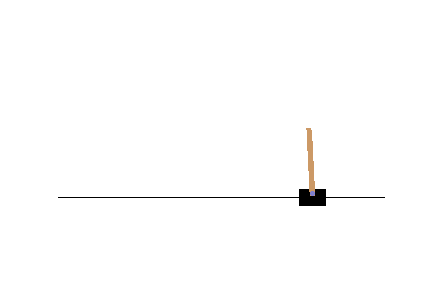
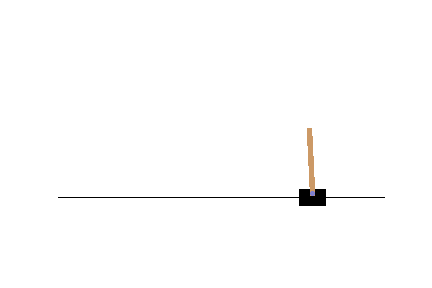
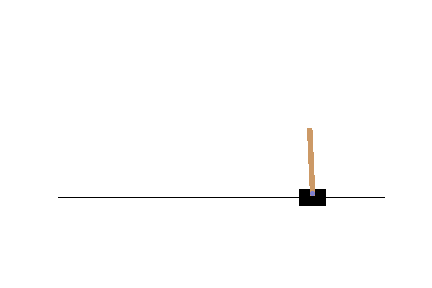
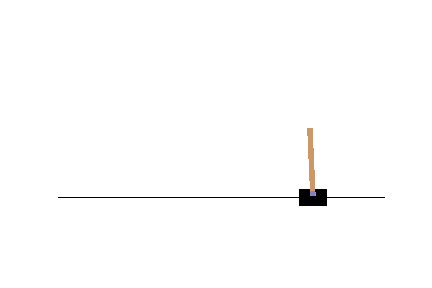
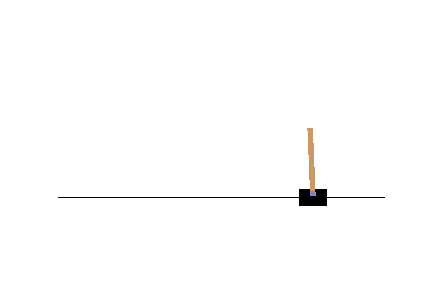
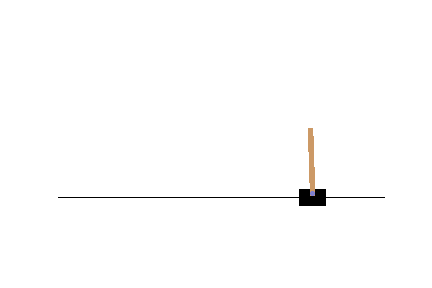
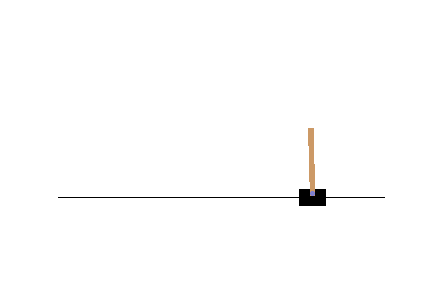
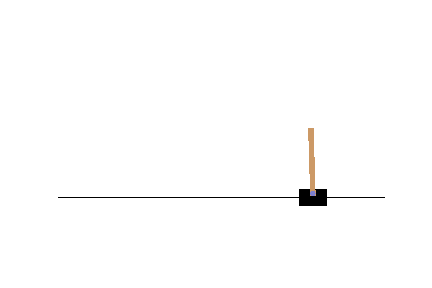
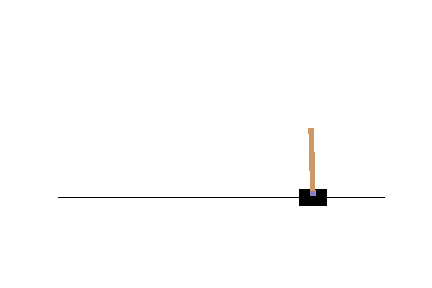
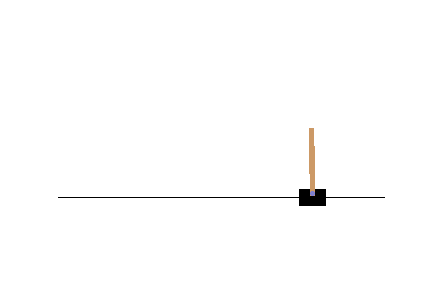
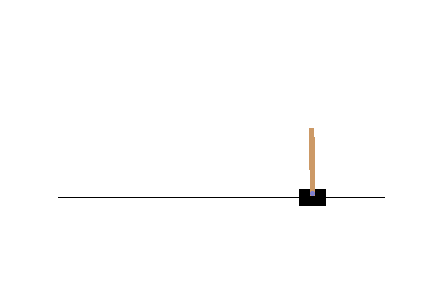
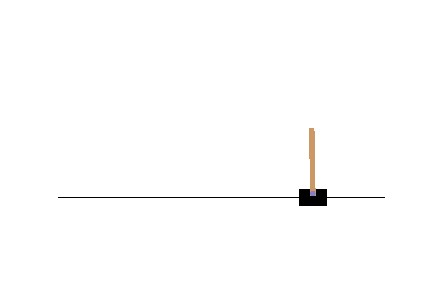
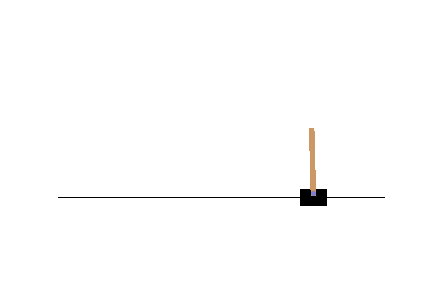
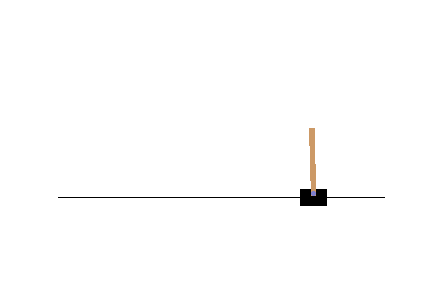
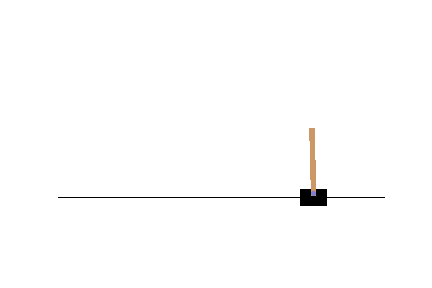
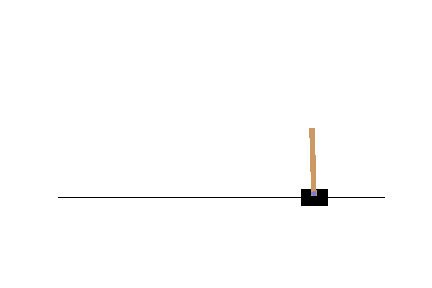
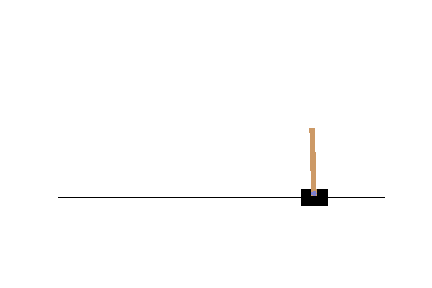
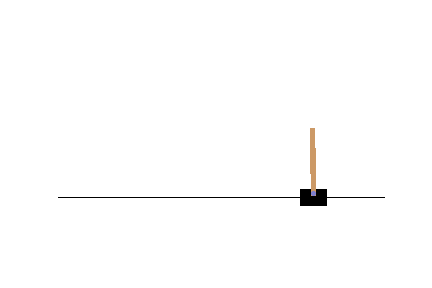
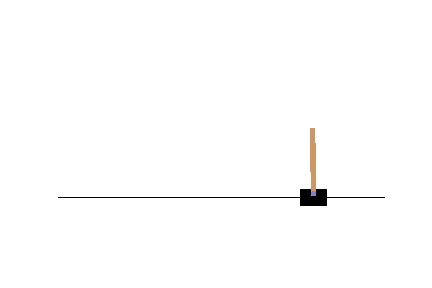
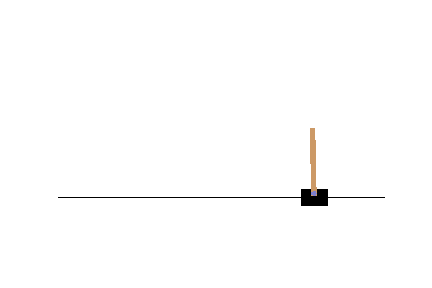
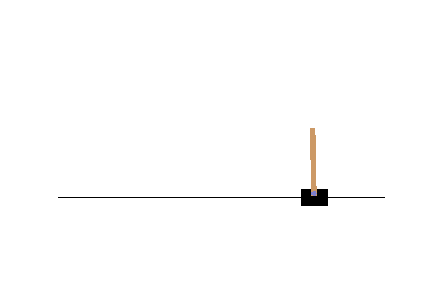
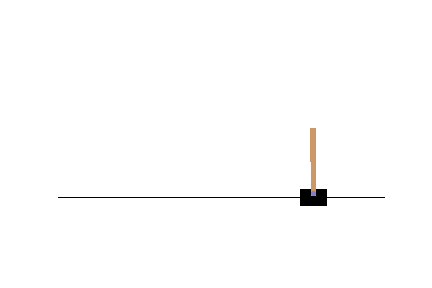
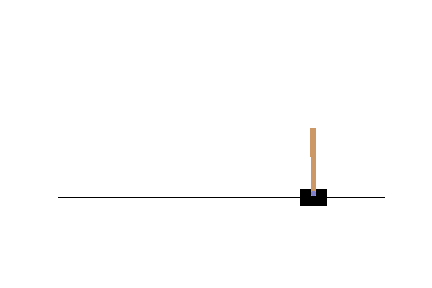
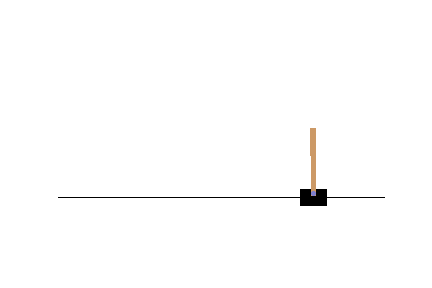
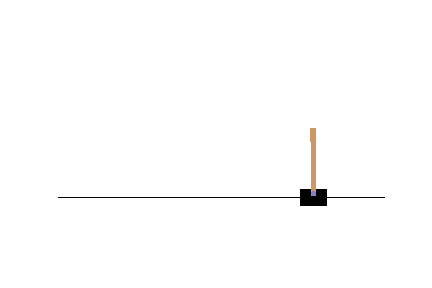
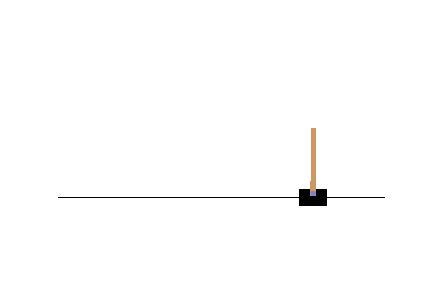
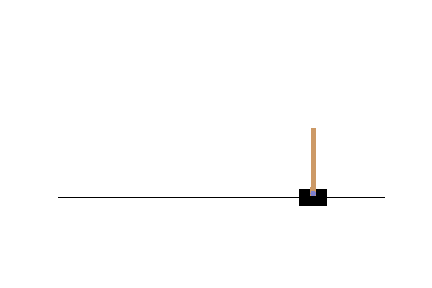
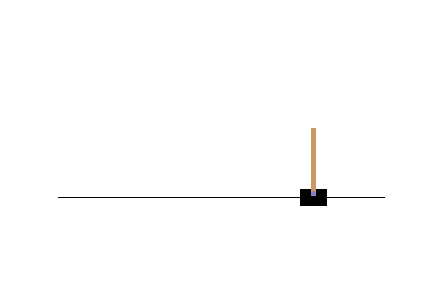
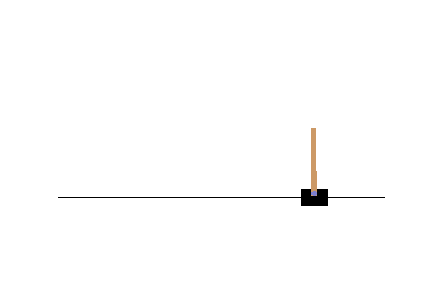
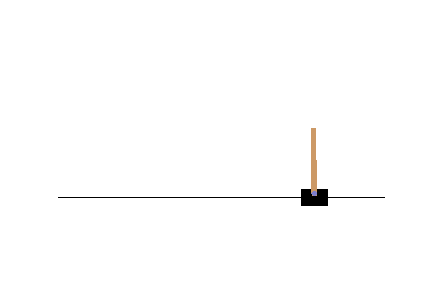
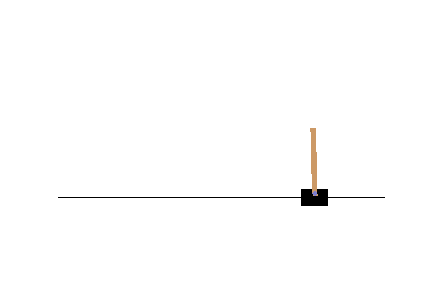
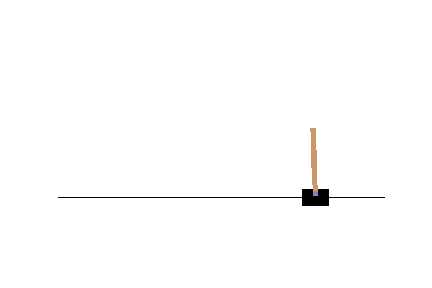
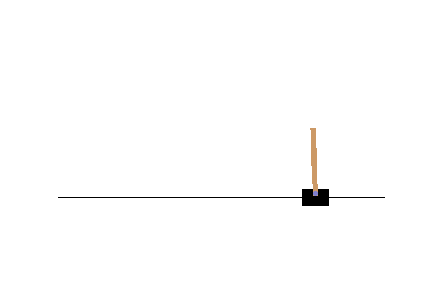
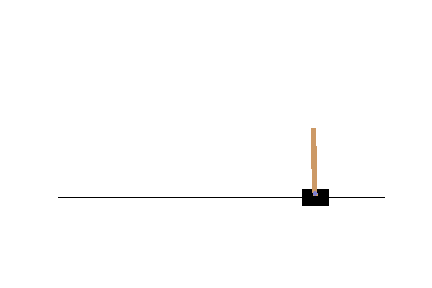
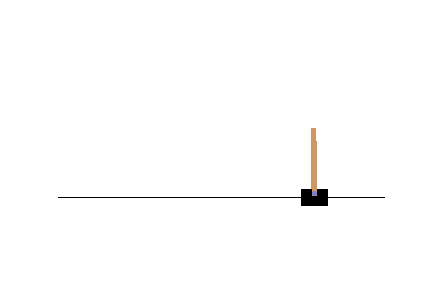
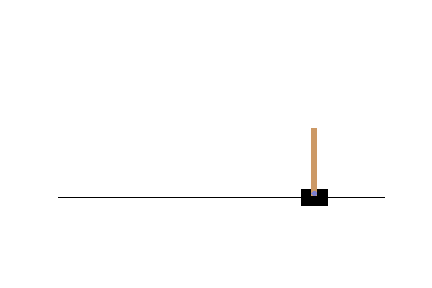
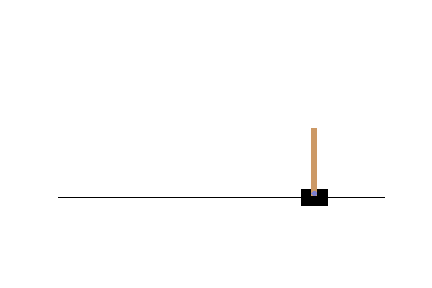
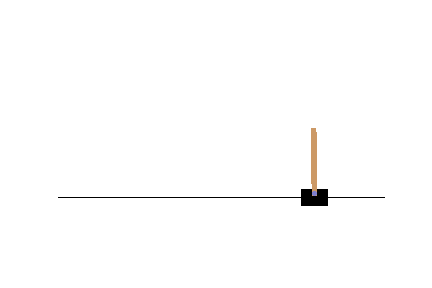
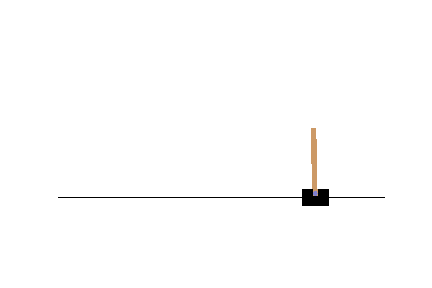
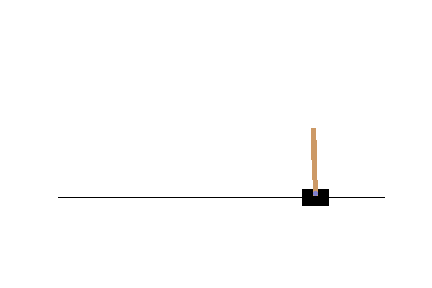
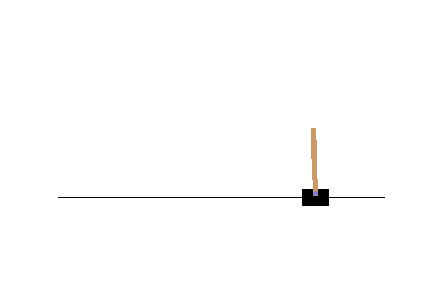
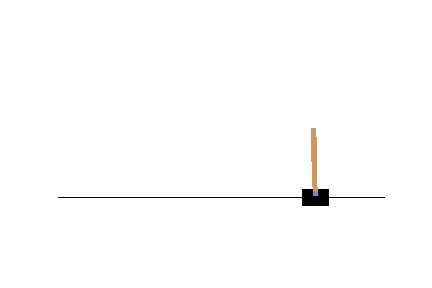
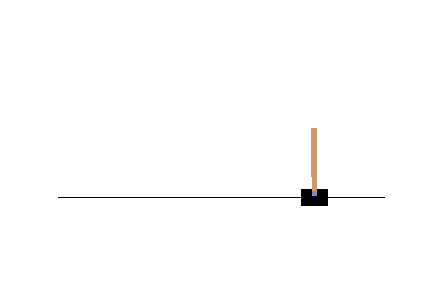
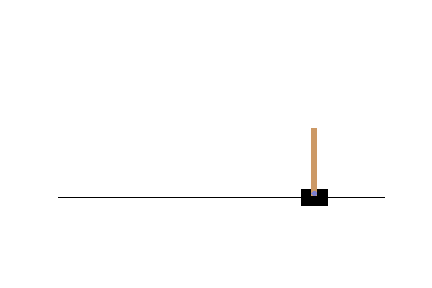
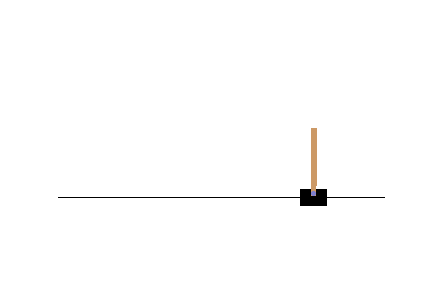
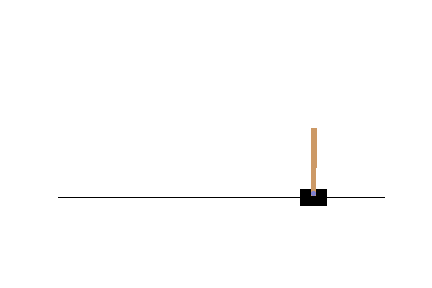
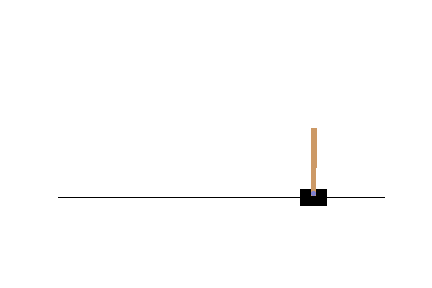
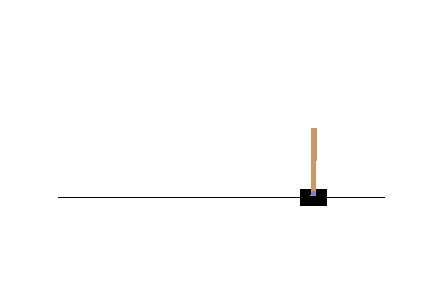
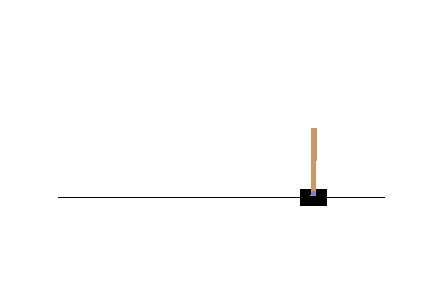
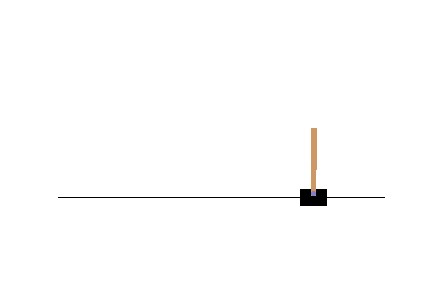
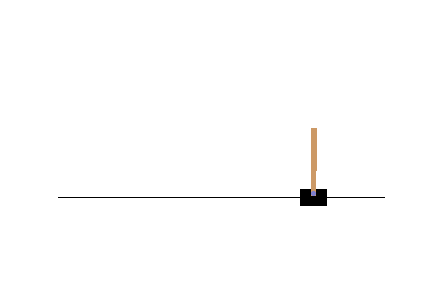
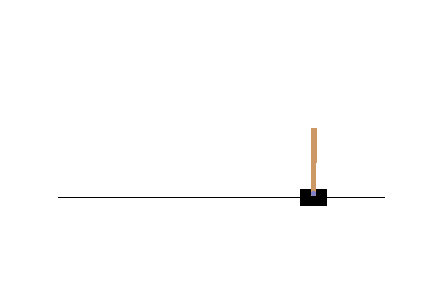
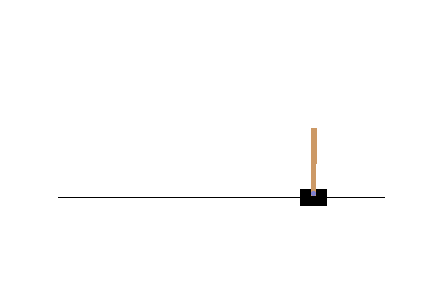
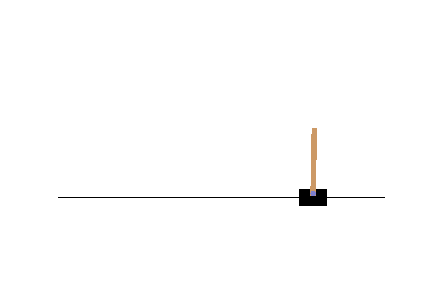
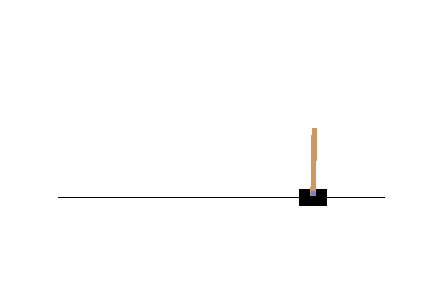
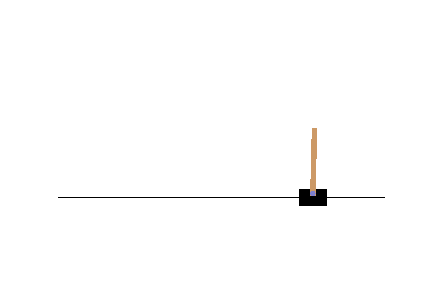
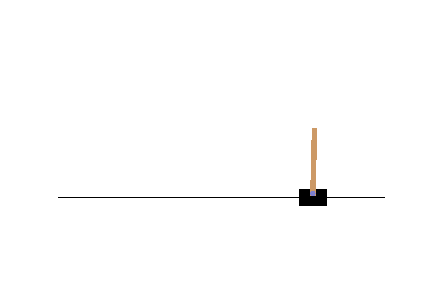
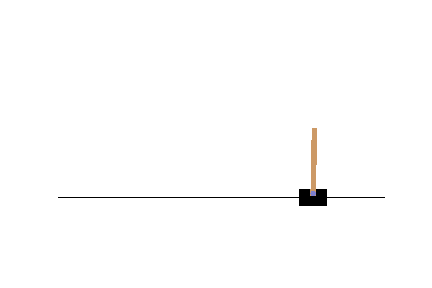
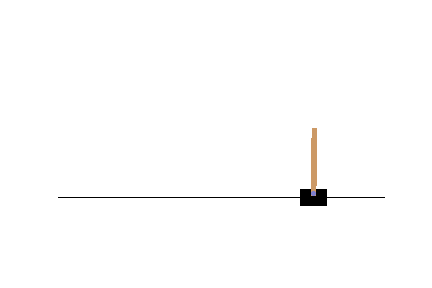
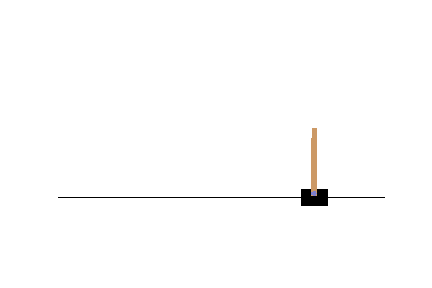
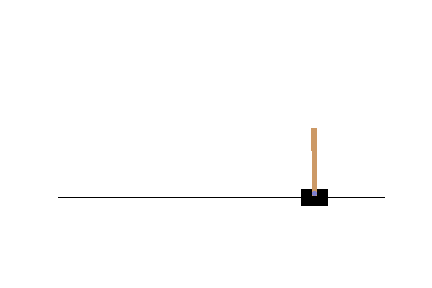
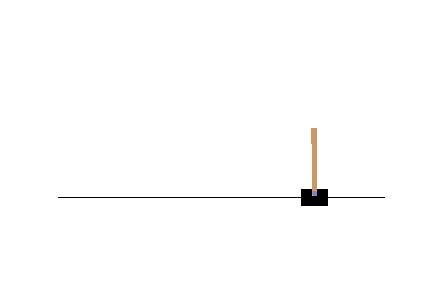
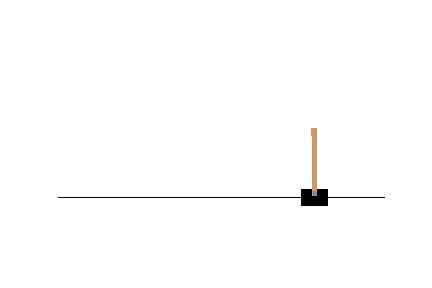
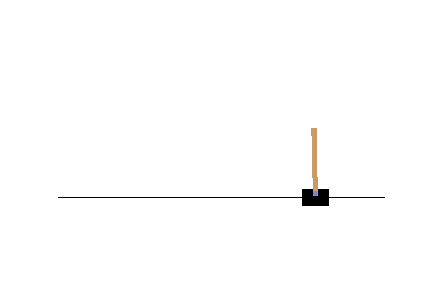
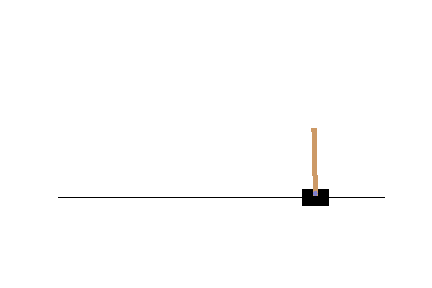
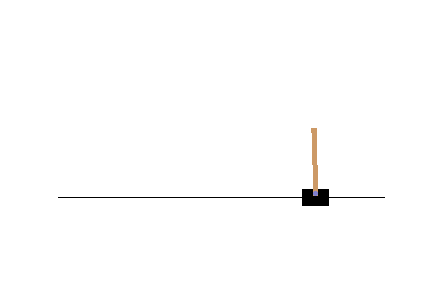
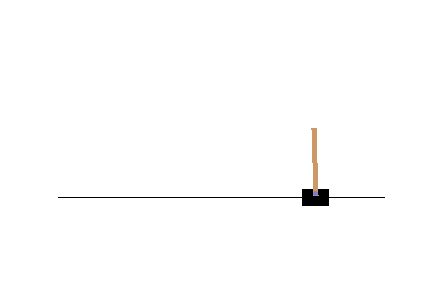
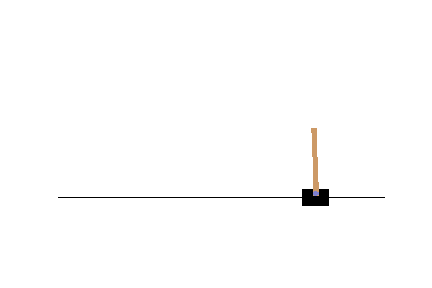
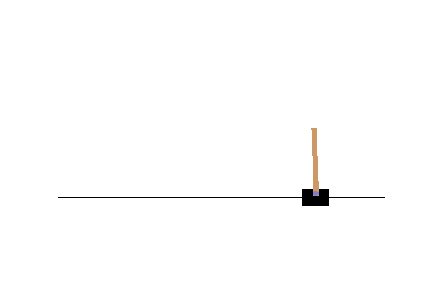
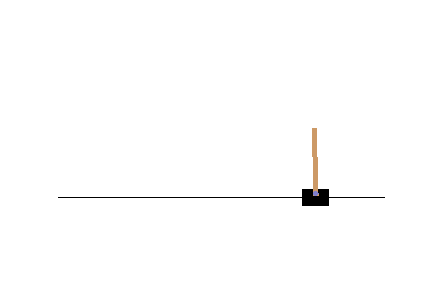
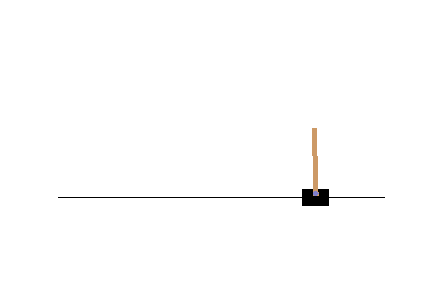
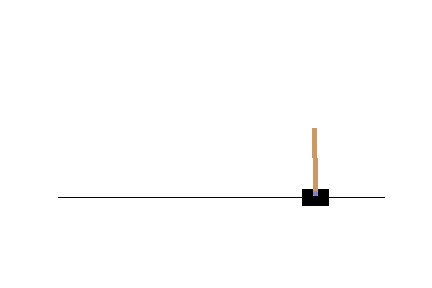
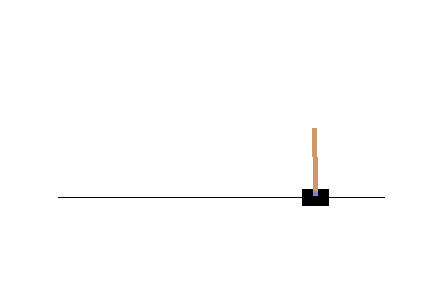
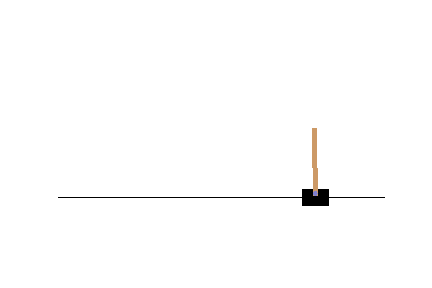
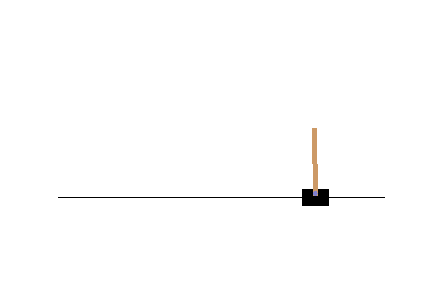
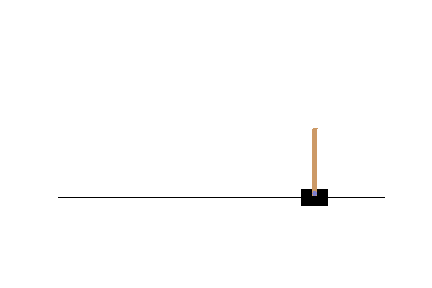
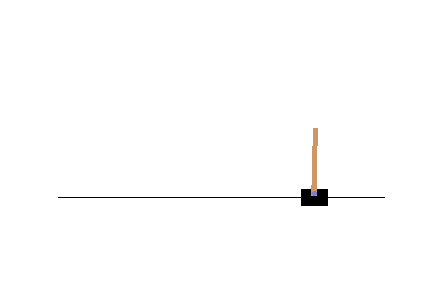
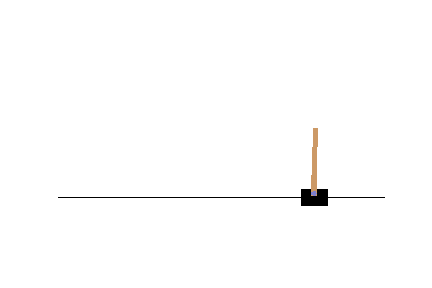
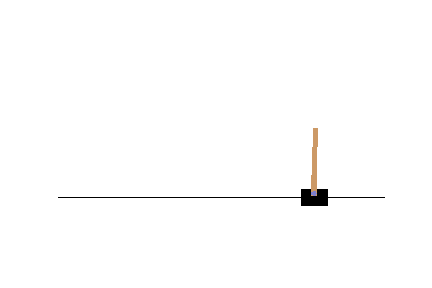
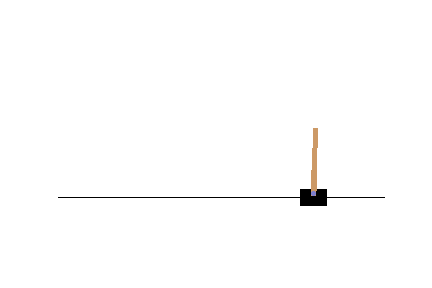
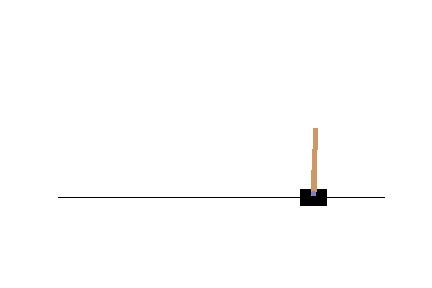
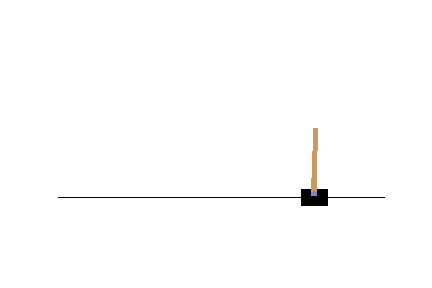
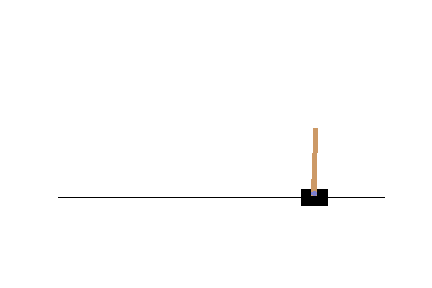
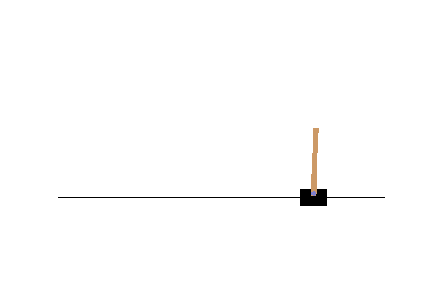
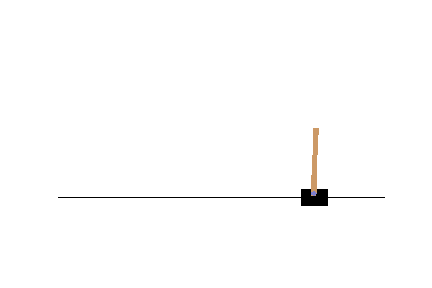
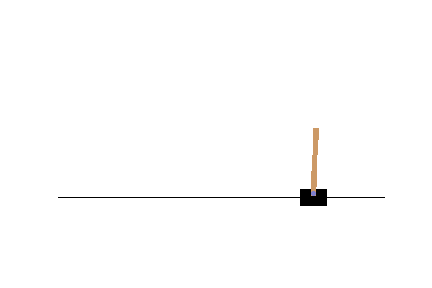
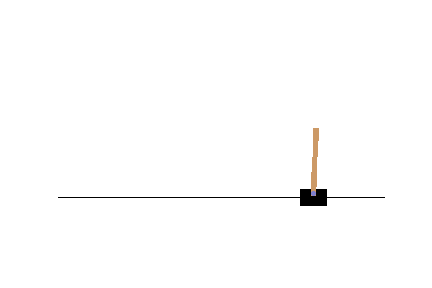
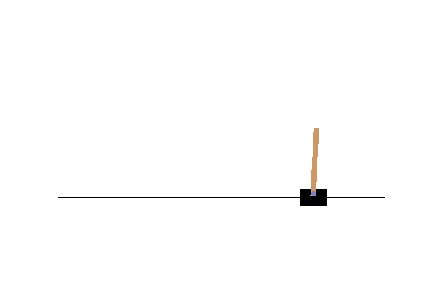
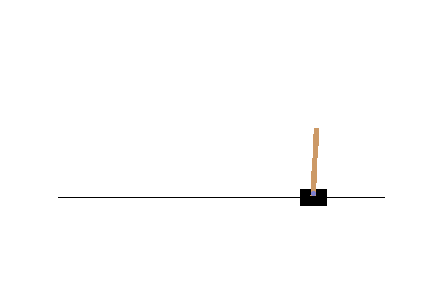
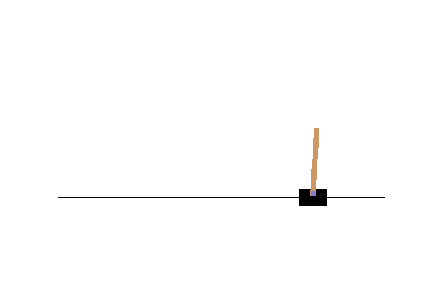
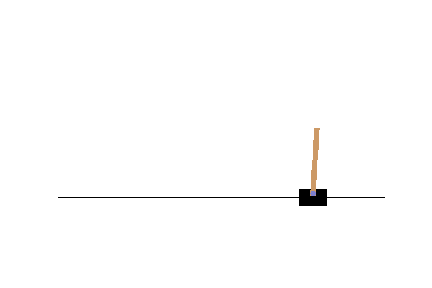
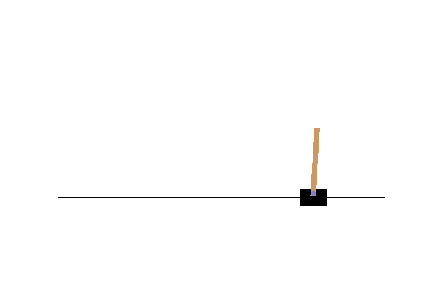
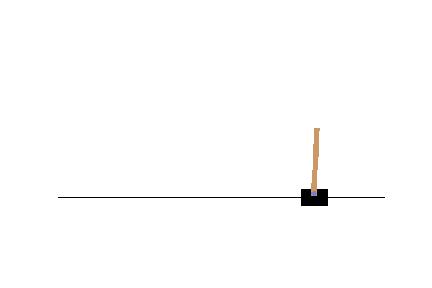
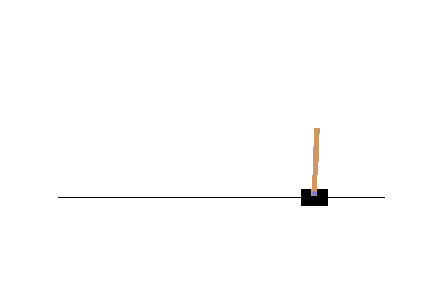
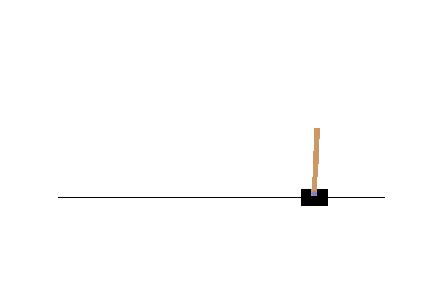
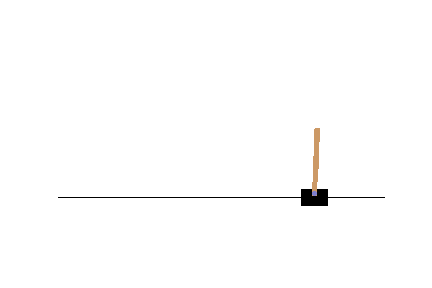
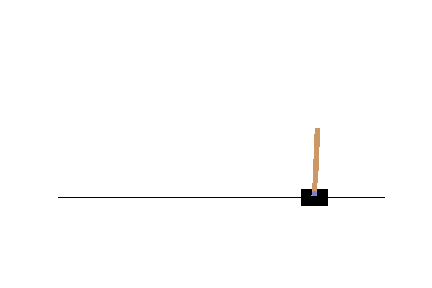
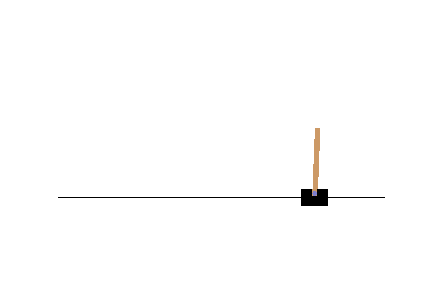
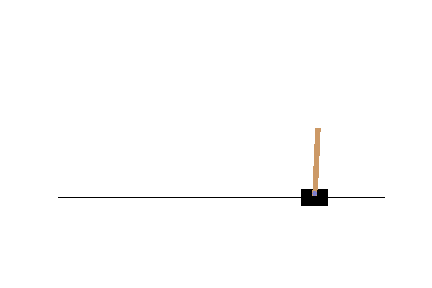
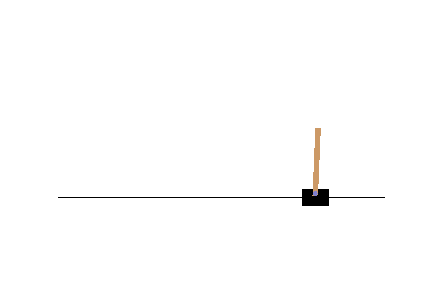
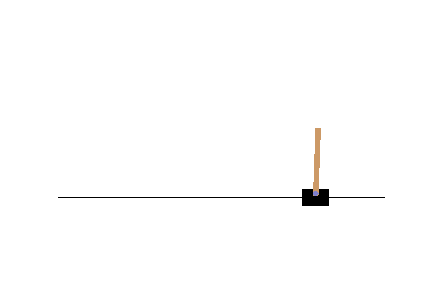
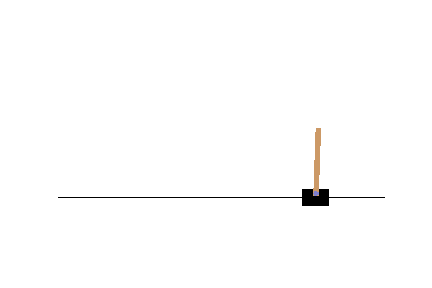
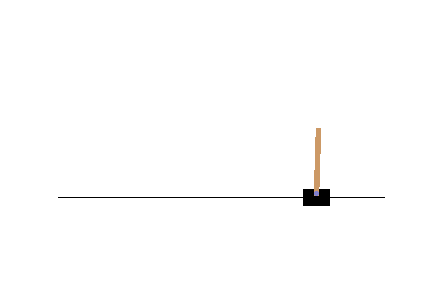
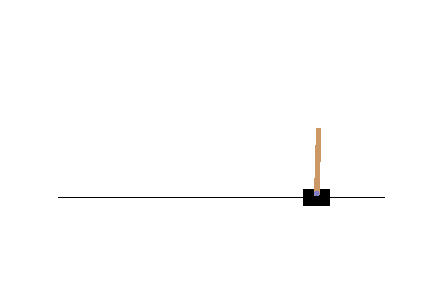
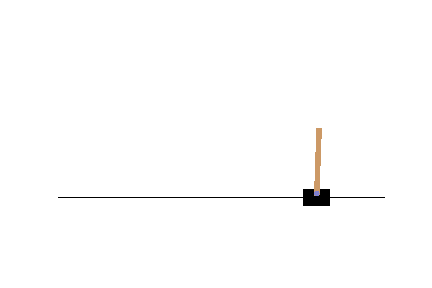
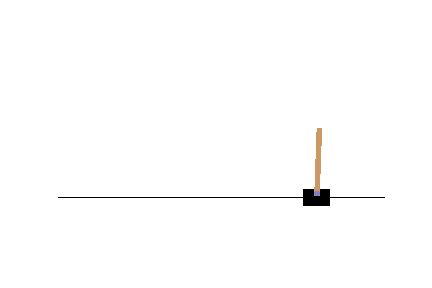
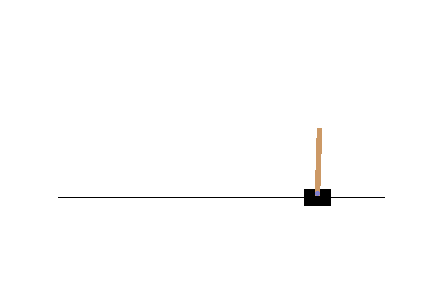
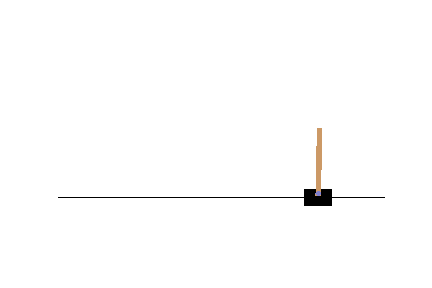
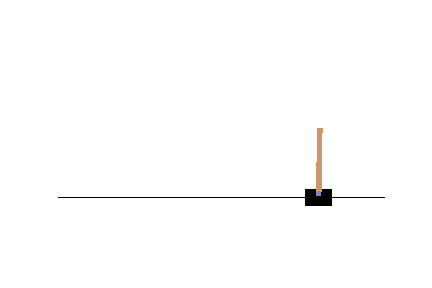
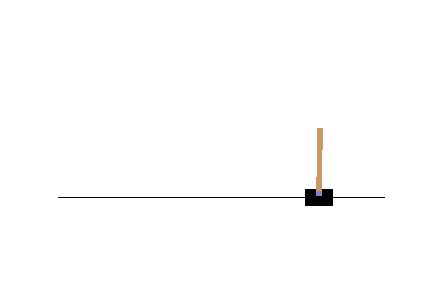
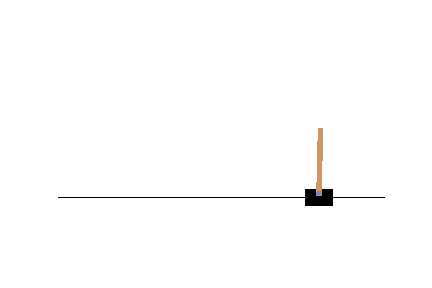
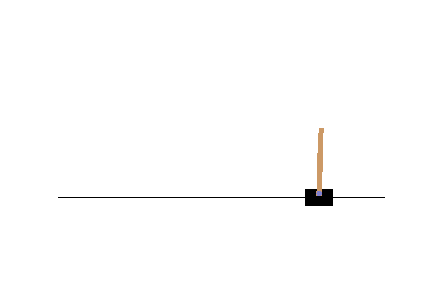
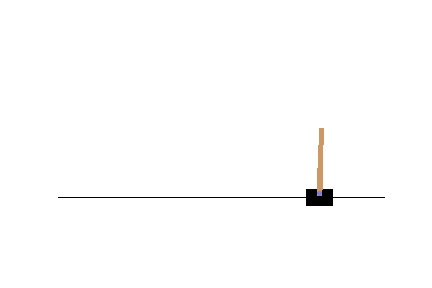
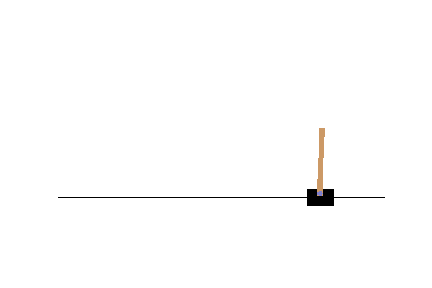
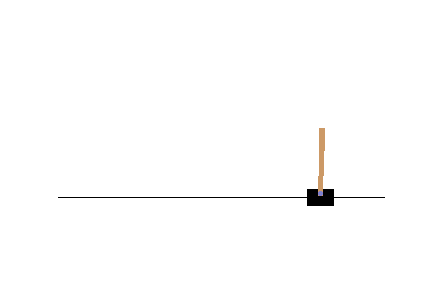
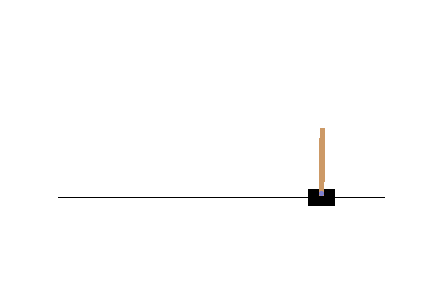
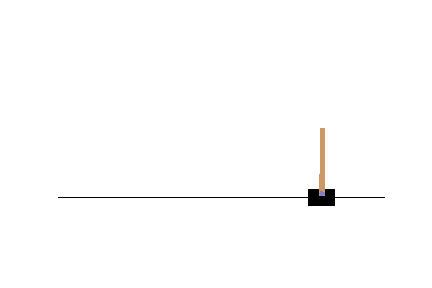
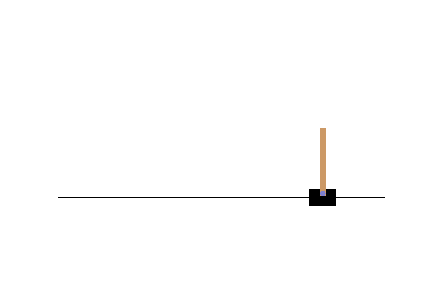
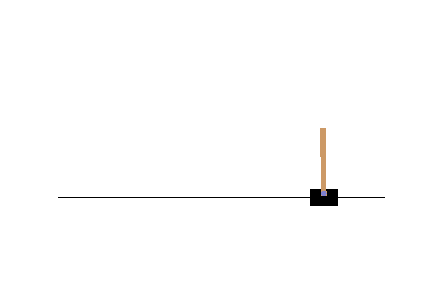
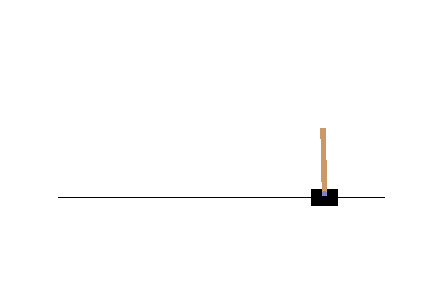
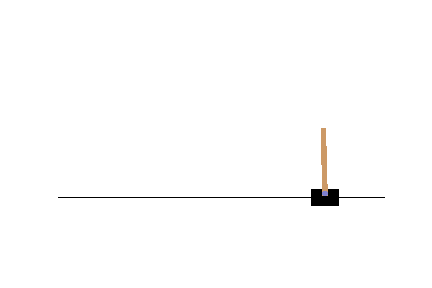
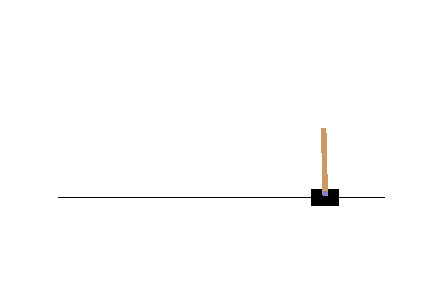
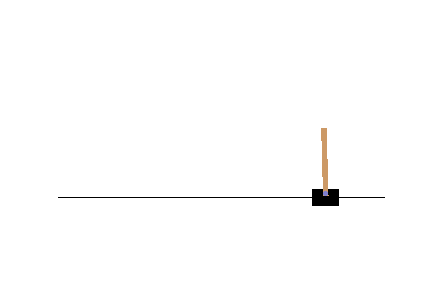
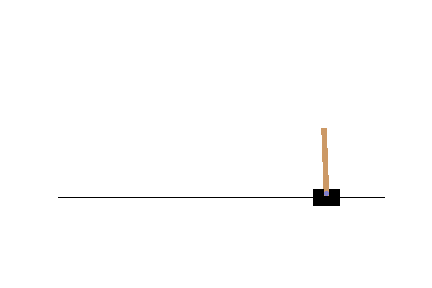
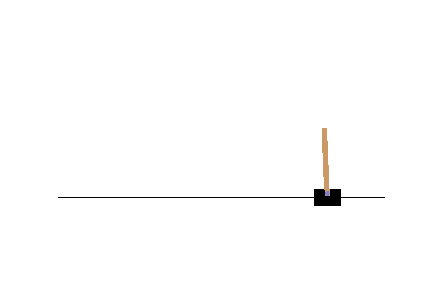
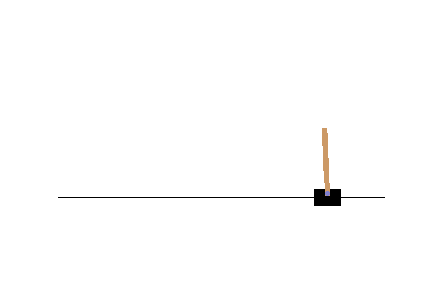
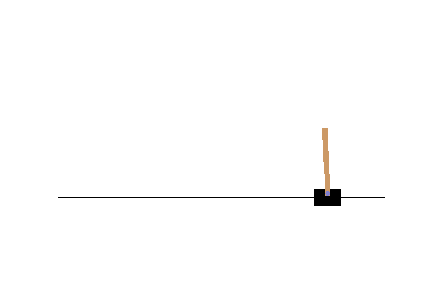
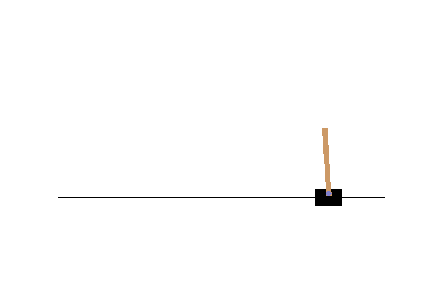
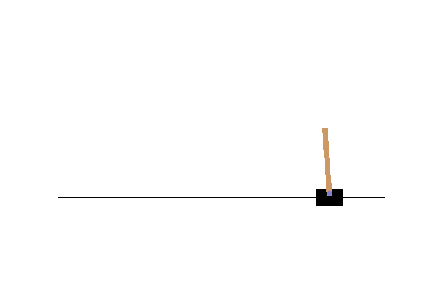
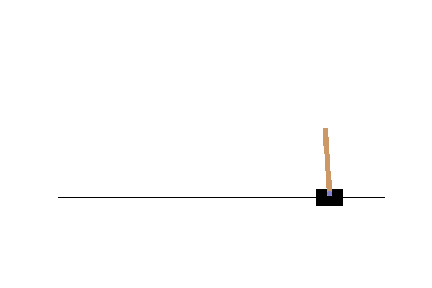
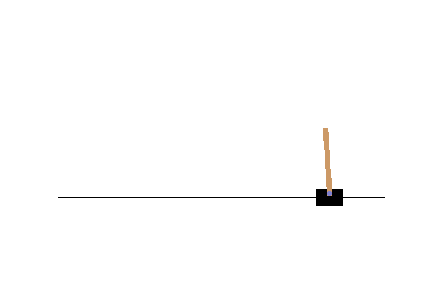
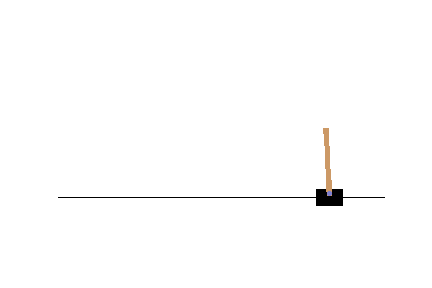
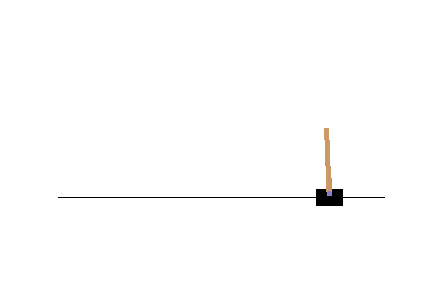
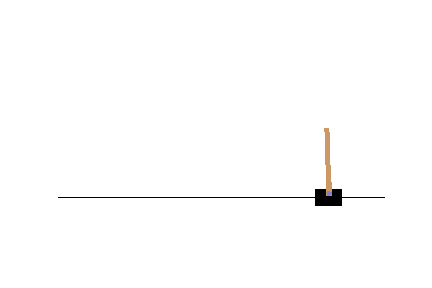
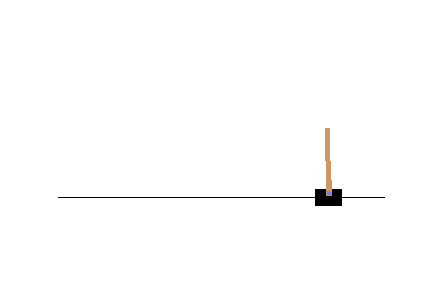
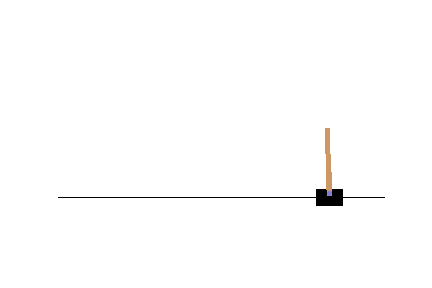
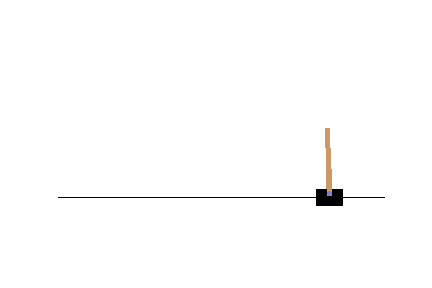
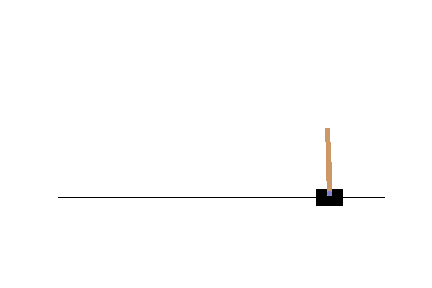
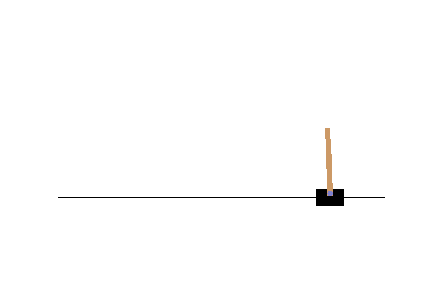
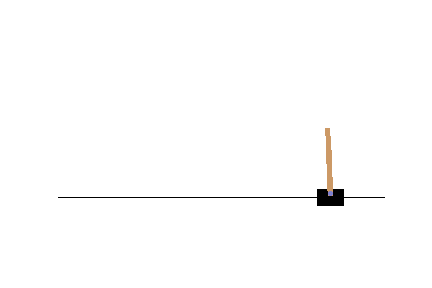
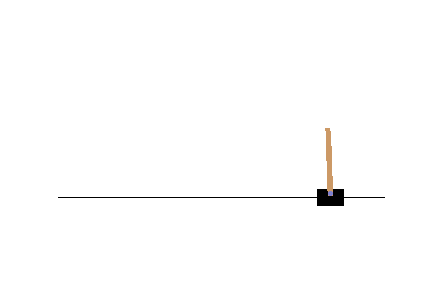
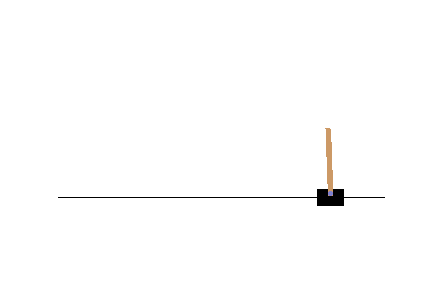
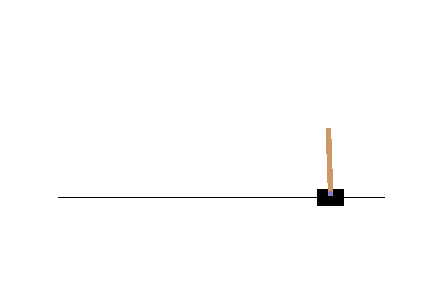
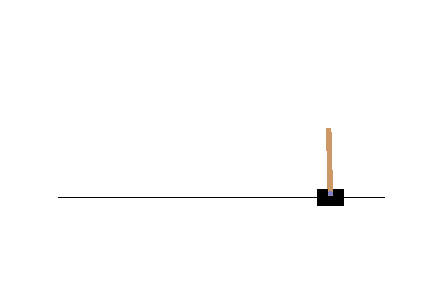
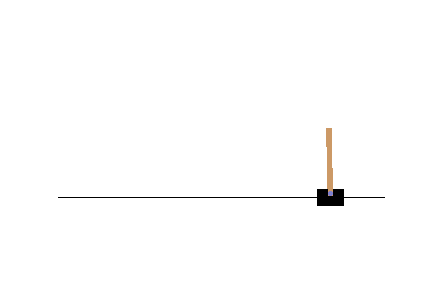
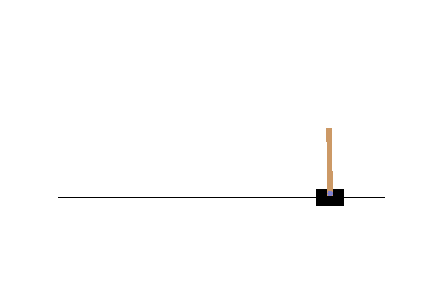
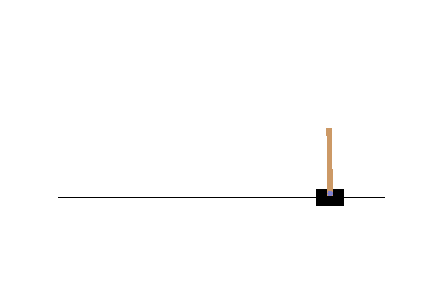
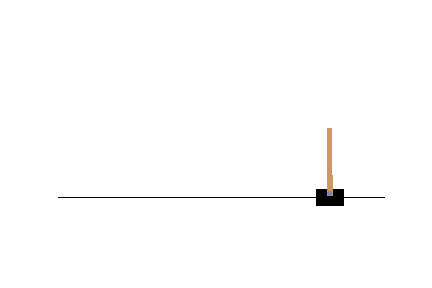
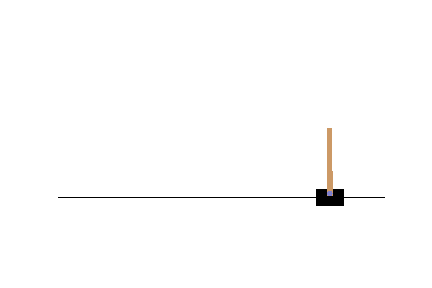
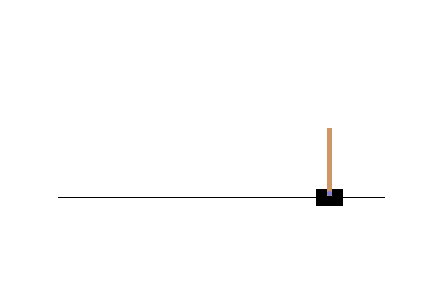
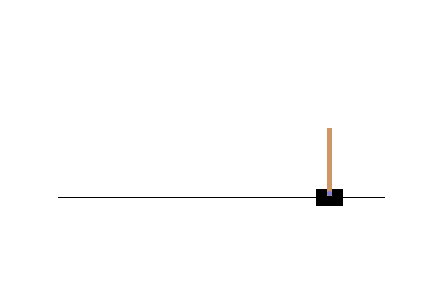
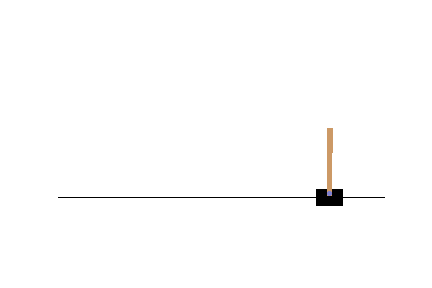
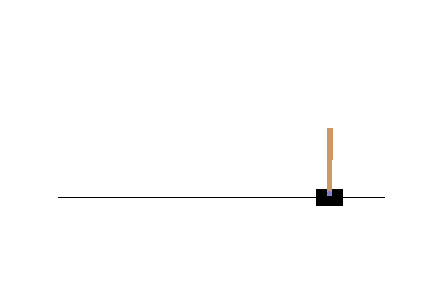
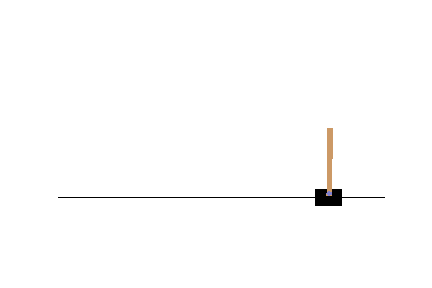
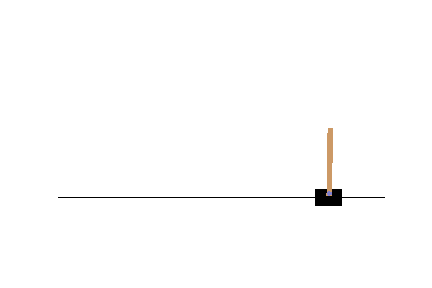
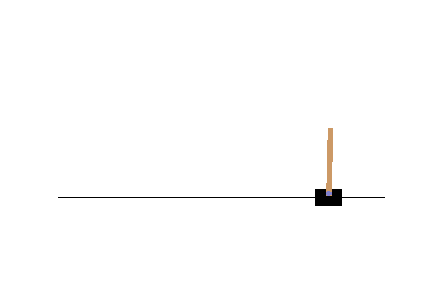
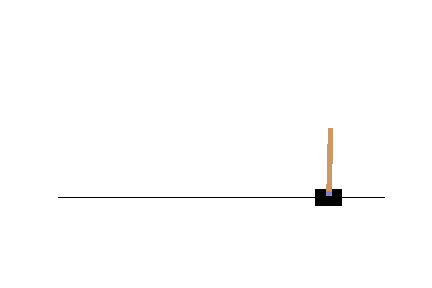
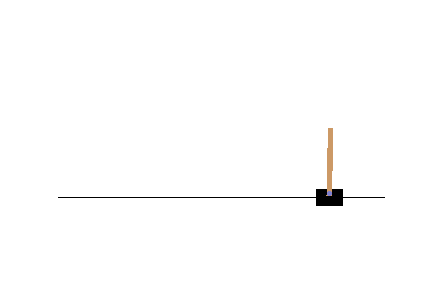
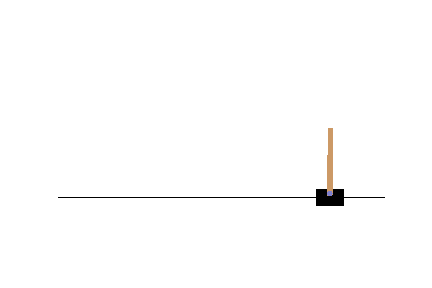
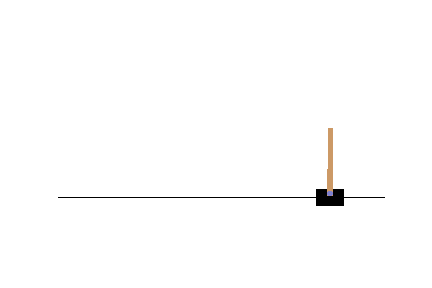
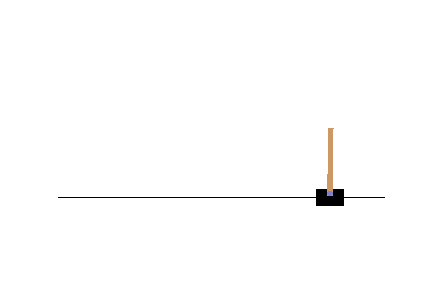
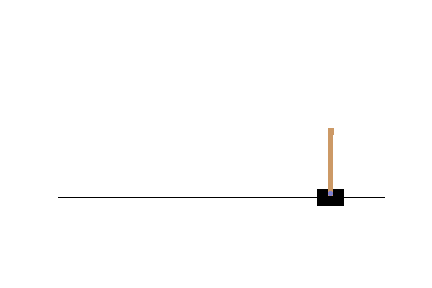
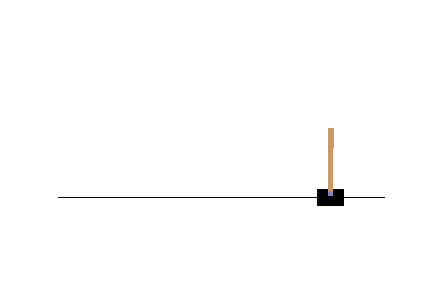
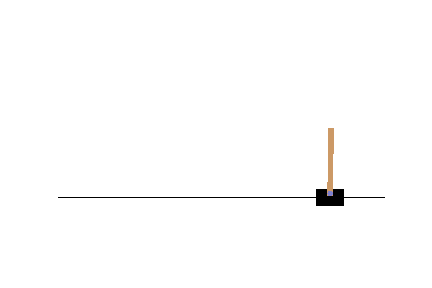
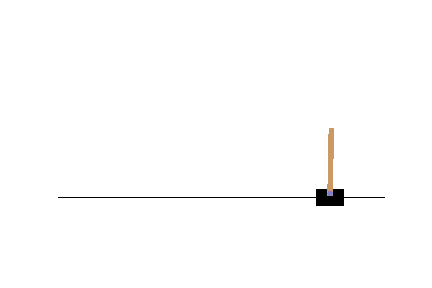
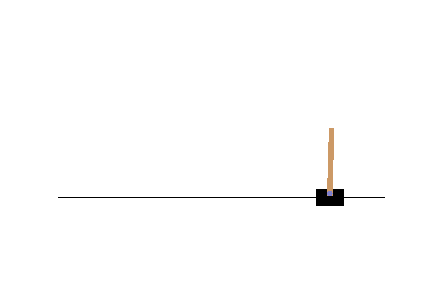
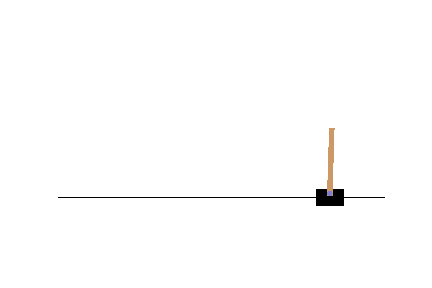
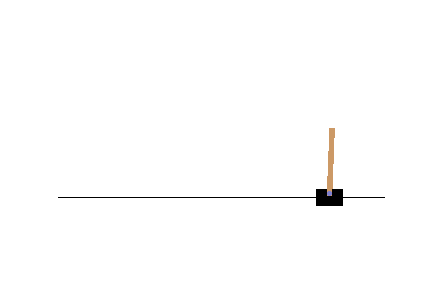
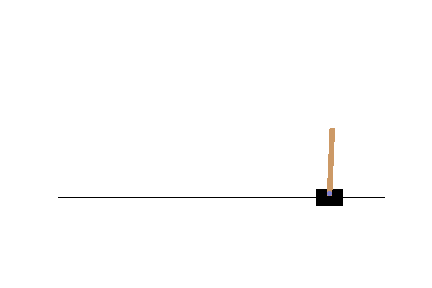
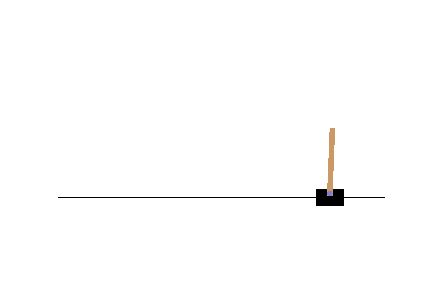
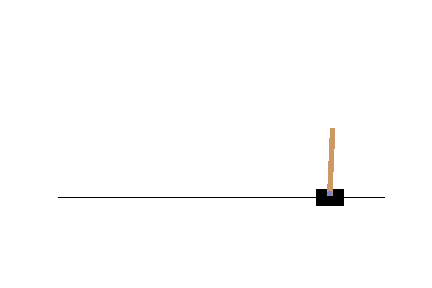
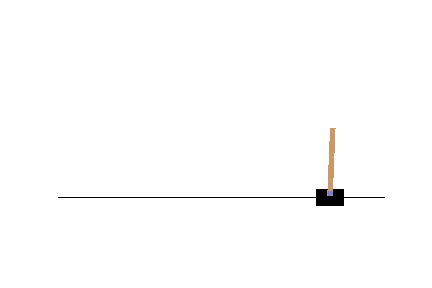
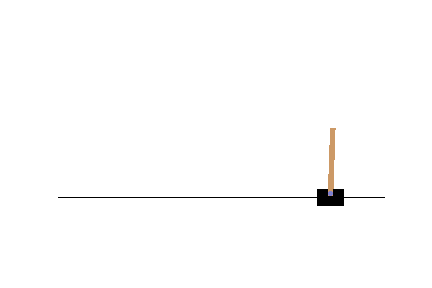
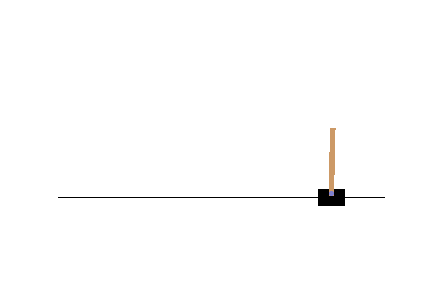
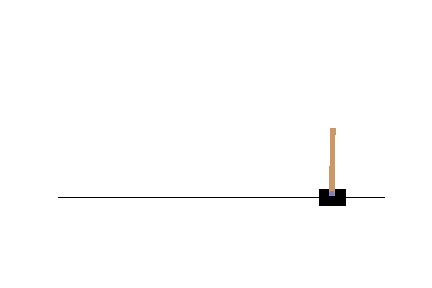
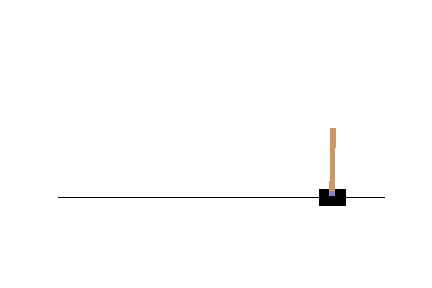
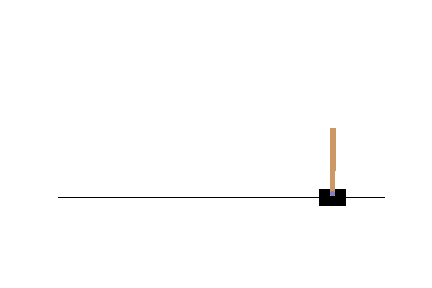
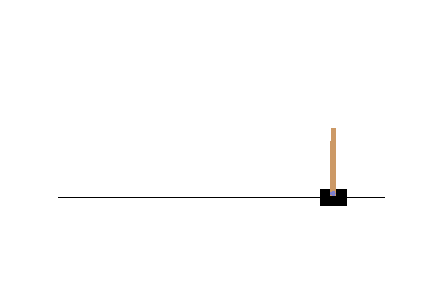
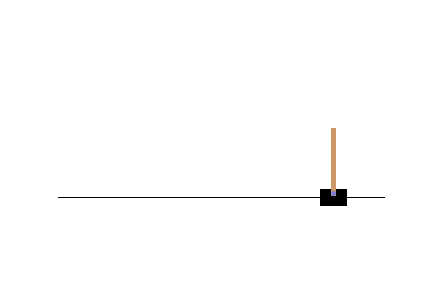
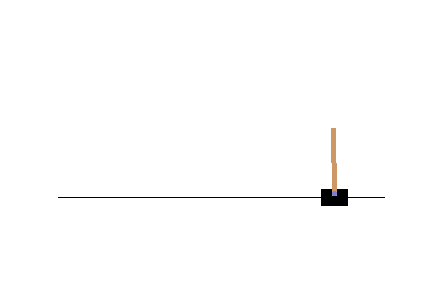
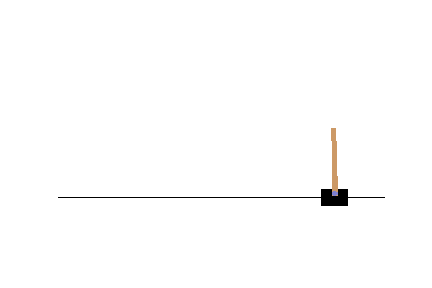
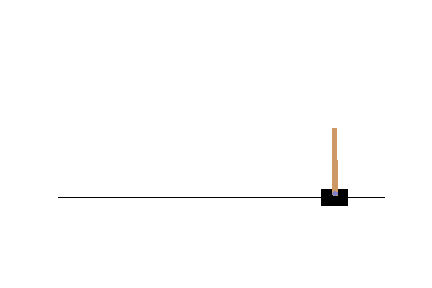
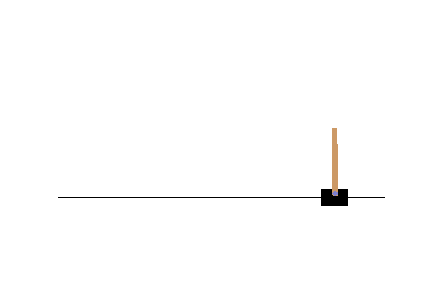
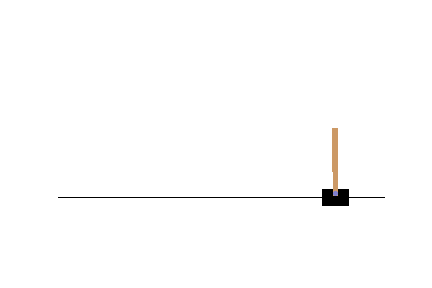
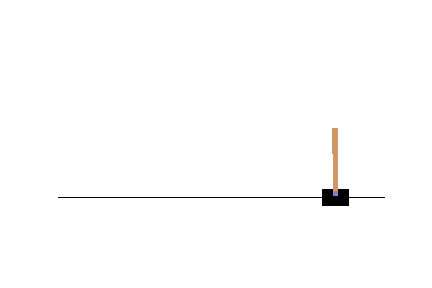
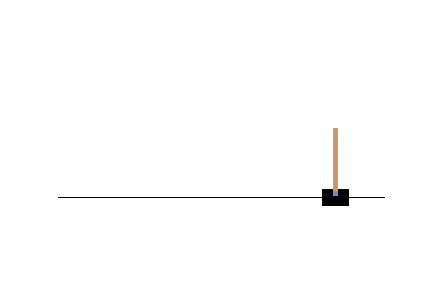
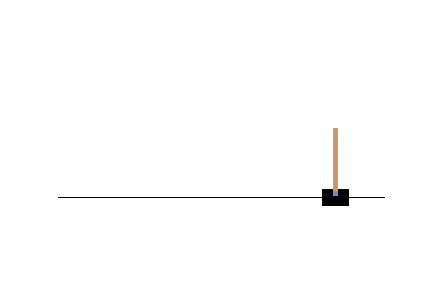
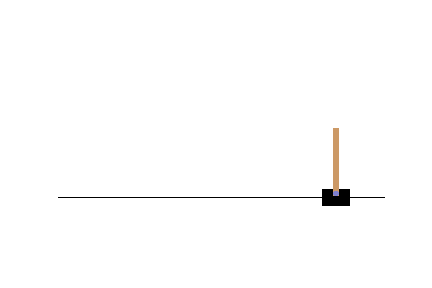
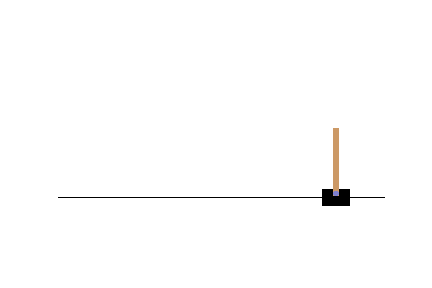
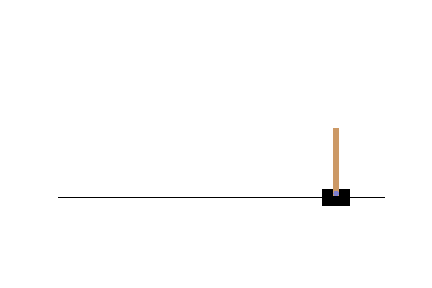
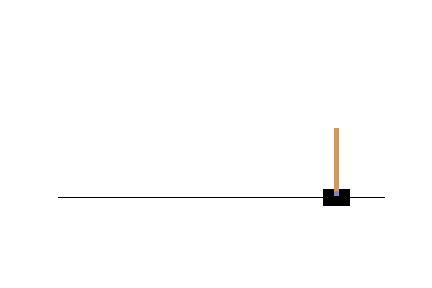
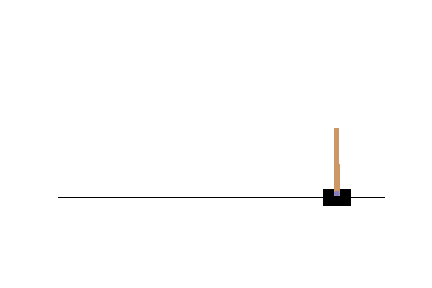
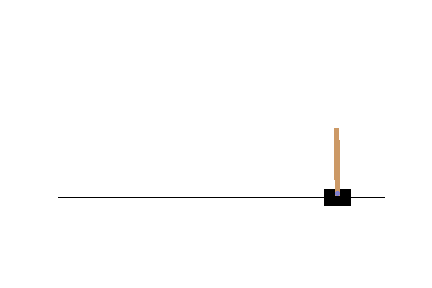
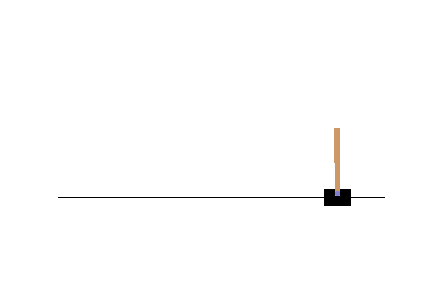
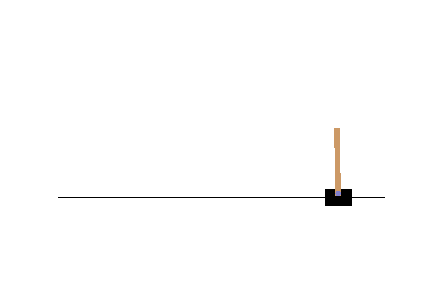
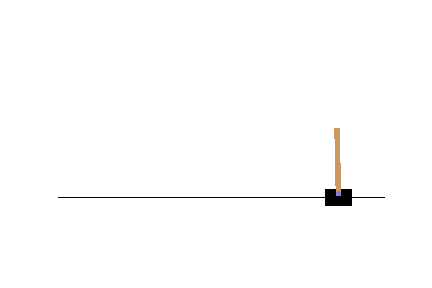
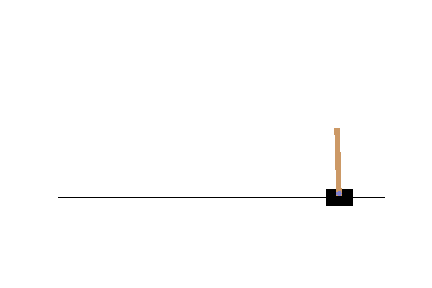
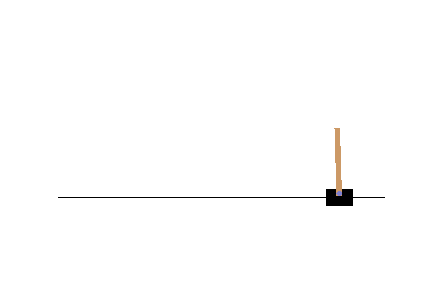
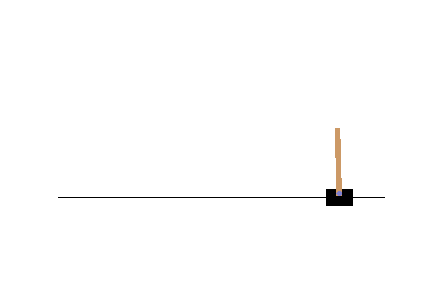
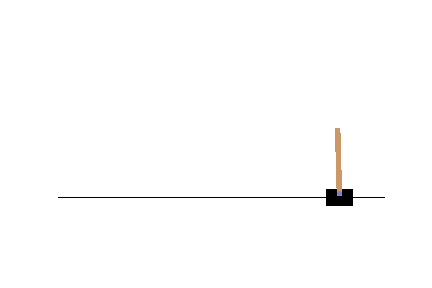
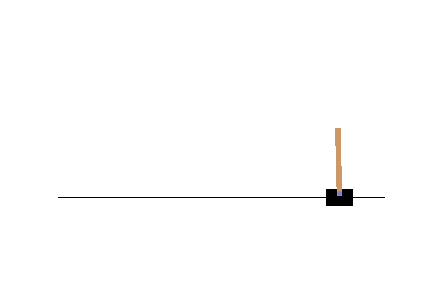
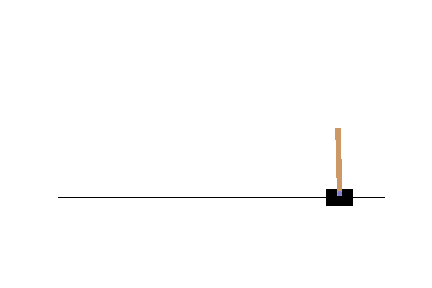
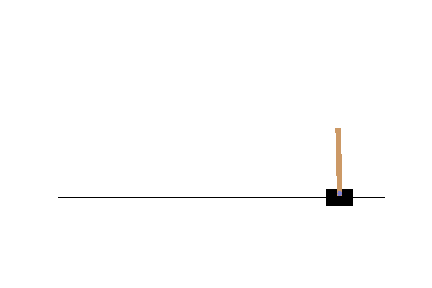
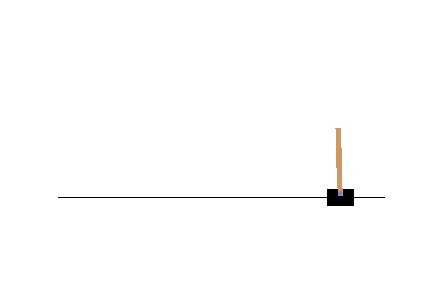
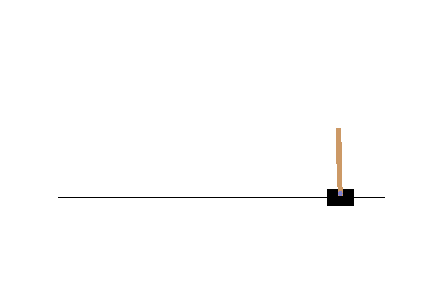
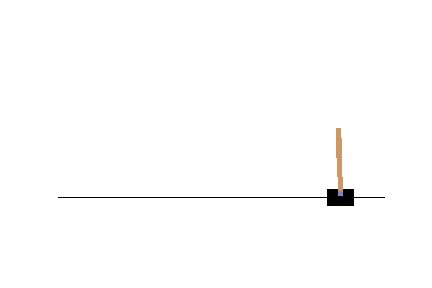
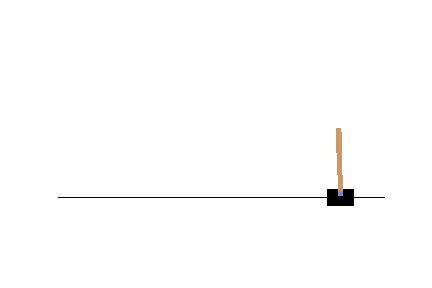
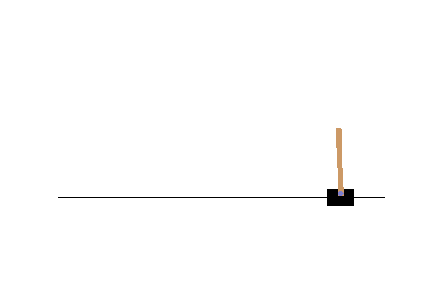
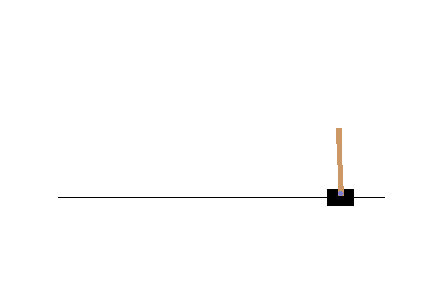
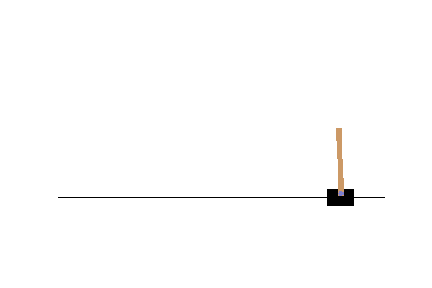
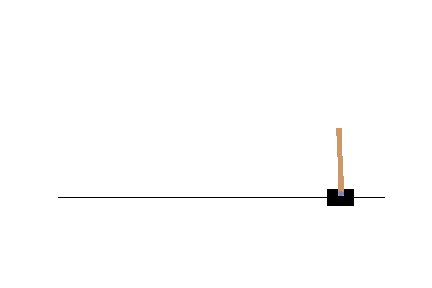
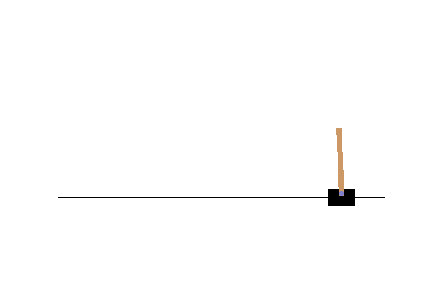
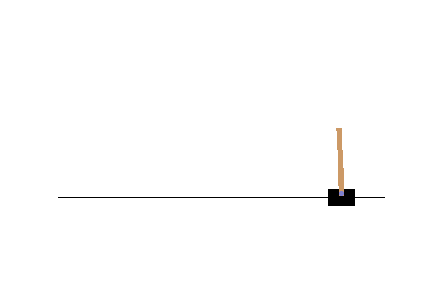
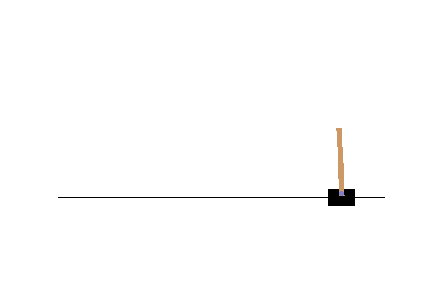
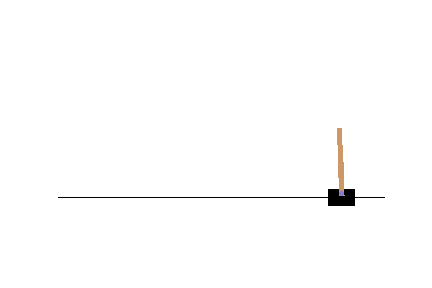
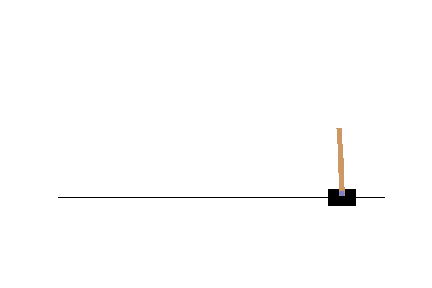
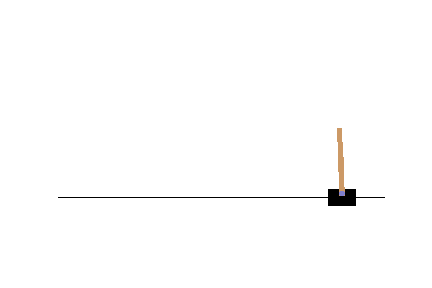
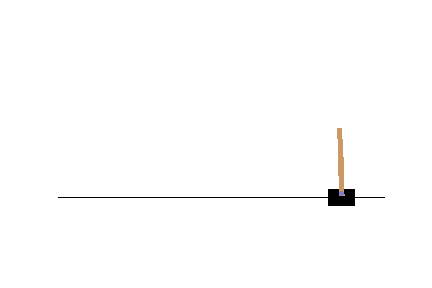
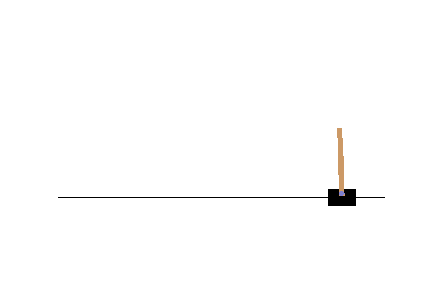
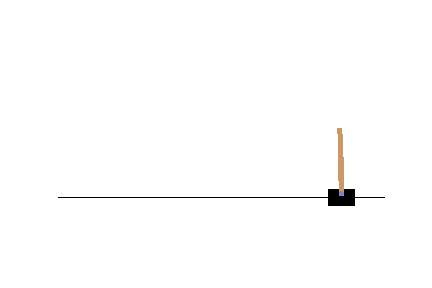
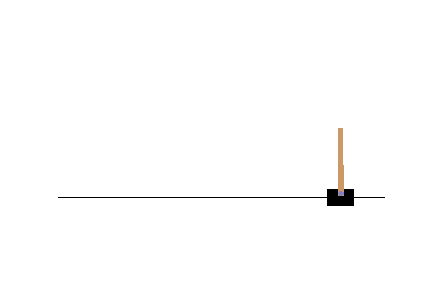
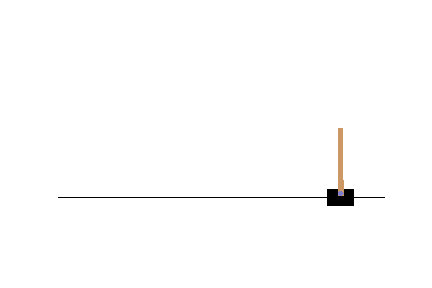
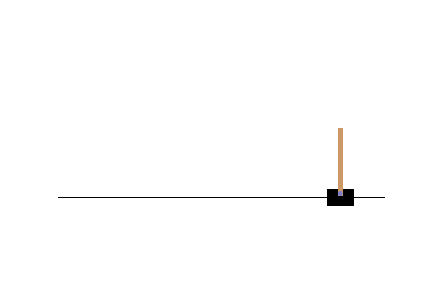
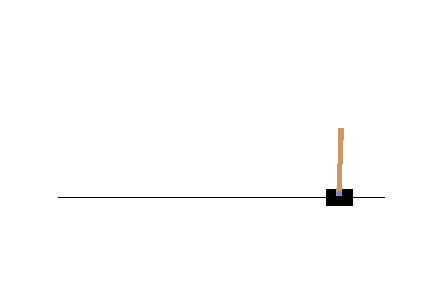
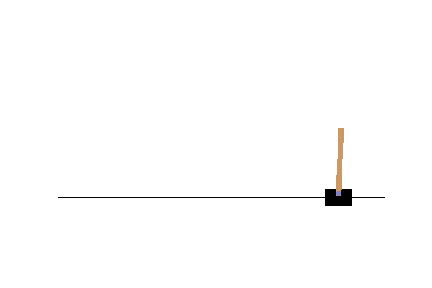
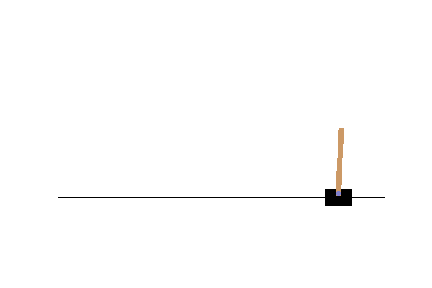
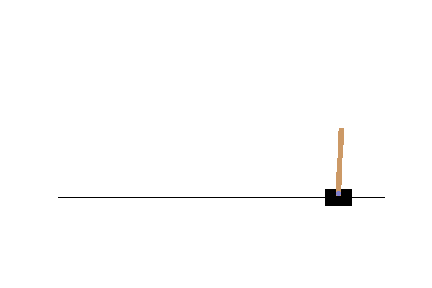
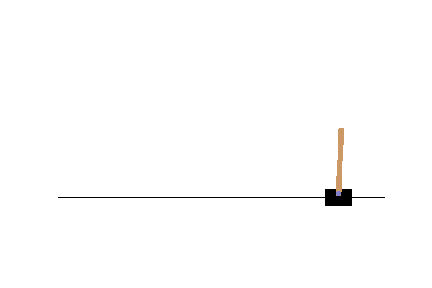
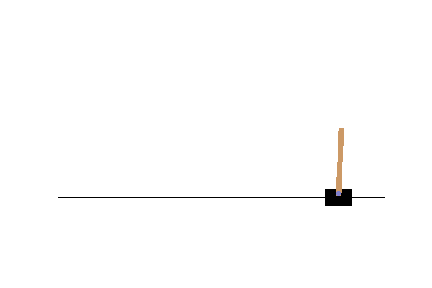
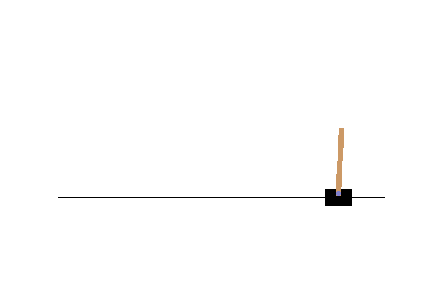
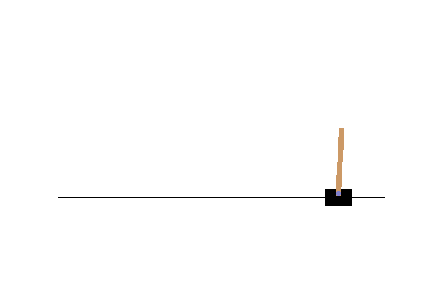
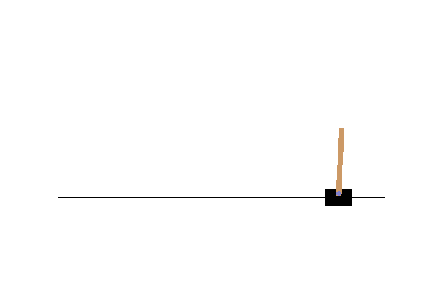
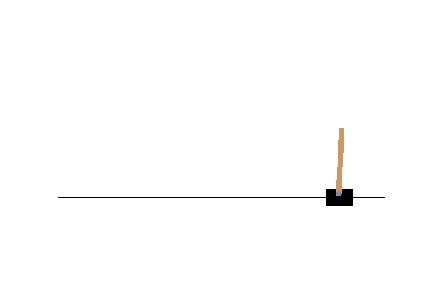
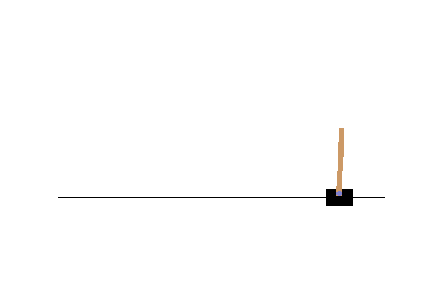
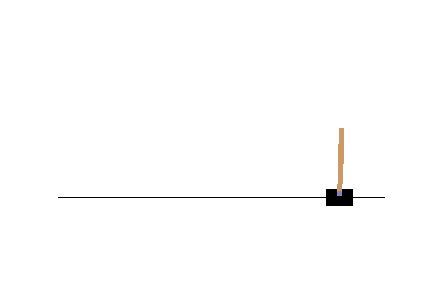
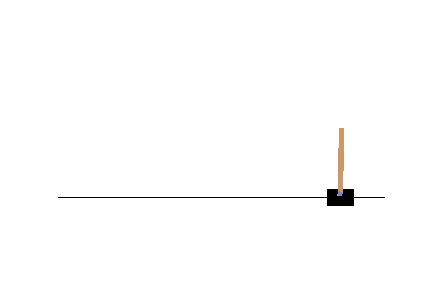
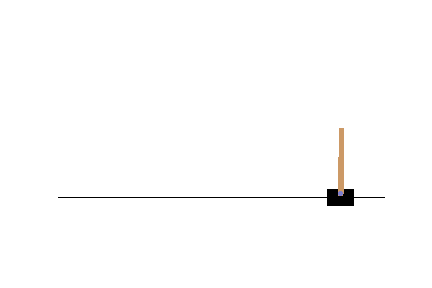
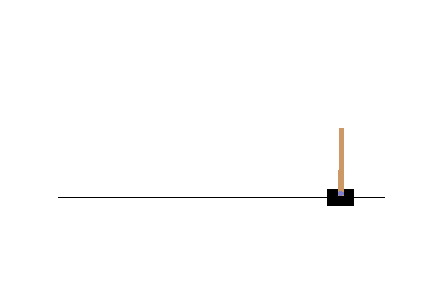
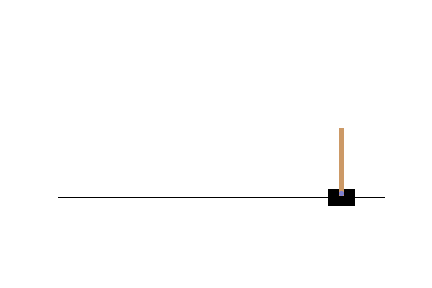
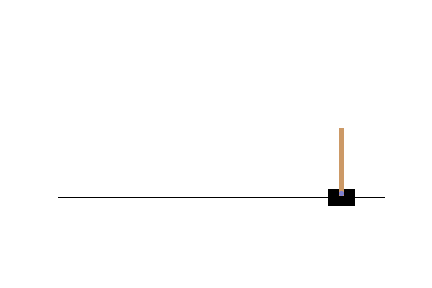
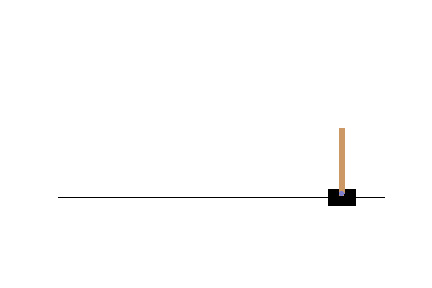
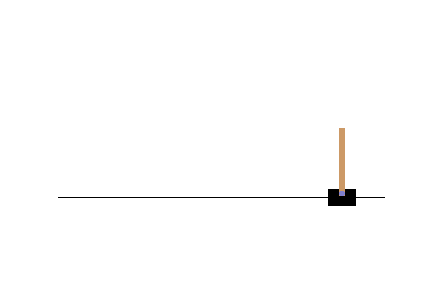
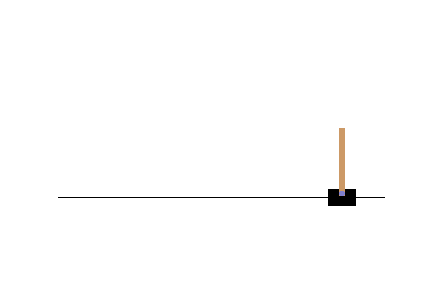
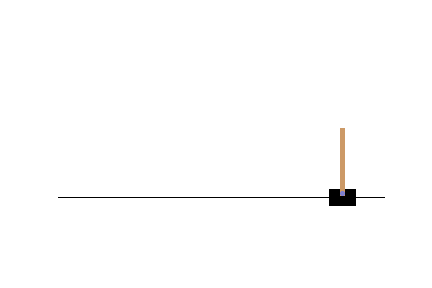
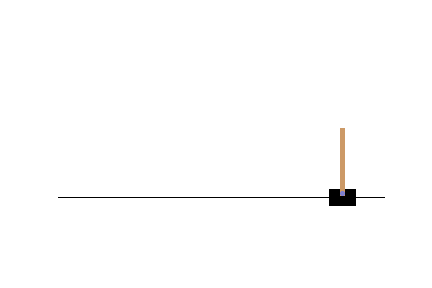
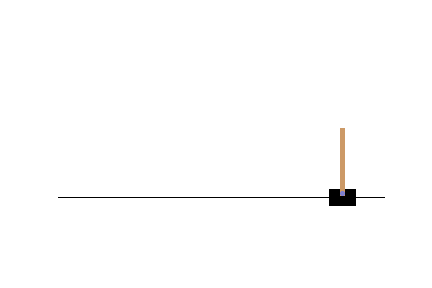
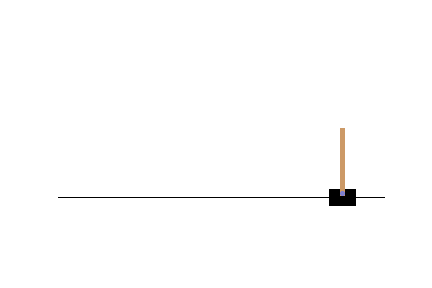
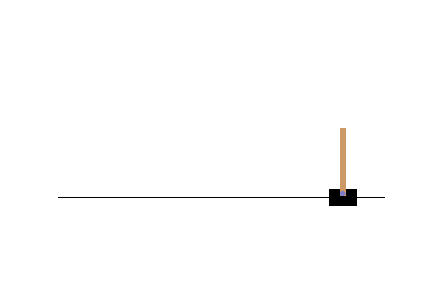
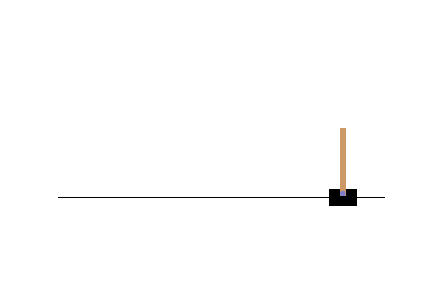
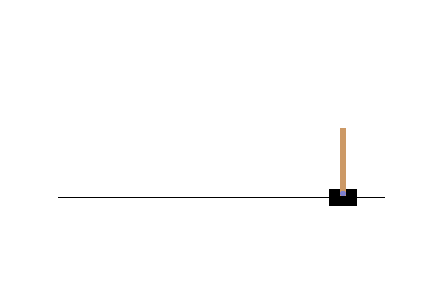
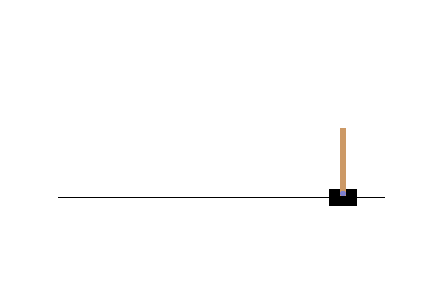
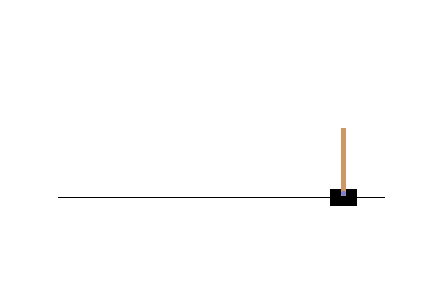
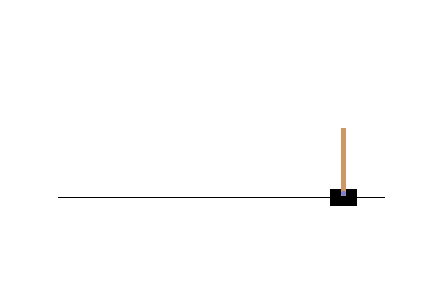
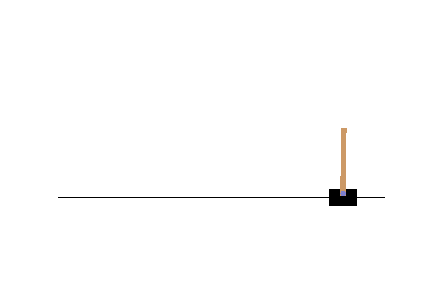
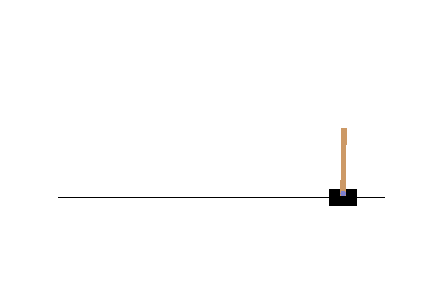
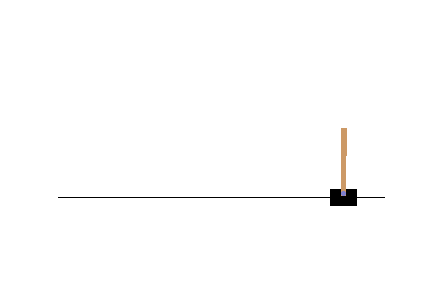
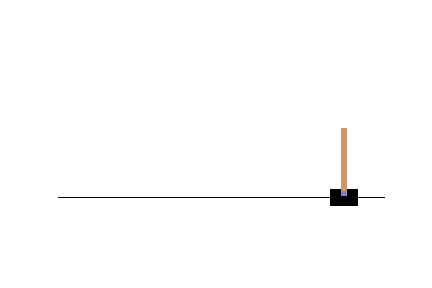
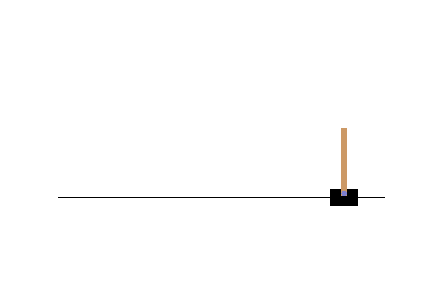
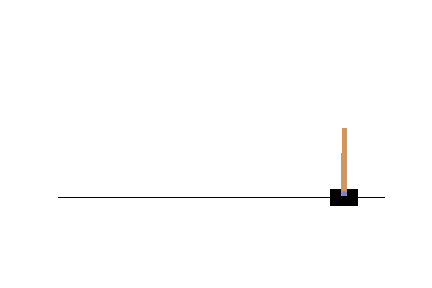
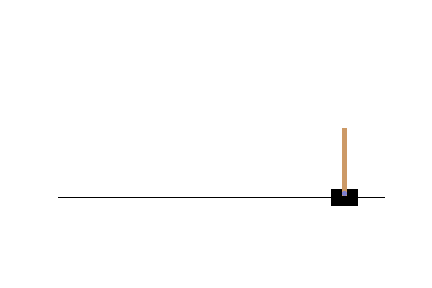
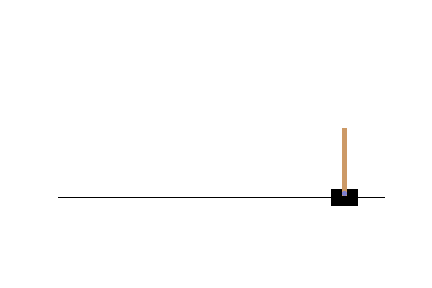
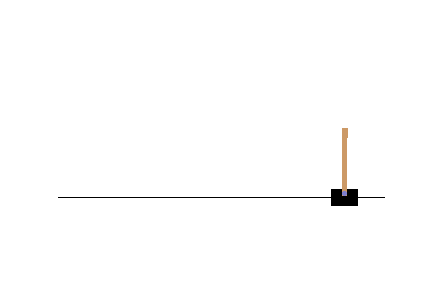
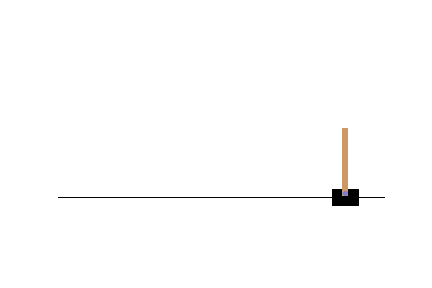
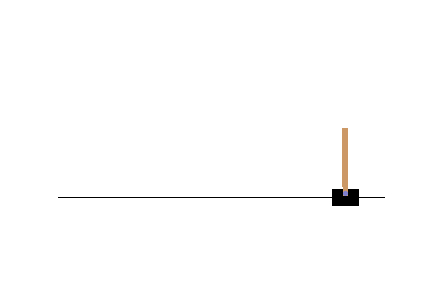
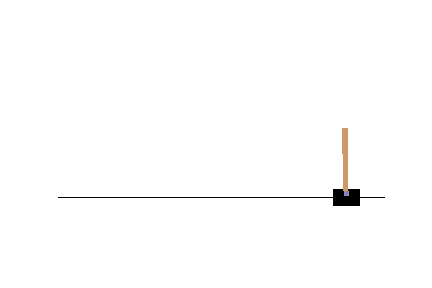
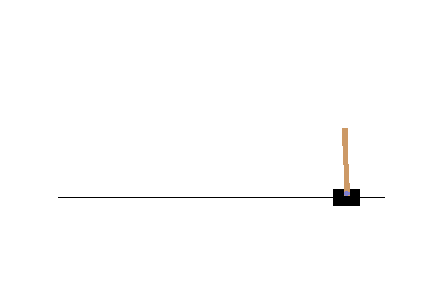
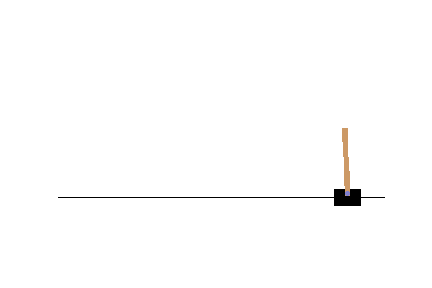
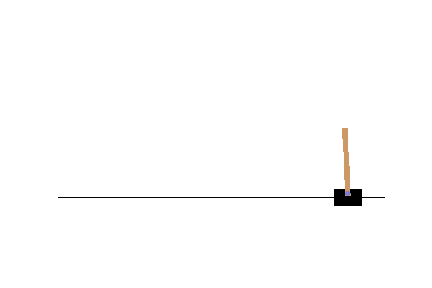
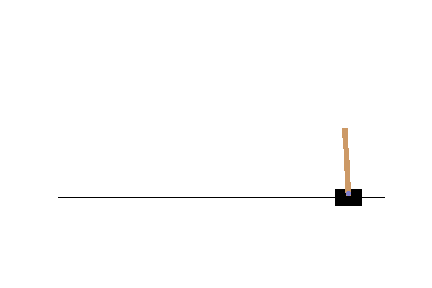
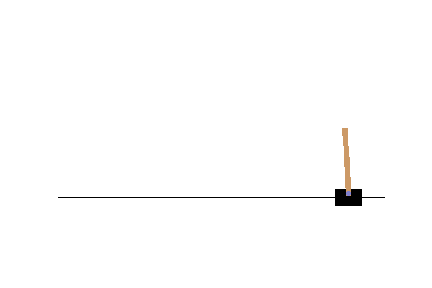
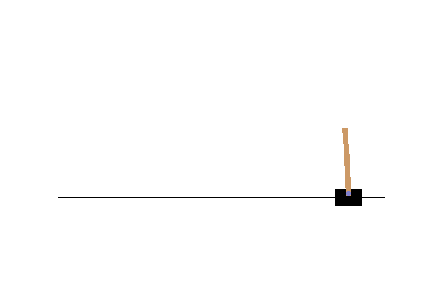
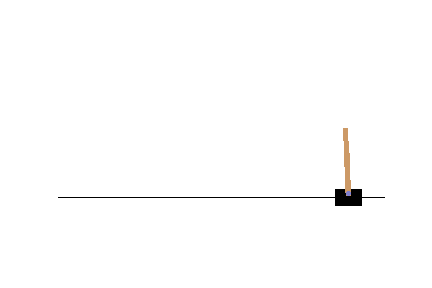
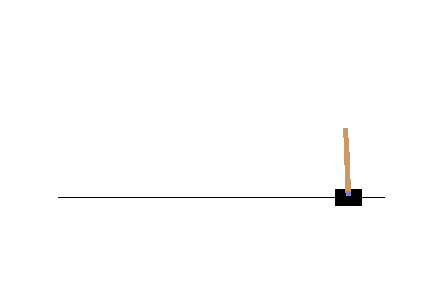
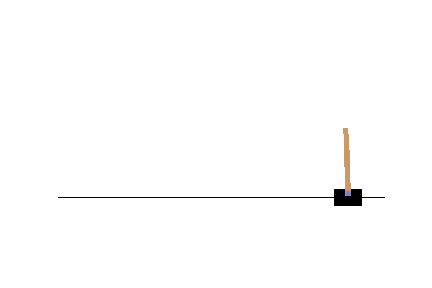
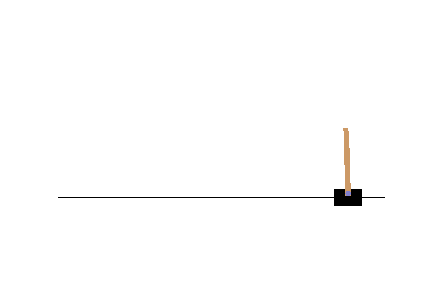
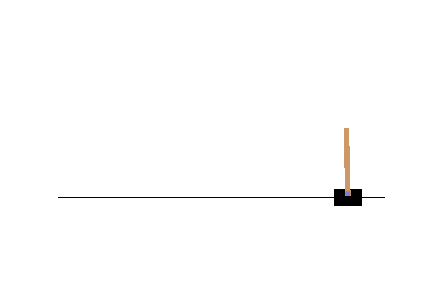
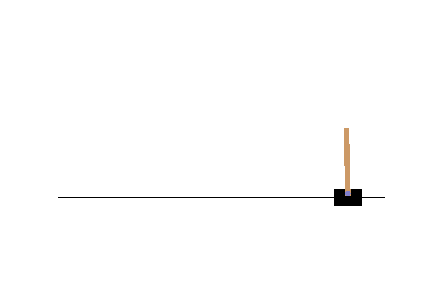
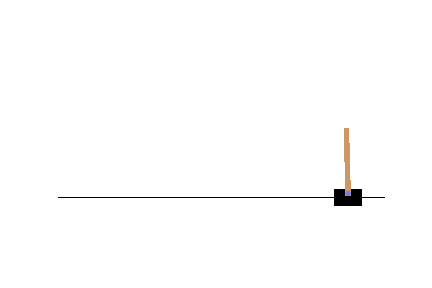
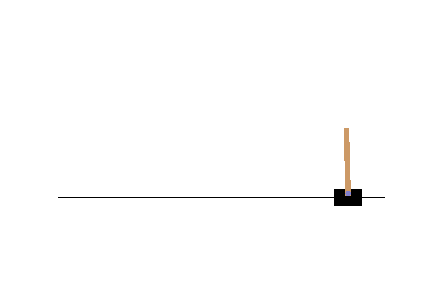
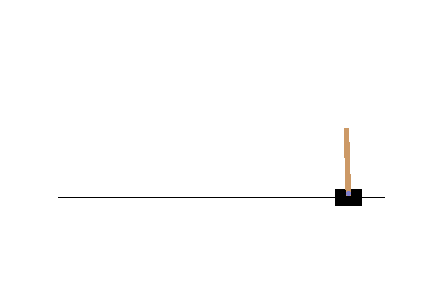
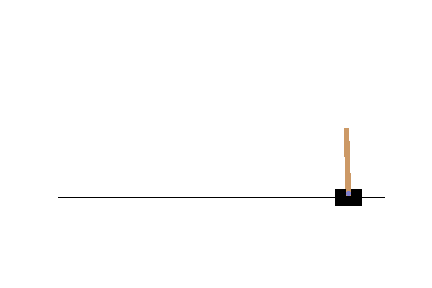
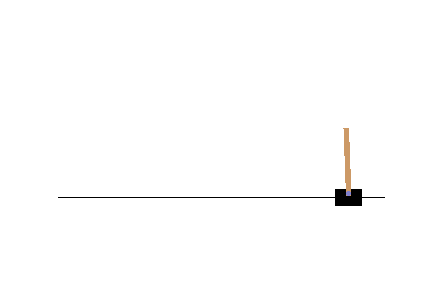
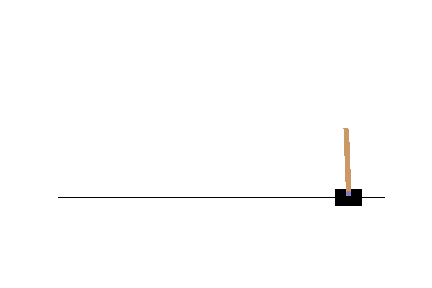
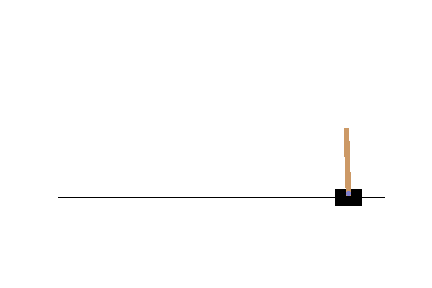
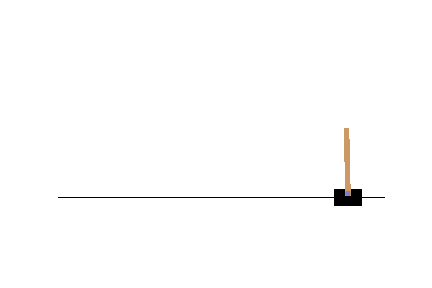
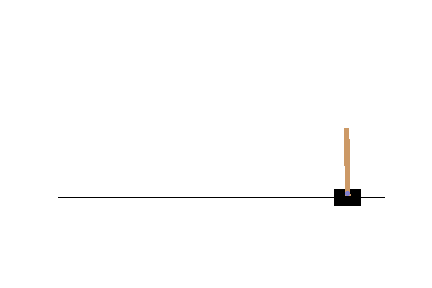
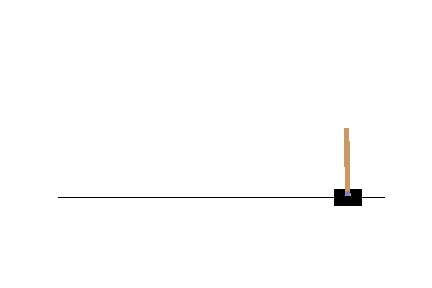
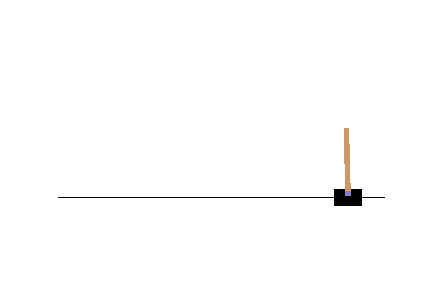
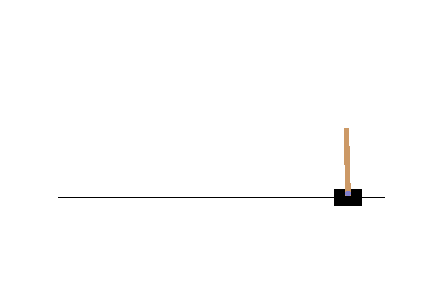
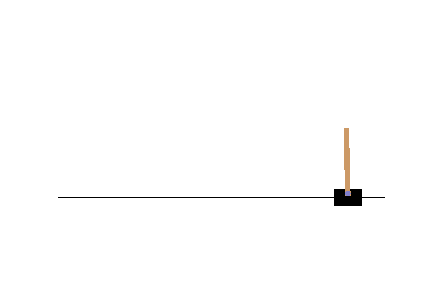
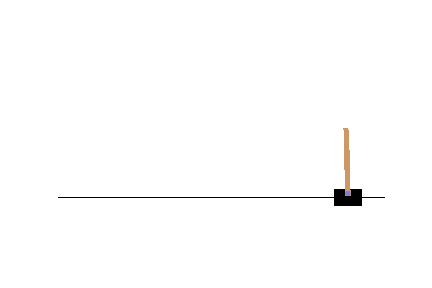
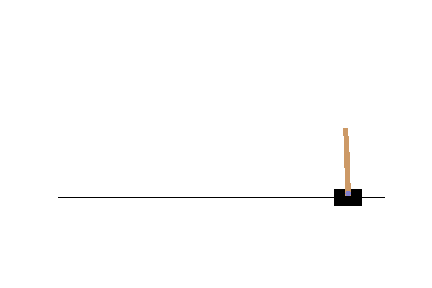
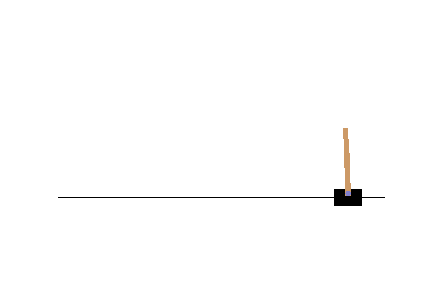
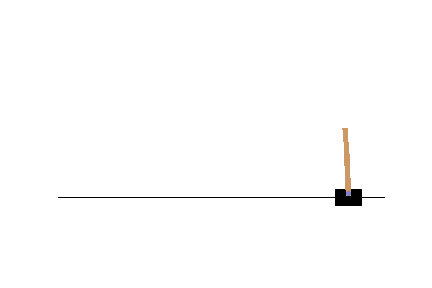
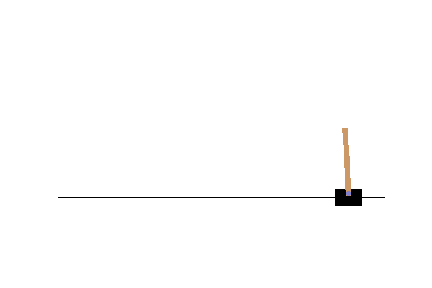
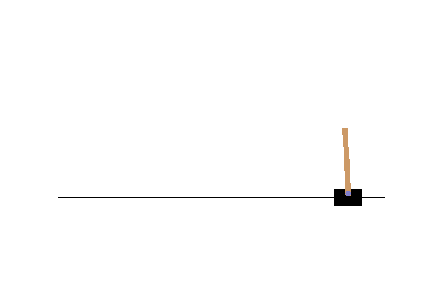
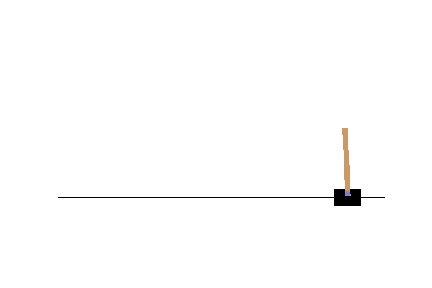
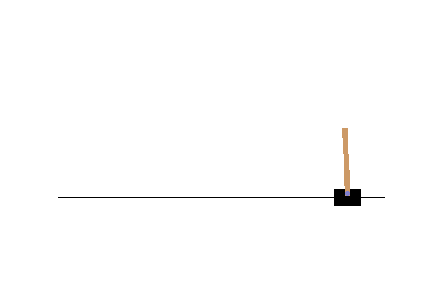
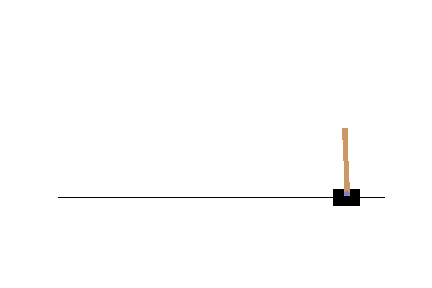
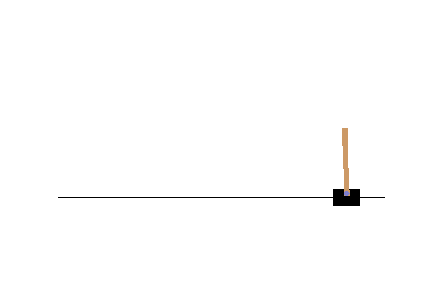
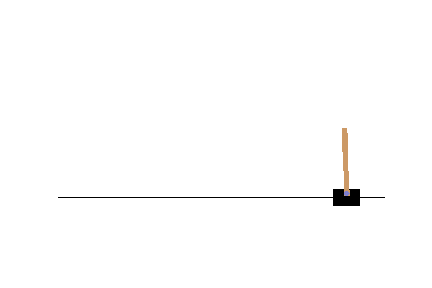
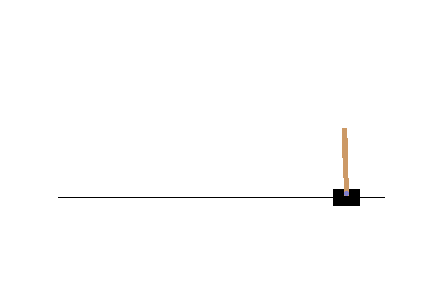
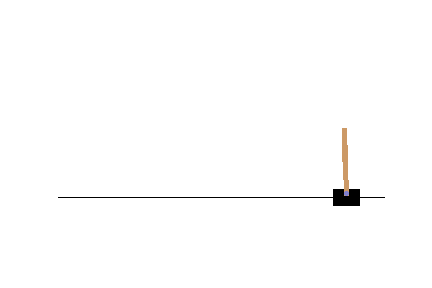
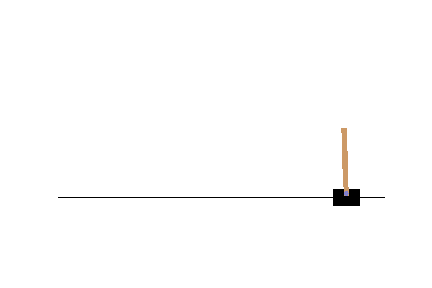
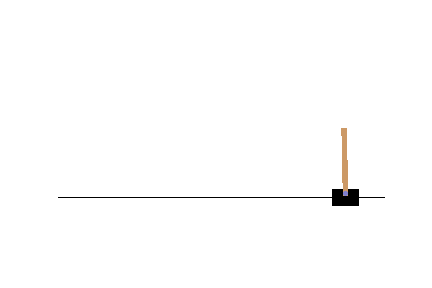
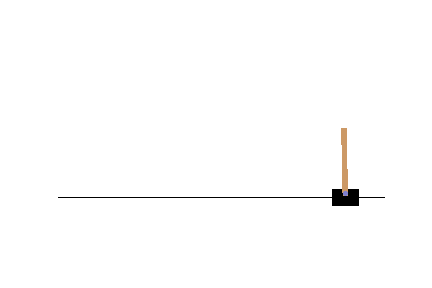
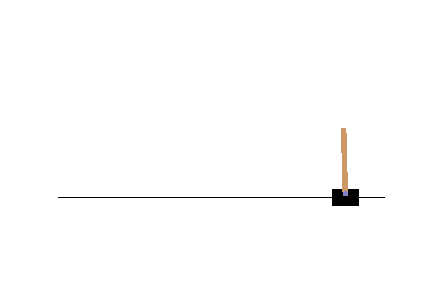
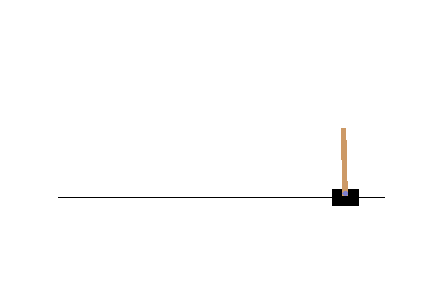
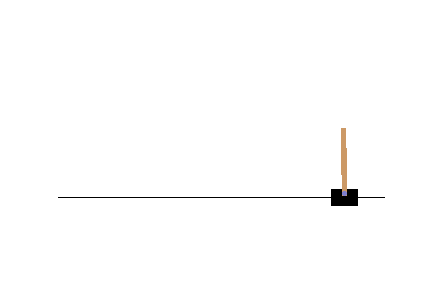
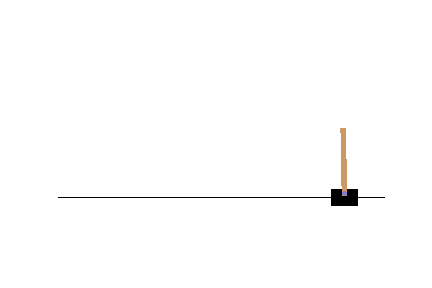
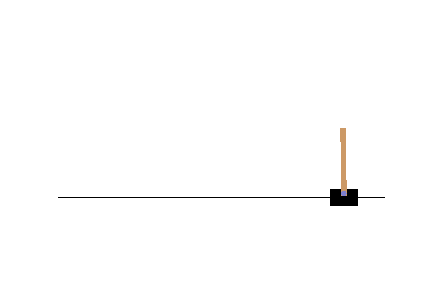
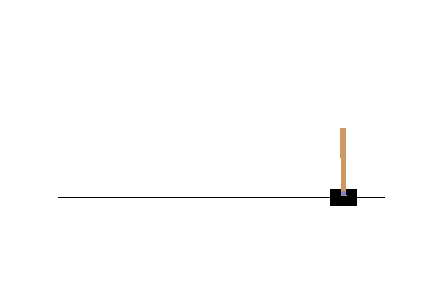
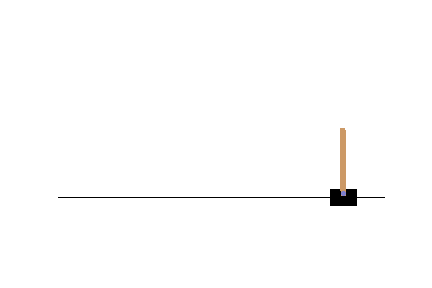
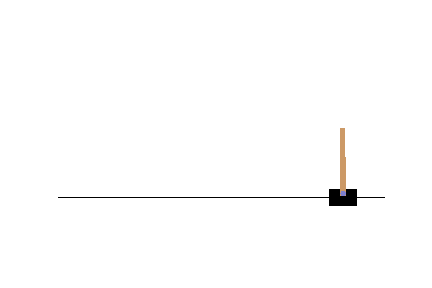
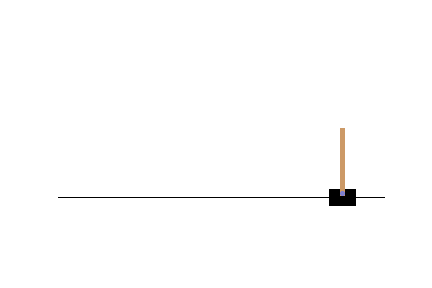
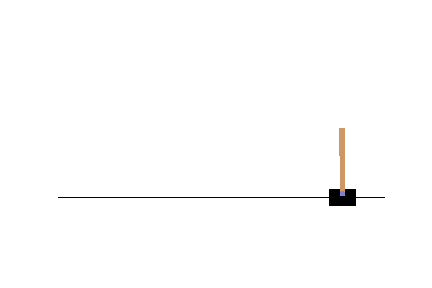
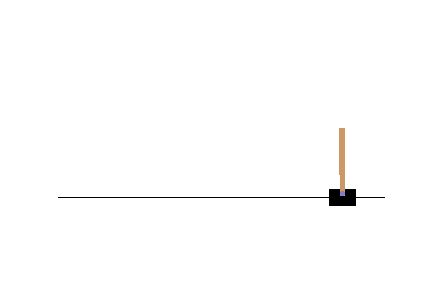
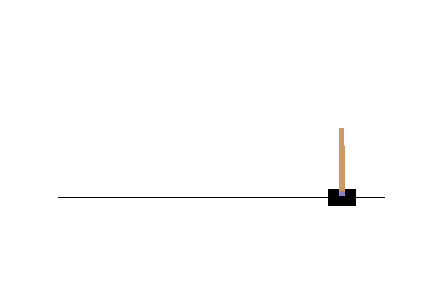
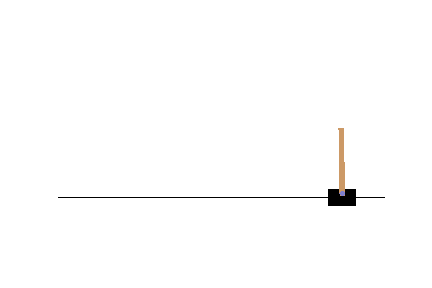
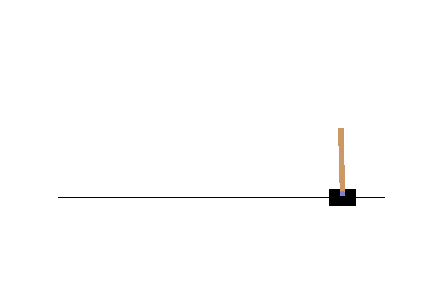
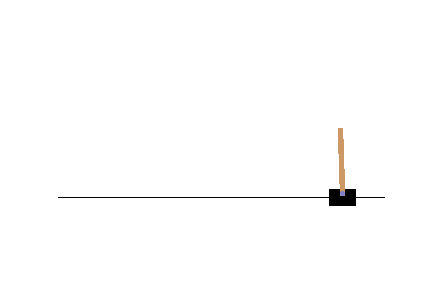
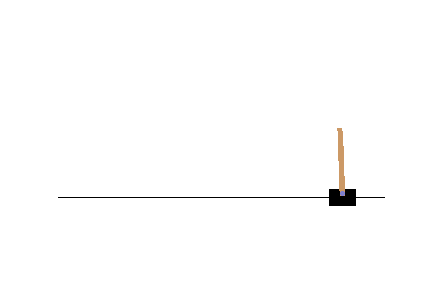
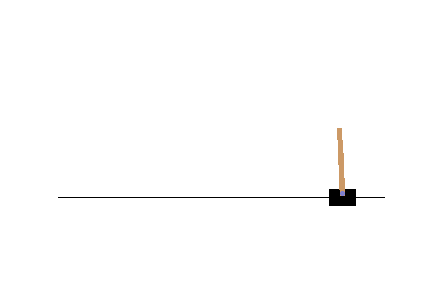
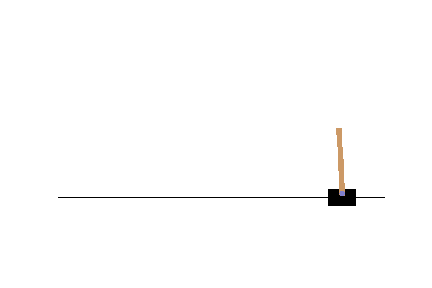
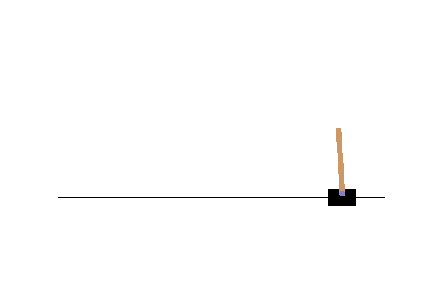
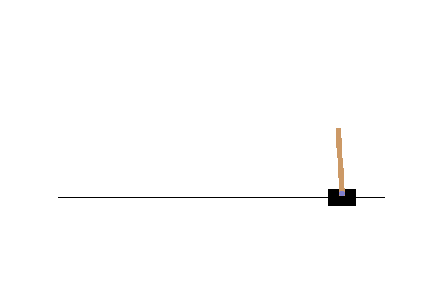
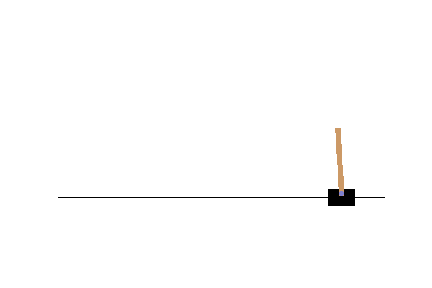
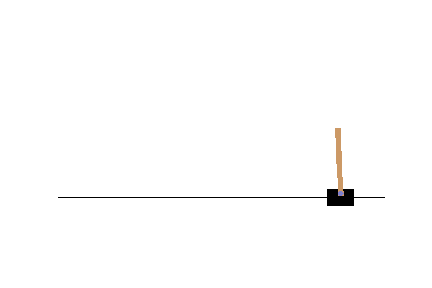
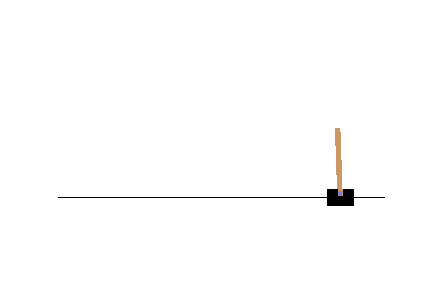
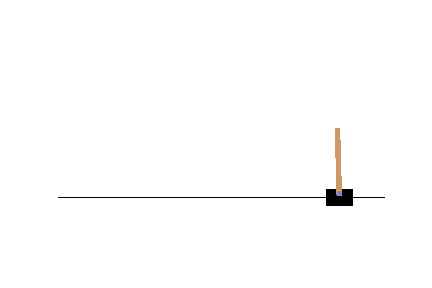
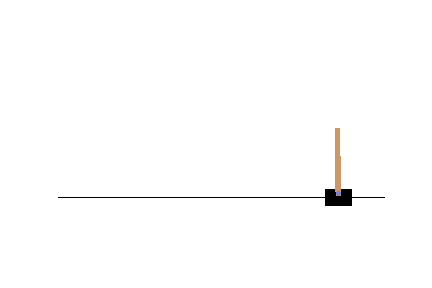
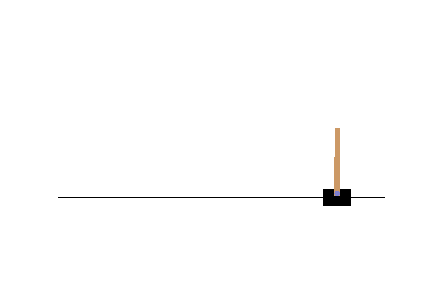
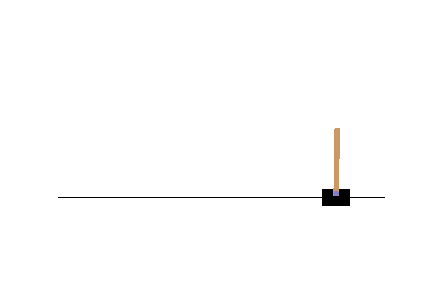
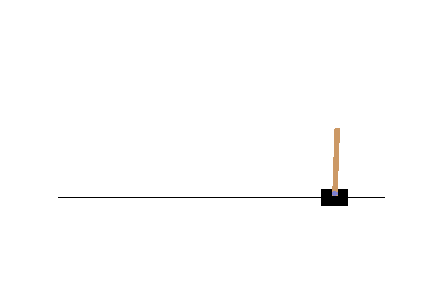
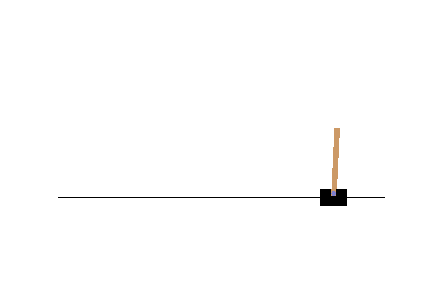
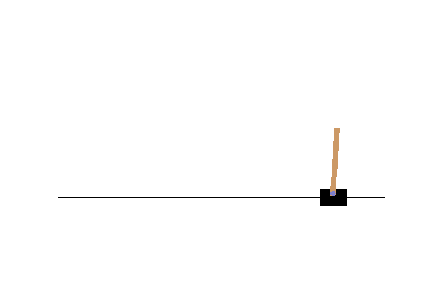
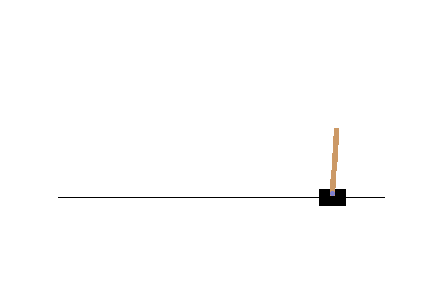
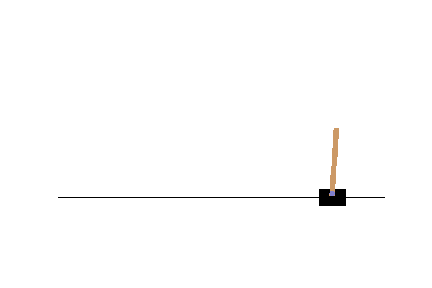
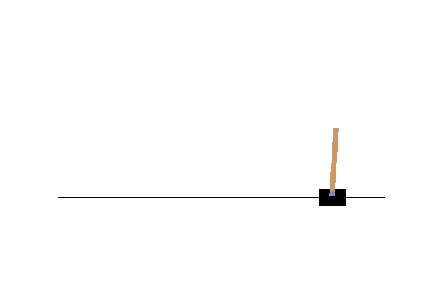
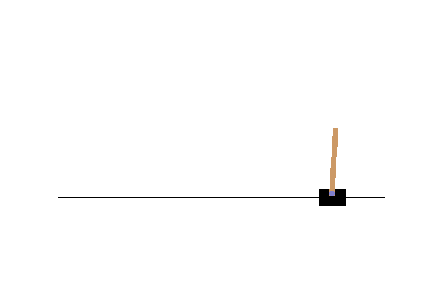
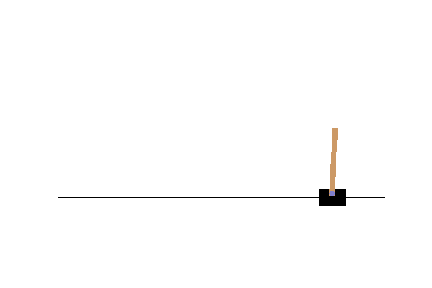
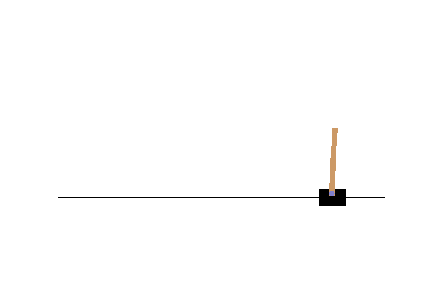
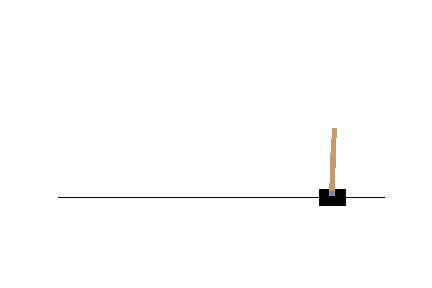
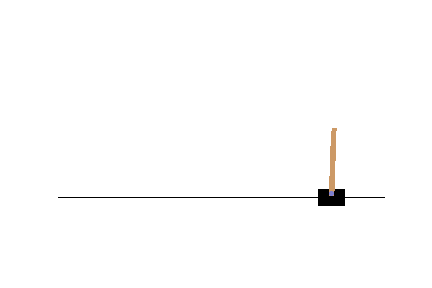
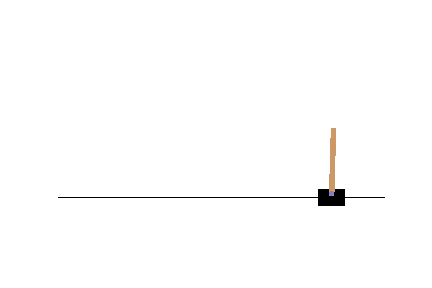
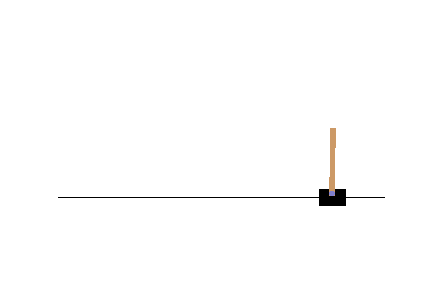
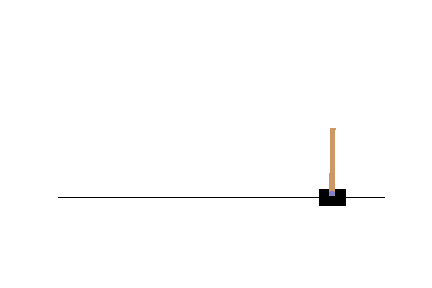
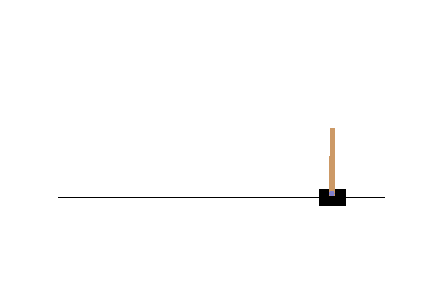
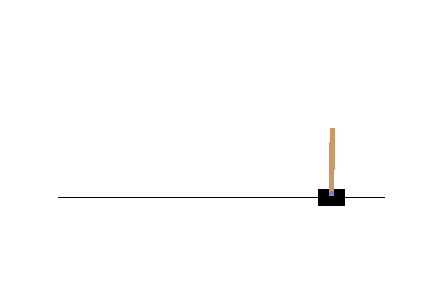
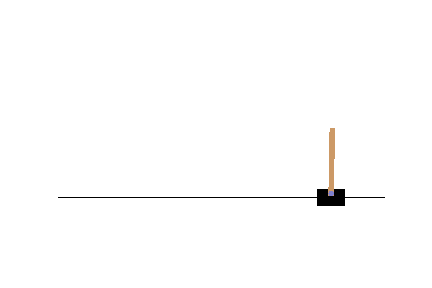
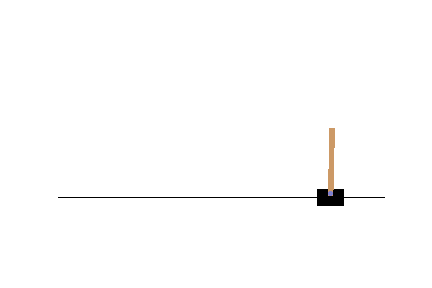
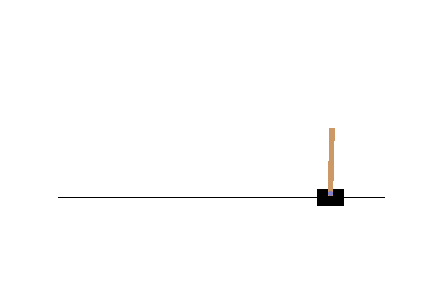
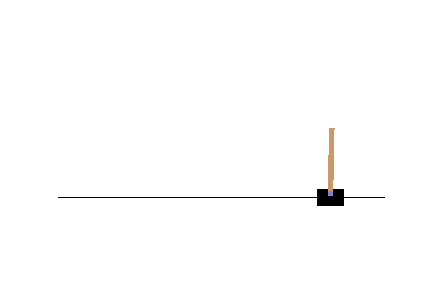
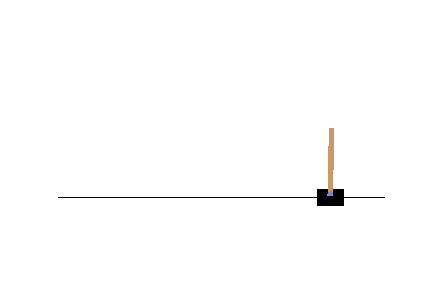
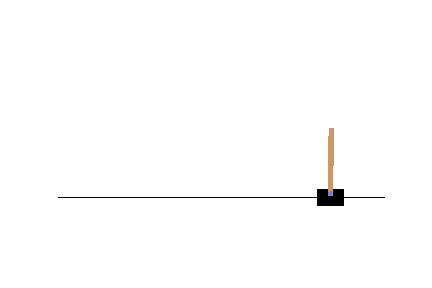
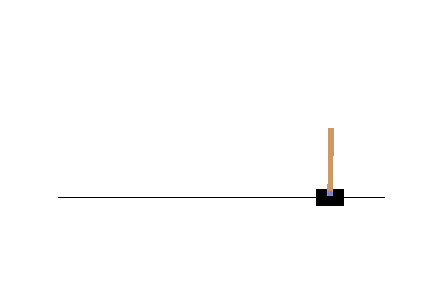
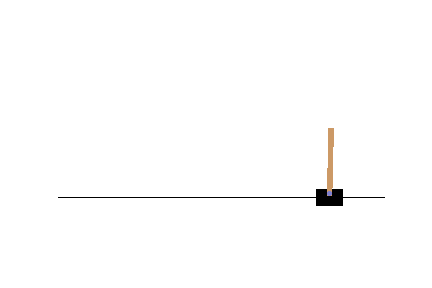
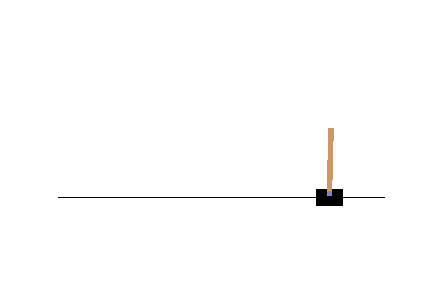
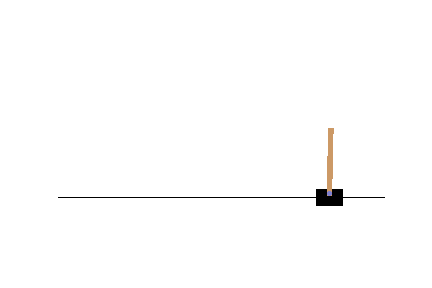
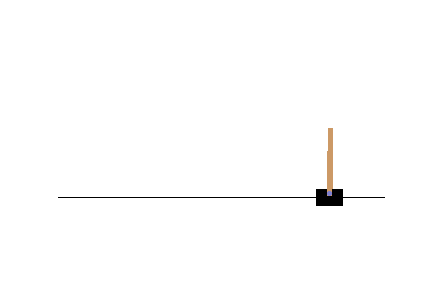
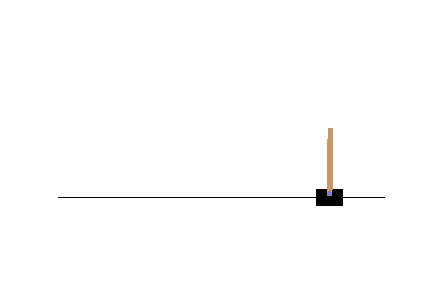
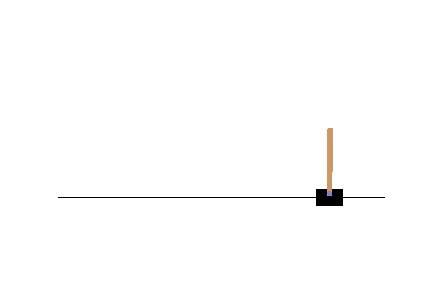
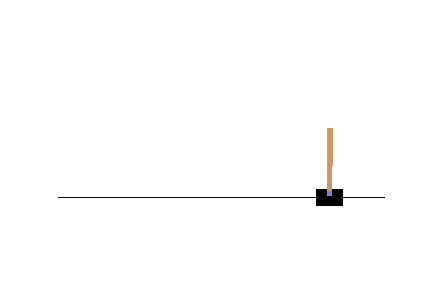
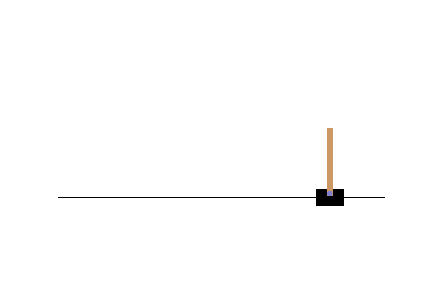
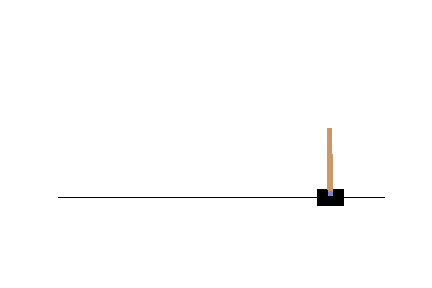
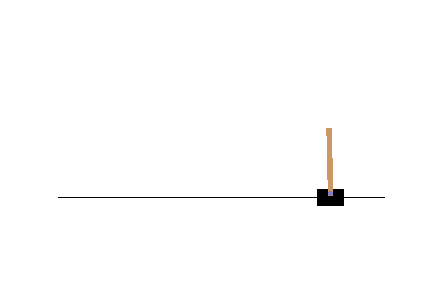
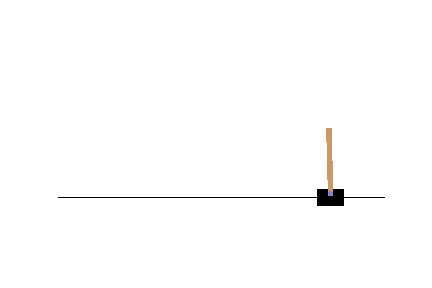
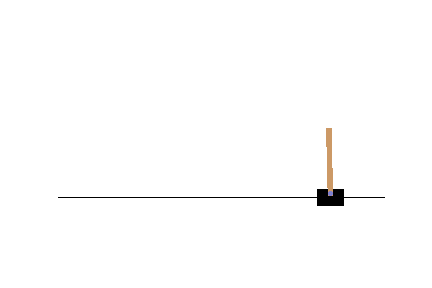
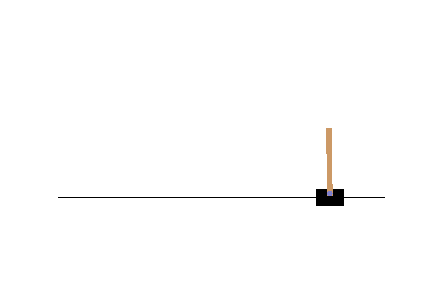
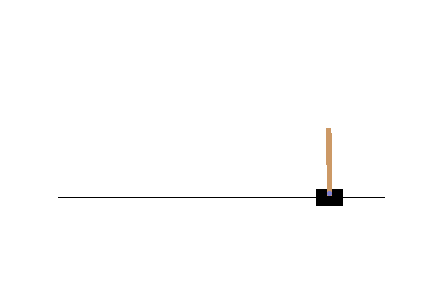
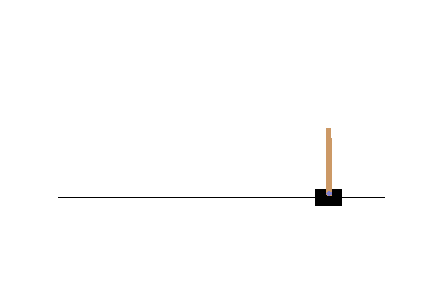
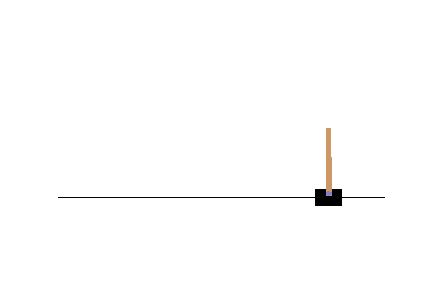
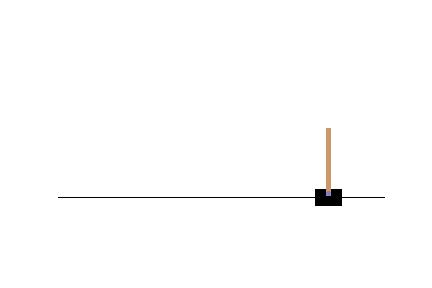
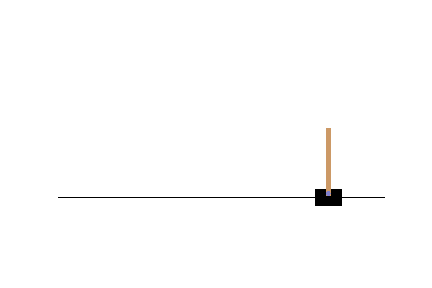
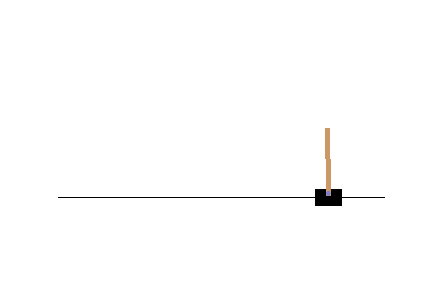
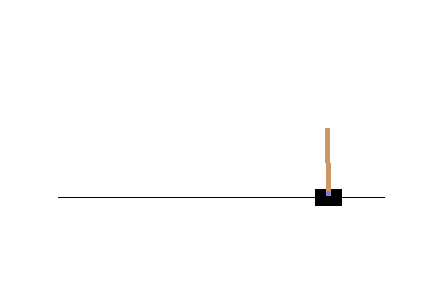
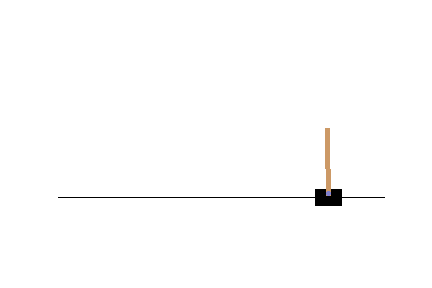
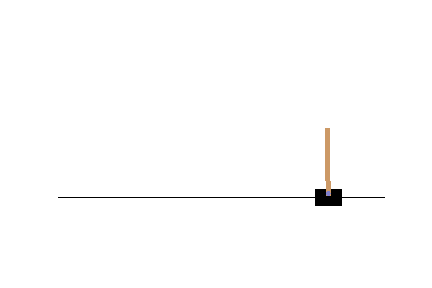
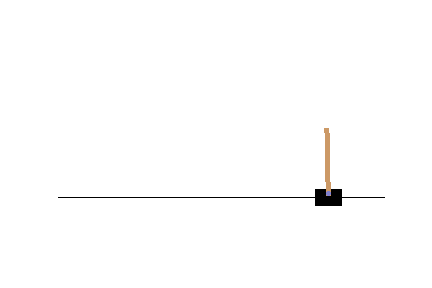
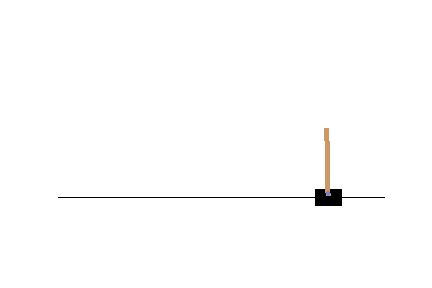
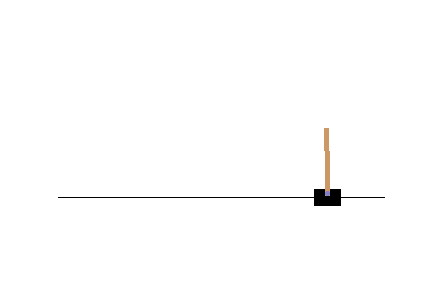
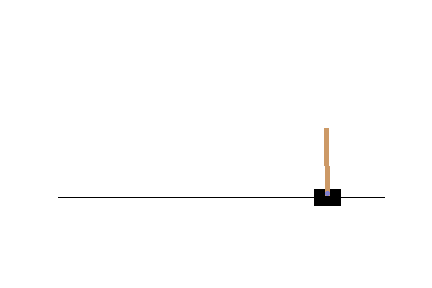
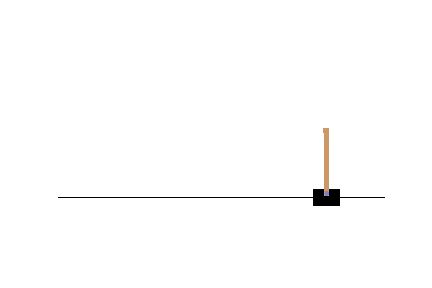
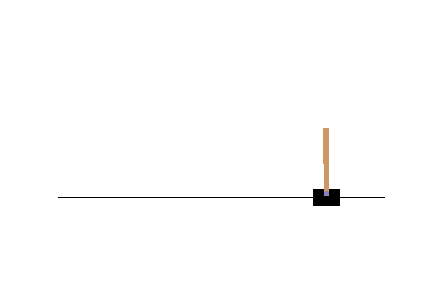
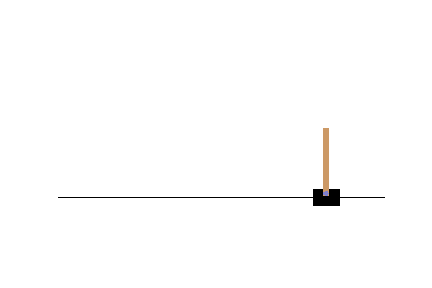
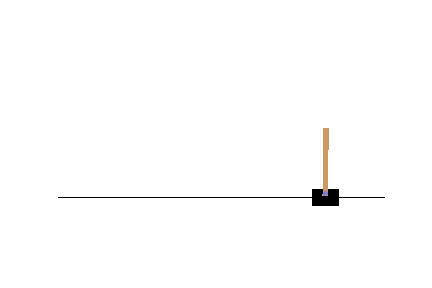
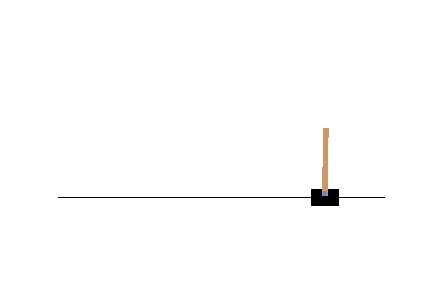
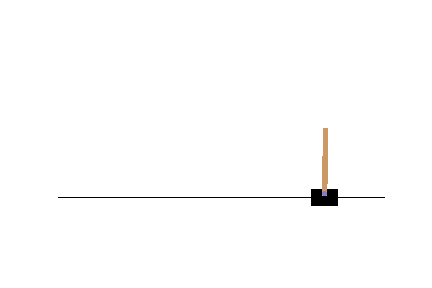
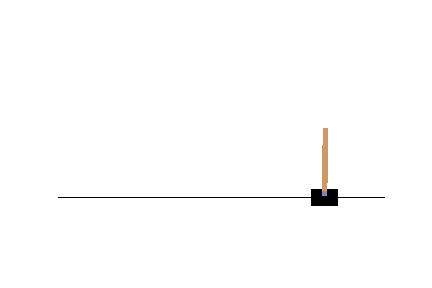
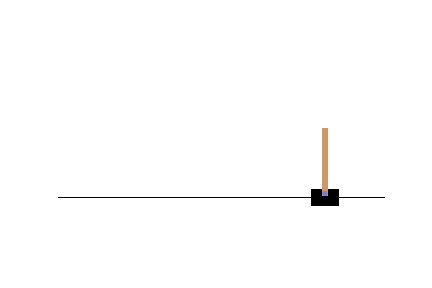
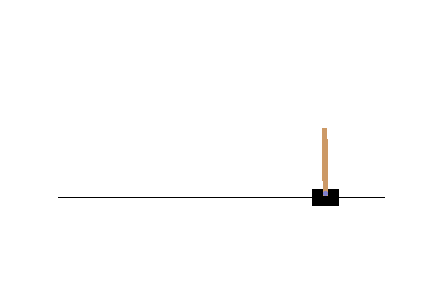
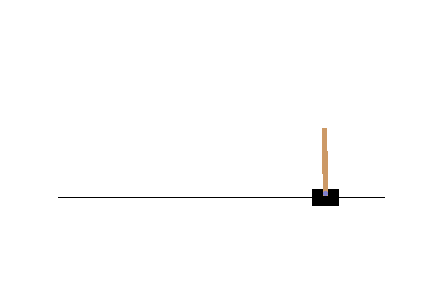
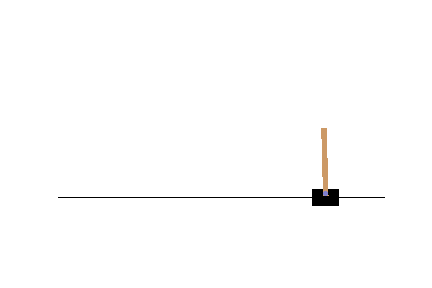
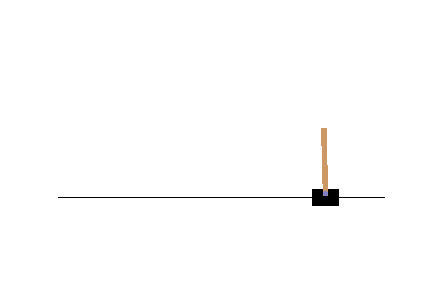
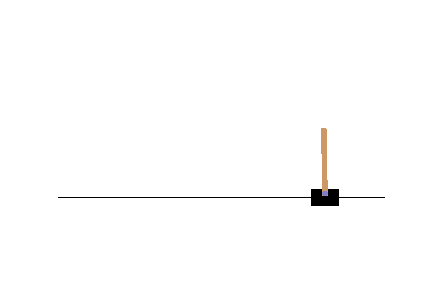
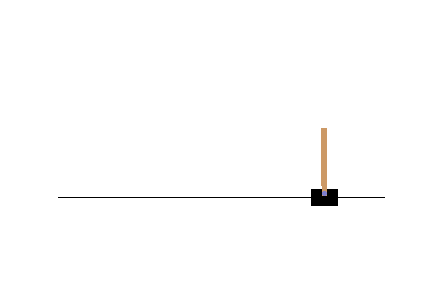
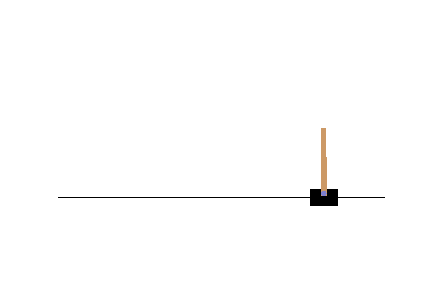
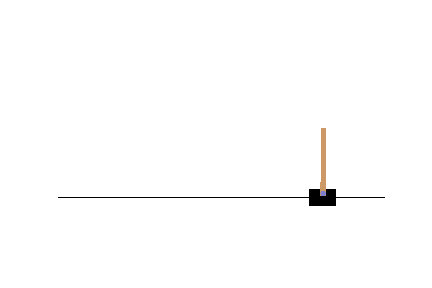
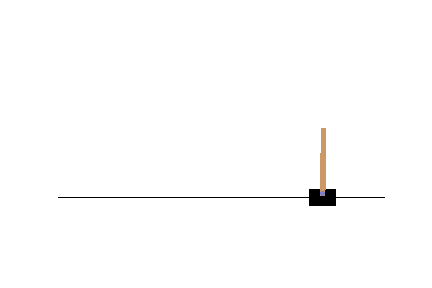
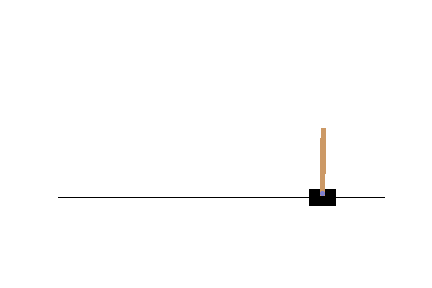
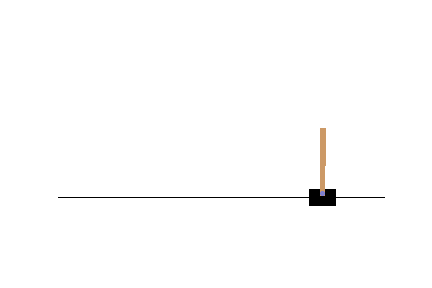
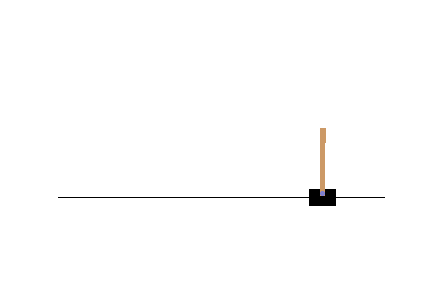
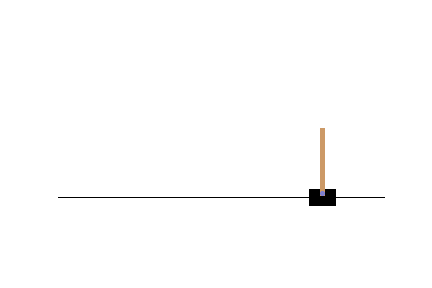
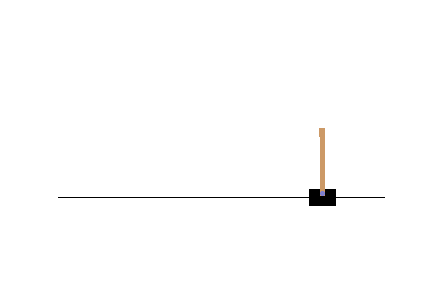
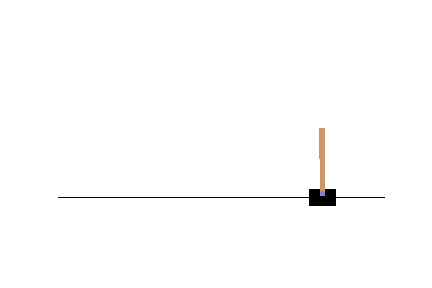
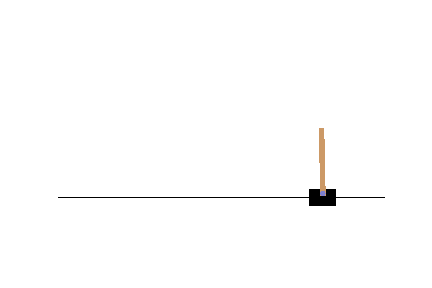
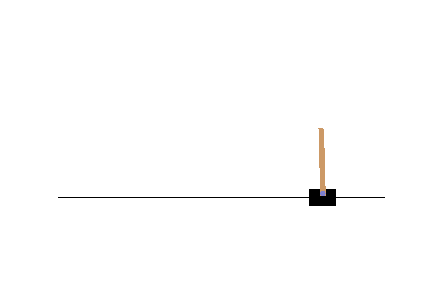
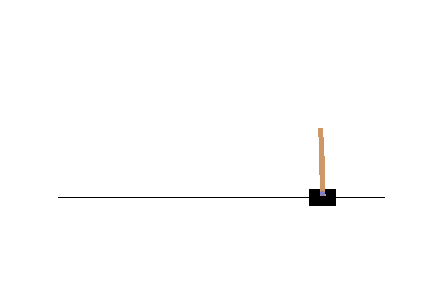
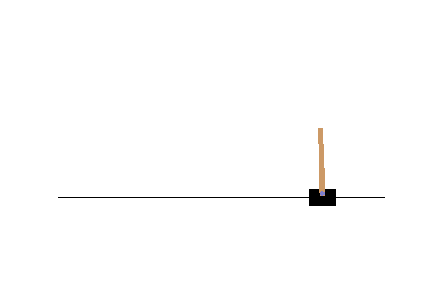
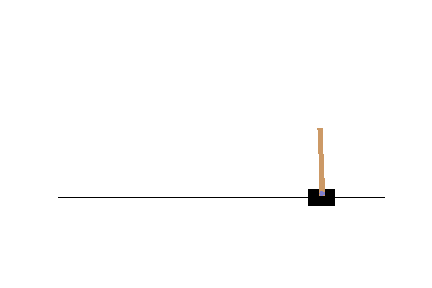
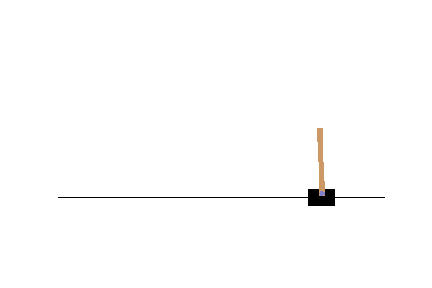
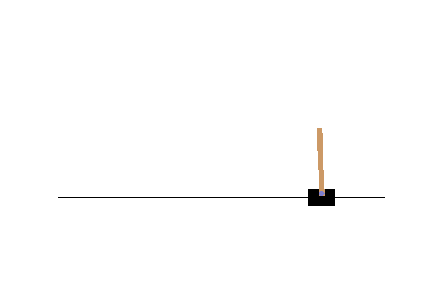
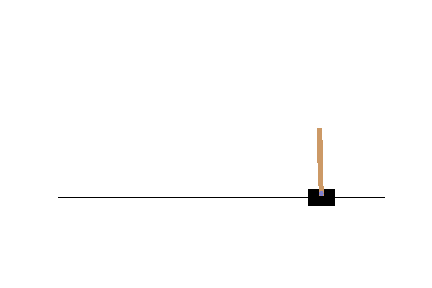
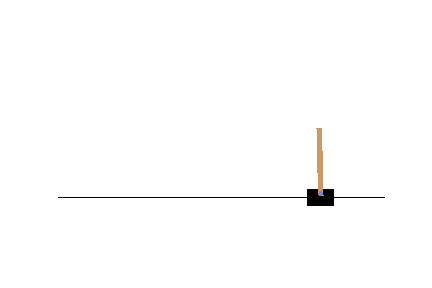
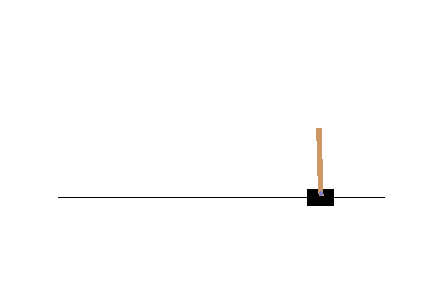
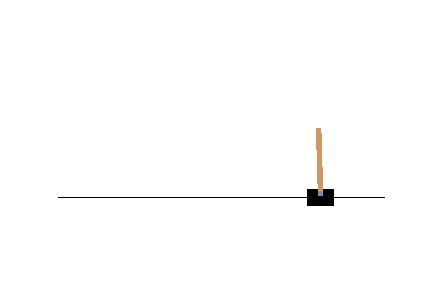
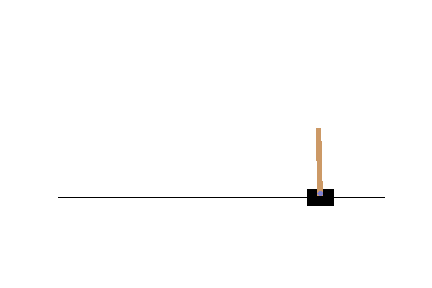
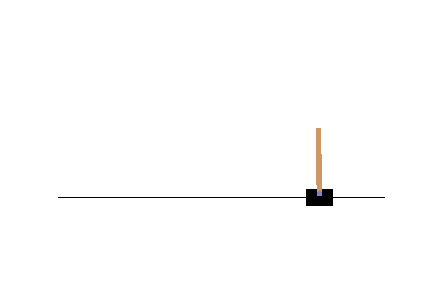
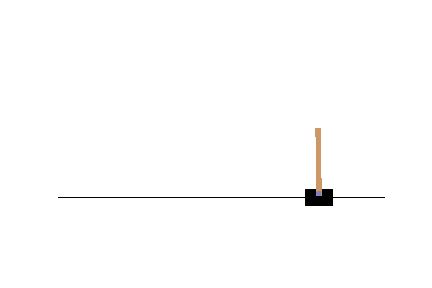
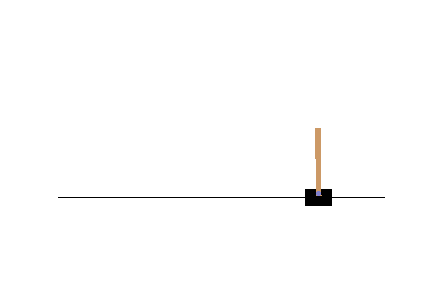
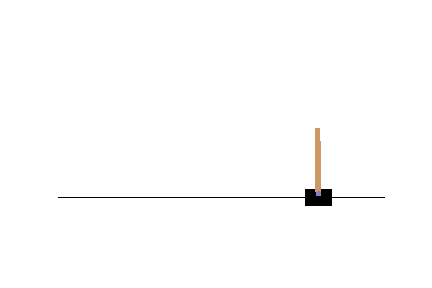
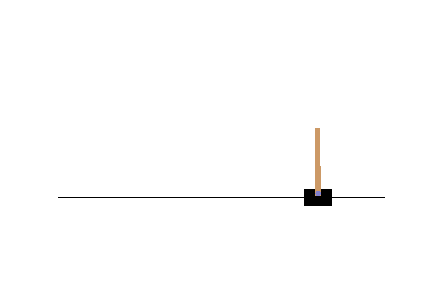
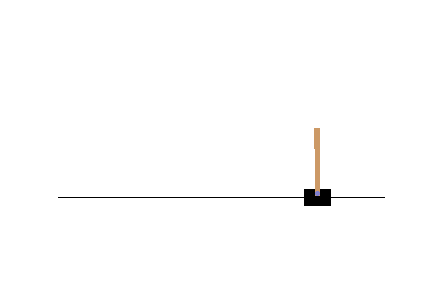
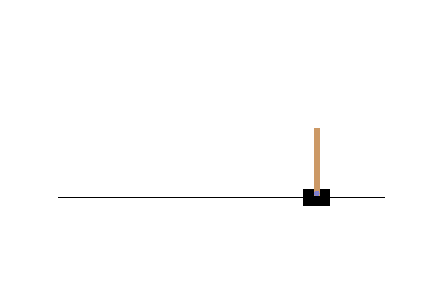
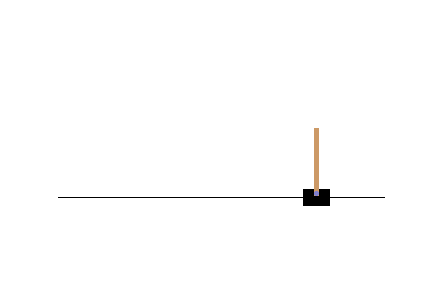
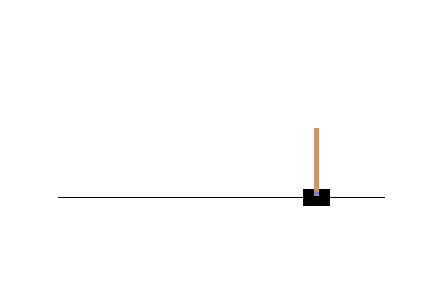
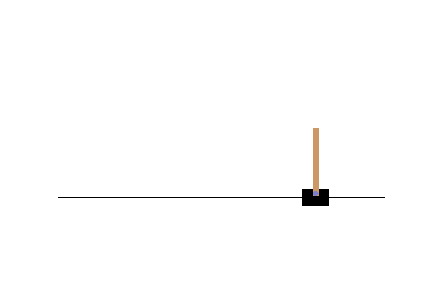
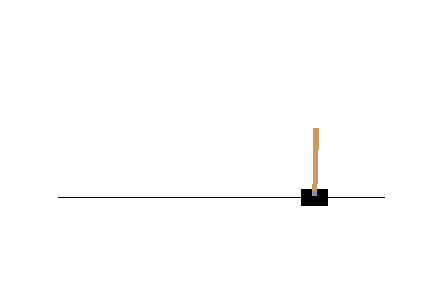
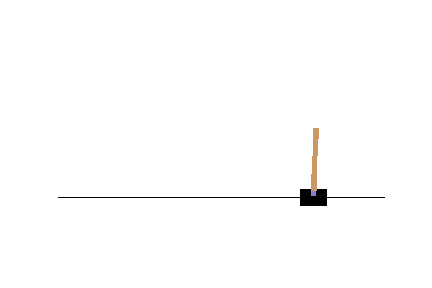
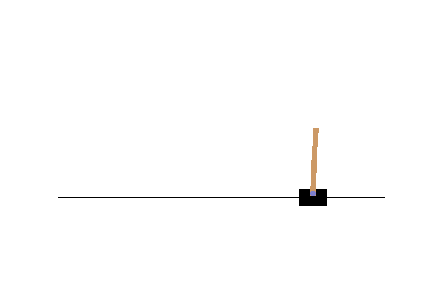
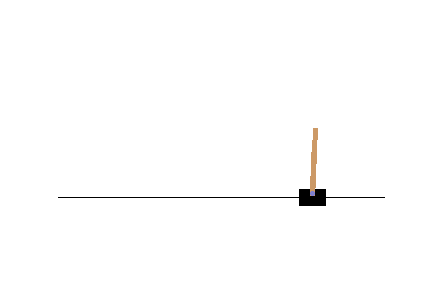
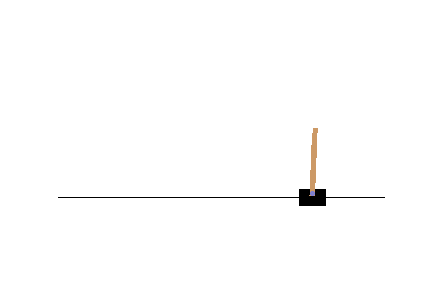
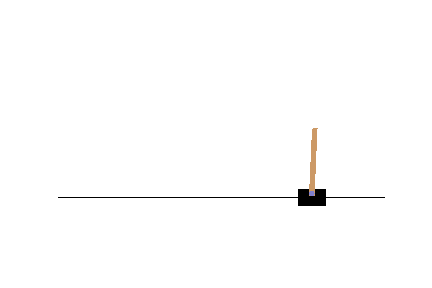
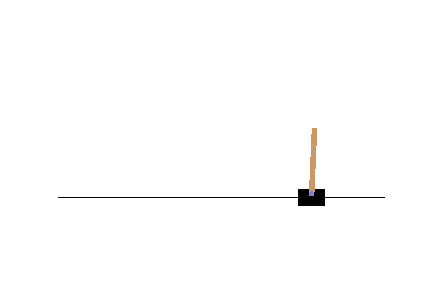
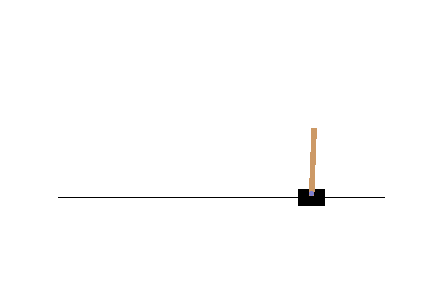
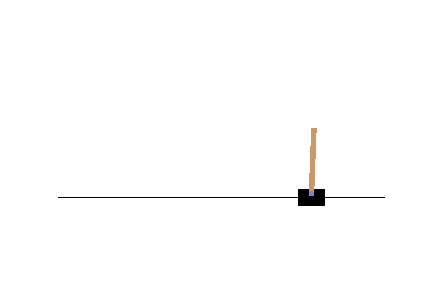
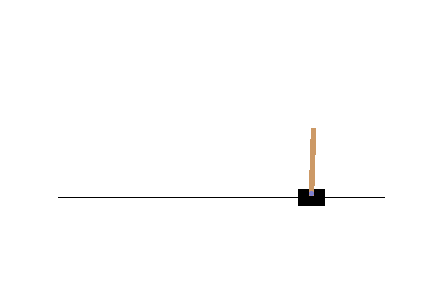
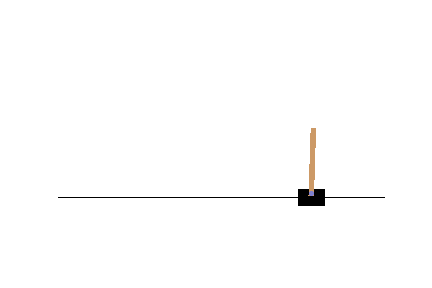
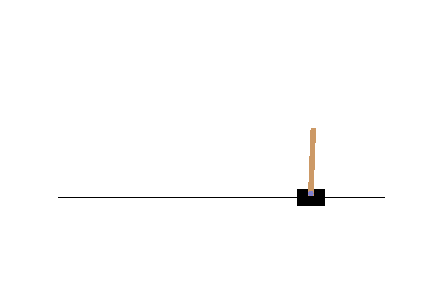
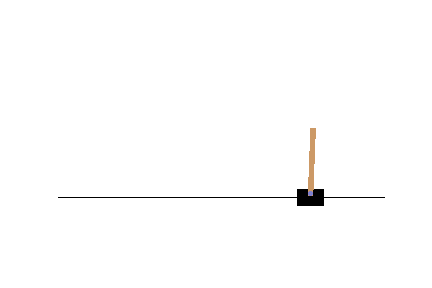
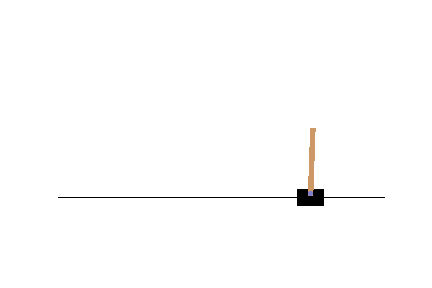
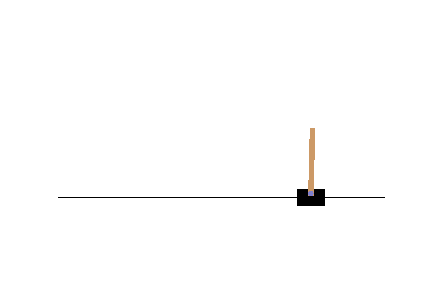
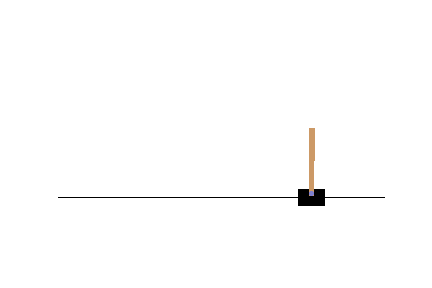
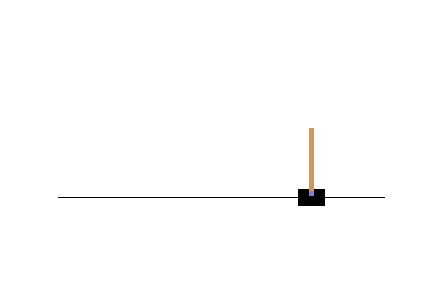
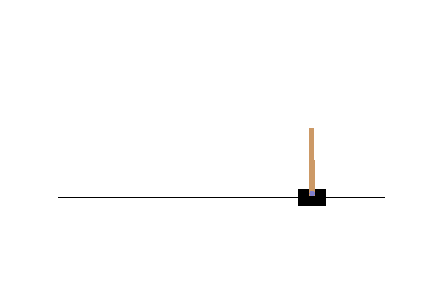
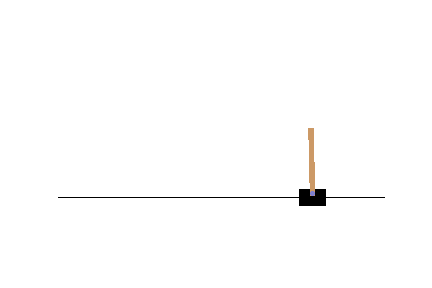
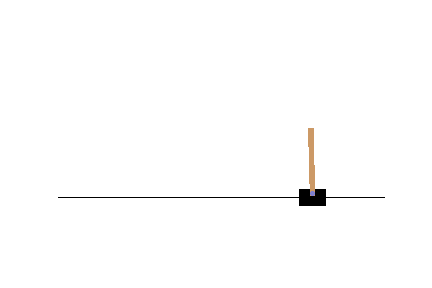
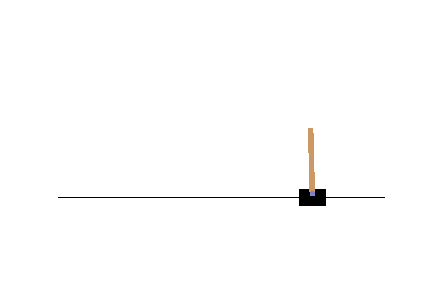
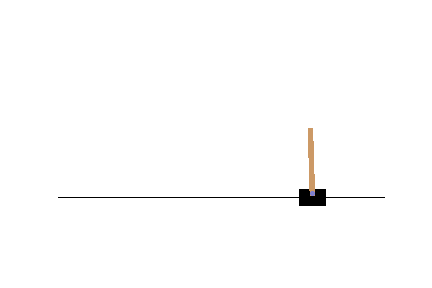
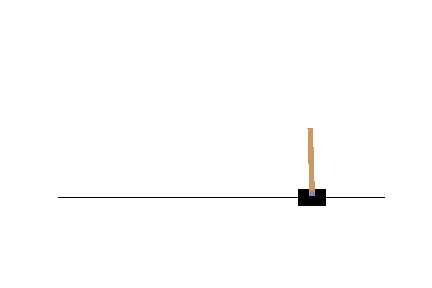
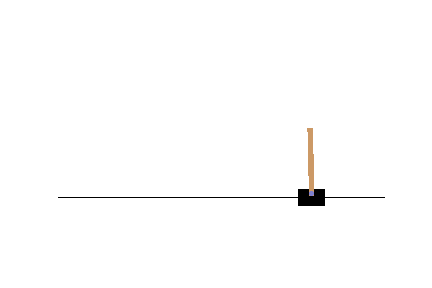
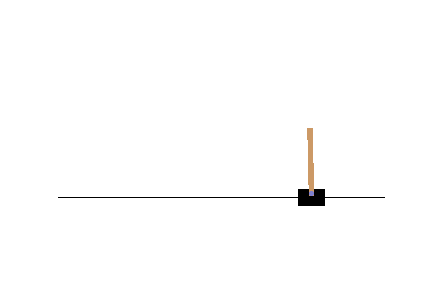
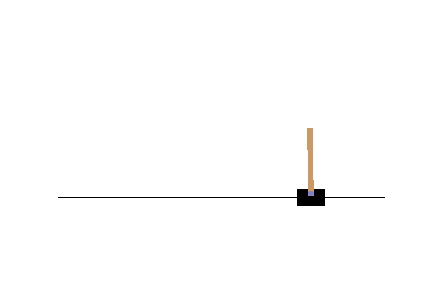
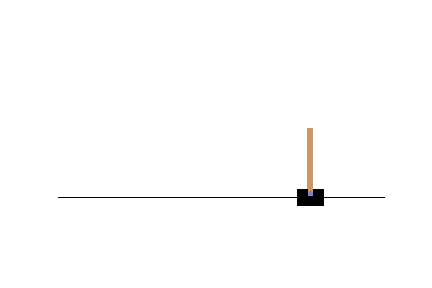
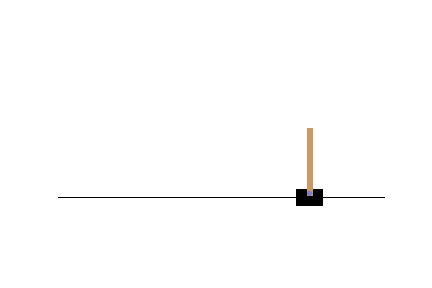
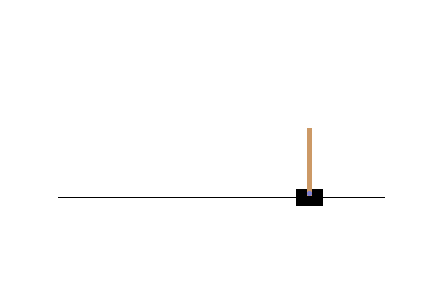
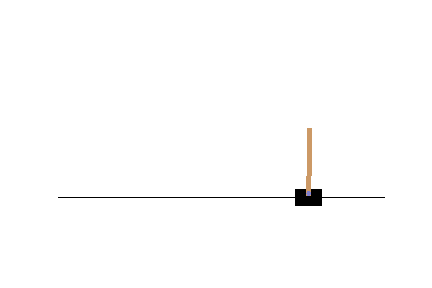
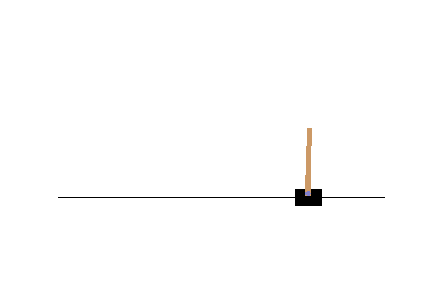
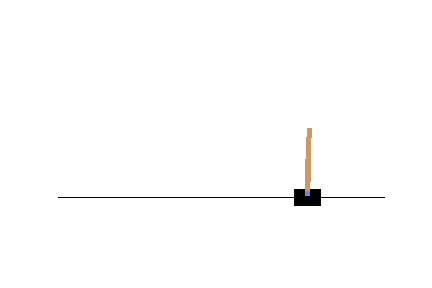
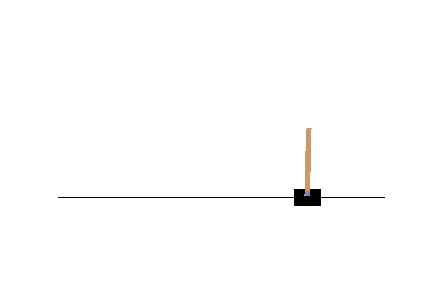
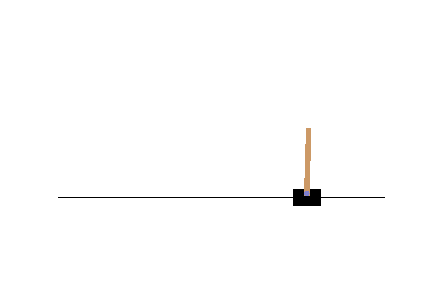
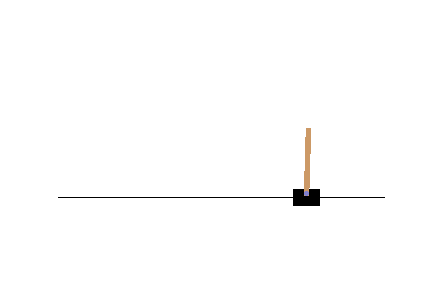
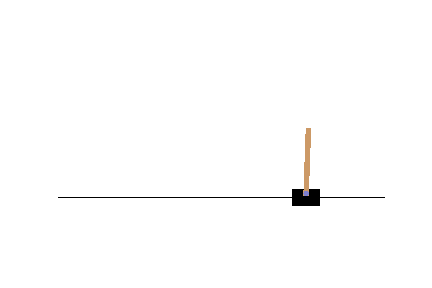
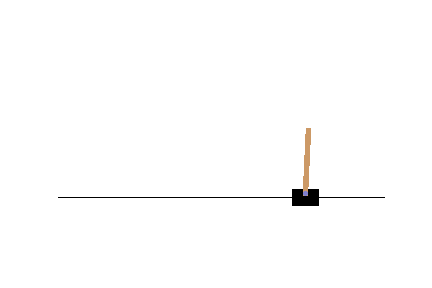
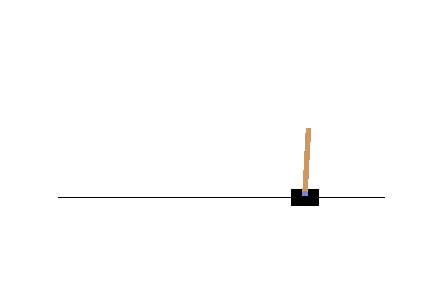
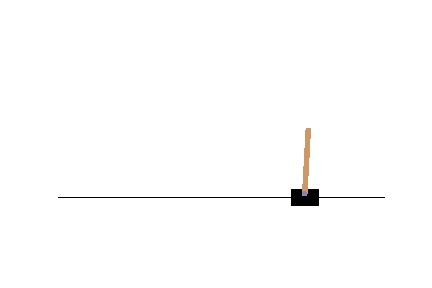
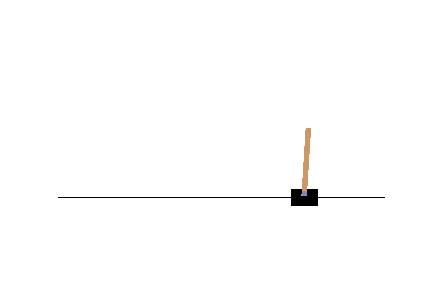
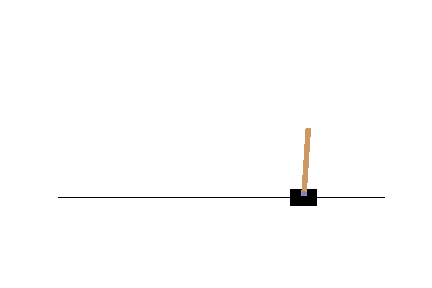
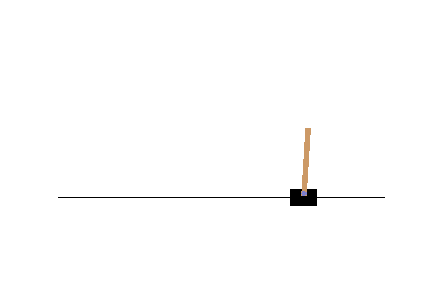
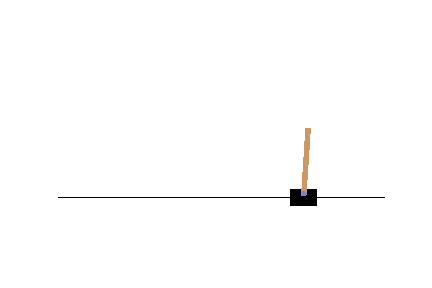
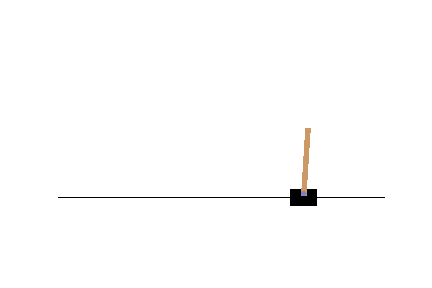
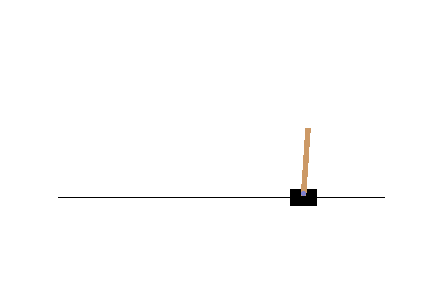
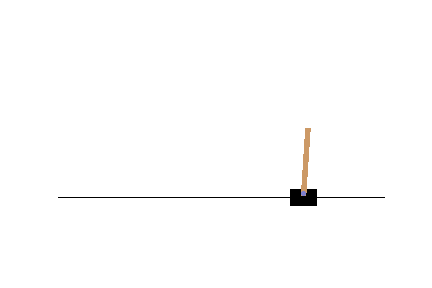
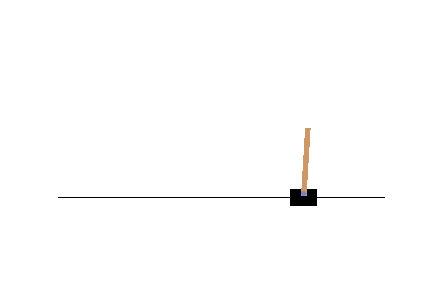
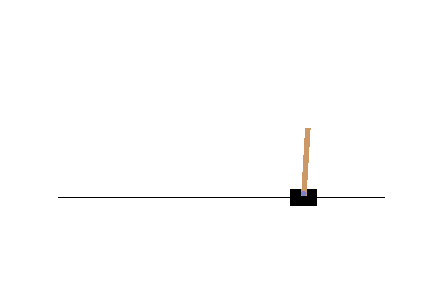
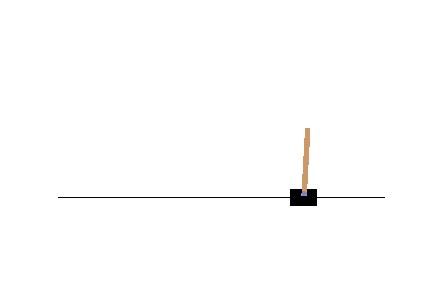
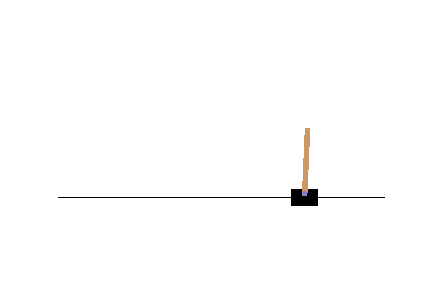
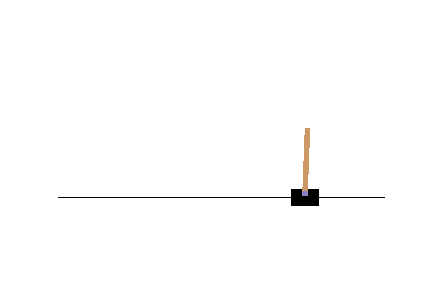
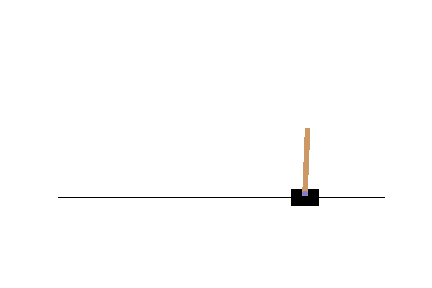
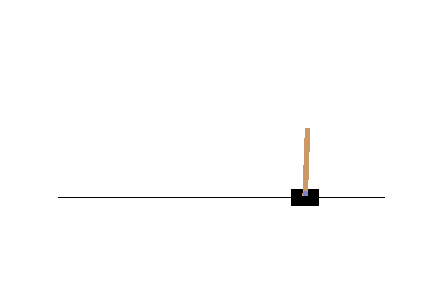
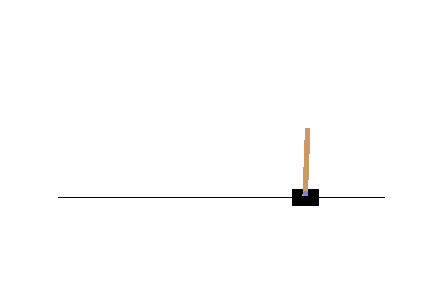
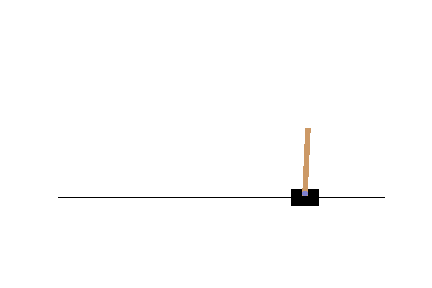
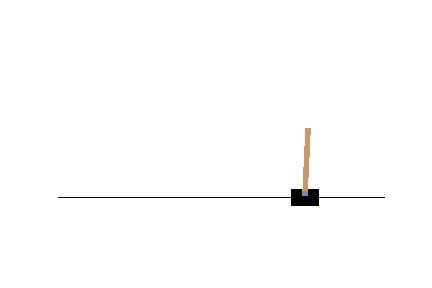
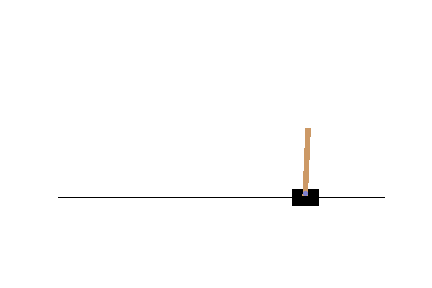
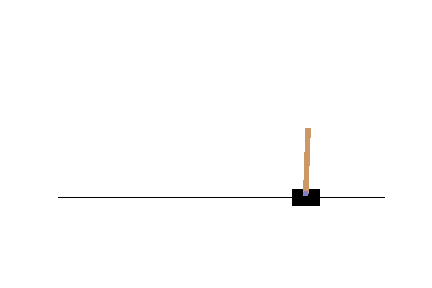
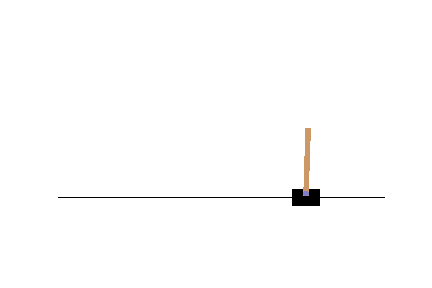
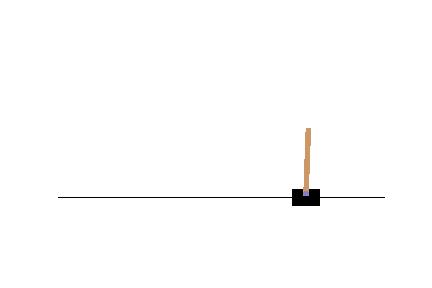
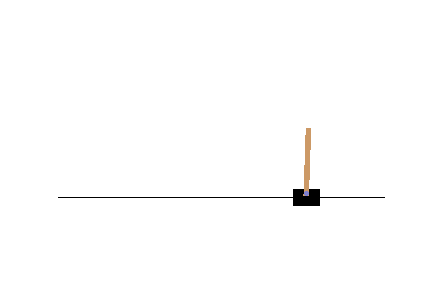
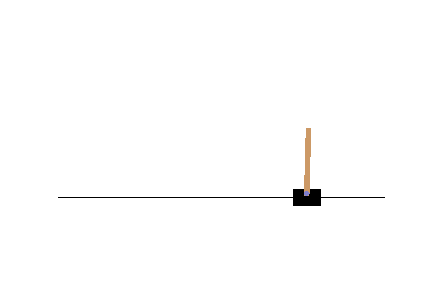
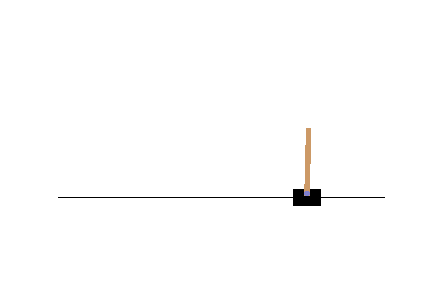
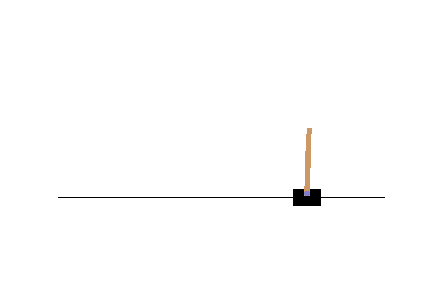
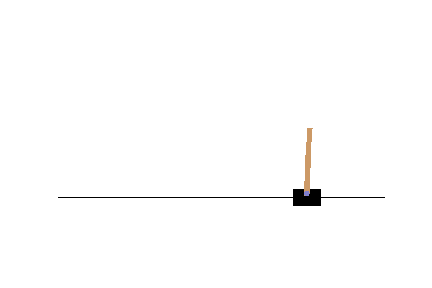
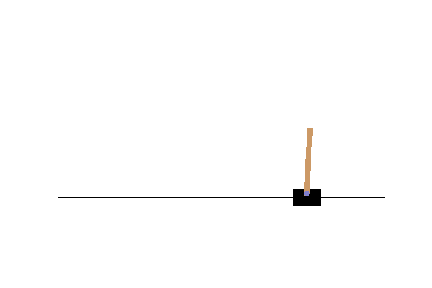
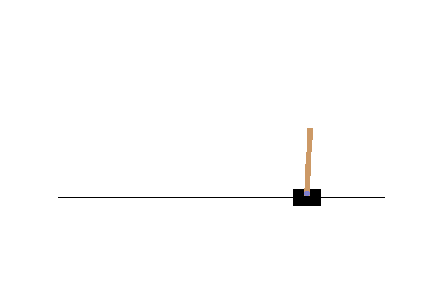
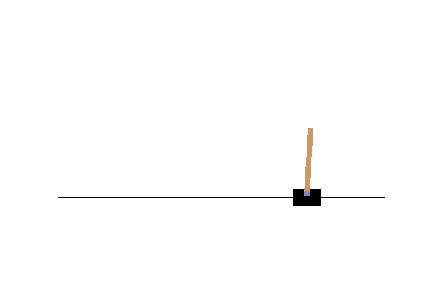
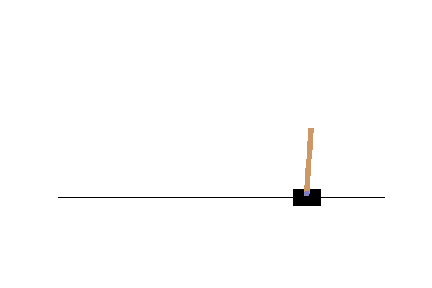
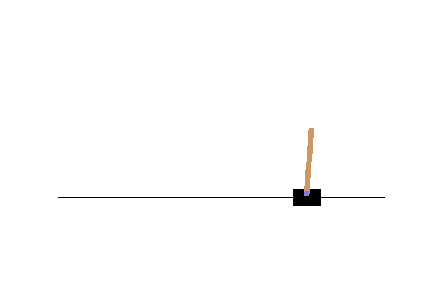
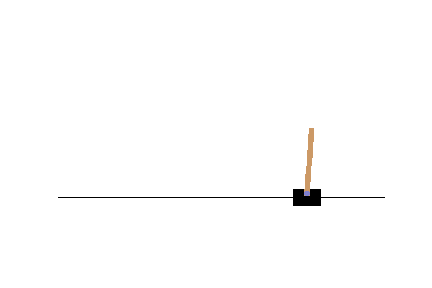
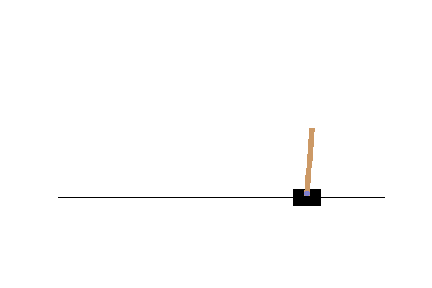
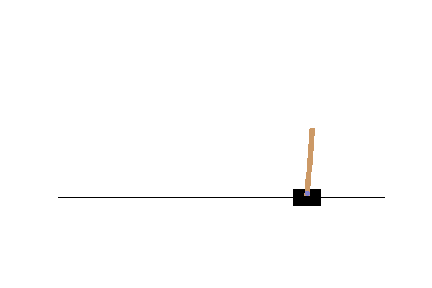
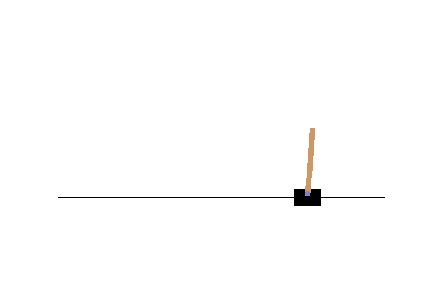
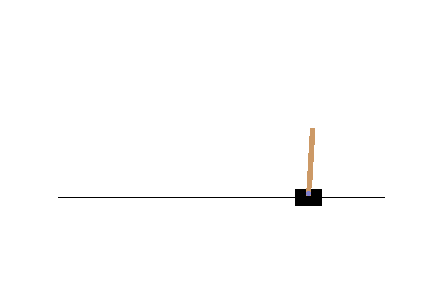
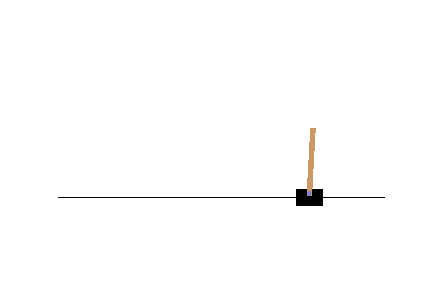
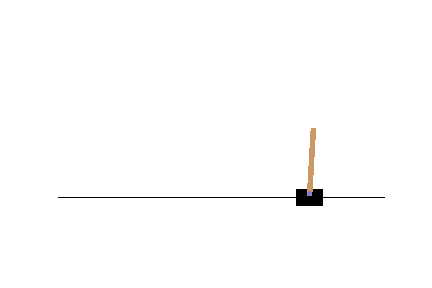
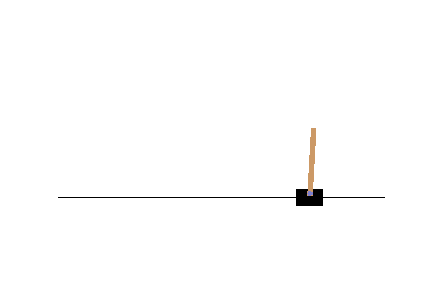
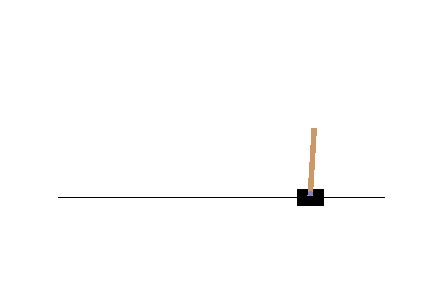
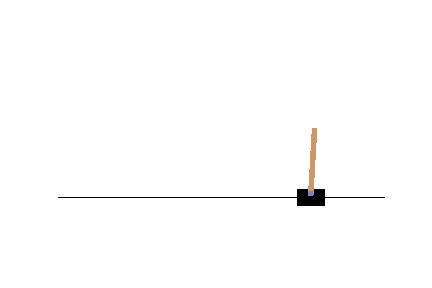
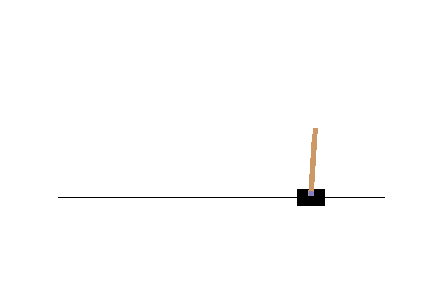
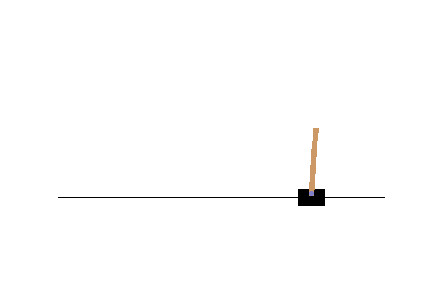
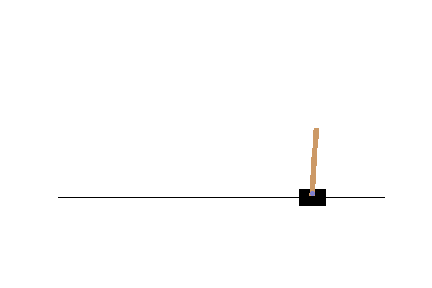
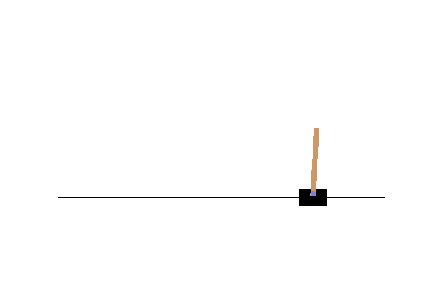
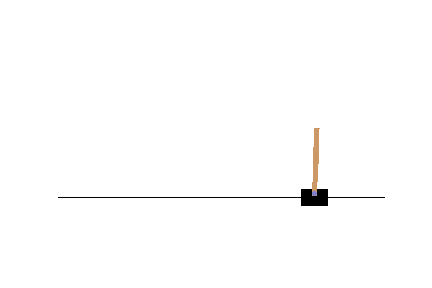
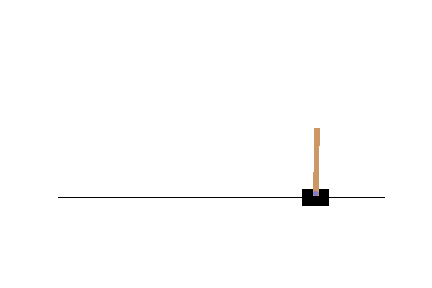
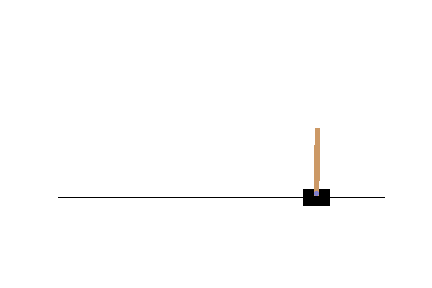
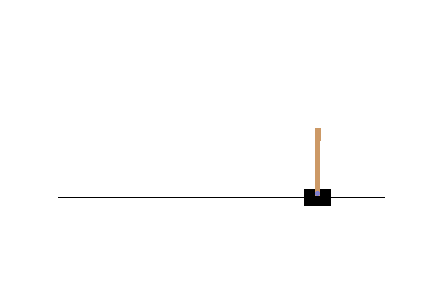
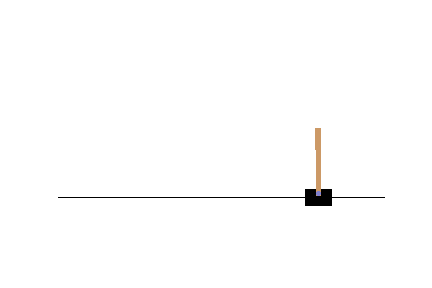
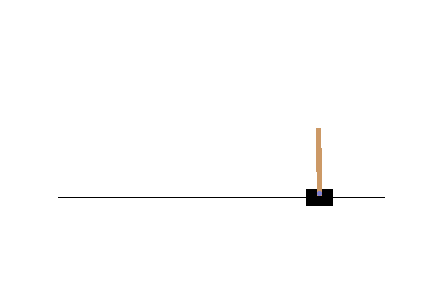
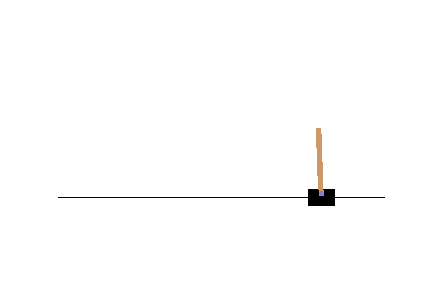
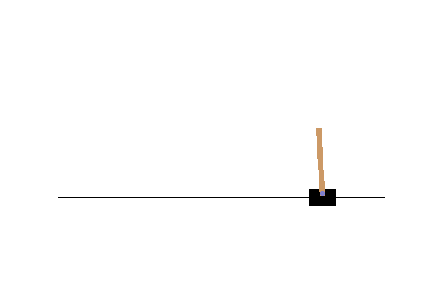
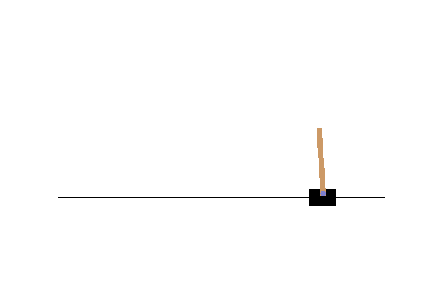
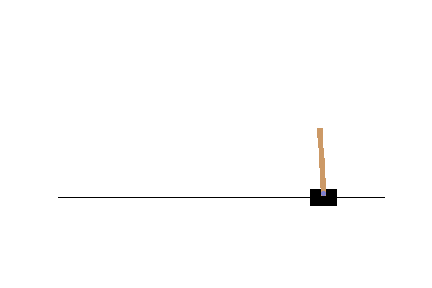
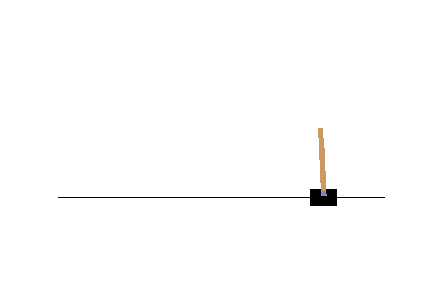
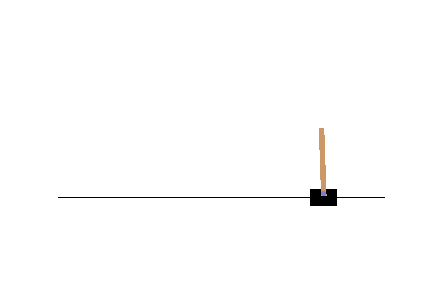
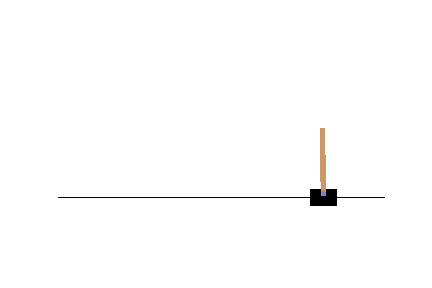
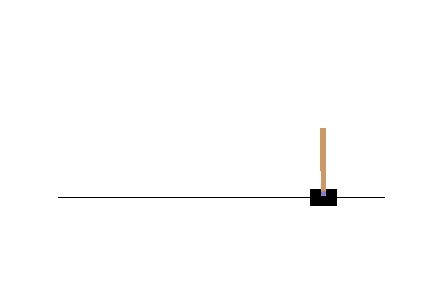
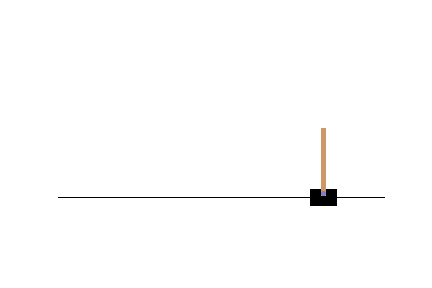
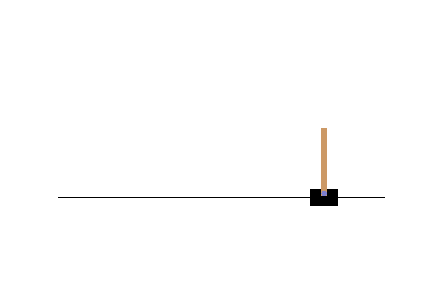
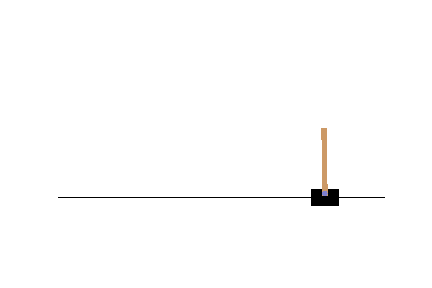
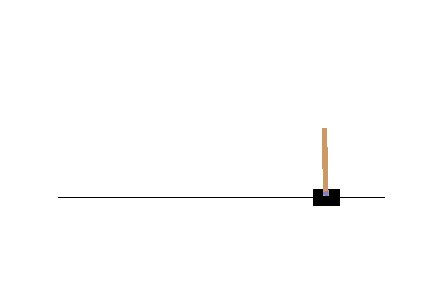
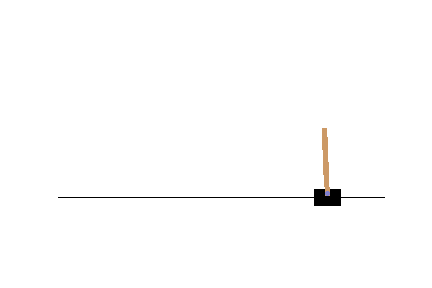
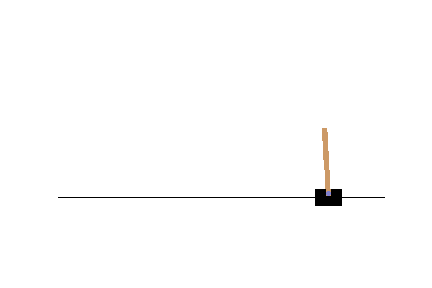
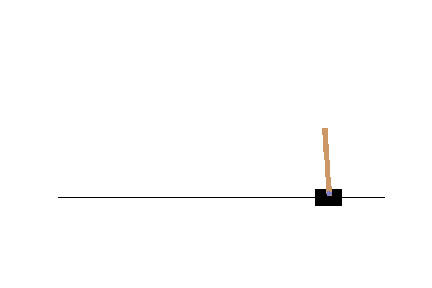
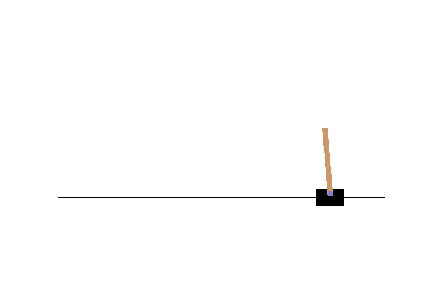
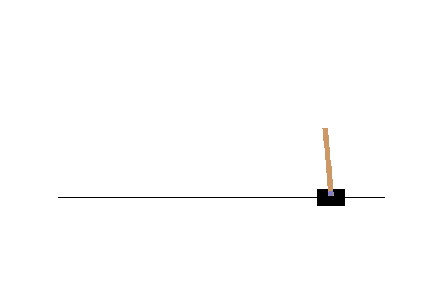
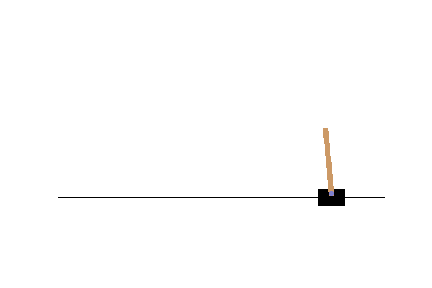
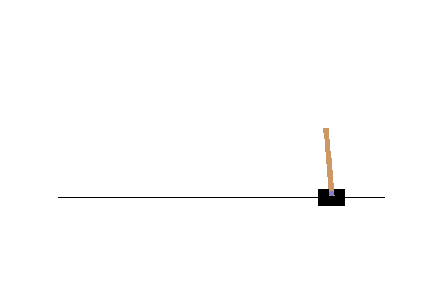
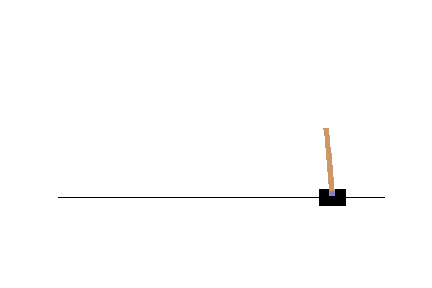
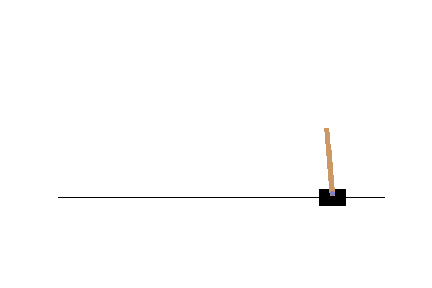
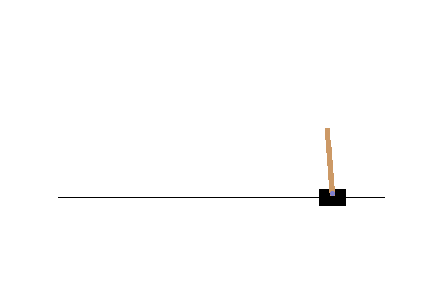
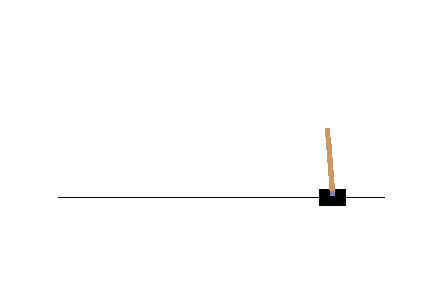
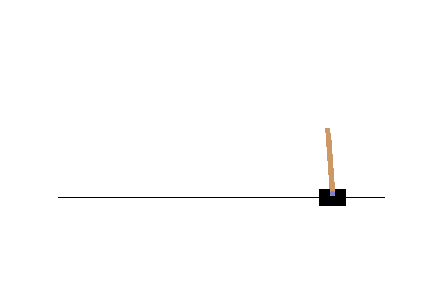
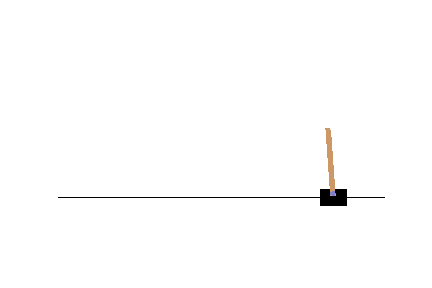
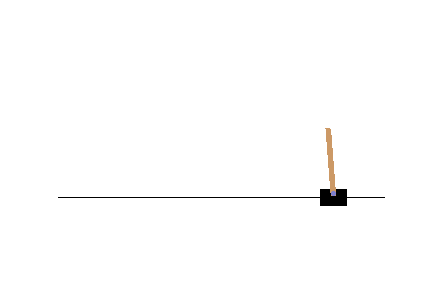
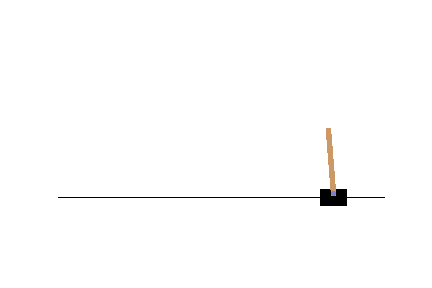
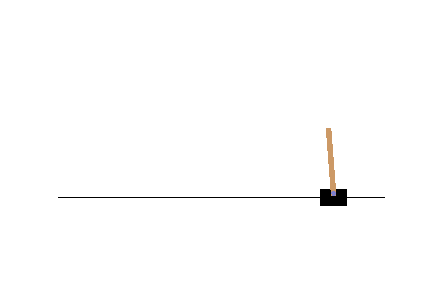
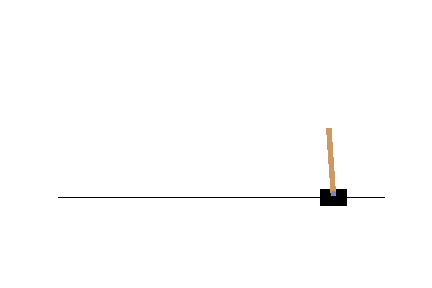
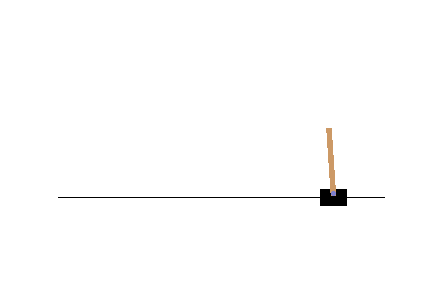
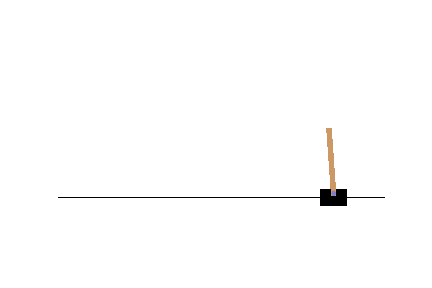
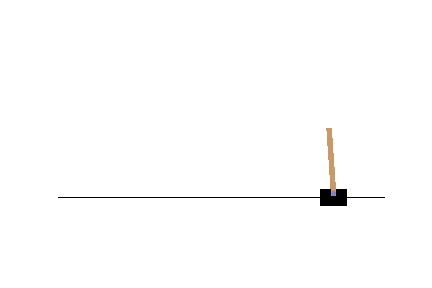
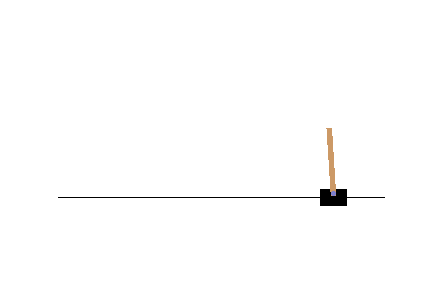
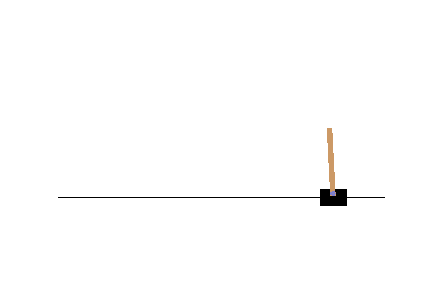
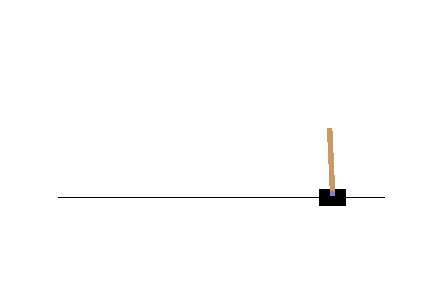
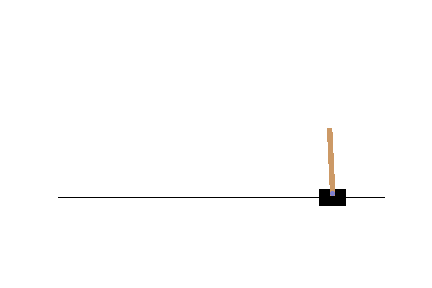
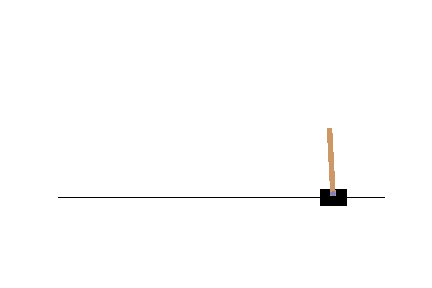
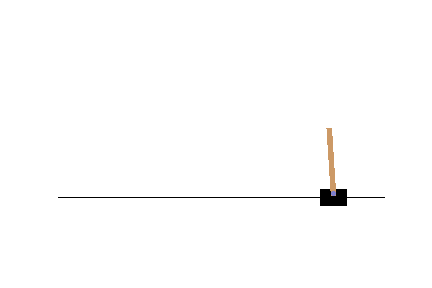
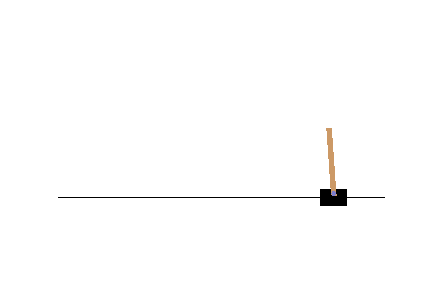
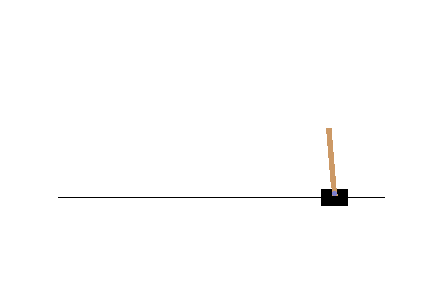
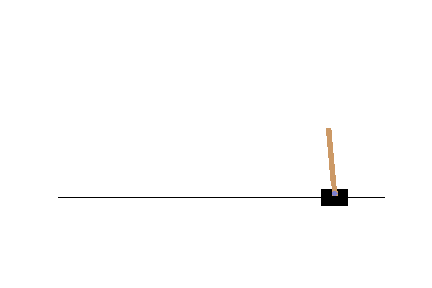
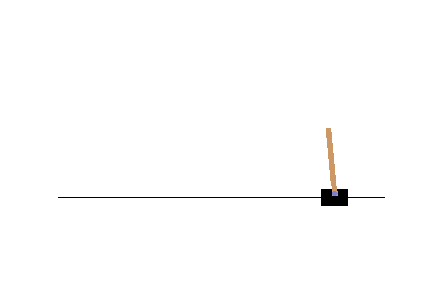
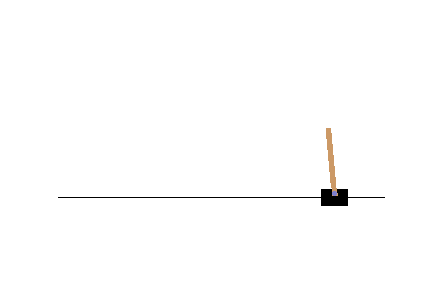
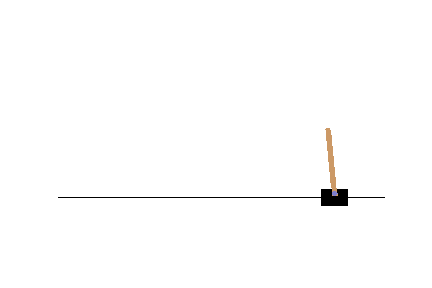
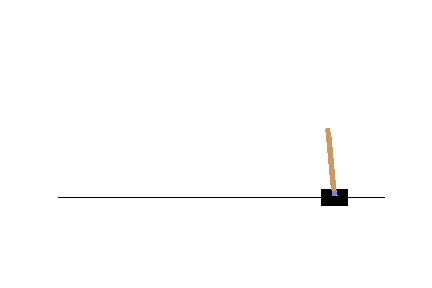
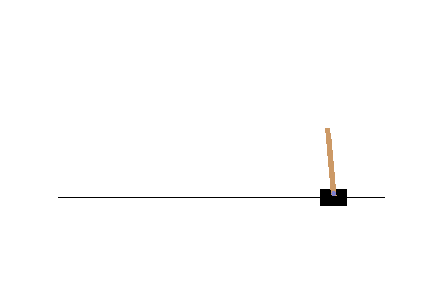
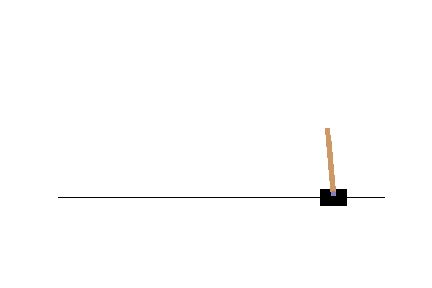
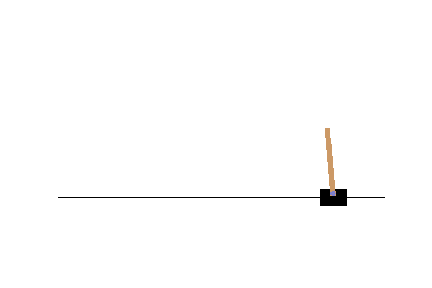
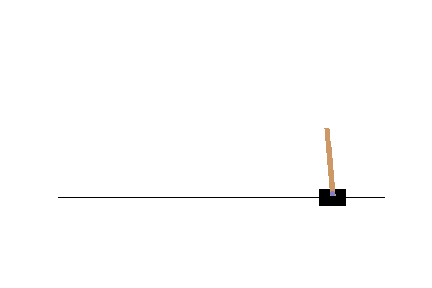
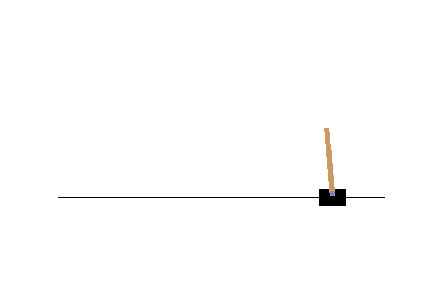
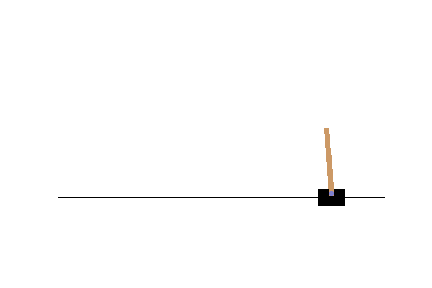
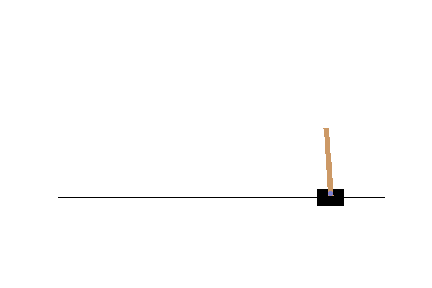
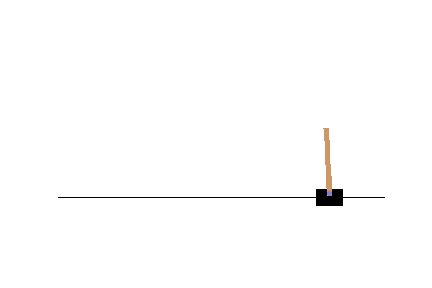
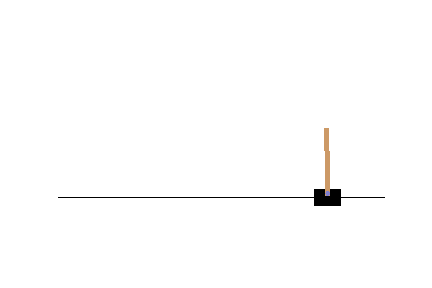
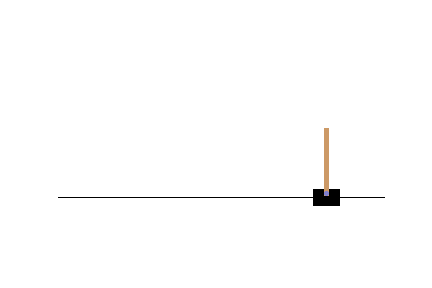
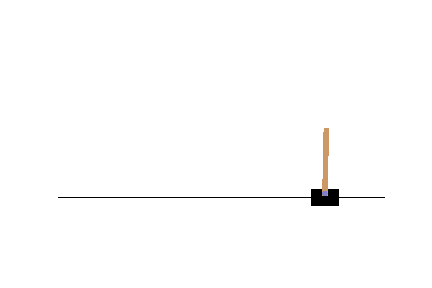
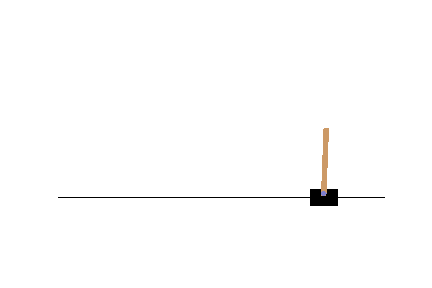
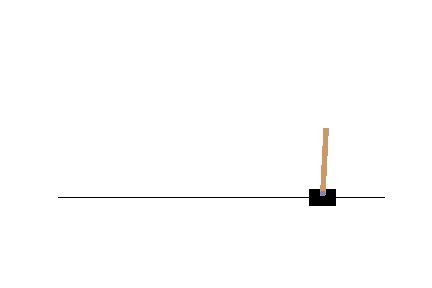
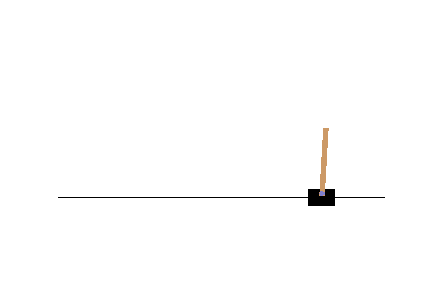
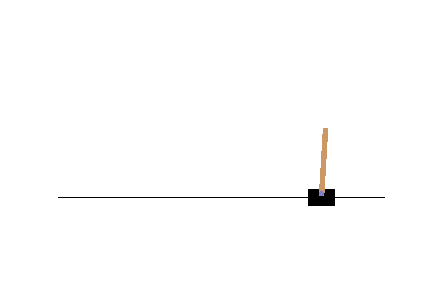
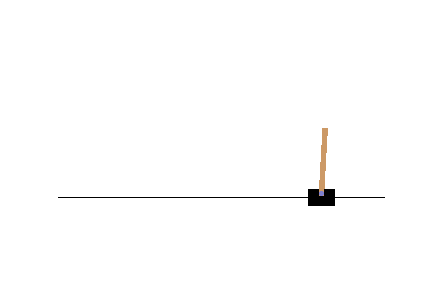
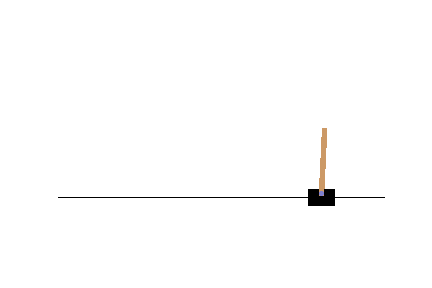
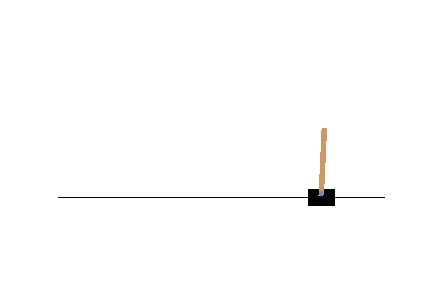
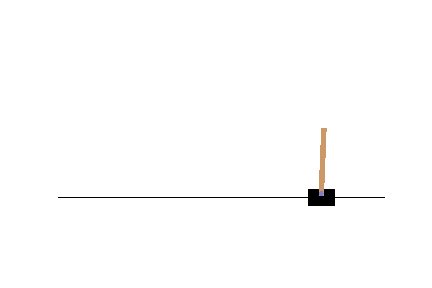
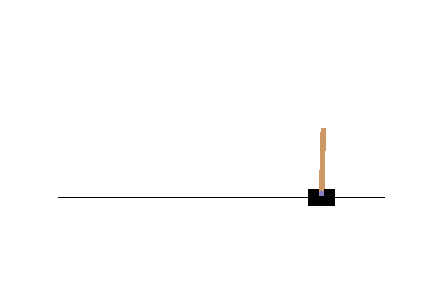
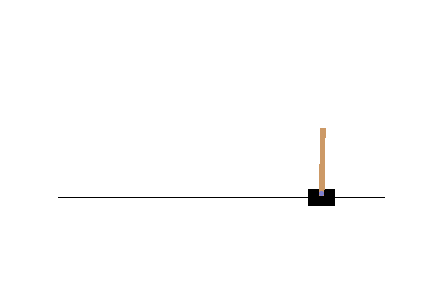
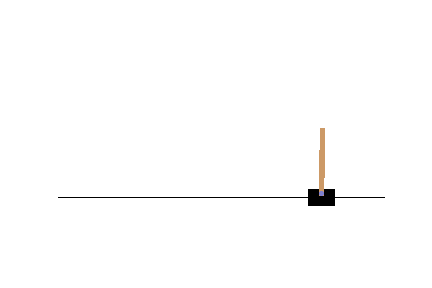
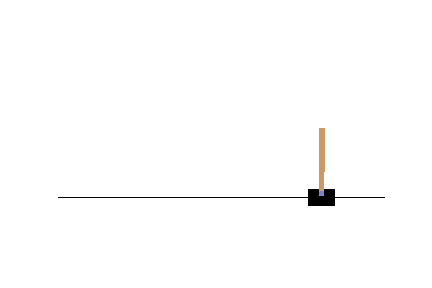
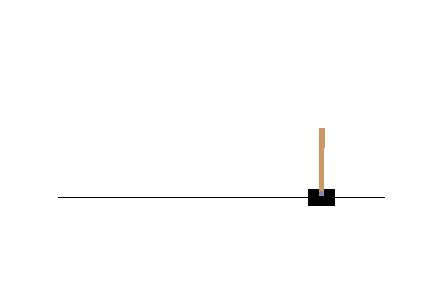
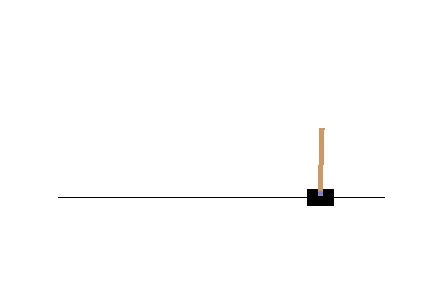
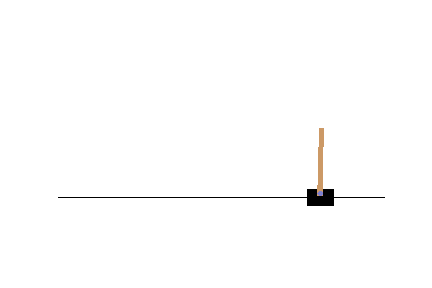
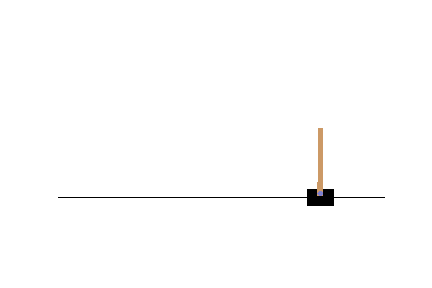
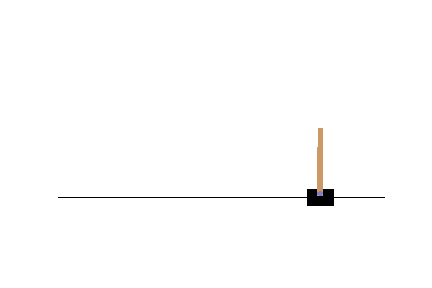
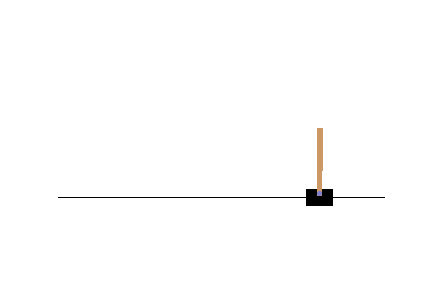
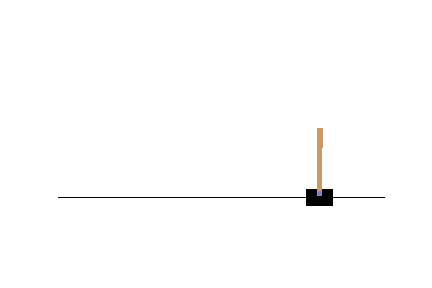
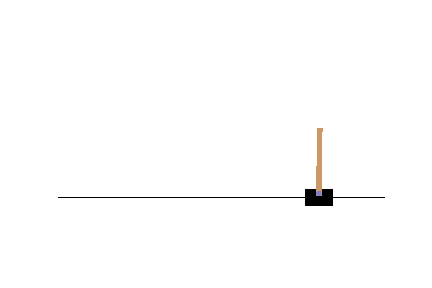
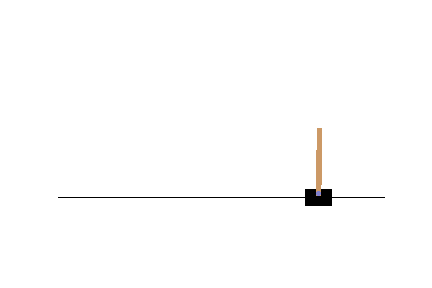
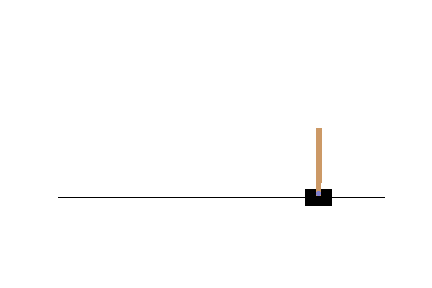
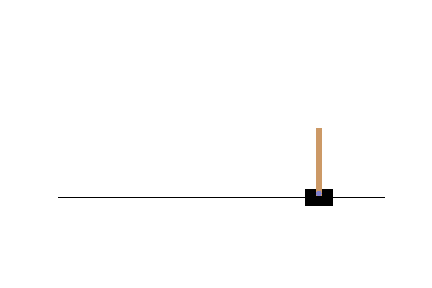
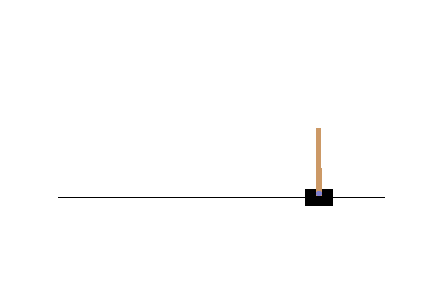
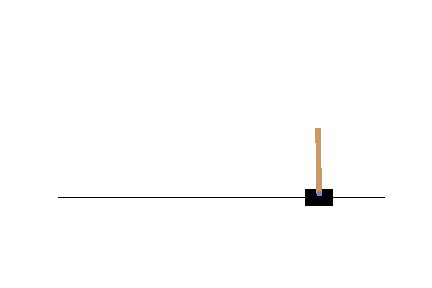
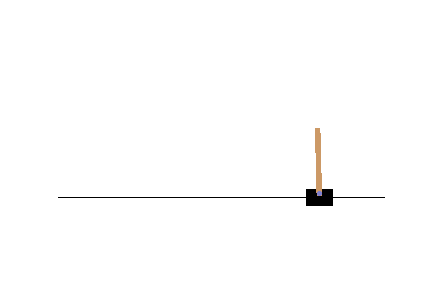
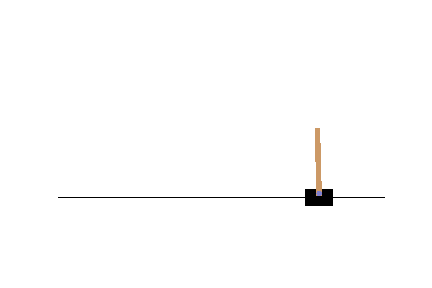
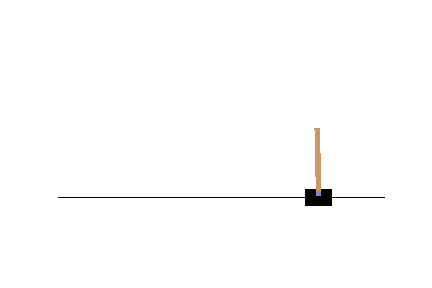
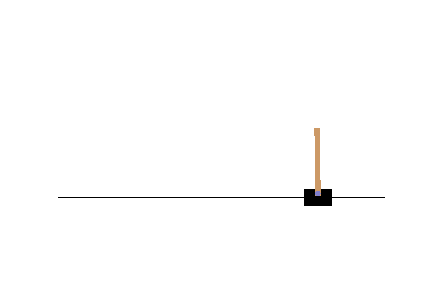
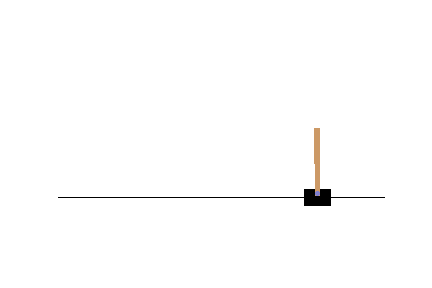
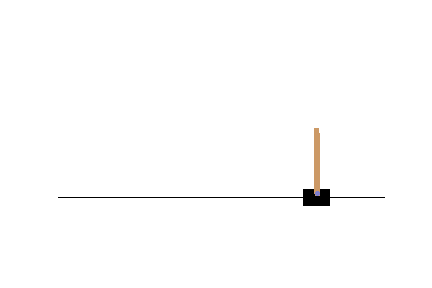
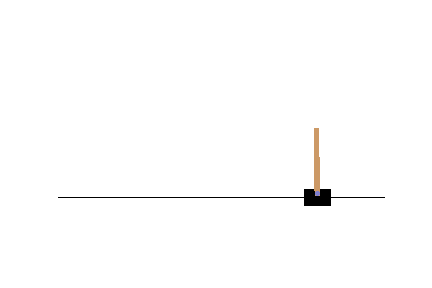
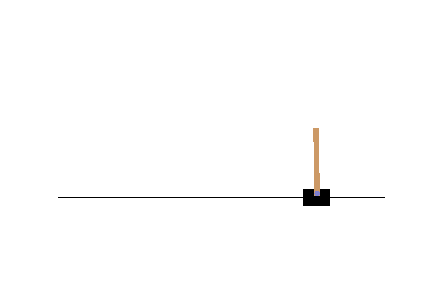
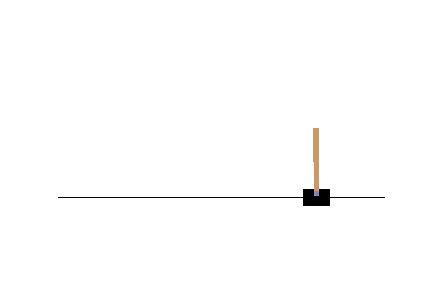
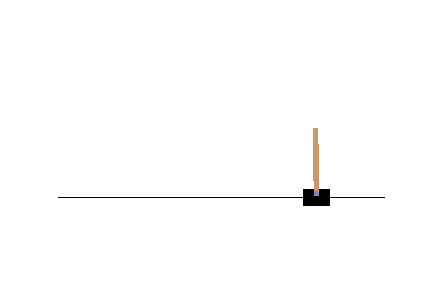
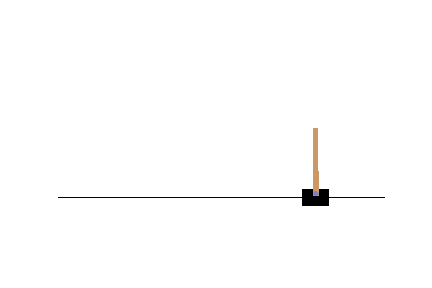
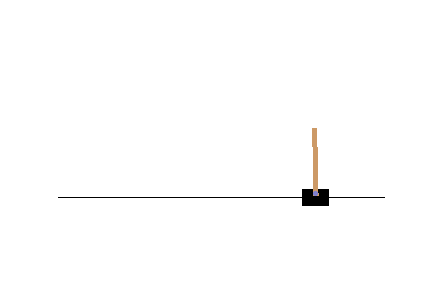
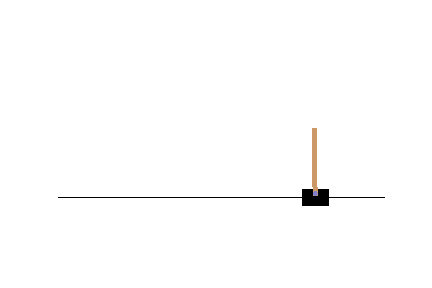
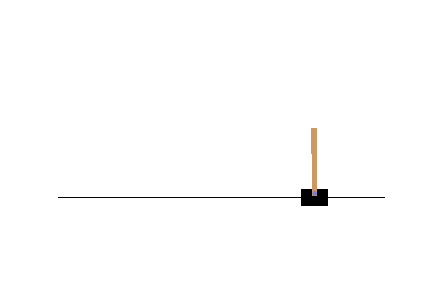
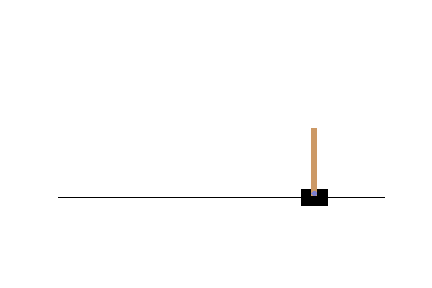
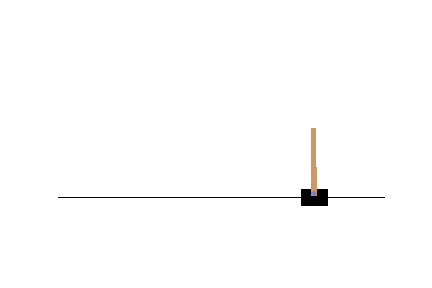
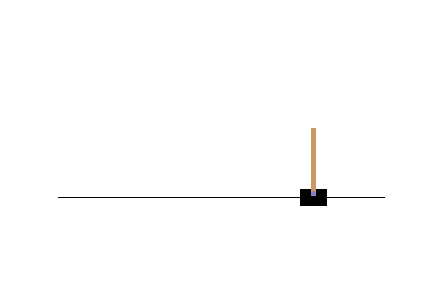
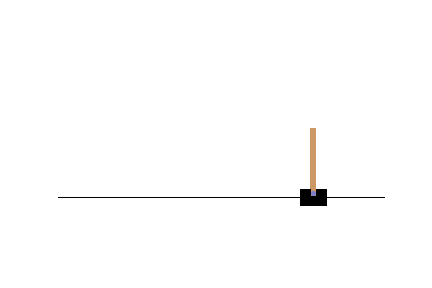
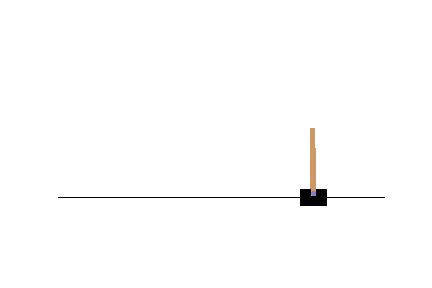
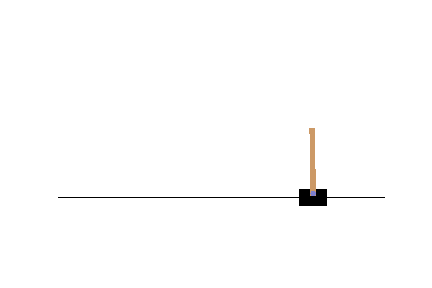
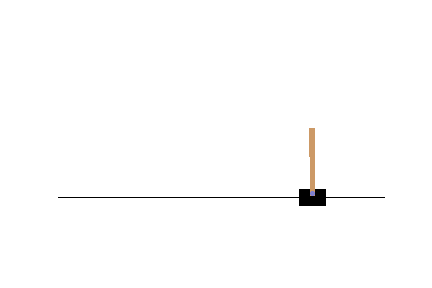
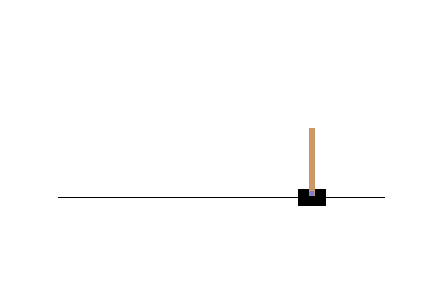
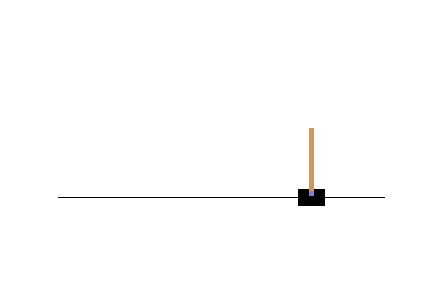
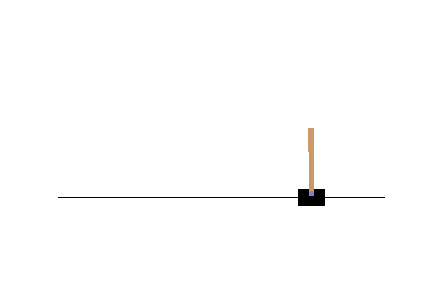
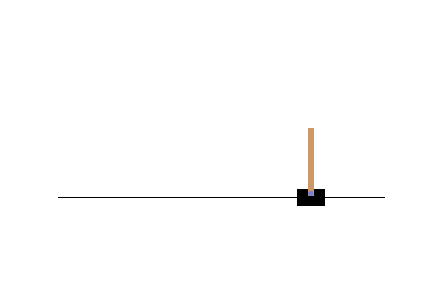
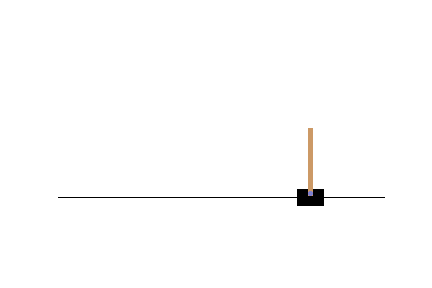
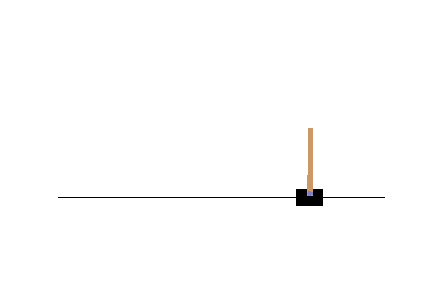
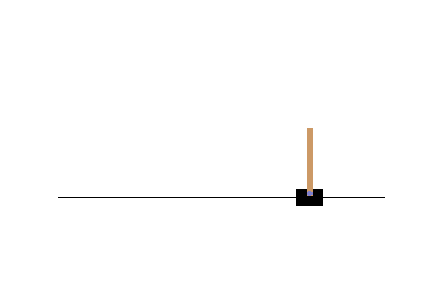
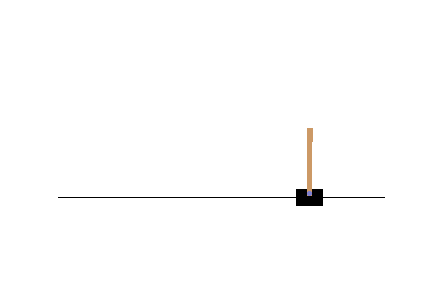
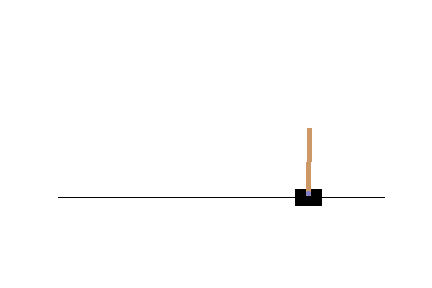
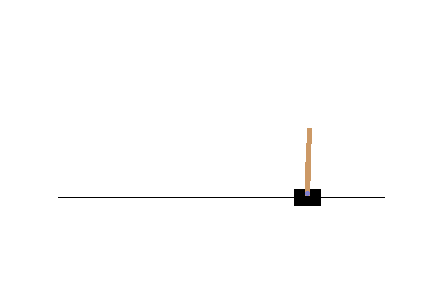
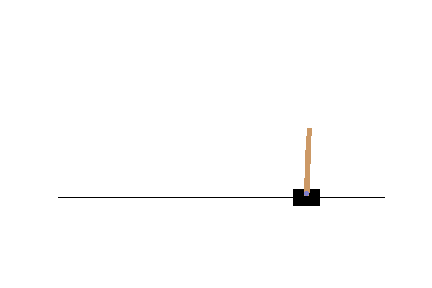
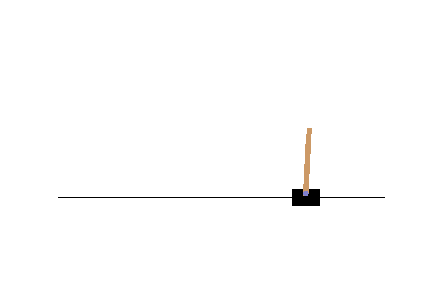
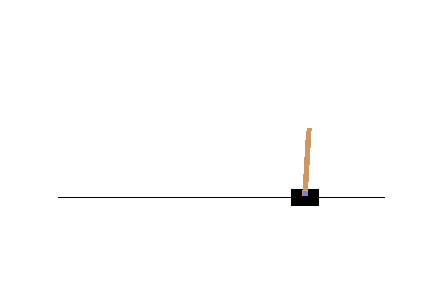
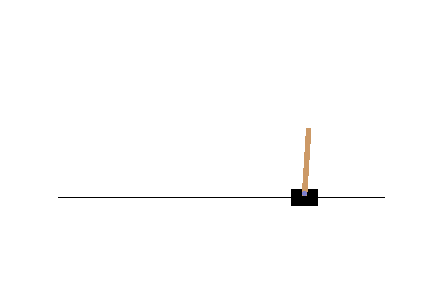
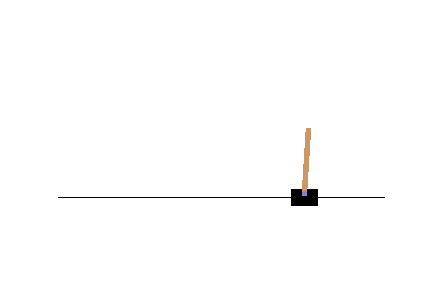
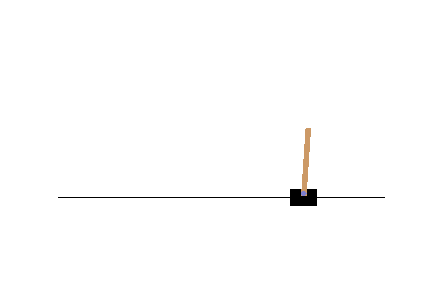
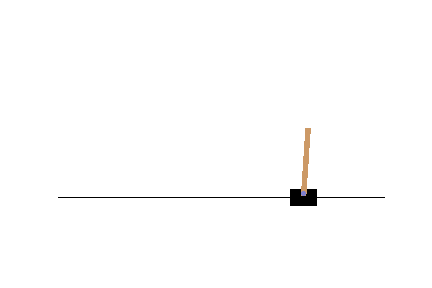
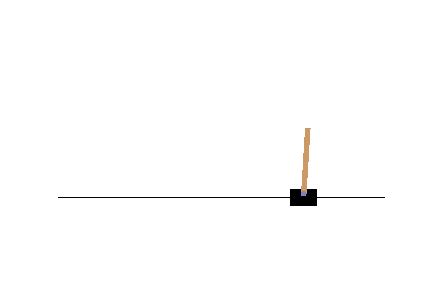
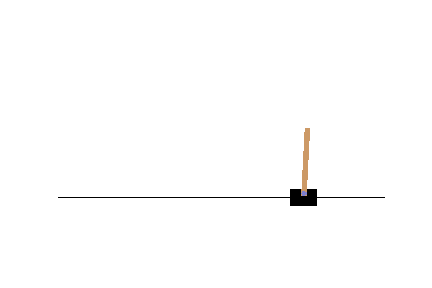
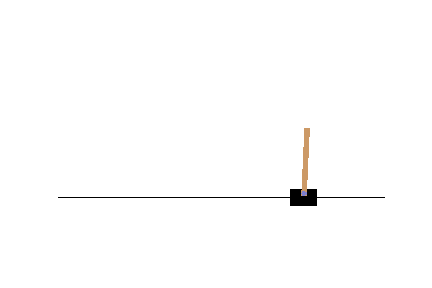
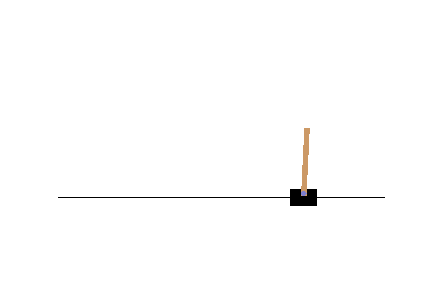
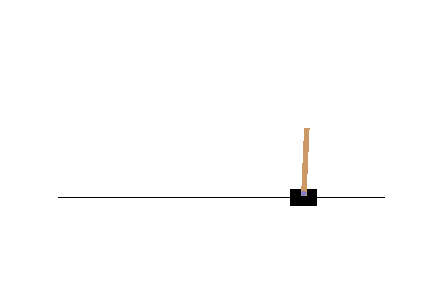
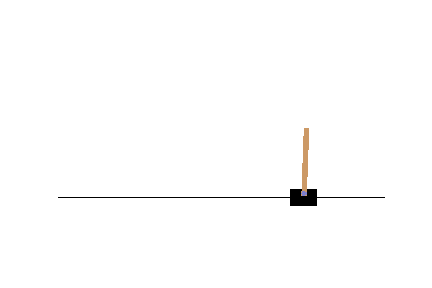
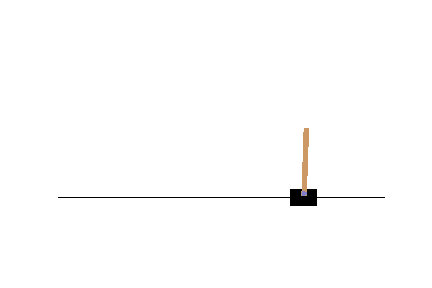
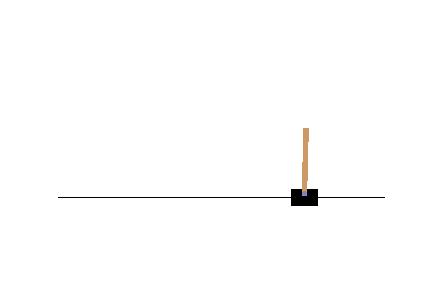
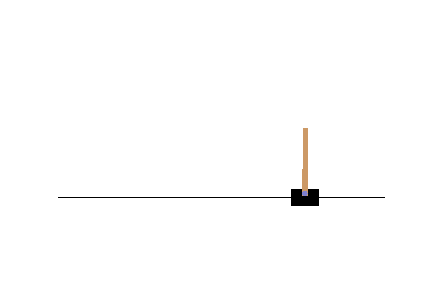
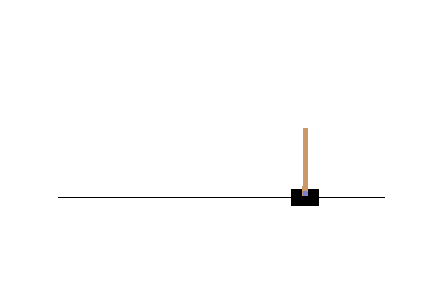
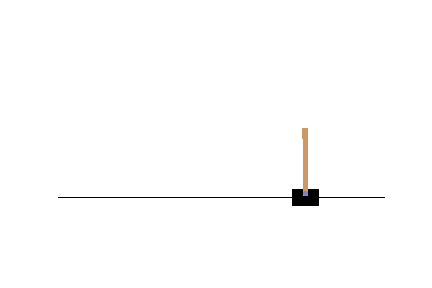
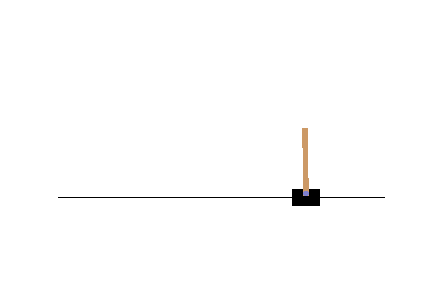
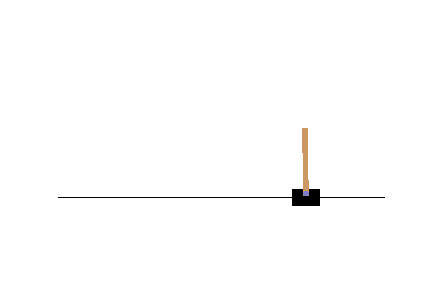
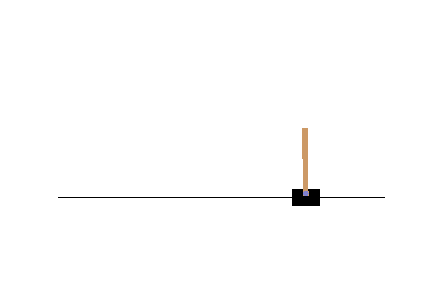
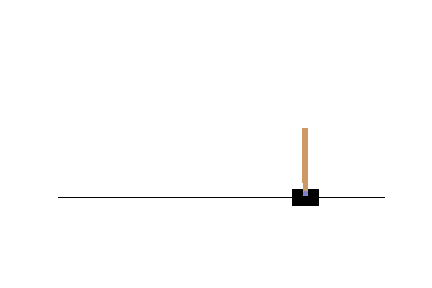
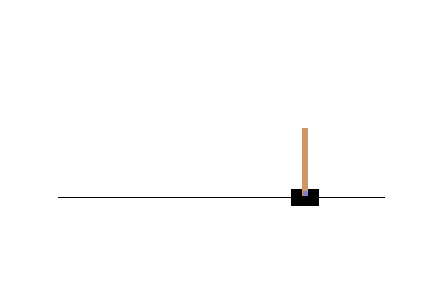
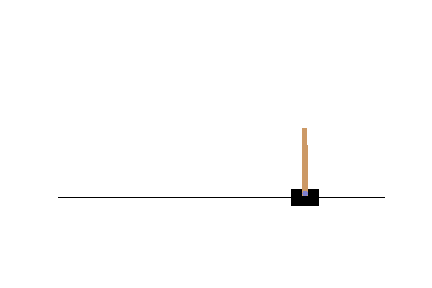
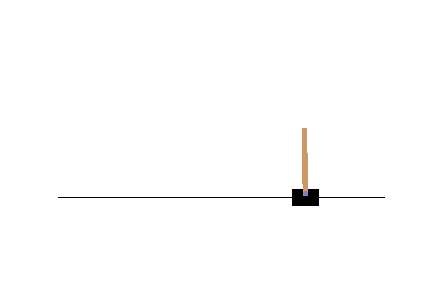
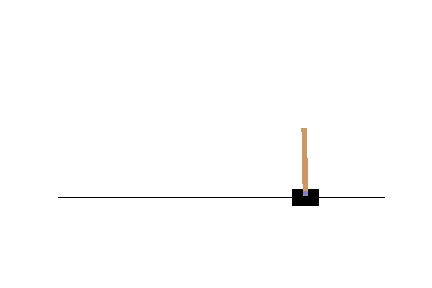
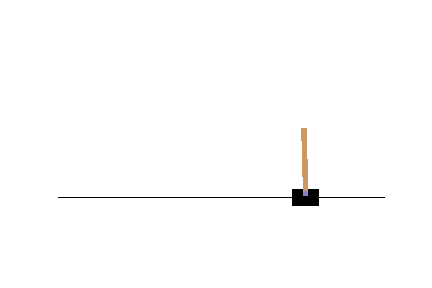
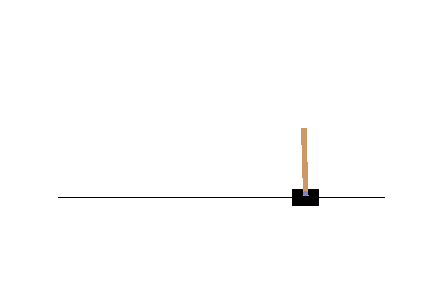
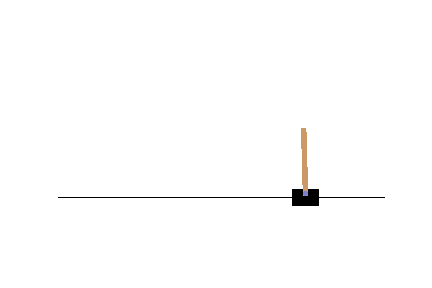
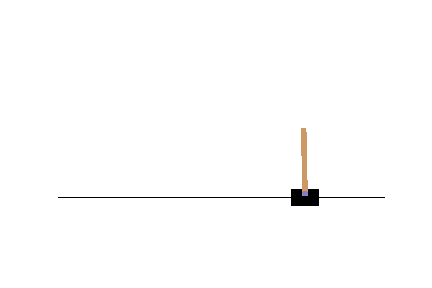
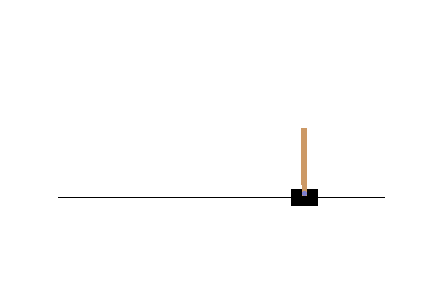
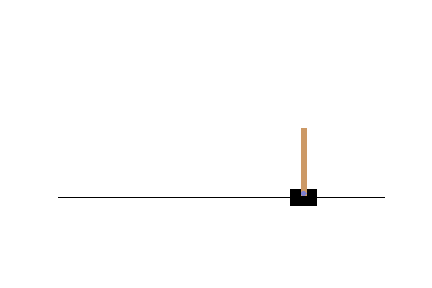
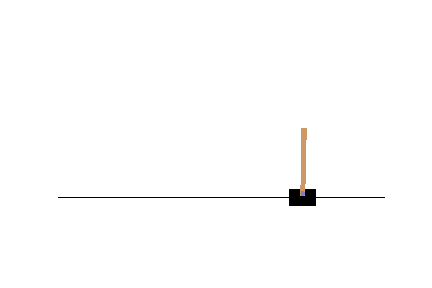
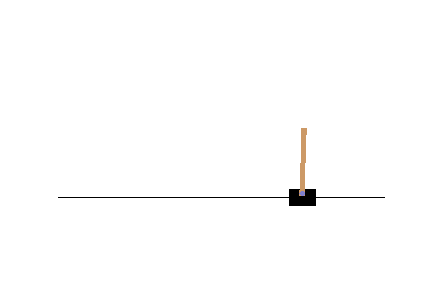
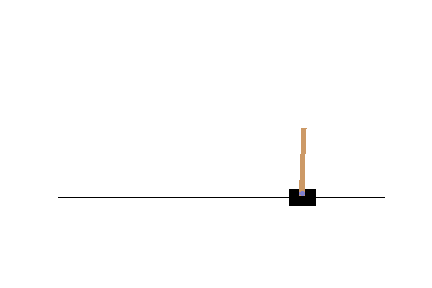
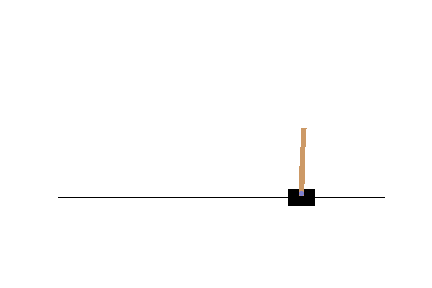
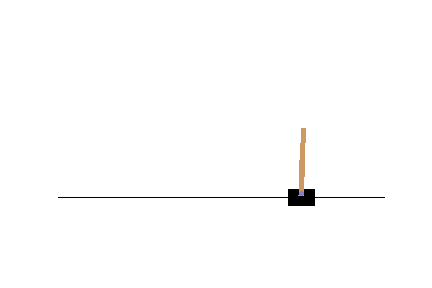
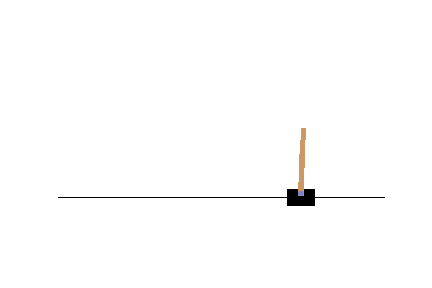
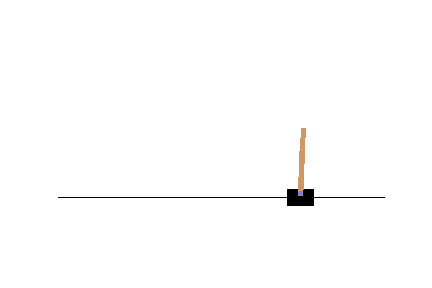
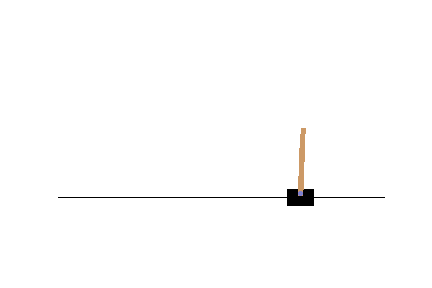
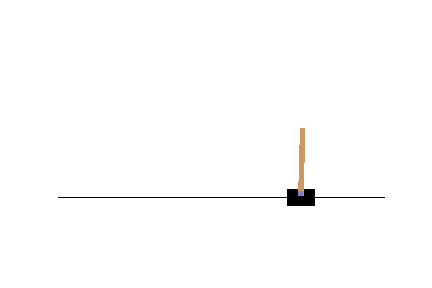
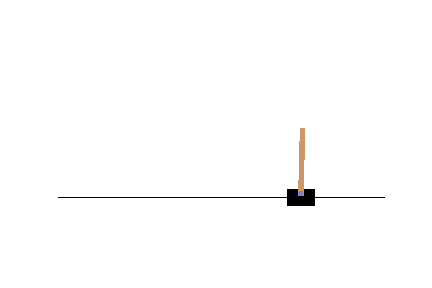
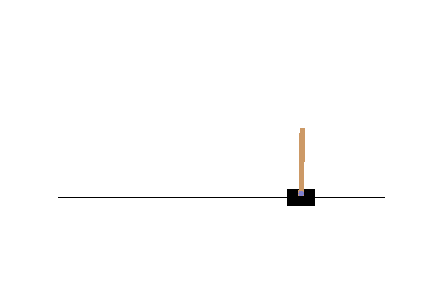
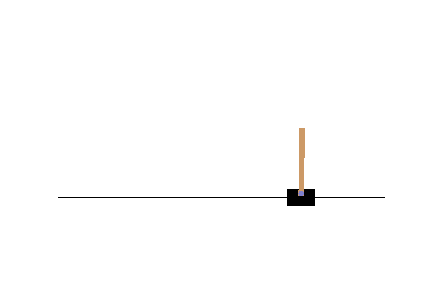
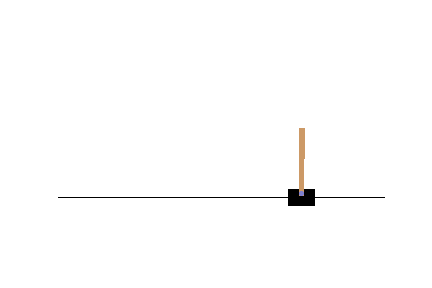
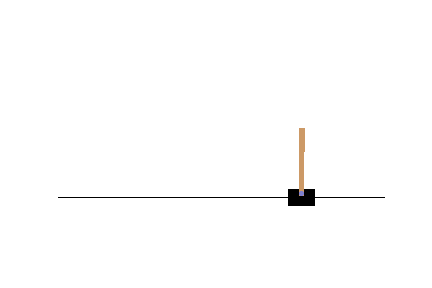
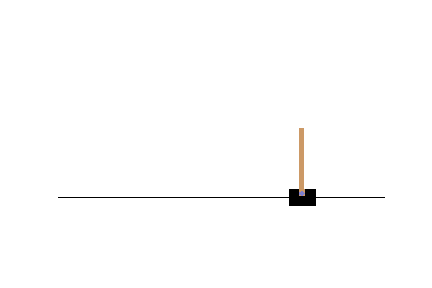
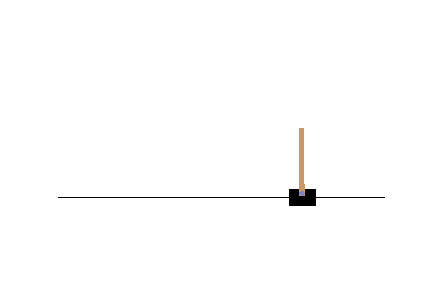
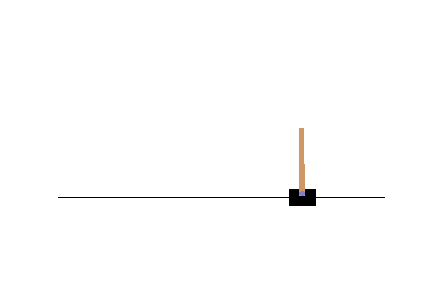
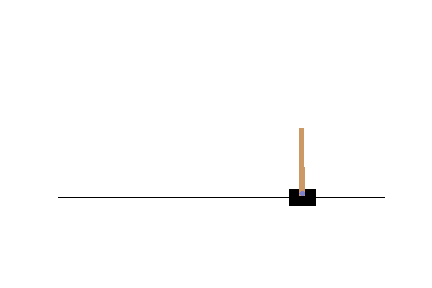
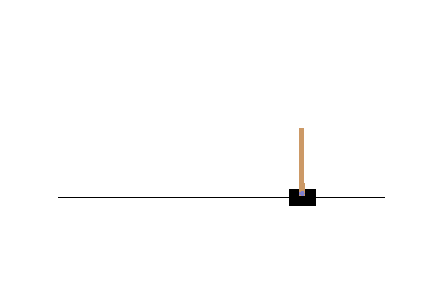
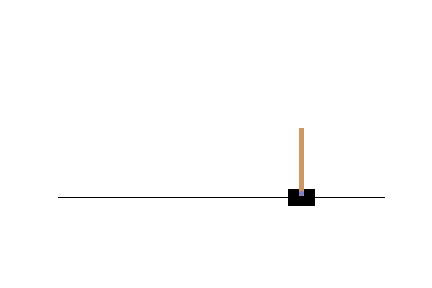
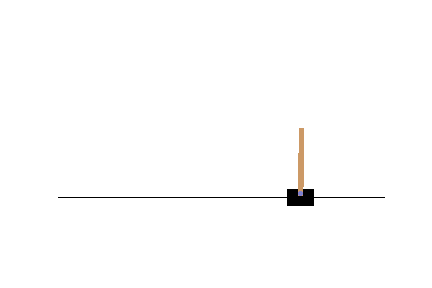
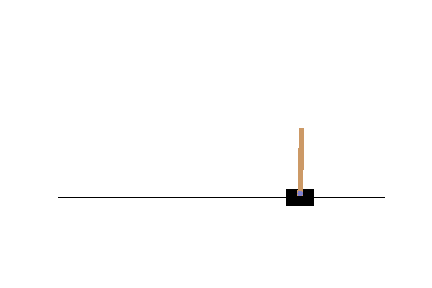
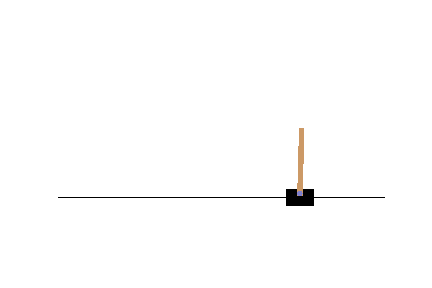
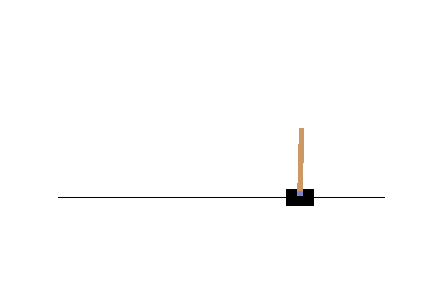
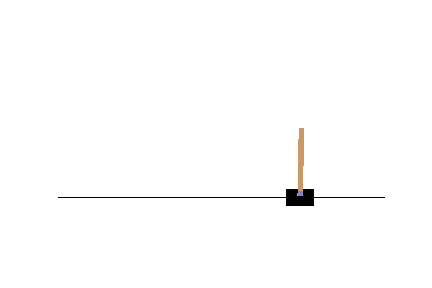
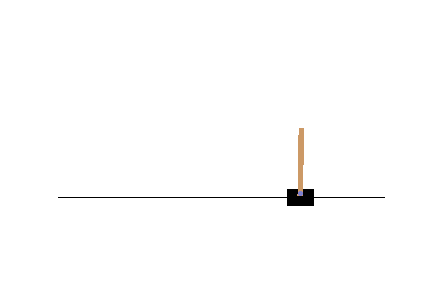
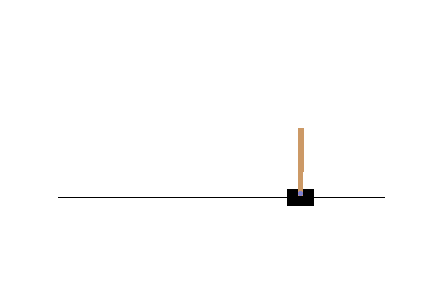
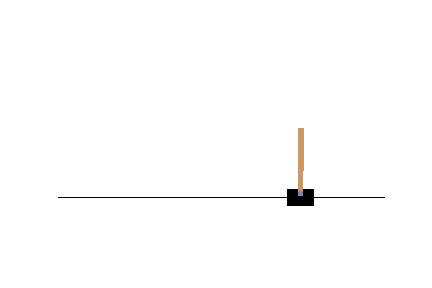
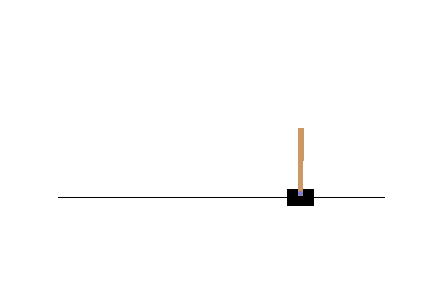
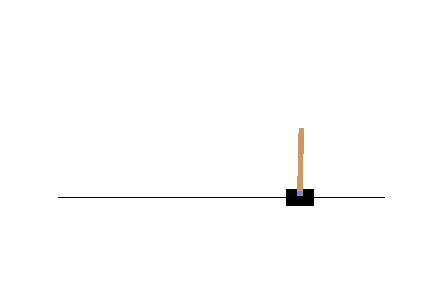
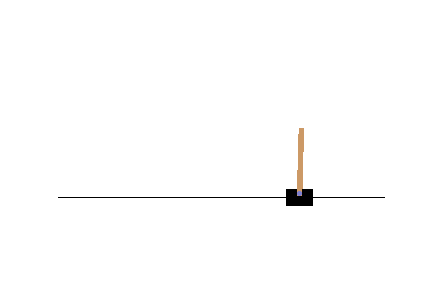
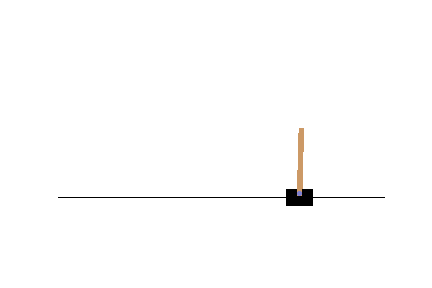
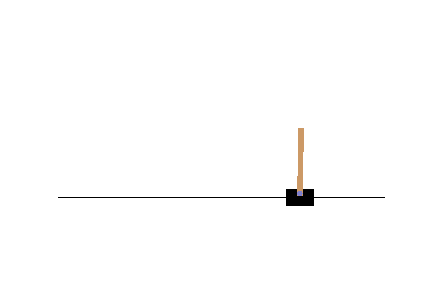
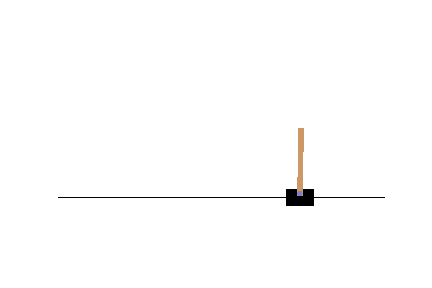
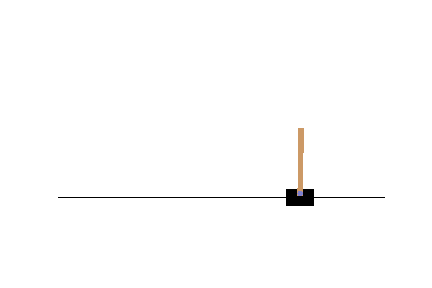
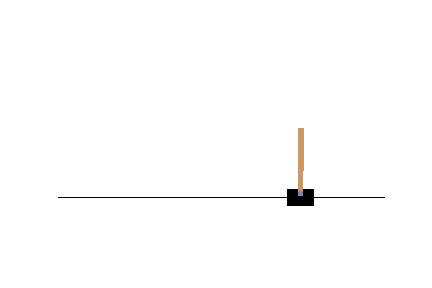
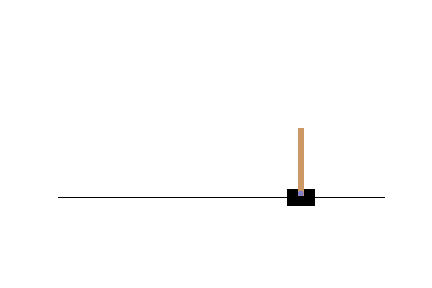
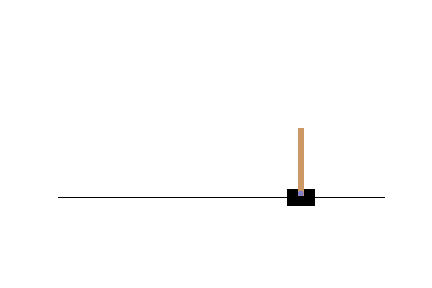
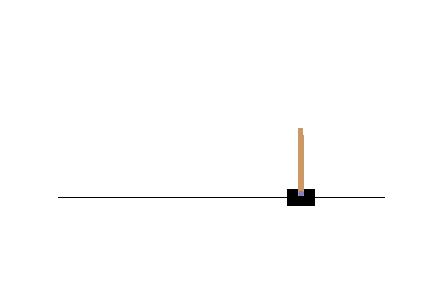
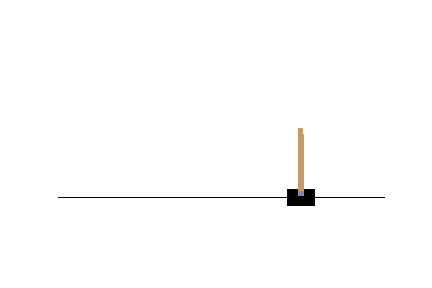
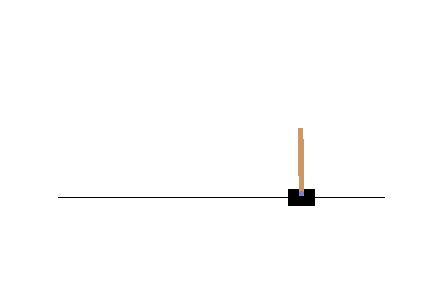
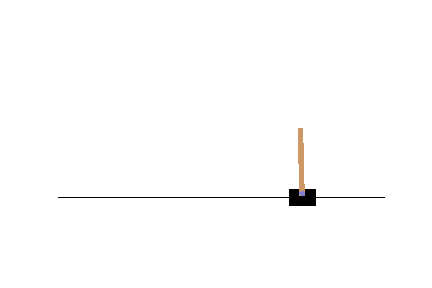
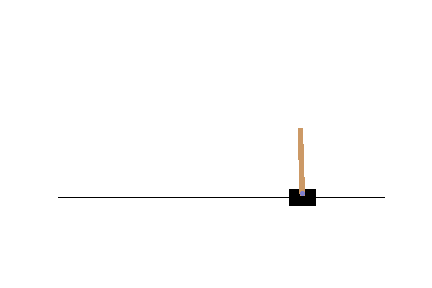
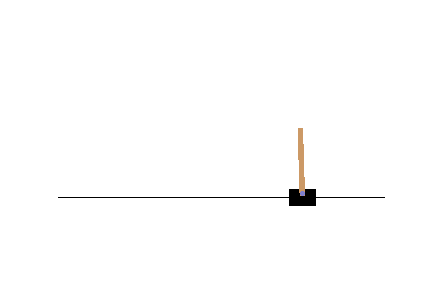
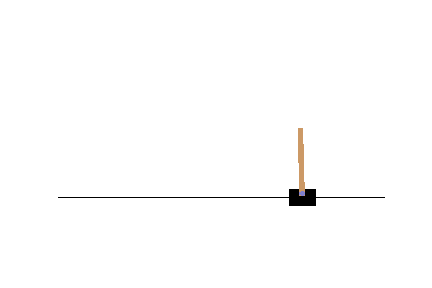
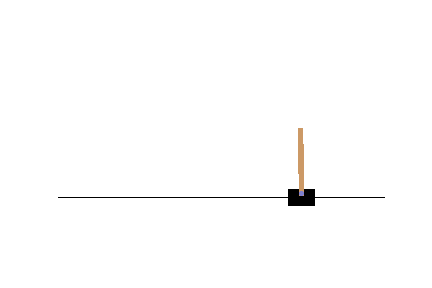
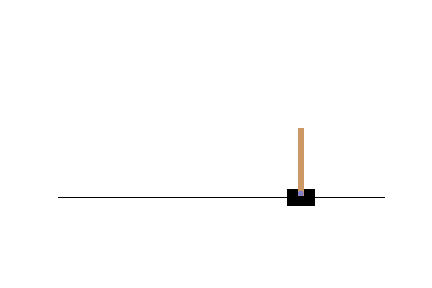
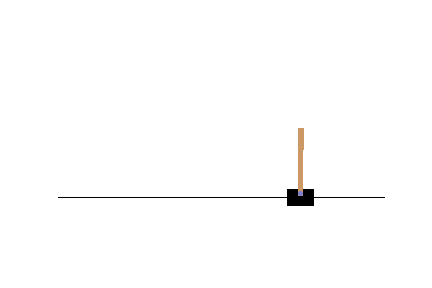
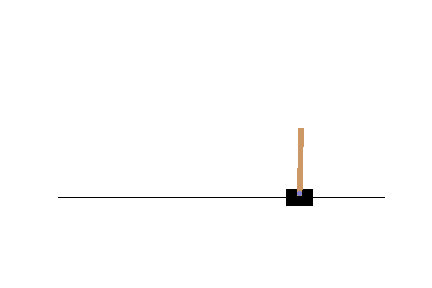
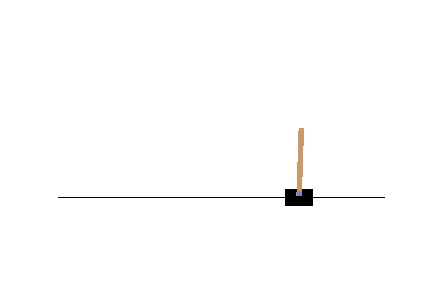
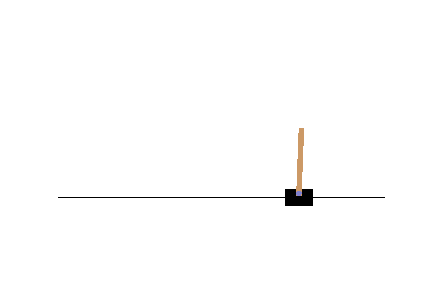
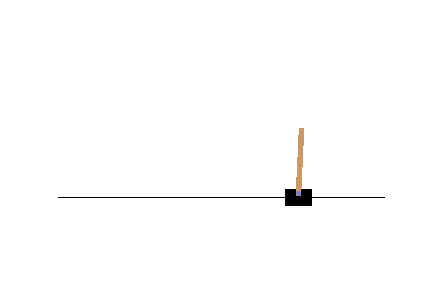
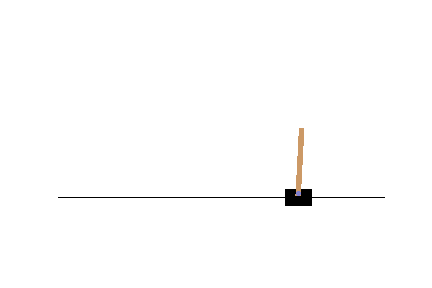
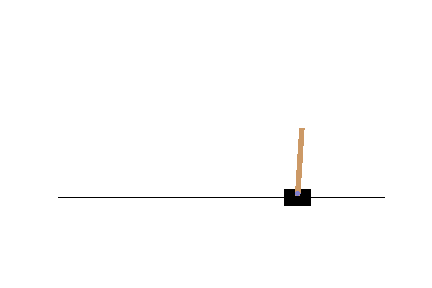
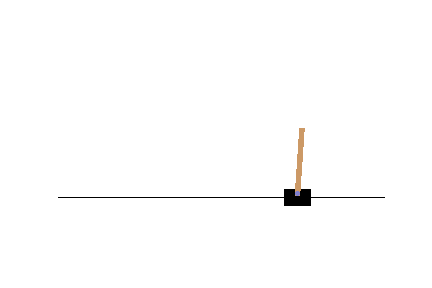
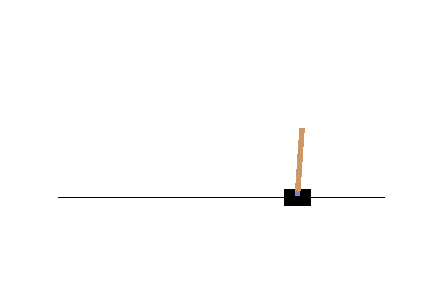
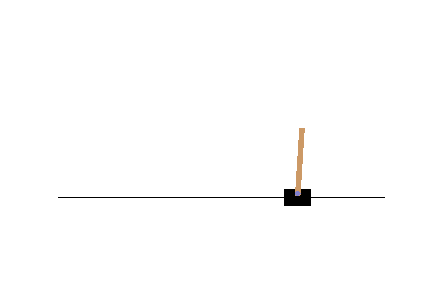
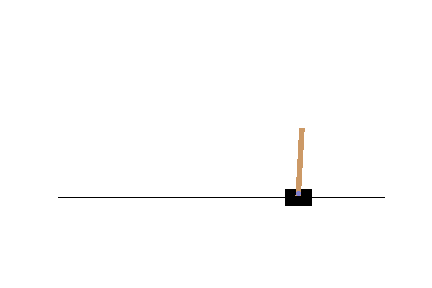
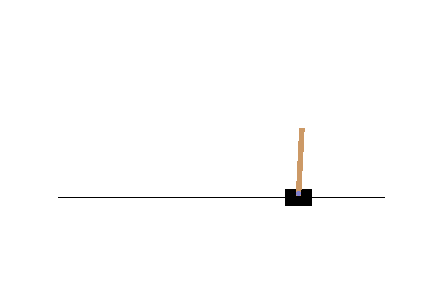
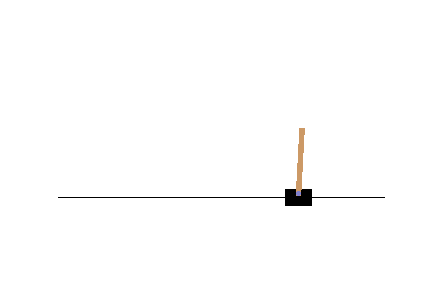
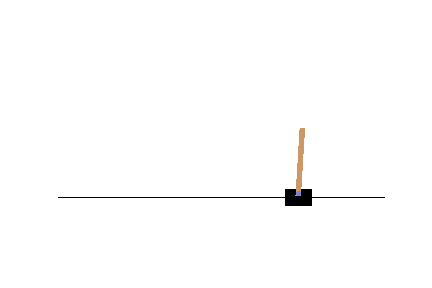
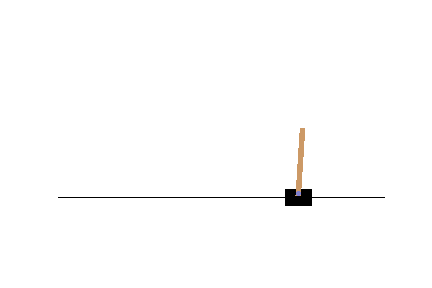
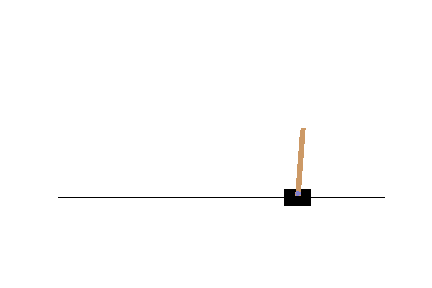
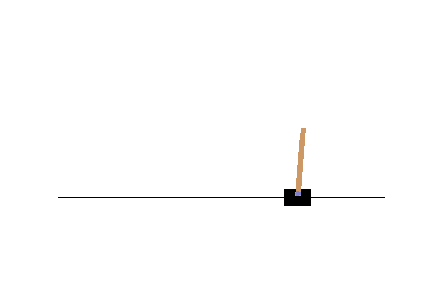
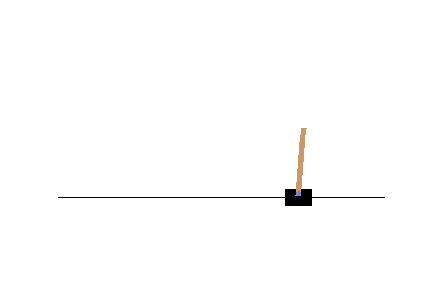
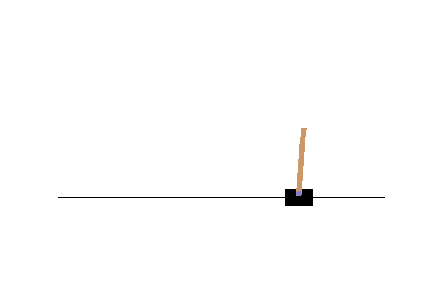
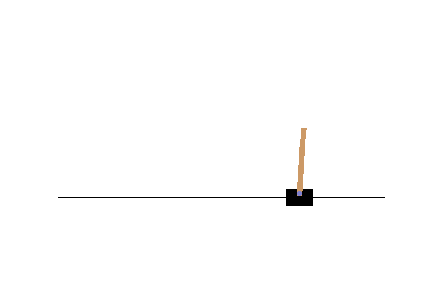
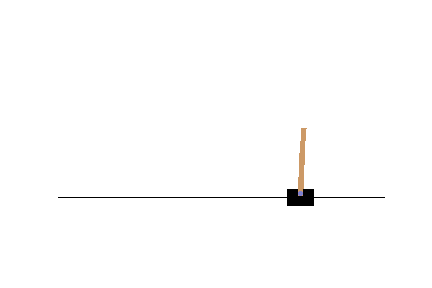
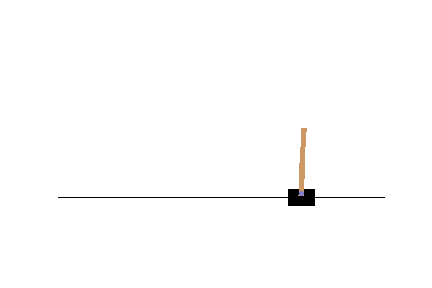
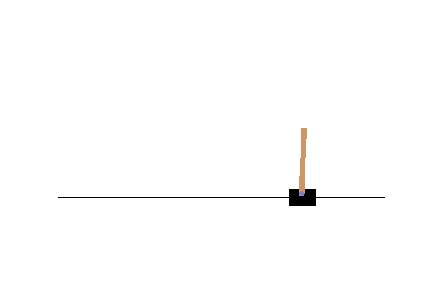
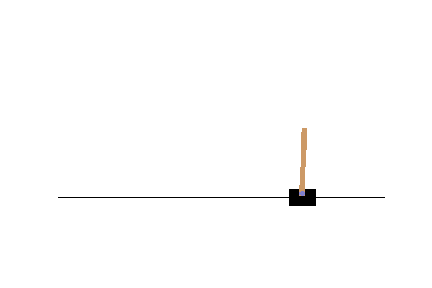
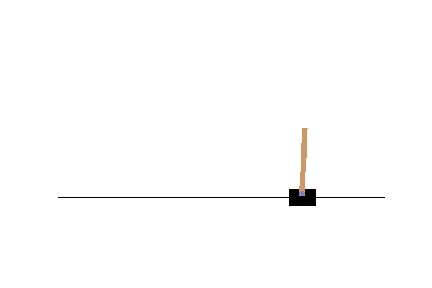
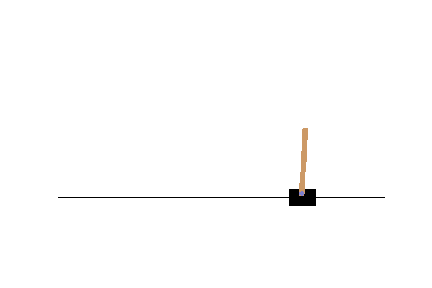
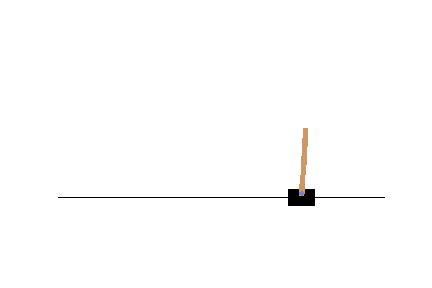
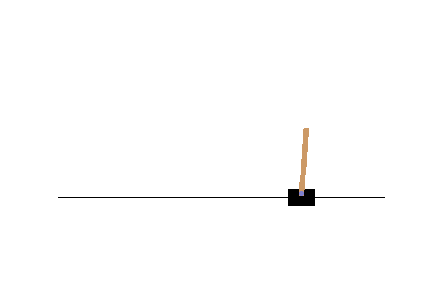
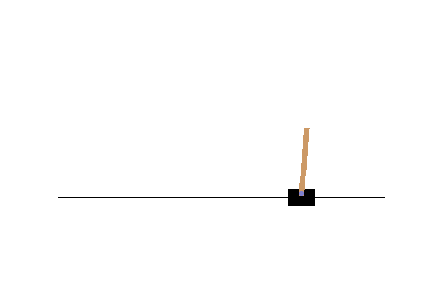
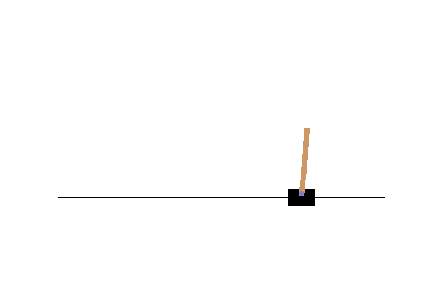
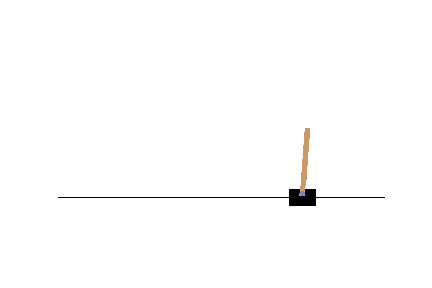
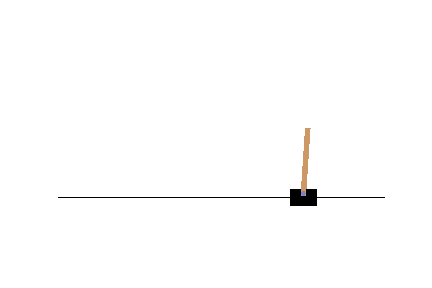
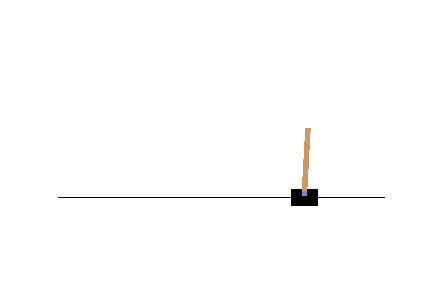
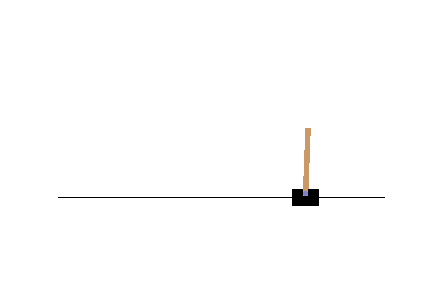
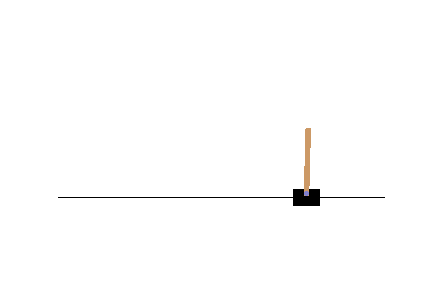
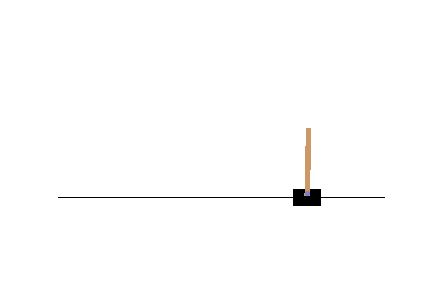
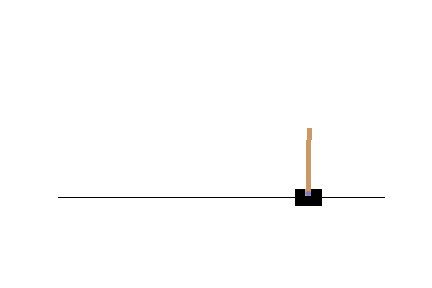
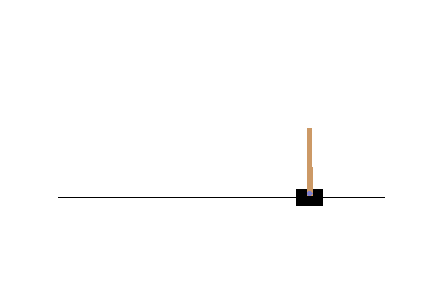
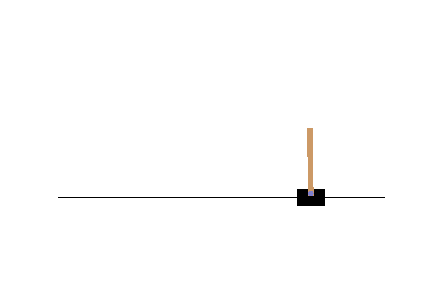
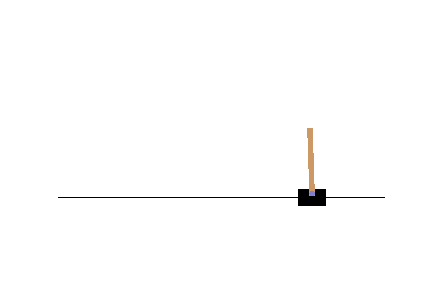
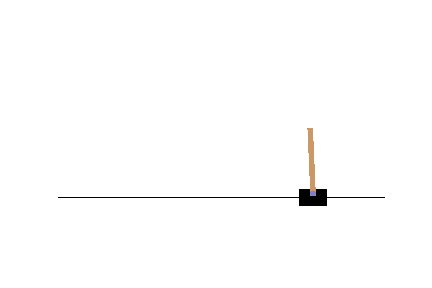
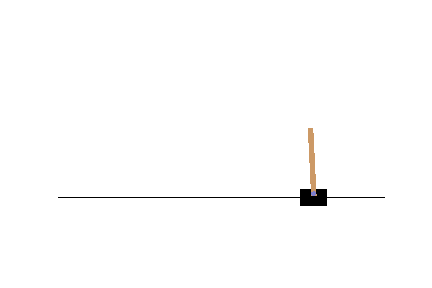
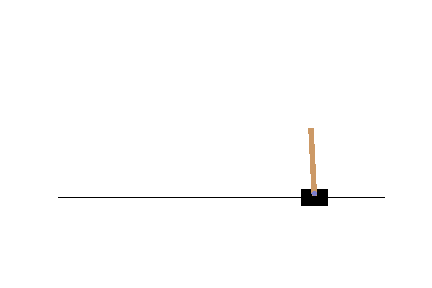
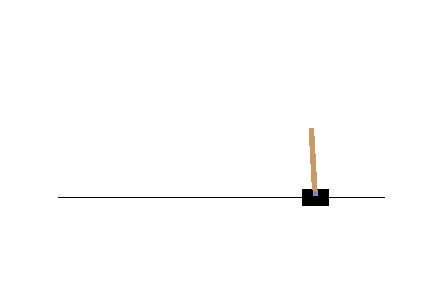
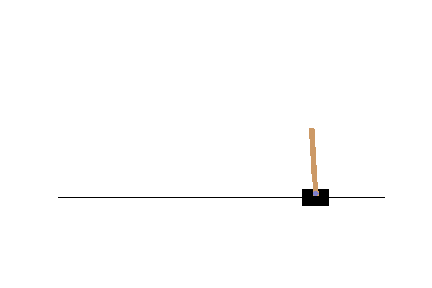
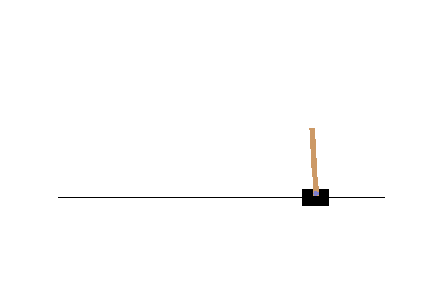
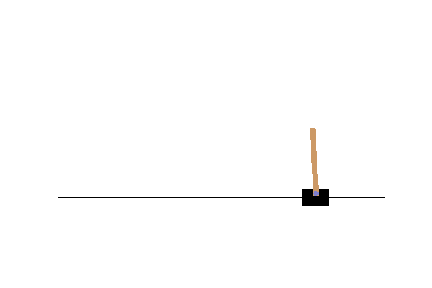
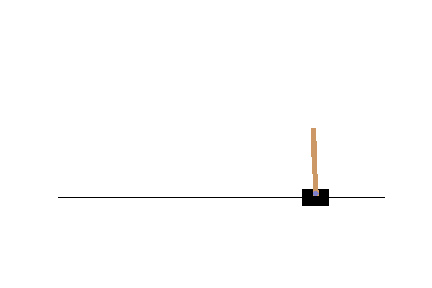
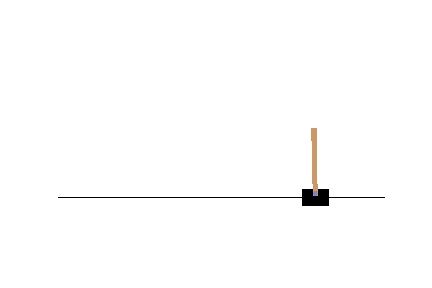
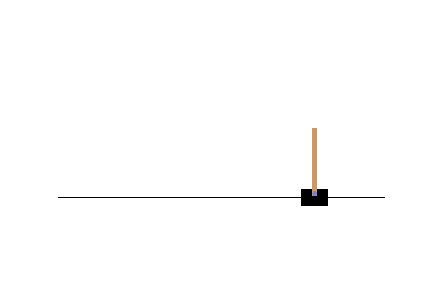
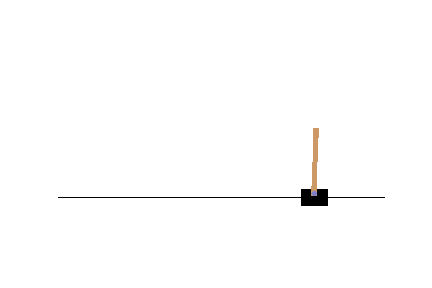
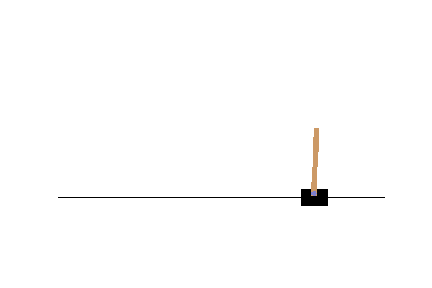
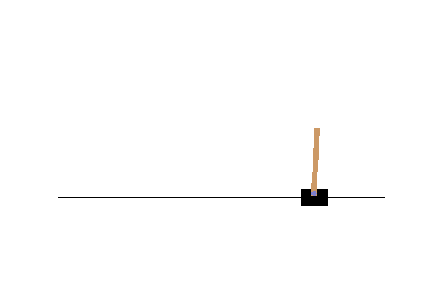
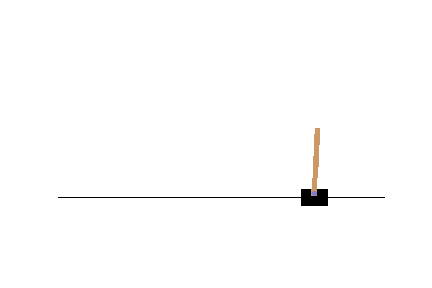
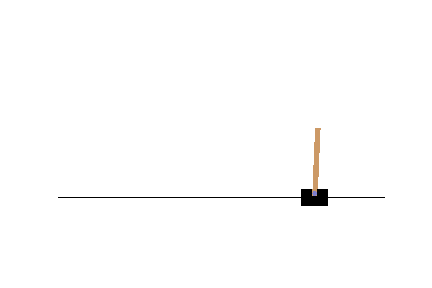
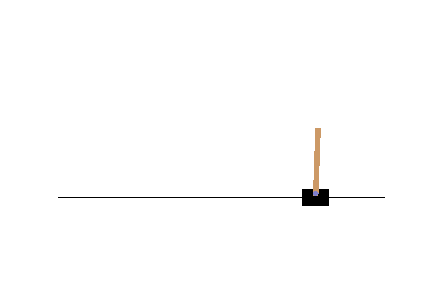
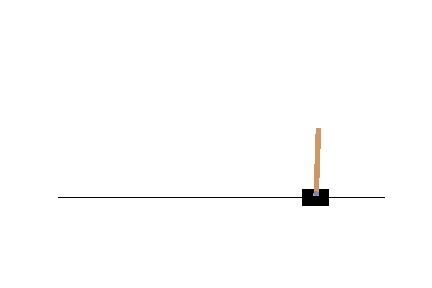
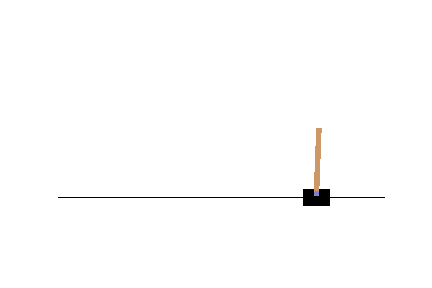
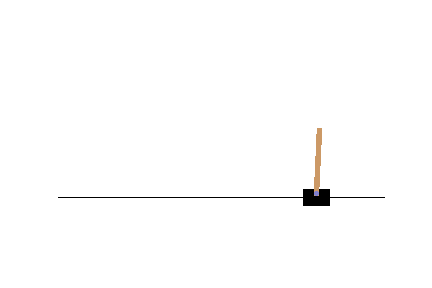
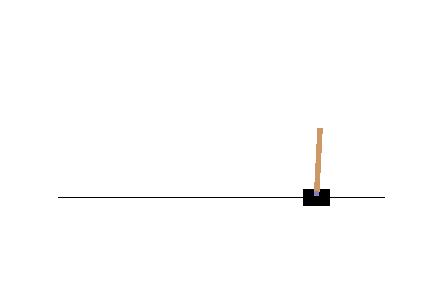
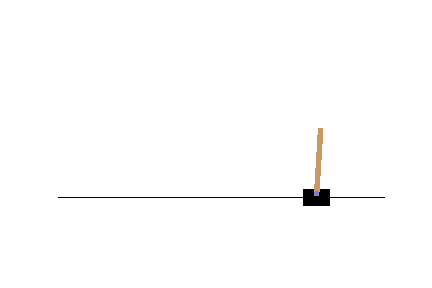
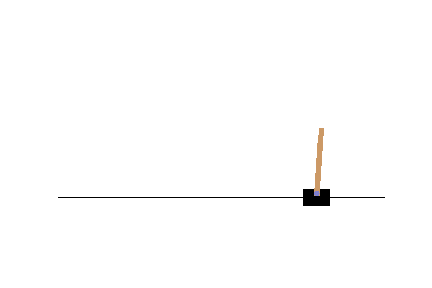
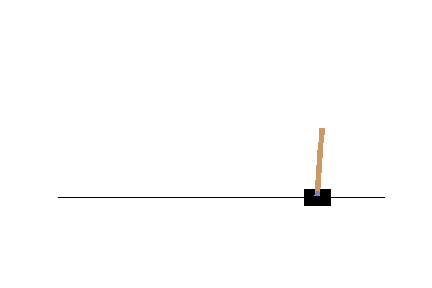
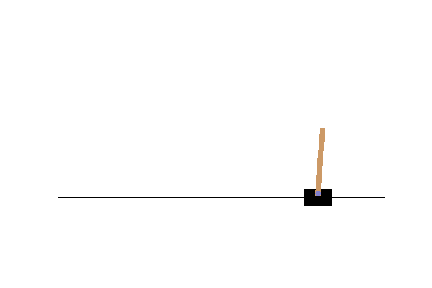
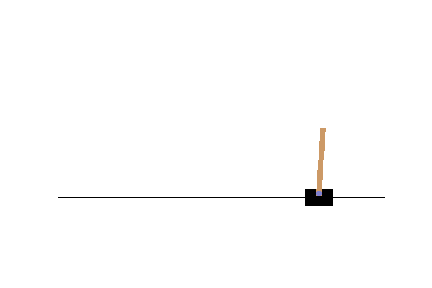
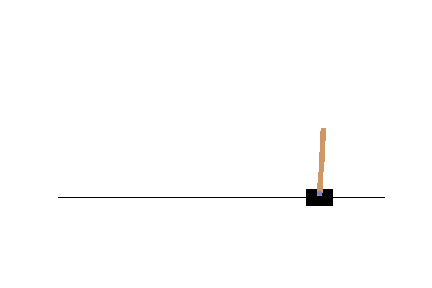
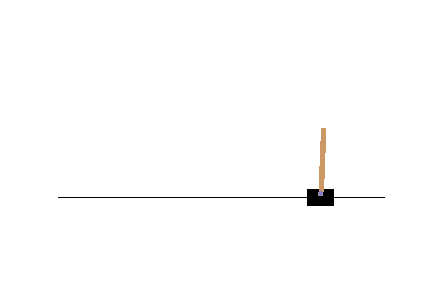
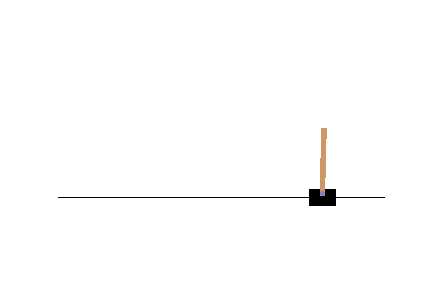
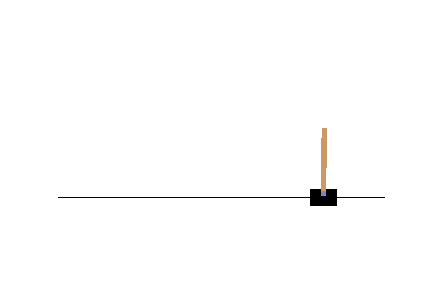
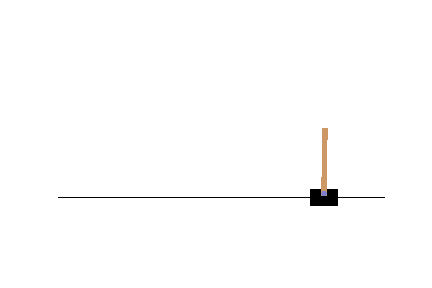
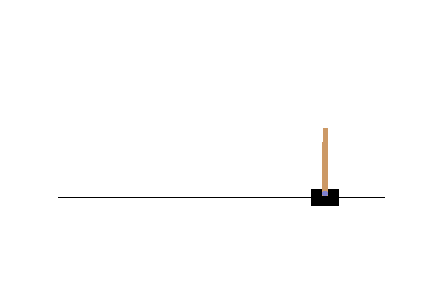
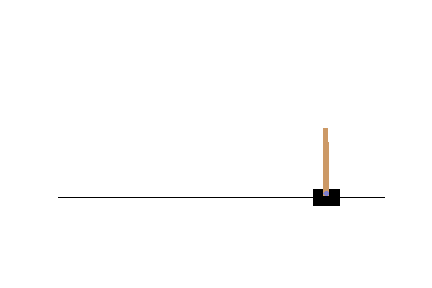
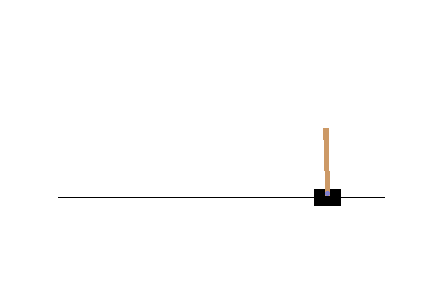
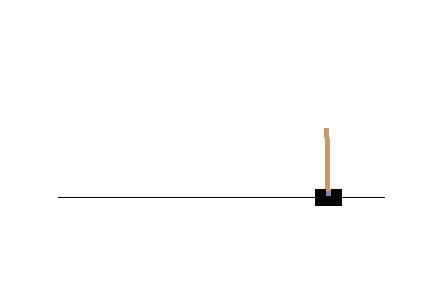
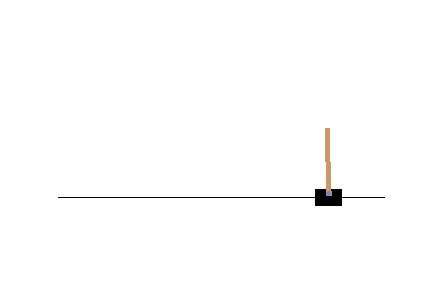
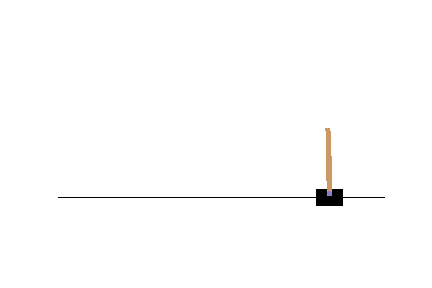
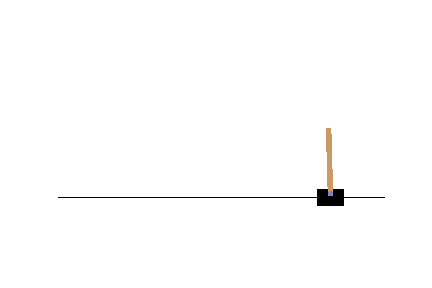
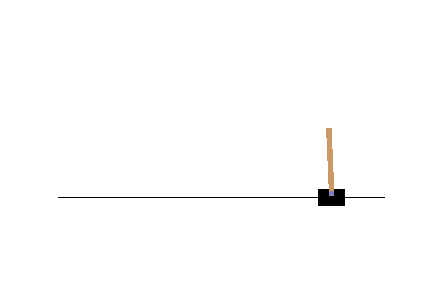
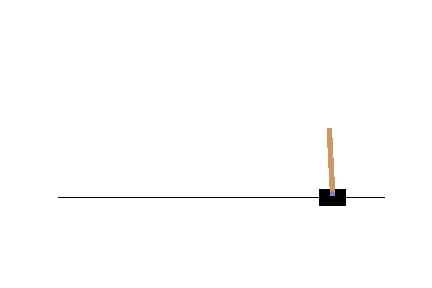
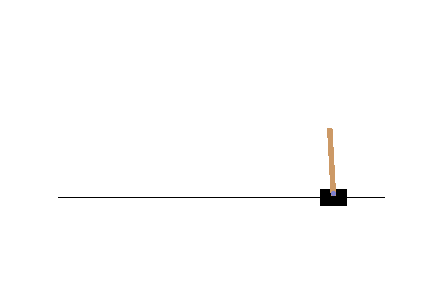
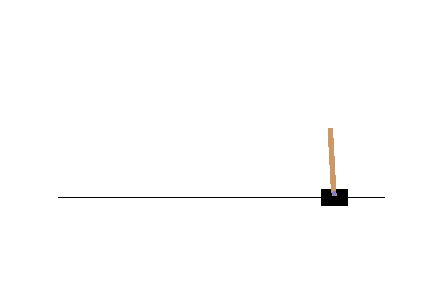
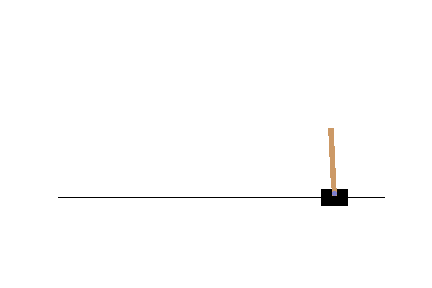
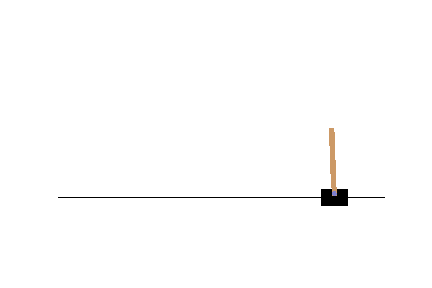
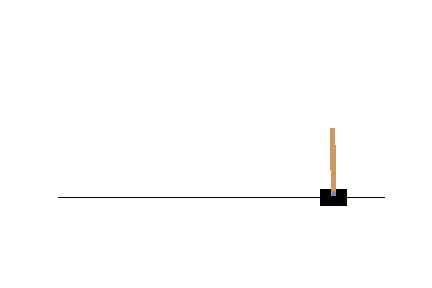
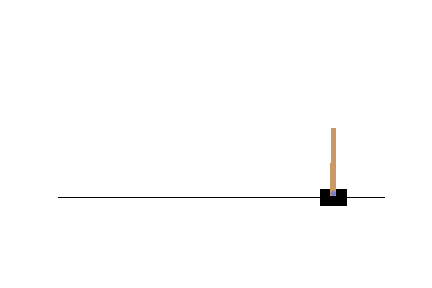
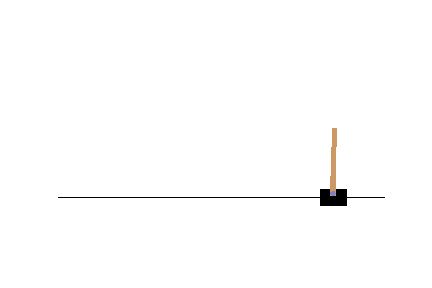
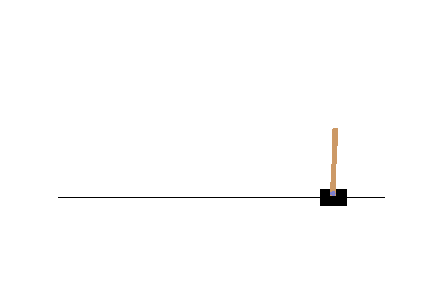
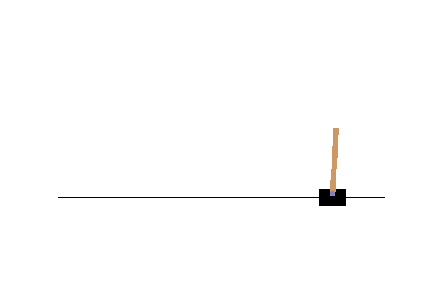
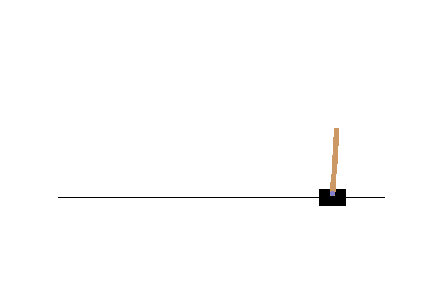
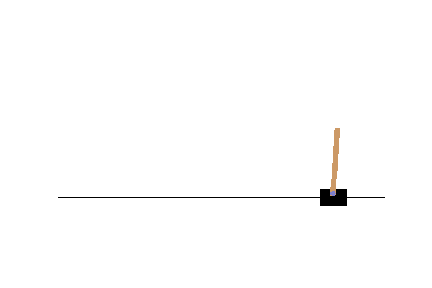
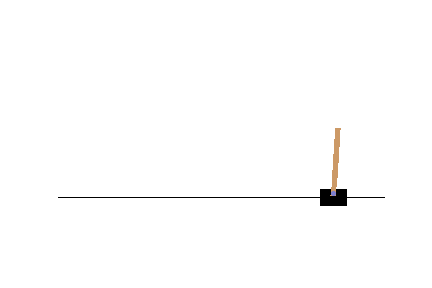
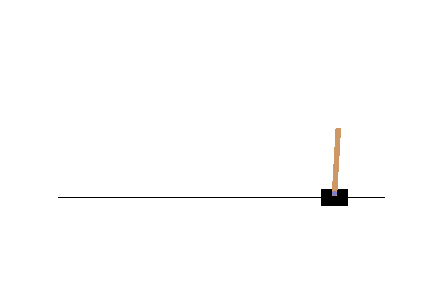
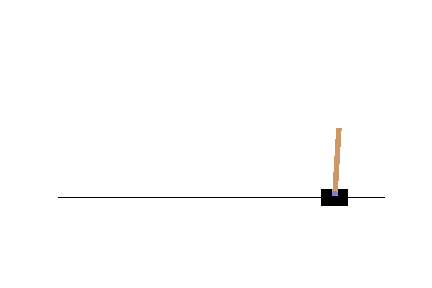
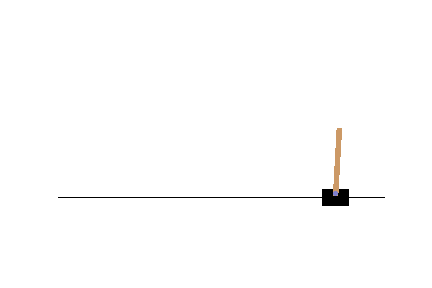
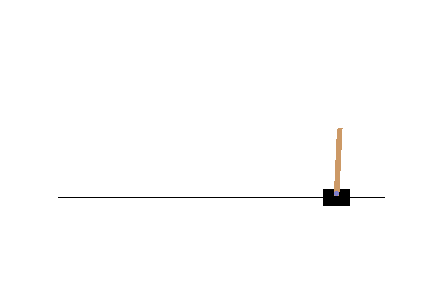
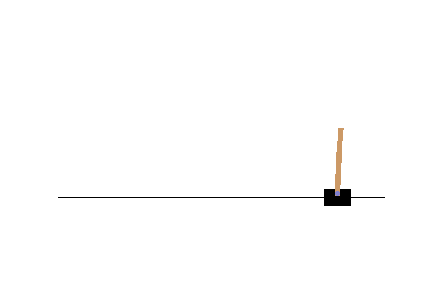
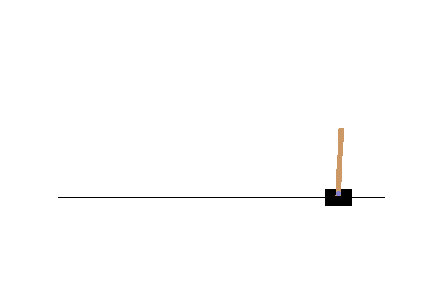
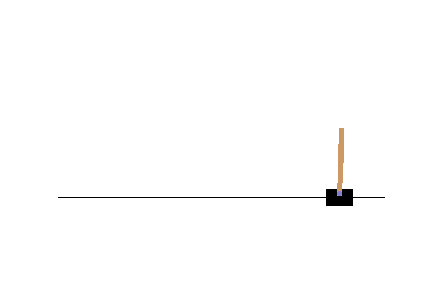
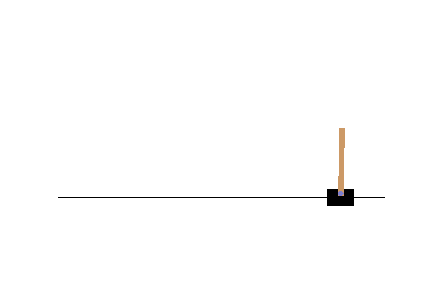
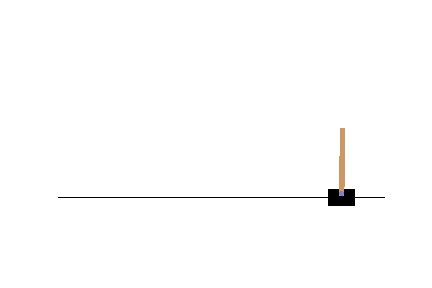
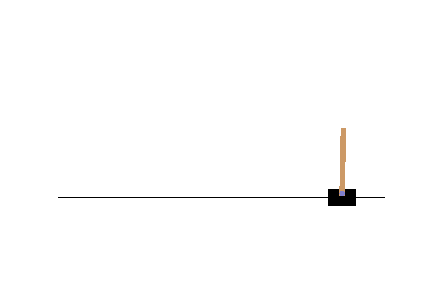
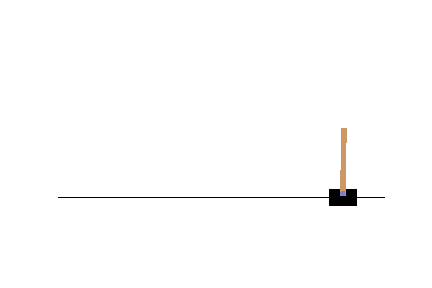
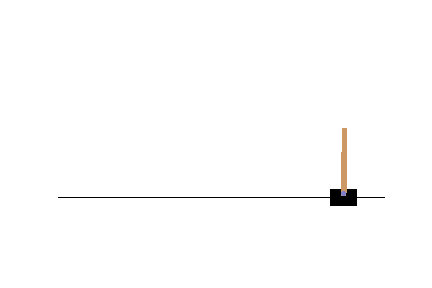
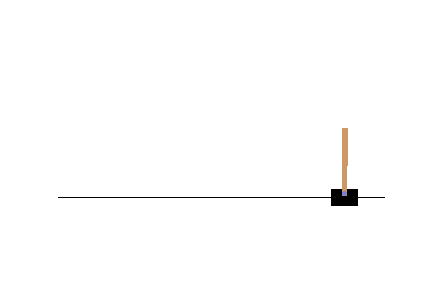
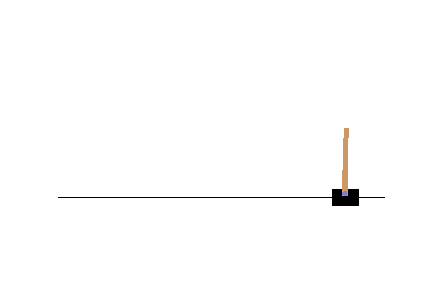
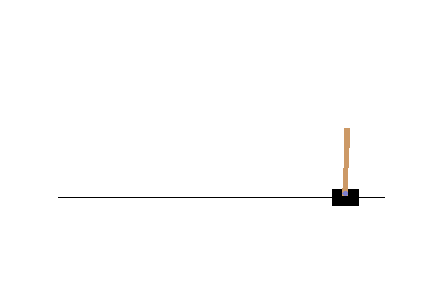
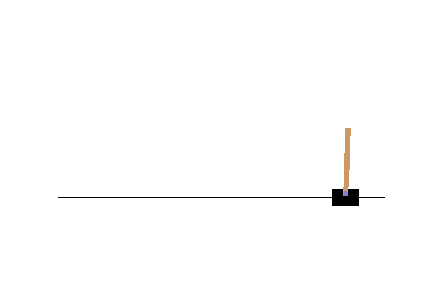
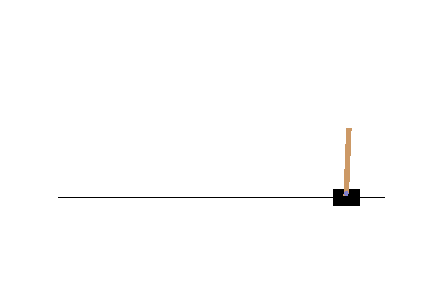
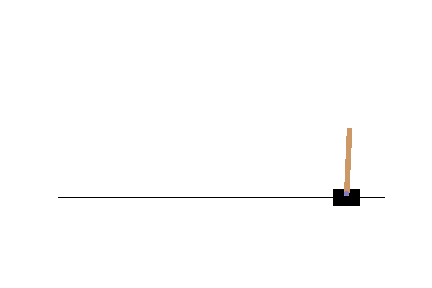
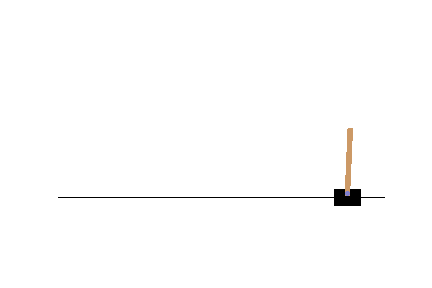
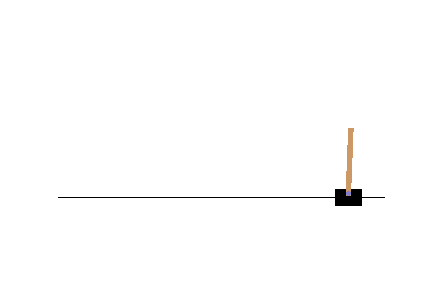
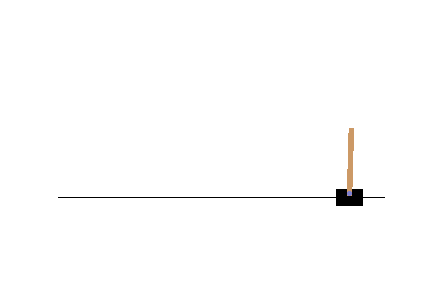
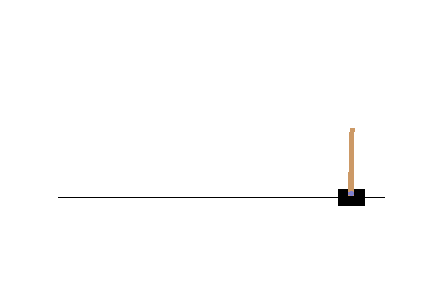
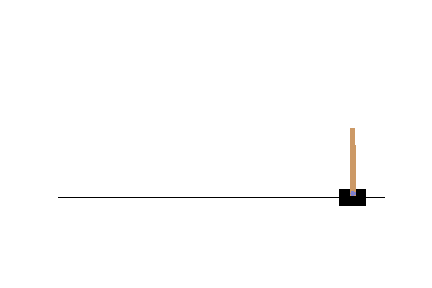
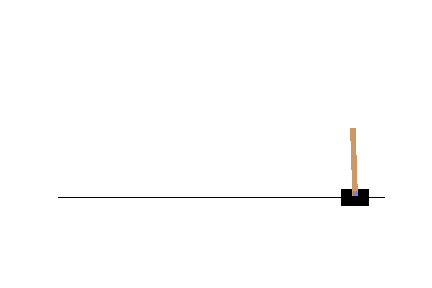
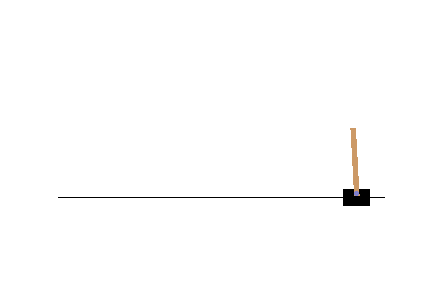
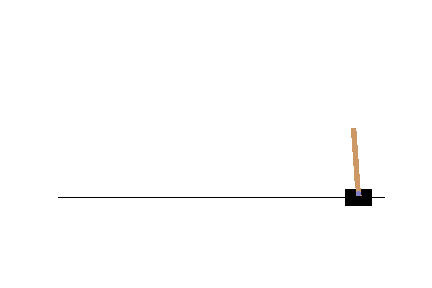
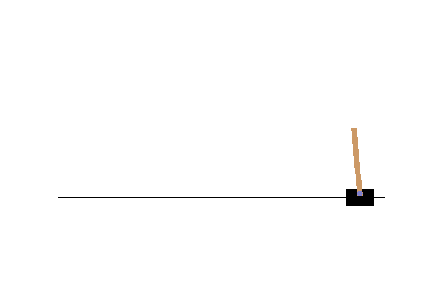
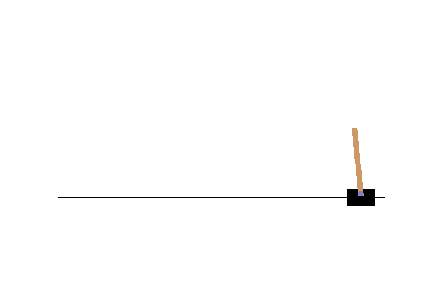
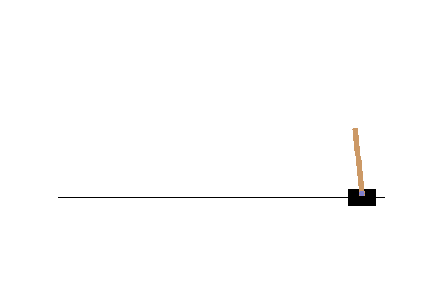
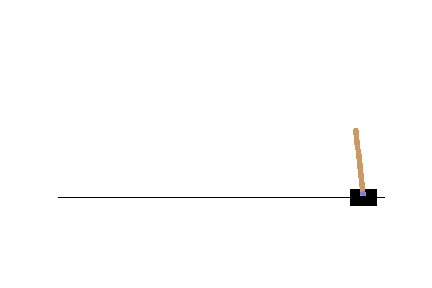
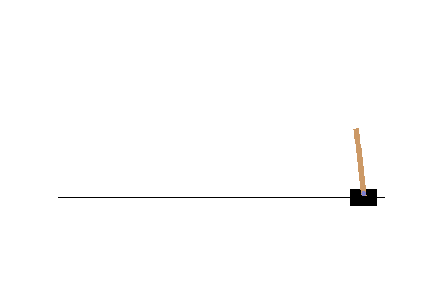
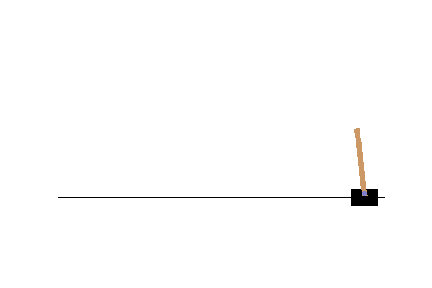
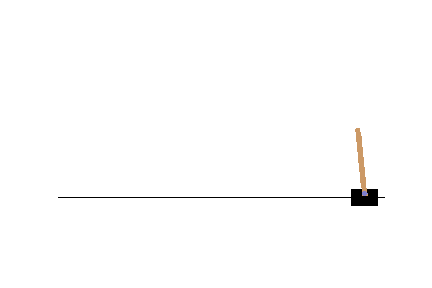
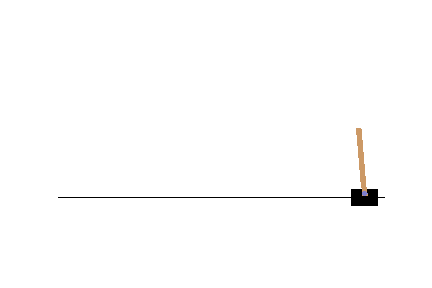
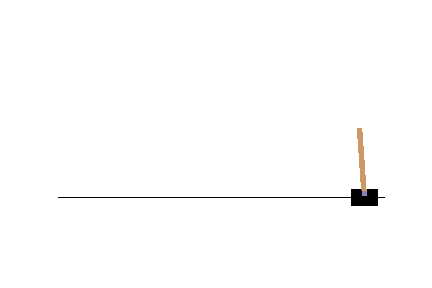
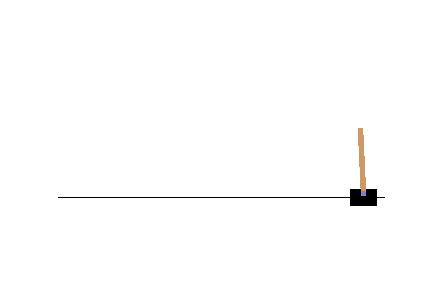
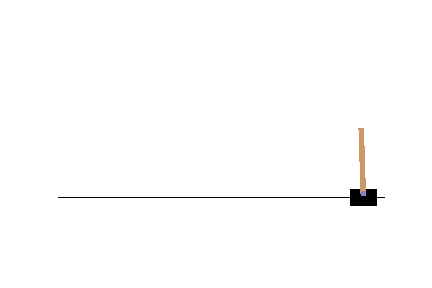
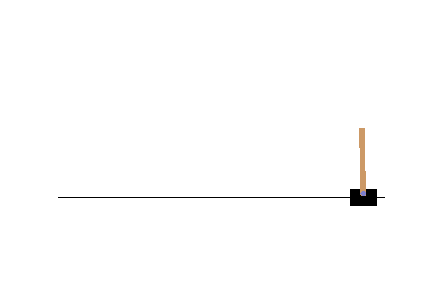
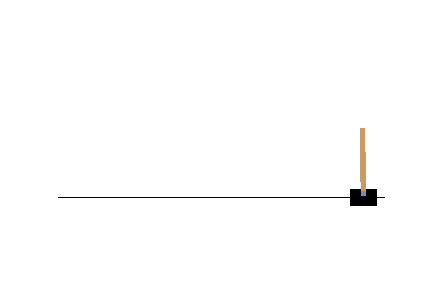
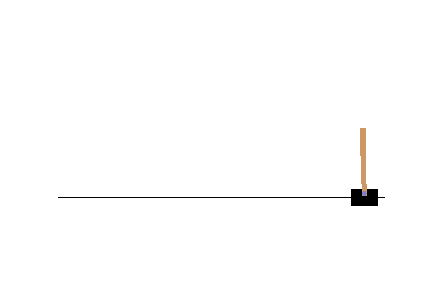
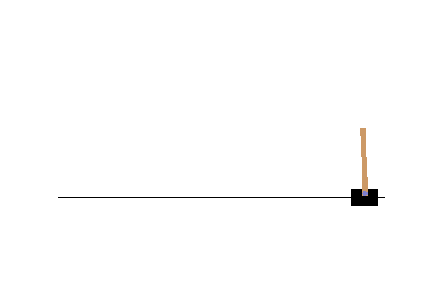
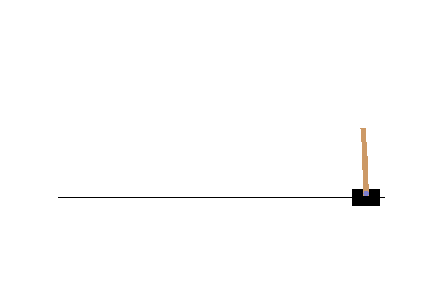
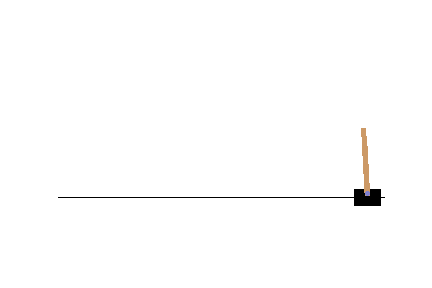
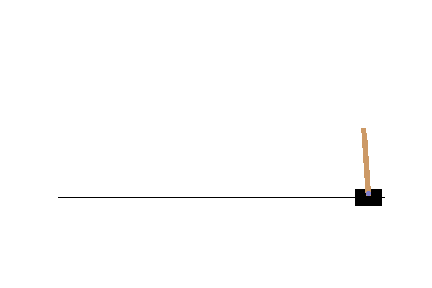
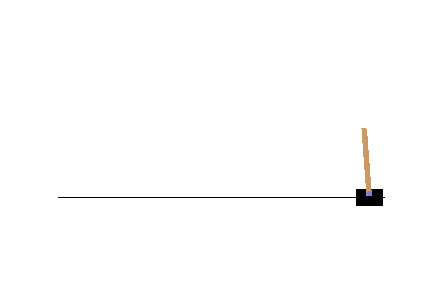
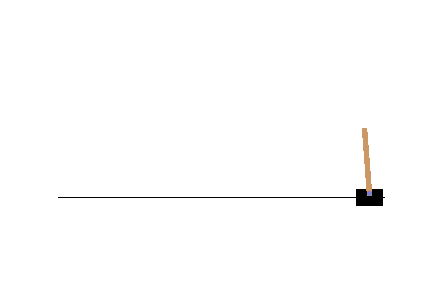
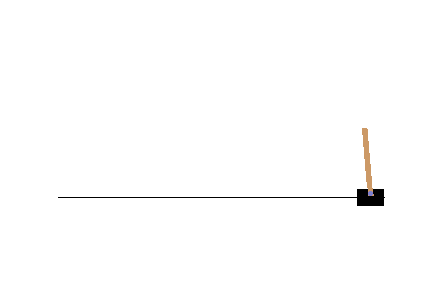
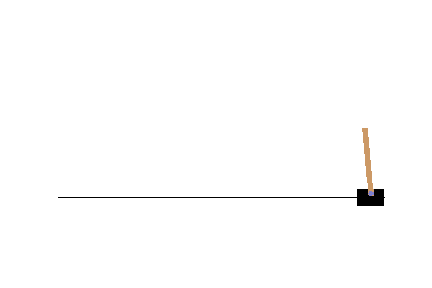
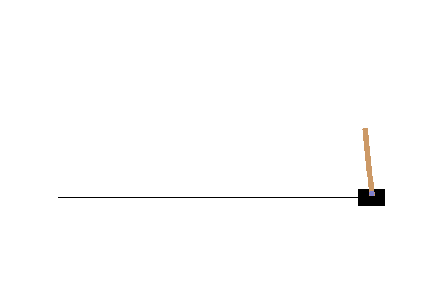
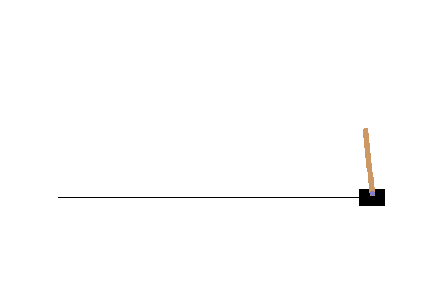
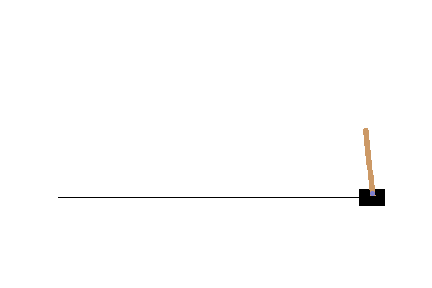
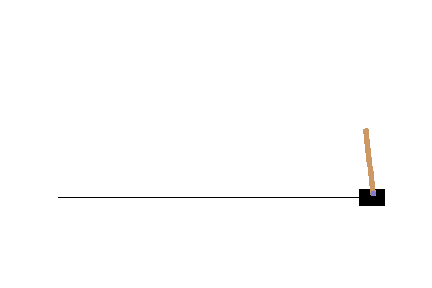
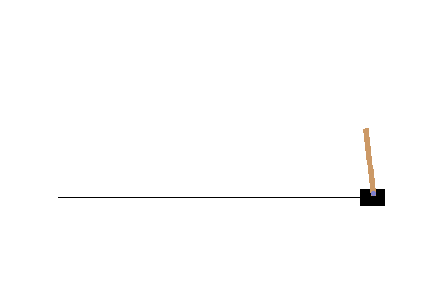
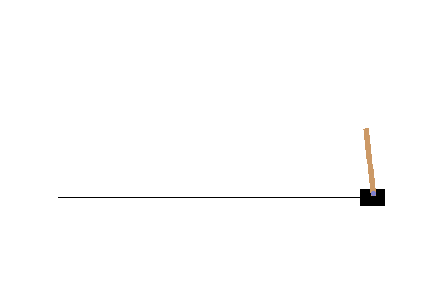
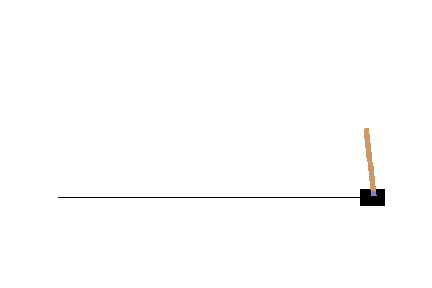
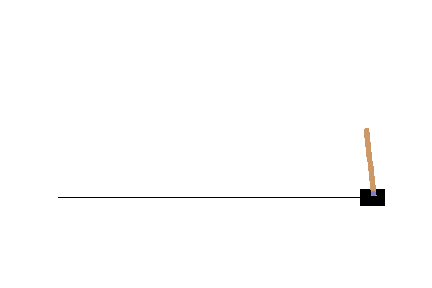
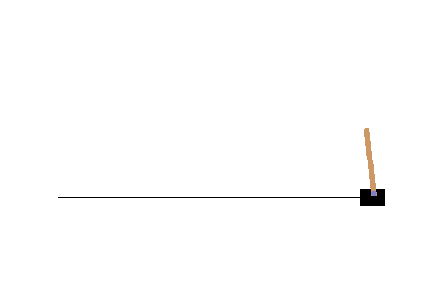
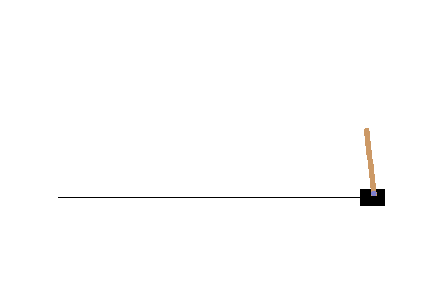
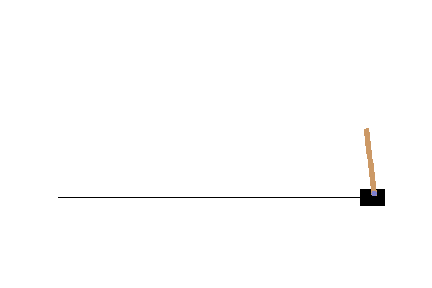
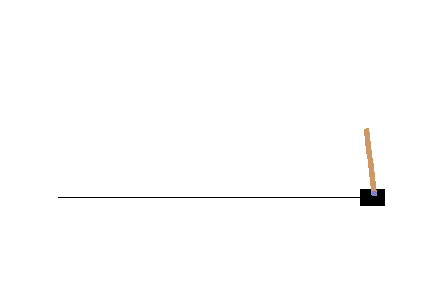
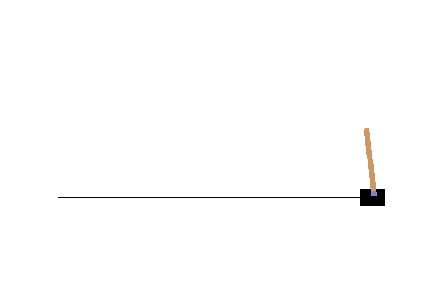
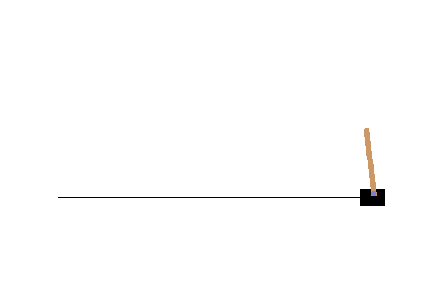
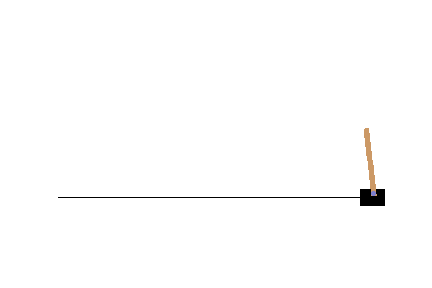
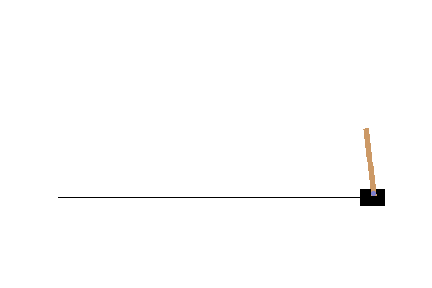
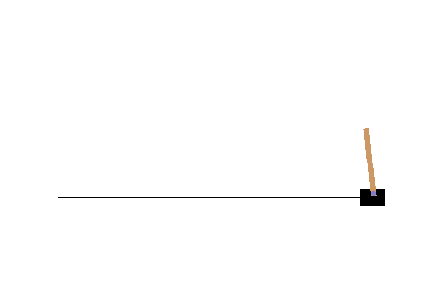
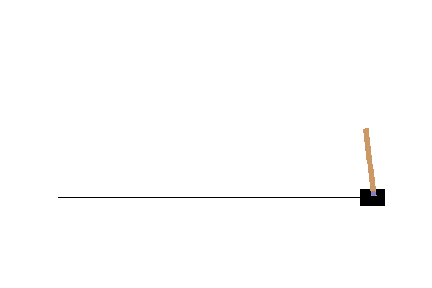
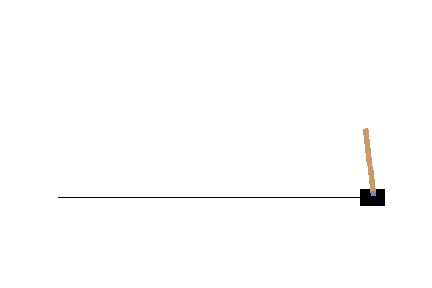
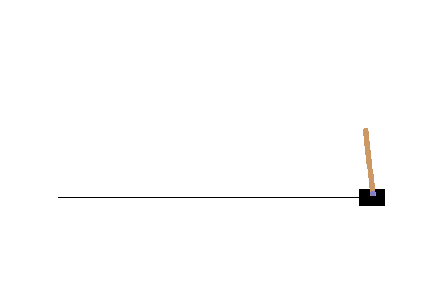
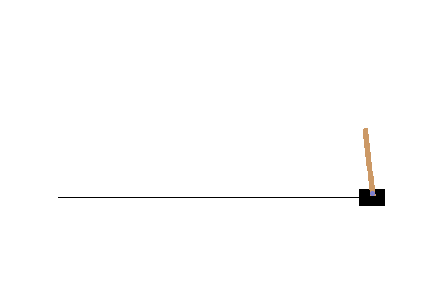
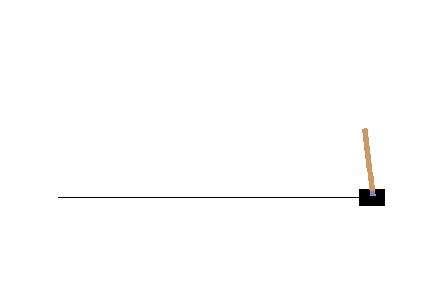
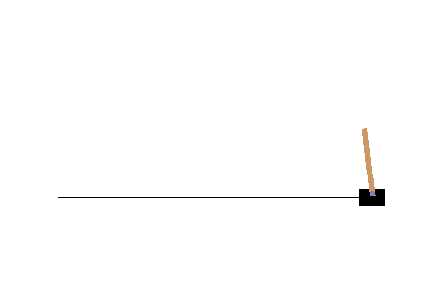
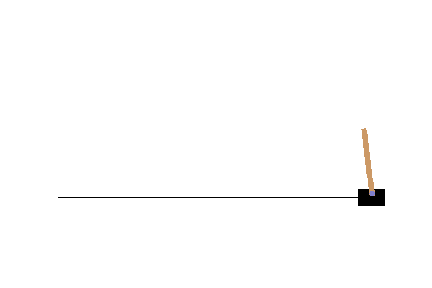
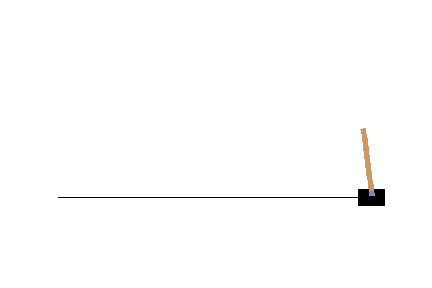
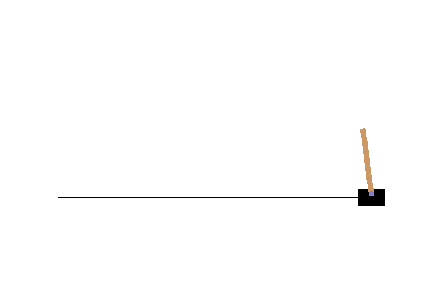
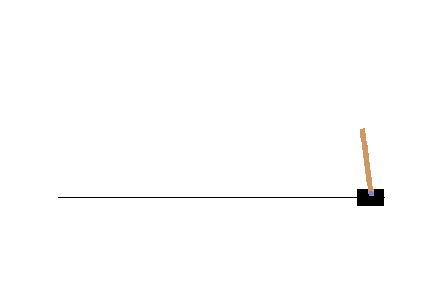
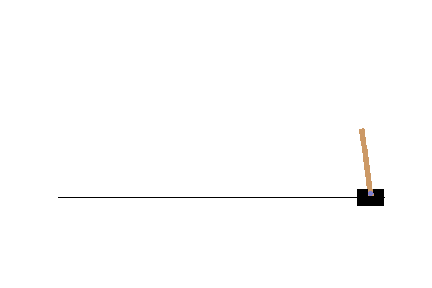
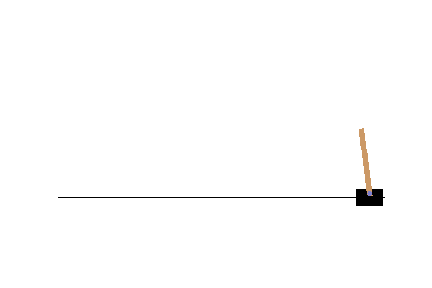
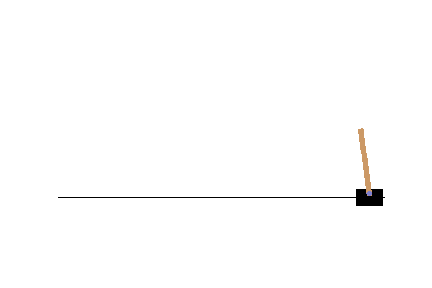
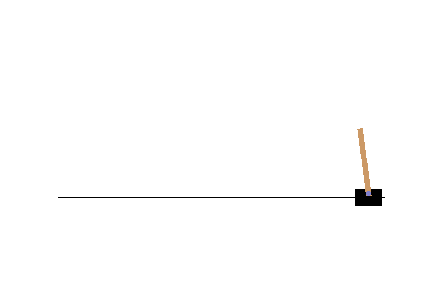
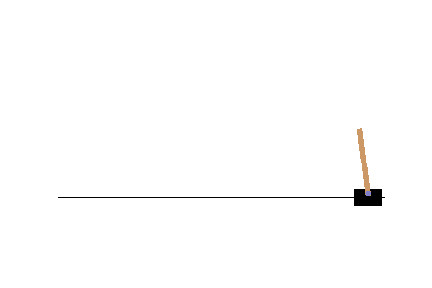
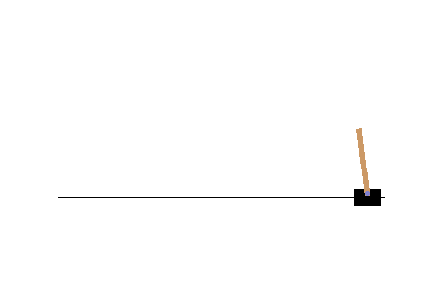
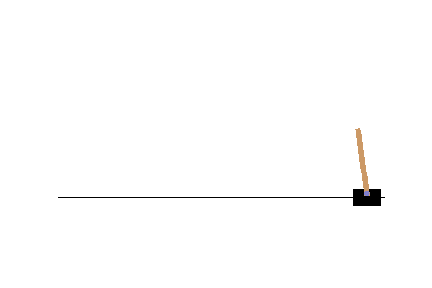
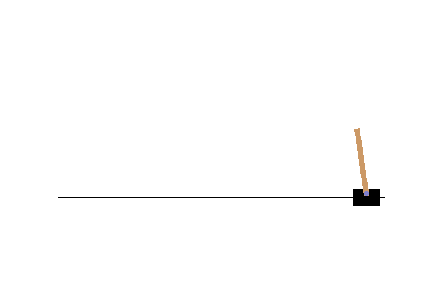
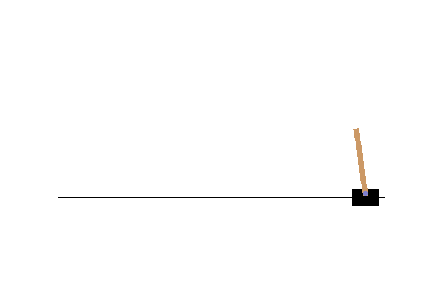
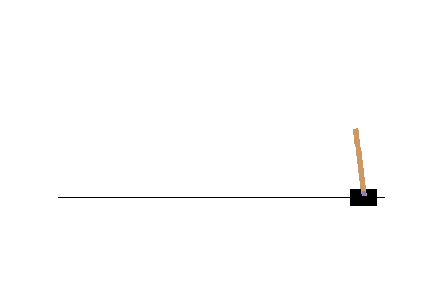
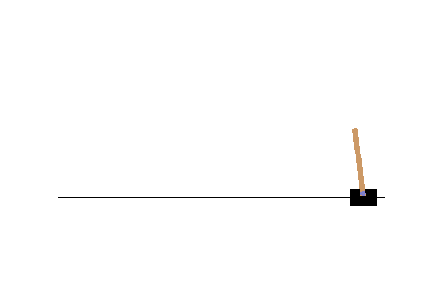
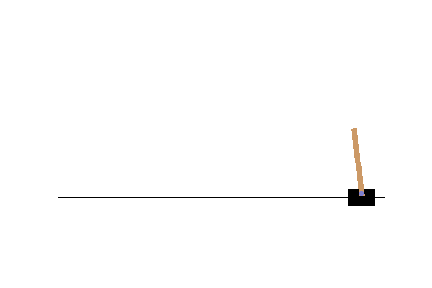
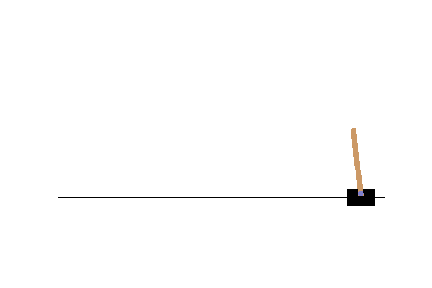
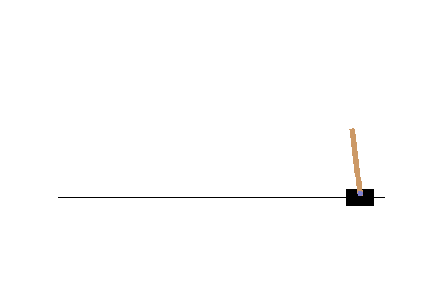
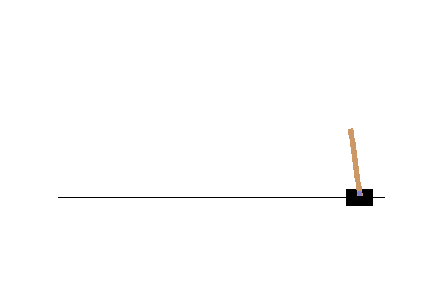
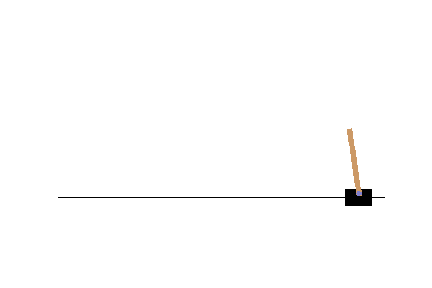
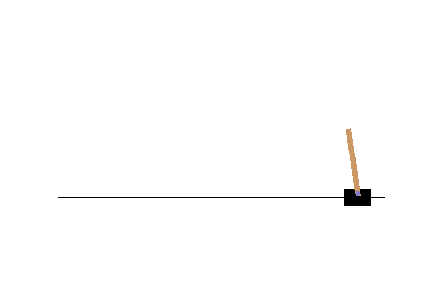
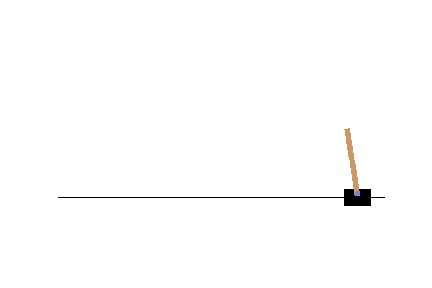
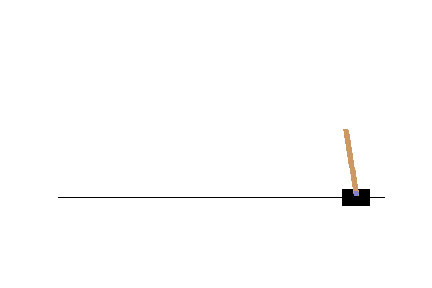
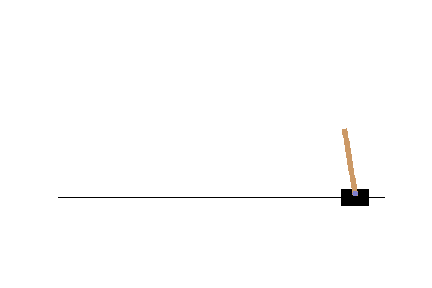
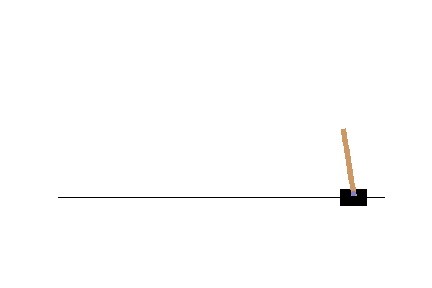
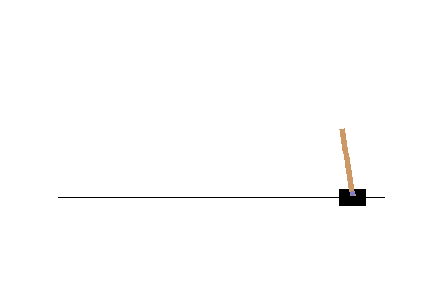
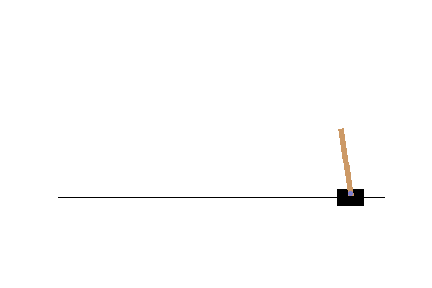
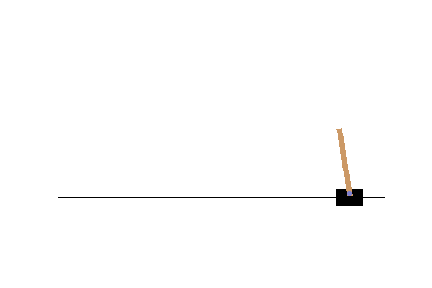
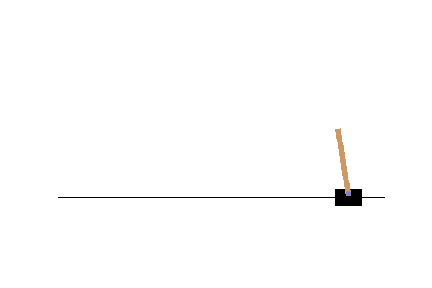
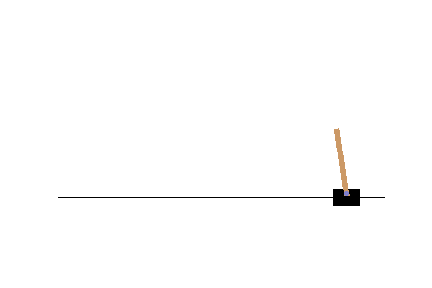
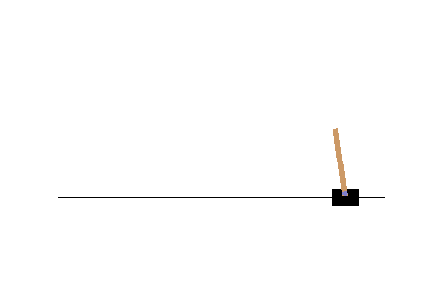
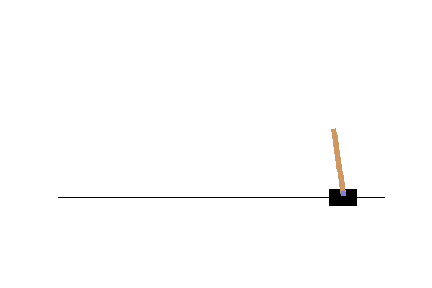
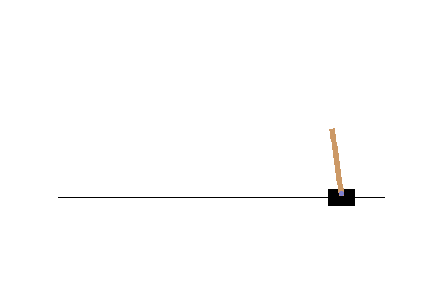
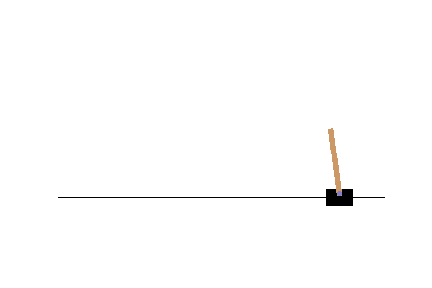
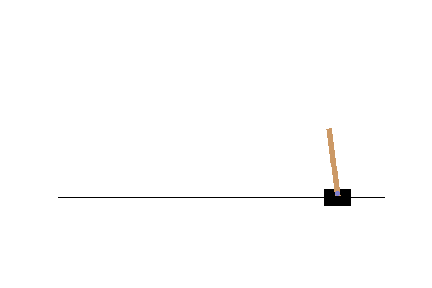
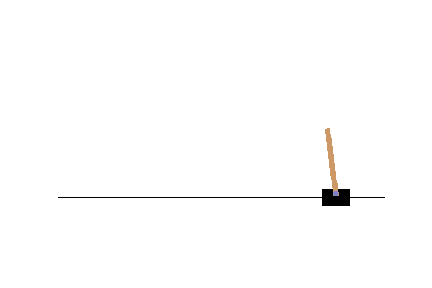
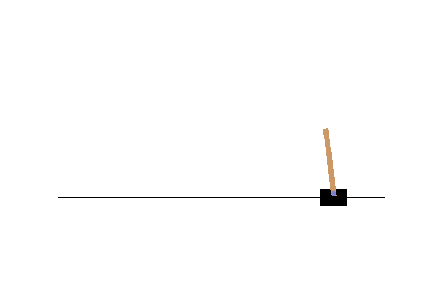
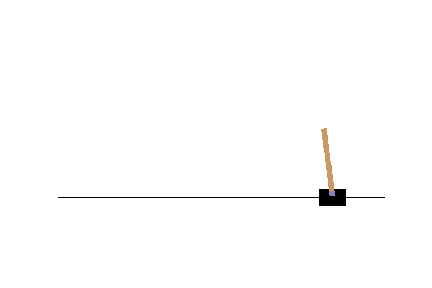
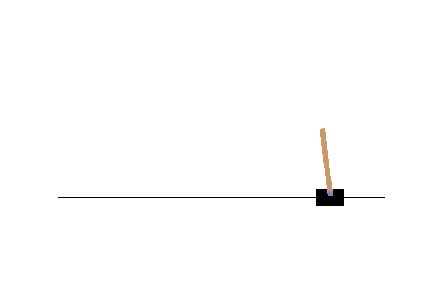
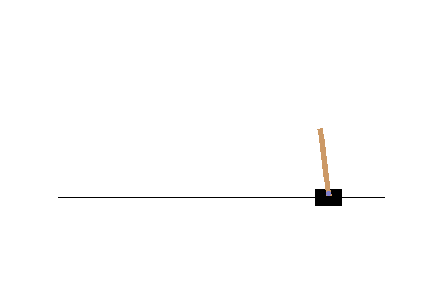
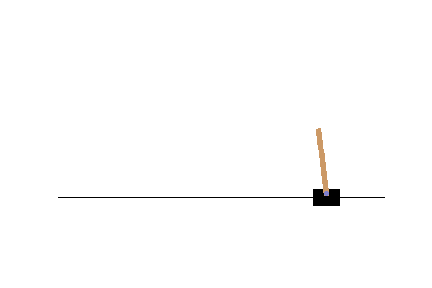
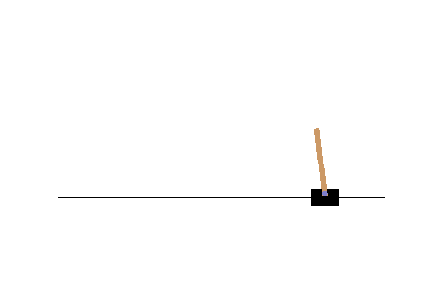
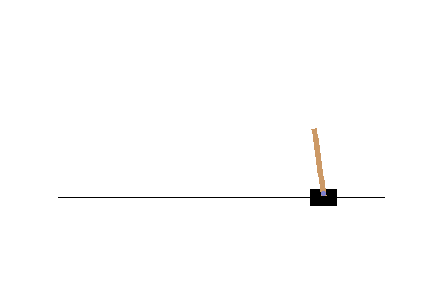
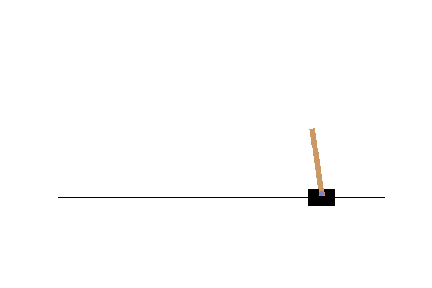
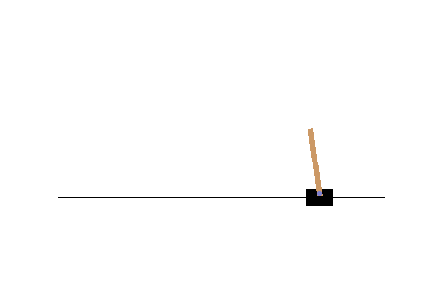
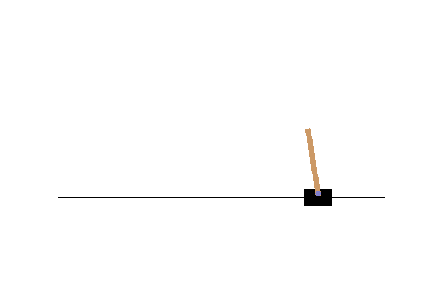
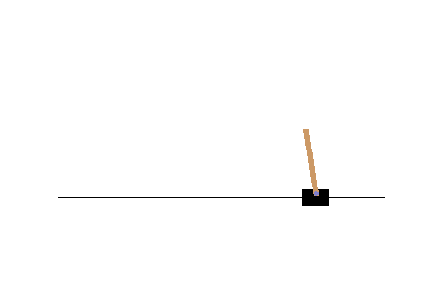
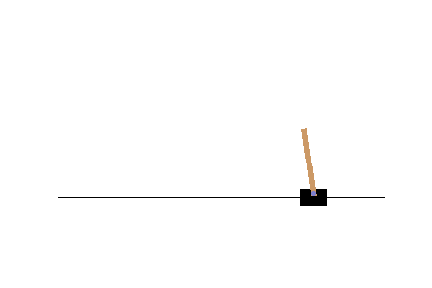
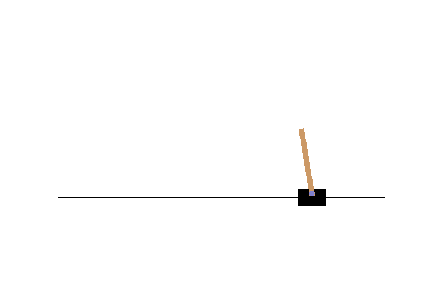
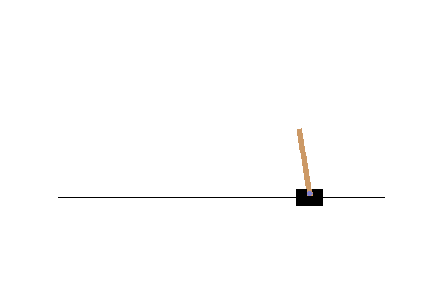
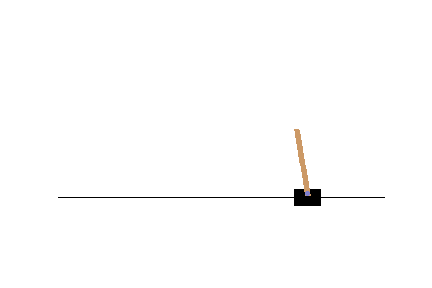
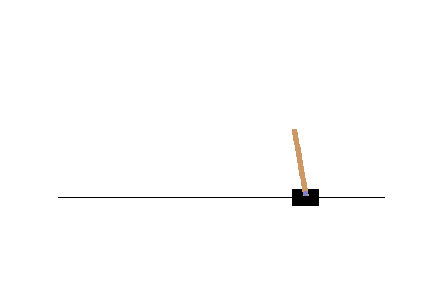
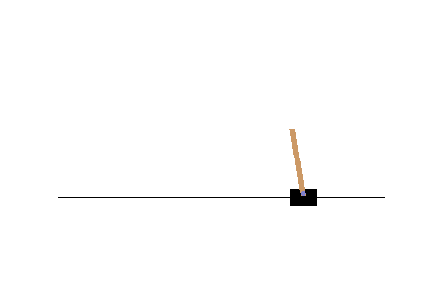
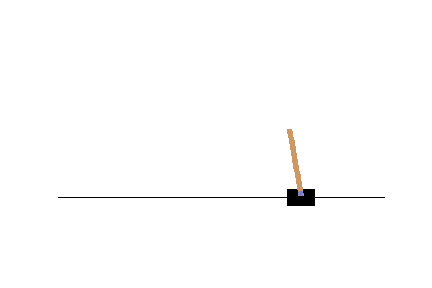
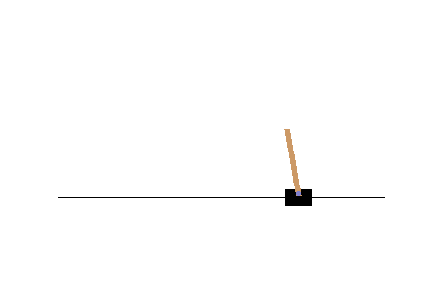
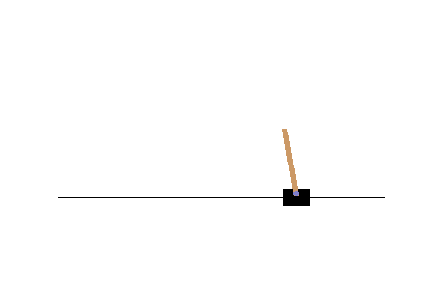
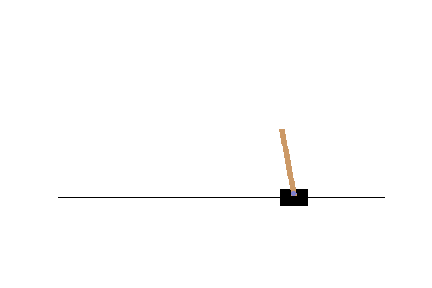
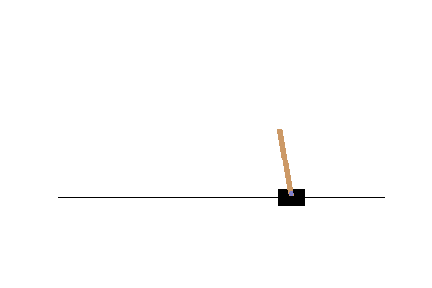
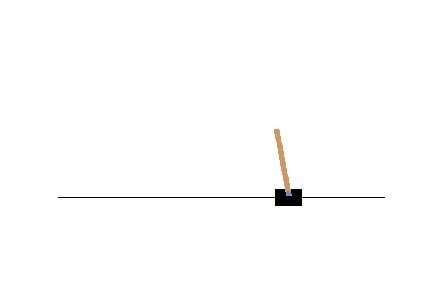
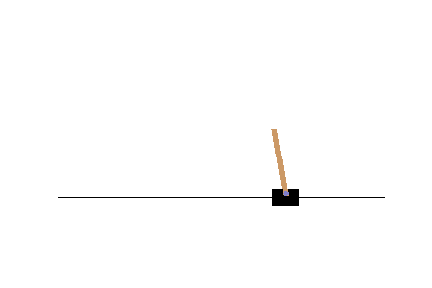
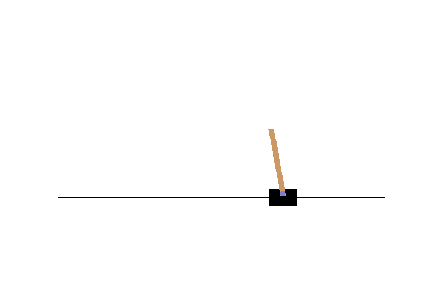
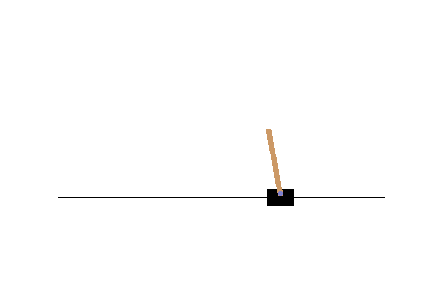
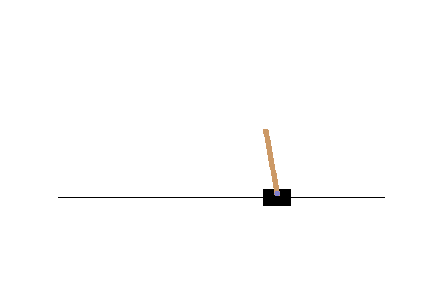
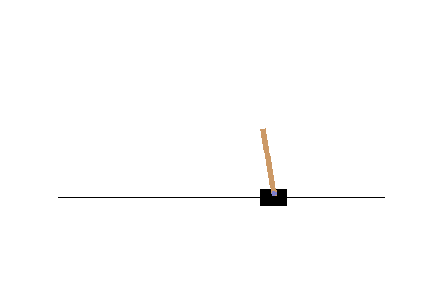
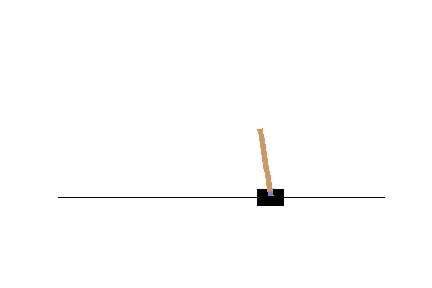
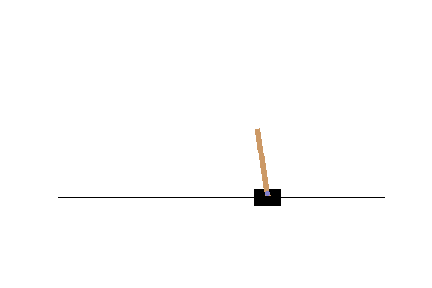
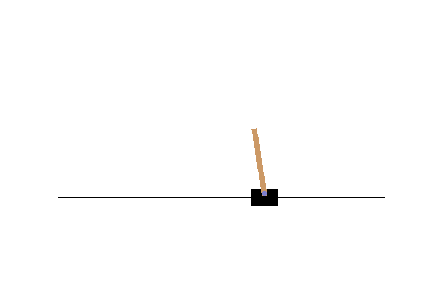
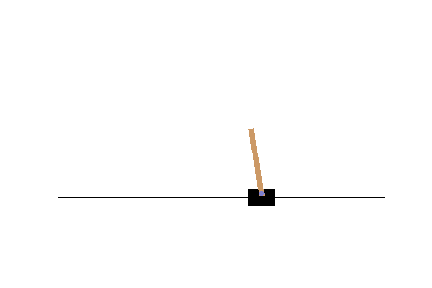
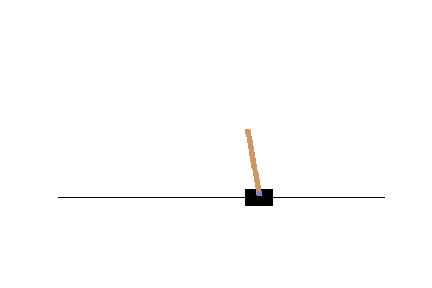
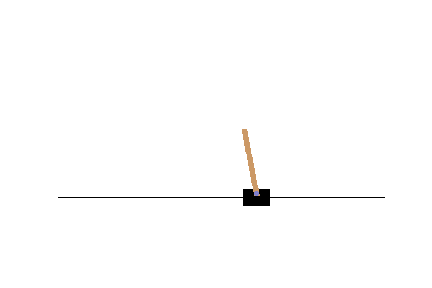
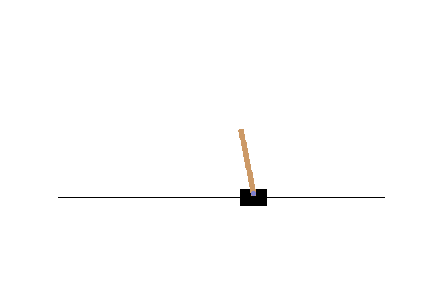
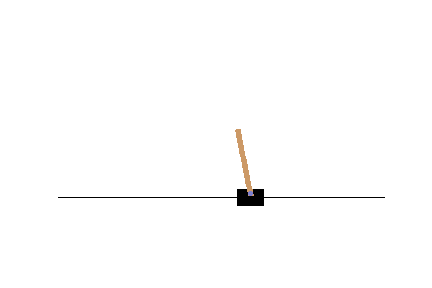
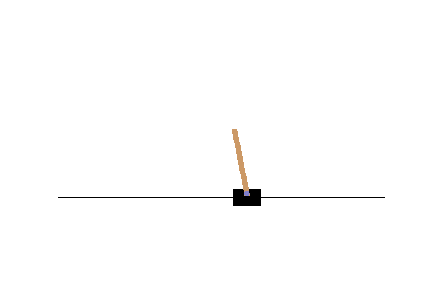
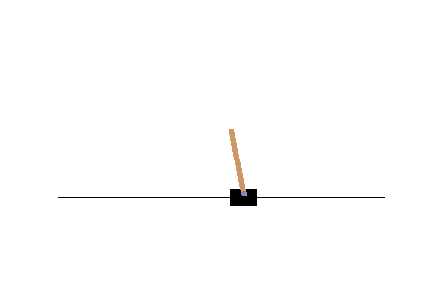
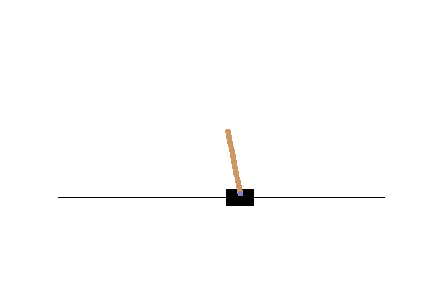
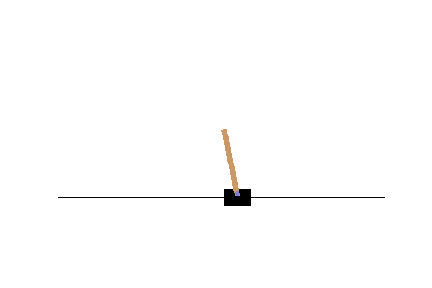

In [5]:
# note: haven't bug-tested this but ideally it should display the frames captured in the best-performing episode
# though playback seems to be in slow motion
# adapted from http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html

def display_frames_as_gif(frames):
    
    plt.clf()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    

print('Best-performing episode: Episode ', best_run_episode)
display_frames_as_gif(best_run_frames)